In [1]:
# !pip install datasets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import WordPiece
from tokenizers import normalizers
from tokenizers.normalizers import NFD, Lowercase, StripAccents
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import WordPieceTrainer
from tokenizers import decoders
from pathlib import Path
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
import random
import gc

/common/home/projectgrps/CS425/CS425G9/jupyterlab-venv-pytorch-240/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%env TOKENIZERS_PARALLELISM = false

env: TOKENIZERS_PARALLELISM=false


In [3]:
from datasets import load_dataset
import ast

def prepare_dataset(batch_size=32, max_length=128, train_size=100000, val_size=10000, test_size=10000):
    dataset = load_dataset("PedroCJardim/QASports")

    train_dataset = dataset["train"].select(range(min(train_size, len(dataset["train"]))))
    val_dataset = dataset["validation"].select(range(min(val_size, len(dataset["validation"]))))
    test_dataset = dataset["test"].select(range(min(test_size, len(dataset["test"]))))

    train_context = pd.Series(train_dataset["context"])
    val_context = pd.Series(val_dataset["context"])
    # test_context = pd.Series(test_dataset["context"])

    # full_df = pd.concat([train_context,val_context,test_context])
    full_df = pd.concat([train_context,val_context])
    full = list(full_df)
    random.shuffle(full)

    def preprocess_function(examples):
        questions_preprocess = [q.strip() for q in examples["question"] if q]
        answers_preprocess = [ast.literal_eval(a)["text"] for a in examples["answer"] if a]

        df_preprocess = pd.DataFrame(questions_preprocess, columns=['questions'])
        df_preprocess['answers'] = answers_preprocess
        df_preprocess = df_preprocess[df_preprocess["answers"] != ""]
        return df_preprocess

    train_dataset = preprocess_function(train_dataset)
    val_dataset = preprocess_function(val_dataset)
    test_dataset = preprocess_function(test_dataset)
    
    # Reset the index of the DataFrame
    train_dataset = train_dataset.reset_index(drop=True)
    val_dataset = val_dataset.reset_index(drop=True)
    test_dataset = test_dataset.reset_index(drop=True)


    return train_dataset, val_dataset, test_dataset, full

train_dataset, val_dataset, test_dataset, full = prepare_dataset()

In [4]:
train_dataset

,questions,answers
0,How many field goals did Kobe Bryant score?,"9,936"
1,Which Lakers forward scored a Finals record 61...,Elgin Baylor
2,Who owns the building?,City of Memphis
3,"Who was the team's president, front office man...",Rick Pitino
4,What college did Marbury commit to?,Georgia Tech
...,...,...
65651,Where is the University System of Maryland loc...,southwest Baltimore County communities of Cato...
65652,Iguodala became the first player to win the aw...,regular season
65653,Why did Parish receive virtually no notice?,one of the most severe penalties ever levied b...
65654,How many contestants were eliminated in 2013?,sixth


In [5]:
# train BERT tokenizer on vocabulary from the sportsQA dataset "context" column
bert_tokenizer = Tokenizer(WordPiece(unk_token="<unk>"))
bert_tokenizer.normalizer = normalizers.Sequence([Lowercase()])
bert_tokenizer.pre_tokenizer = Whitespace()
bert_tokenizer.decoder = decoders.WordPiece()
trainer = WordPieceTrainer(special_tokens=["<unk>","<pad>","<bos>","<eos>"])
bert_tokenizer.train_from_iterator(full,trainer)
bert_tokenizer.enable_padding(
    pad_id=bert_tokenizer.token_to_id('<pad>'),
    length=128,
    pad_token='<pad>'
)
bert_tokenizer.enable_truncation(128)

base = Path('tokenizer',)
base.mkdir(exist_ok=True,parents=True)
bert_tokenizer.save(str(base / 'sportsQA_context.json'))

In [6]:
print(bert_tokenizer.get_vocab_size())

30000


In [7]:
x = bert_tokenizer.encode(f"<bos>{train_dataset.loc[1,'questions']}<eos>")
for a,b in zip(x.ids, x.tokens):
    if b!= '<pad>':
        print(f'{a} : {b}')
    
print('\n',bert_tokenizer.decode(x.ids),'\n\n')

x = bert_tokenizer.encode(f"<bos>{train_dataset.loc[1,'answers']}<eos>")
for a,b in zip(x.ids, x.tokens):
    if b!= '<pad>':
        print(f'{a} : {b}')
    
print('\n',bert_tokenizer.decode(x.ids))

2 : <bos>
1562 : which
1124 : lakers
1284 : forward
1742 : scored
40 : a
1109 : finals
1126 : record
1753 : 61
1032 : points
33 : ?
3 : <eos>

 which lakers forward scored a finals record 61 points? 


2 : <bos>
5774 : elgin
2775 : baylor
3 : <eos>

 elgin baylor


In [8]:
class Dataset:
    def __init__(self,df):
        self.df = df
    def __len__(self,):
        return len(self.df)
    def __getitem__(self,idx):
        sample = self.df.iloc[idx,:]
        en,lang2 = sample['questions'], sample['answers']
        start_token = "<bos>"
        qn = bert_tokenizer.encode(f'<bos>{en.strip()}<eos>').ids
        ans = bert_tokenizer.encode(f'<bos>{lang2.strip()}<eos>').ids
        ans_shift = ans.copy()
        ans_shift[:-1] = ans[1:]
        ans_shift[-1] = bert_tokenizer.token_to_id('<pad>')
        
        qn = torch.tensor(qn,dtype=torch.long)
        ans = torch.tensor(ans,dtype=torch.long)
        ans_shift = torch.tensor(ans_shift,dtype=torch.long)
        ans_shift[ans_shift==1]=-100
        return qn,ans,ans_shift

In [9]:
train_ds = Dataset(train_dataset)
val_ds = Dataset(val_dataset)

In [10]:
# https://github.com/bzhangGo/rmsnorm/blob/master/rmsnorm_torch.py
class RMSNorm(nn.Module):
    def __init__(self, d, p=-1., eps=1e-8, bias=False):
        """
            Root Mean Square Layer Normalization
        :param d: model size
        :param p: partial RMSNorm, valid value [0, 1], default -1.0 (disabled)
        :param eps:  epsilon value, default 1e-8
        :param bias: whether use bias term for RMSNorm, disabled by
            default because RMSNorm doesn't enforce re-centering invariance.
        """
        super(RMSNorm, self).__init__()

        self.eps = eps
        self.d = d
        self.p = p
        self.bias = bias

        self.scale = nn.Parameter(torch.ones(d))
        self.register_parameter("scale", self.scale)

        if self.bias:
            self.offset = nn.Parameter(torch.zeros(d))
            self.register_parameter("offset", self.offset)

    def forward(self, x):
        if self.p < 0. or self.p > 1.:
            norm_x = x.norm(2, dim=-1, keepdim=True)
            d_x = self.d
        else:
            partial_size = int(self.d * self.p)
            partial_x, _ = torch.split(x, [partial_size, self.d - partial_size], dim=-1)

            norm_x = partial_x.norm(2, dim=-1, keepdim=True)
            d_x = partial_size

        rms_x = norm_x * d_x ** (-1. / 2)
        x_normed = x / (rms_x + self.eps)

        if self.bias:
            return self.scale * x_normed + self.offset

        return self.scale * x_normed


class MultiheadAttention(nn.Module):
    def __init__(self, dim, n_heads, dropout=0.):
        super().__init__()
        self.dim = dim
        self.n_heads = n_heads
        assert dim % n_heads == 0, 'dim should be div by n_heads'
        self.head_dim = self.dim // self.n_heads
        self.q = nn.Linear(dim,dim,bias=False)
        self.k = nn.Linear(dim,dim,bias=False)
        self.v = nn.Linear(dim,dim,bias=False)
        self.attn_dropout = nn.Dropout(dropout)
        self.scale = self.head_dim ** -0.5
        self.out_proj = nn.Linear(dim,dim,bias=False)
        
    def forward(self,q,k,v,mask=None):
        batch,t,c = q.shape
        q = self.q(q)
        k = self.k(k)
        v = self.v(v)
        q = q.view(batch,q.size(1),self.n_heads,self.head_dim).permute(0,2,1,3)
        k = k.view(batch,k.size(1),self.n_heads,self.head_dim).permute(0,2,1,3)
        v = v.view(batch,v.size(1),self.n_heads,self.head_dim).permute(0,2,1,3)
        
        qkT = torch.matmul(q,k.transpose(-1,-2)) * self.scale
        qkT = self.attn_dropout(qkT)
        
        if mask is not None:
            mask = mask.to(dtype=qkT.dtype,device=qkT.device)
            a,b = qkT.size(-2), qkT.size(-1)
            qkT = qkT.masked_fill(mask[:,:,:a,:b]==0,float('-inf'))
            
        qkT = F.softmax(qkT,dim=-1)
            
        attn = torch.matmul(qkT,v)
        attn = attn.permute(0,2,1,3).contiguous().view(batch,t,c)
        out = self.out_proj(attn)
        return out
    


class FeedForward(nn.Module):
    def __init__(self,dim,dropout=0.):
        super().__init__()
        self.feed_forward = nn.Sequential(
            nn.Linear(dim,dim*4,bias=False),
            nn.Dropout(dropout),
            nn.GELU(),
            nn.Linear(dim*4,dim,bias=False)
        )
        
    def forward(self, x):
        return self.feed_forward(x)
    


class EncoderBlock(nn.Module):
    def __init__(self, dim, n_heads, attn_dropout=0., mlp_dropout=0.):
        super().__init__()
        self.attn = MultiheadAttention(dim,n_heads,attn_dropout)
        self.ffd = FeedForward(dim,mlp_dropout)
        self.ln_1 = RMSNorm(dim)
        self.ln_2 = RMSNorm(dim)
        
    def forward(self,x,mask=None):
        x = self.ln_1(x)
        x = x + self.attn(x,x,x,mask)
        x = self.ln_2(x)
        x = x + self.ffd(x)
        return x
    


class DecoderBlock(nn.Module):
    def __init__(self, dim, n_heads, attn_dropout=0., mlp_dropout=0.):
        super().__init__()
        self.self_attn = MultiheadAttention(dim,n_heads,attn_dropout)
        self.cross_attn = MultiheadAttention(dim,n_heads,attn_dropout)
        self.ln_1 = RMSNorm(dim)
        self.ln_2 = RMSNorm(dim)
        self.ln_3 = RMSNorm(dim)
        self.ffd = FeedForward(dim,mlp_dropout)
        
    def forward(self, x, enc_out, src_mask, tgt_mask):
        x = self.ln_1(x)
        x = x + self.self_attn(x,x,x,tgt_mask)
        x = self.ln_2(x)
        x = x + self.cross_attn(x,enc_out,enc_out,src_mask) # decoder: q, encoder: k,v
        x = self.ln_3(x)
        x = x + self.ffd(x)
        
        return x
    


class Embedding(nn.Module):
    def __init__(self,vocab_size,max_len,dim):
        super().__init__()
        self.max_len = max_len
        self.class_embedding = nn.Embedding(vocab_size,dim)
        self.pos_embedding = nn.Embedding(max_len,dim)
    def forward(self,x):
        x = self.class_embedding(x)
        pos = torch.arange(0,x.size(1),device=x.device)
        x = x + self.pos_embedding(pos)
        return x
    


class Seq2SeqTransformer(nn.Module):
    def __init__(self, config):
        
        super().__init__()
        
        self.embedding = Embedding(config['vocab_size'],config['max_len'],config['dim'])
        
        self.depth = config['depth']
        self.encoders = nn.ModuleList([
            EncoderBlock(
                dim=config['dim'],
                n_heads=config['n_heads'],
                attn_dropout=config['attn_dropout'],
                mlp_dropout=config['mlp_dropout']
            ) for _ in range(self.depth)
        ])
        self.decoders = nn.ModuleList([
            DecoderBlock(
                dim=config['dim'],
                n_heads=config['n_heads'],
                attn_dropout=config['attn_dropout'],
                mlp_dropout=config['mlp_dropout']
            ) for _ in range(self.depth)
        ])
        
        self.ln_f = RMSNorm(config['dim'])
        self.lm_head = nn.Linear(config['dim'],config['vocab_size'],bias=False)
        
        self.embedding.class_embedding.weight = self.lm_head.weight
        
        self.pad_token_id = config['pad_token_id']
        self.register_buffer('tgt_mask',torch.tril(torch.ones(1,1,config['max_len'],config['max_len'])))
    
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
    
    def create_src_mask(self,src):
        return (src != self.pad_token_id).unsqueeze(1).unsqueeze(2) # N, 1, 1, src_len
    
    def forward(self, src, tgt, labels=None):
        
        src_mask = self.create_src_mask(src)
        
        enc_out = self.embedding(src)
        dec_out = self.embedding(tgt)
        
        for i in range(self.depth):
            enc_out = self.encoders[i](enc_out,mask=src_mask)
            dec_out = self.decoders[i](dec_out,enc_out,src_mask=src_mask,tgt_mask=self.tgt_mask)
            
        dec_out = self.ln_f(dec_out)
        
        if labels is not None:
            lm_logits = self.lm_head(dec_out)
            loss = F.cross_entropy(lm_logits.view(-1, lm_logits.shape[-1]), labels.view(-1))
            return loss
        
        lm_logits = self.lm_head(dec_out[:,[-1],:])
        return lm_logits
    
    def generate(self,src,max_tokens=80,temperature=1.0,deterministic=False,eos=5,bos=None):
        tgt = torch.ones(1,1).long() * bos
        tgt = tgt.to(src.device)
        for _ in range(max_tokens):
            out = self(src,tgt)
            out = out[:,-1,:] / temperature
            probs = F.softmax(out,dim=-1)
            if deterministic:
                next_token = torch.argmax(probs,dim=-1,keepdim=True)
            else:
                next_token = torch.multinomial(probs,num_samples=1)
            tgt = torch.cat([tgt,next_token],dim=1)
            if next_token.item() == eos:
                break
            
        return tgt.cpu().flatten()

In [11]:
config = {
    'dim': 768,
    'n_heads': 12,
    'attn_dropout': 0.1,
    'mlp_dropout': 0.1,
    'depth': 6,
    'vocab_size': bert_tokenizer.get_vocab_size(),  # Set to tokenizer vocabulary size
    'max_len': 128,
    'pad_token_id': bert_tokenizer.token_to_id('<pad>')
}

In [12]:
model = Seq2SeqTransformer(config).to('cuda')
print(sum([p.numel() for p in model.parameters() if p.requires_grad]))

122252544


In [13]:
print(model)

Seq2SeqTransformer(
  (embedding): Embedding(
    (class_embedding): Embedding(30000, 768)
    (pos_embedding): Embedding(128, 768)
  )
  (encoders): ModuleList(
    (0-5): 6 x EncoderBlock(
      (attn): MultiheadAttention(
        (q): Linear(in_features=768, out_features=768, bias=False)
        (k): Linear(in_features=768, out_features=768, bias=False)
        (v): Linear(in_features=768, out_features=768, bias=False)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=False)
      )
      (ffd): FeedForward(
        (feed_forward): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=False)
          (1): Dropout(p=0.1, inplace=False)
          (2): GELU(approximate='none')
          (3): Linear(in_features=3072, out_features=768, bias=False)
        )
      )
      (ln_1): RMSNorm()
      (ln_2): RMSNorm()
    )
  )
  (decoders): ModuleList(
    (0-5): 6 x DecoderBlock(
      (self_attn): M

In [14]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=128,shuffle=True,pin_memory=True,num_workers=2)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=128,shuffle=False,pin_memory=True,num_workers=2)
print(len(train_dl), len(val_dl))


513 51


In [15]:
test_dataset.head()

,questions,answers
0,How many.429.000.875 3.7 2002 Minnesota 3 1?,14.3
1,Who punched Kent Benson?,Abdul-Jabbar
2,How many regular-season games did the Huskies ...,126
3,In what year did Mitchell pledge her allegianc...,2013
4,When did the NBL merge with the BAA?,"August 3, 1949"


In [16]:
test_samples = [(test_dataset.loc[i,'questions'],test_dataset.loc[i,'answers']) for i in range(len(test_dataset))]


In [18]:
epochs = 6
train_losses = []
valid_losses = []
best_val_loss = 1e9

train_accuracies = []
valid_accuracies = []

all_tl = []
all_lr = []

optim = torch.optim.Adam(model.parameters(),lr=1e-4)
sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optim,
    T_0=250,
    eta_min=1e-8
)

scaler = GradScaler()

/tmp/ipykernel_1217601/2891069426.py:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [19]:
for ep in tqdm(range(epochs)):
    model.train()
    trl = 0.
    correct_train = 0
    total_train = 0
    tprog = tqdm(enumerate(train_dl),total=len(train_dl))
    for i, batch in tprog:
        with autocast():
            src, tgt, labels = [b.to('cuda') for b in batch]
            loss = model(src,tgt,labels)
            scaler.scale(loss).backward()
            scaler.unscale_(optim)
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0, norm_type=2)
            scaler.step(optim)
            scaler.update()
            optim.zero_grad()
            sched.step(ep + i / len(train_dl))
            all_lr.append(sched.get_last_lr())
            trl += loss.item()
            all_tl.append(loss.item())
            tprog.set_description(f'train step loss: {loss.item():.4f}')
    train_losses.append(trl/len(train_dl))
    
    gc.collect()
    torch.cuda.empty_cache()
        
    model.eval()
    with torch.no_grad():
        vrl = 0.
        vprog = tqdm(enumerate(val_dl),total=len(val_dl))
        for i, batch in vprog:
            with autocast():
                src, tgt, labels = [b.to('cuda') for b in batch]
                loss = model(src,tgt,labels)
                vrl += loss.item()
                vprog.set_description(f'valid step loss: {loss.item():.4f}')
        vloss = vrl/len(val_dl)
        valid_losses.append(vloss)
        print(f'epoch {ep} | train_loss: {train_losses[-1]:.4f} valid_loss: {valid_losses[-1]:.4f}')
        
        if vloss < best_val_loss:
            best_val_loss = vloss
            
            print('saving best model...')
            sd = model.state_dict()
            torch.save(sd,'./kaggle_checkpoint/best_model_scaledDotProd_100k.pt')
            
        print('saving epoch checkpoint...')
        sd = model.state_dict()
        torch.save(sd,f'./kaggle_checkpoint/checkpoint_model_epoch{ep}.pt')
        # TODO: finish fixing this part of the code (tokenizing stuff)
        print('predicting with current epoch model...')
        for (src,tgt) in random.choices(test_samples,k=5):
            input_ids = bert_tokenizer.encode(f"<bos>{src}<eos>").ids
            input_ids = torch.tensor(input_ids,dtype=torch.long).unsqueeze(0).to('cuda')

            bos = bert_tokenizer.token_to_id('<bos>')
            
            tgt_out = model.generate(input_ids,bos=bos,deterministic=True)
            tgt_out = bert_tokenizer.decode(tgt_out.numpy())
            print(f'\nQuestion: {src} \nAnswer: {tgt} \nModelAnswer: {tgt_out}\n')

        print('-'*30,'\n\n')
    
    gc.collect()
    torch.cuda.empty_cache()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

/tmp/ipykernel_1217601/1625412190.py:8: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


train step loss: 10.3592:   0%|          | 0/513 [00:00<?, ?it/s]

train step loss: 10.3592:   0%|          | 1/513 [00:00<06:37,  1.29it/s]

train step loss: 7.6786:   0%|          | 1/513 [00:01<06:37,  1.29it/s] 

train step loss: 7.6786:   0%|          | 2/513 [00:01<04:39,  1.83it/s]

train step loss: 7.8780:   0%|          | 2/513 [00:01<04:39,  1.83it/s]

train step loss: 7.8780:   1%|          | 3/513 [00:01<03:58,  2.13it/s]

train step loss: 7.9986:   1%|          | 3/513 [00:01<03:58,  2.13it/s]

train step loss: 7.9986:   1%|          | 4/513 [00:01<03:41,  2.29it/s]

train step loss: 7.5681:   1%|          | 4/513 [00:02<03:41,  2.29it/s]

train step loss: 7.5681:   1%|          | 5/513 [00:02<03:32,  2.39it/s]

train step loss: 7.8593:   1%|          | 5/513 [00:02<03:32,  2.39it/s]

train step loss: 7.8593:   1%|          | 6/513 [00:02<03:26,  2.46it/s]

train step loss: 7.5183:   1%|          | 6/513 [00:03<03:26,  2.46it/s]

train step loss: 7.5183:   1%|▏         | 7/513 [00:03<03:22,  2.50it/s]

train step loss: 7.2937:   1%|▏         | 7/513 [00:03<03:22,  2.50it/s]

train step loss: 7.2937:   2%|▏         | 8/513 [00:03<03:19,  2.53it/s]

train step loss: 7.2302:   2%|▏         | 8/513 [00:03<03:19,  2.53it/s]

train step loss: 7.2302:   2%|▏         | 9/513 [00:03<03:17,  2.55it/s]

train step loss: 7.1401:   2%|▏         | 9/513 [00:04<03:17,  2.55it/s]

train step loss: 7.1401:   2%|▏         | 10/513 [00:04<03:16,  2.56it/s]

train step loss: 7.2121:   2%|▏         | 10/513 [00:04<03:16,  2.56it/s]

train step loss: 7.2121:   2%|▏         | 11/513 [00:04<03:15,  2.56it/s]

train step loss: 6.7826:   2%|▏         | 11/513 [00:05<03:15,  2.56it/s]

train step loss: 6.7826:   2%|▏         | 12/513 [00:05<03:14,  2.57it/s]

train step loss: 7.2663:   2%|▏         | 12/513 [00:05<03:14,  2.57it/s]

train step loss: 7.2663:   3%|▎         | 13/513 [00:05<03:14,  2.57it/s]

train step loss: 7.0186:   3%|▎         | 13/513 [00:05<03:14,  2.57it/s]

train step loss: 7.0186:   3%|▎         | 14/513 [00:05<03:13,  2.58it/s]

train step loss: 6.7659:   3%|▎         | 14/513 [00:06<03:13,  2.58it/s]

train step loss: 6.7659:   3%|▎         | 15/513 [00:06<03:13,  2.58it/s]

train step loss: 7.1469:   3%|▎         | 15/513 [00:06<03:13,  2.58it/s]

train step loss: 7.1469:   3%|▎         | 16/513 [00:06<03:12,  2.58it/s]

train step loss: 6.9126:   3%|▎         | 16/513 [00:06<03:12,  2.58it/s]

train step loss: 6.9126:   3%|▎         | 17/513 [00:06<03:12,  2.58it/s]

train step loss: 6.6405:   3%|▎         | 17/513 [00:07<03:12,  2.58it/s]

train step loss: 6.6405:   4%|▎         | 18/513 [00:07<03:11,  2.58it/s]

train step loss: 6.6918:   4%|▎         | 18/513 [00:07<03:11,  2.58it/s]

train step loss: 6.6918:   4%|▎         | 19/513 [00:07<03:11,  2.58it/s]

train step loss: 6.5260:   4%|▎         | 19/513 [00:08<03:11,  2.58it/s]

train step loss: 6.5260:   4%|▍         | 20/513 [00:08<03:11,  2.58it/s]

train step loss: 6.5600:   4%|▍         | 20/513 [00:08<03:11,  2.58it/s]

train step loss: 6.5600:   4%|▍         | 21/513 [00:08<03:10,  2.58it/s]

train step loss: 6.5734:   4%|▍         | 21/513 [00:08<03:10,  2.58it/s]

train step loss: 6.5734:   4%|▍         | 22/513 [00:08<03:10,  2.57it/s]

train step loss: 6.6769:   4%|▍         | 22/513 [00:09<03:10,  2.57it/s]

train step loss: 6.6769:   4%|▍         | 23/513 [00:09<03:10,  2.58it/s]

train step loss: 6.3514:   4%|▍         | 23/513 [00:09<03:10,  2.58it/s]

train step loss: 6.3514:   5%|▍         | 24/513 [00:09<03:09,  2.58it/s]

train step loss: 6.4818:   5%|▍         | 24/513 [00:10<03:09,  2.58it/s]

train step loss: 6.4818:   5%|▍         | 25/513 [00:10<03:09,  2.57it/s]

train step loss: 6.2554:   5%|▍         | 25/513 [00:10<03:09,  2.57it/s]

train step loss: 6.2554:   5%|▌         | 26/513 [00:10<03:09,  2.58it/s]

train step loss: 6.1346:   5%|▌         | 26/513 [00:10<03:09,  2.58it/s]

train step loss: 6.1346:   5%|▌         | 27/513 [00:10<03:08,  2.58it/s]

train step loss: 6.4633:   5%|▌         | 27/513 [00:11<03:08,  2.58it/s]

train step loss: 6.4633:   5%|▌         | 28/513 [00:11<03:08,  2.58it/s]

train step loss: 6.4198:   5%|▌         | 28/513 [00:11<03:08,  2.58it/s]

train step loss: 6.4198:   6%|▌         | 29/513 [00:11<03:07,  2.58it/s]

train step loss: 5.9813:   6%|▌         | 29/513 [00:11<03:07,  2.58it/s]

train step loss: 5.9813:   6%|▌         | 30/513 [00:11<03:07,  2.58it/s]

train step loss: 6.0662:   6%|▌         | 30/513 [00:12<03:07,  2.58it/s]

train step loss: 6.0662:   6%|▌         | 31/513 [00:12<03:07,  2.58it/s]

train step loss: 6.1003:   6%|▌         | 31/513 [00:12<03:07,  2.58it/s]

train step loss: 6.1003:   6%|▌         | 32/513 [00:12<03:06,  2.58it/s]

train step loss: 6.3549:   6%|▌         | 32/513 [00:13<03:06,  2.58it/s]

train step loss: 6.3549:   6%|▋         | 33/513 [00:13<03:06,  2.58it/s]

train step loss: 6.1647:   6%|▋         | 33/513 [00:13<03:06,  2.58it/s]

train step loss: 6.1647:   7%|▋         | 34/513 [00:13<03:05,  2.58it/s]

train step loss: 6.0002:   7%|▋         | 34/513 [00:13<03:05,  2.58it/s]

train step loss: 6.0002:   7%|▋         | 35/513 [00:13<03:04,  2.59it/s]

train step loss: 5.9081:   7%|▋         | 35/513 [00:14<03:04,  2.59it/s]

train step loss: 5.9081:   7%|▋         | 36/513 [00:14<03:04,  2.59it/s]

train step loss: 6.1300:   7%|▋         | 36/513 [00:14<03:04,  2.59it/s]

train step loss: 6.1300:   7%|▋         | 37/513 [00:14<03:04,  2.59it/s]

train step loss: 6.0708:   7%|▋         | 37/513 [00:15<03:04,  2.59it/s]

train step loss: 6.0708:   7%|▋         | 38/513 [00:15<03:03,  2.59it/s]

train step loss: 5.9958:   7%|▋         | 38/513 [00:15<03:03,  2.59it/s]

train step loss: 5.9958:   8%|▊         | 39/513 [00:15<03:03,  2.59it/s]

train step loss: 5.8868:   8%|▊         | 39/513 [00:15<03:03,  2.59it/s]

train step loss: 5.8868:   8%|▊         | 40/513 [00:15<03:02,  2.59it/s]

train step loss: 5.9599:   8%|▊         | 40/513 [00:16<03:02,  2.59it/s]

train step loss: 5.9599:   8%|▊         | 41/513 [00:16<03:02,  2.59it/s]

train step loss: 5.7935:   8%|▊         | 41/513 [00:16<03:02,  2.59it/s]

train step loss: 5.7935:   8%|▊         | 42/513 [00:16<03:02,  2.59it/s]

train step loss: 5.7239:   8%|▊         | 42/513 [00:17<03:02,  2.59it/s]

train step loss: 5.7239:   8%|▊         | 43/513 [00:17<03:01,  2.59it/s]

train step loss: 5.7648:   8%|▊         | 43/513 [00:17<03:01,  2.59it/s]

train step loss: 5.7648:   9%|▊         | 44/513 [00:17<03:01,  2.59it/s]

train step loss: 5.7632:   9%|▊         | 44/513 [00:17<03:01,  2.59it/s]

train step loss: 5.7632:   9%|▉         | 45/513 [00:17<03:00,  2.59it/s]

train step loss: 5.8419:   9%|▉         | 45/513 [00:18<03:00,  2.59it/s]

train step loss: 5.8419:   9%|▉         | 46/513 [00:18<03:01,  2.58it/s]

train step loss: 5.6569:   9%|▉         | 46/513 [00:18<03:01,  2.58it/s]

train step loss: 5.6569:   9%|▉         | 47/513 [00:18<03:00,  2.58it/s]

train step loss: 5.6162:   9%|▉         | 47/513 [00:18<03:00,  2.58it/s]

train step loss: 5.6162:   9%|▉         | 48/513 [00:18<03:00,  2.58it/s]

train step loss: 5.4849:   9%|▉         | 48/513 [00:19<03:00,  2.58it/s]

train step loss: 5.4849:  10%|▉         | 49/513 [00:19<02:59,  2.58it/s]

train step loss: 5.5978:  10%|▉         | 49/513 [00:19<02:59,  2.58it/s]

train step loss: 5.5978:  10%|▉         | 50/513 [00:19<02:59,  2.58it/s]

train step loss: 5.1300:  10%|▉         | 50/513 [00:20<02:59,  2.58it/s]

train step loss: 5.1300:  10%|▉         | 51/513 [00:20<02:58,  2.58it/s]

train step loss: 5.8335:  10%|▉         | 51/513 [00:20<02:58,  2.58it/s]

train step loss: 5.8335:  10%|█         | 52/513 [00:20<02:58,  2.58it/s]

train step loss: 5.5729:  10%|█         | 52/513 [00:20<02:58,  2.58it/s]

train step loss: 5.5729:  10%|█         | 53/513 [00:20<02:58,  2.58it/s]

train step loss: 5.3411:  10%|█         | 53/513 [00:21<02:58,  2.58it/s]

train step loss: 5.3411:  11%|█         | 54/513 [00:21<02:57,  2.58it/s]

train step loss: 5.6596:  11%|█         | 54/513 [00:21<02:57,  2.58it/s]

train step loss: 5.6596:  11%|█         | 55/513 [00:21<02:57,  2.58it/s]

train step loss: 5.5277:  11%|█         | 55/513 [00:22<02:57,  2.58it/s]

train step loss: 5.5277:  11%|█         | 56/513 [00:22<02:57,  2.58it/s]

train step loss: 5.4884:  11%|█         | 56/513 [00:22<02:57,  2.58it/s]

train step loss: 5.4884:  11%|█         | 57/513 [00:22<02:56,  2.58it/s]

train step loss: 5.3459:  11%|█         | 57/513 [00:22<02:56,  2.58it/s]

train step loss: 5.3459:  11%|█▏        | 58/513 [00:22<02:56,  2.58it/s]

train step loss: 5.1325:  11%|█▏        | 58/513 [00:23<02:56,  2.58it/s]

train step loss: 5.1325:  12%|█▏        | 59/513 [00:23<02:56,  2.58it/s]

train step loss: 5.0752:  12%|█▏        | 59/513 [00:23<02:56,  2.58it/s]

train step loss: 5.0752:  12%|█▏        | 60/513 [00:23<02:55,  2.58it/s]

train step loss: 5.6216:  12%|█▏        | 60/513 [00:23<02:55,  2.58it/s]

train step loss: 5.6216:  12%|█▏        | 61/513 [00:23<02:55,  2.58it/s]

train step loss: 5.0672:  12%|█▏        | 61/513 [00:24<02:55,  2.58it/s]

train step loss: 5.0672:  12%|█▏        | 62/513 [00:24<02:54,  2.58it/s]

train step loss: 5.4090:  12%|█▏        | 62/513 [00:24<02:54,  2.58it/s]

train step loss: 5.4090:  12%|█▏        | 63/513 [00:24<02:55,  2.57it/s]

train step loss: 5.3461:  12%|█▏        | 63/513 [00:25<02:55,  2.57it/s]

train step loss: 5.3461:  12%|█▏        | 64/513 [00:25<02:54,  2.57it/s]

train step loss: 5.3533:  12%|█▏        | 64/513 [00:25<02:54,  2.57it/s]

train step loss: 5.3533:  13%|█▎        | 65/513 [00:25<02:54,  2.57it/s]

train step loss: 5.1204:  13%|█▎        | 65/513 [00:25<02:54,  2.57it/s]

train step loss: 5.1204:  13%|█▎        | 66/513 [00:25<02:53,  2.57it/s]

train step loss: 5.1713:  13%|█▎        | 66/513 [00:26<02:53,  2.57it/s]

train step loss: 5.1713:  13%|█▎        | 67/513 [00:26<02:53,  2.57it/s]

train step loss: 5.0511:  13%|█▎        | 67/513 [00:26<02:53,  2.57it/s]

train step loss: 5.0511:  13%|█▎        | 68/513 [00:26<02:52,  2.58it/s]

train step loss: 5.6901:  13%|█▎        | 68/513 [00:27<02:52,  2.58it/s]

train step loss: 5.6901:  13%|█▎        | 69/513 [00:27<02:52,  2.58it/s]

train step loss: 5.3605:  13%|█▎        | 69/513 [00:27<02:52,  2.58it/s]

train step loss: 5.3605:  14%|█▎        | 70/513 [00:27<02:52,  2.58it/s]

train step loss: 5.1851:  14%|█▎        | 70/513 [00:27<02:52,  2.58it/s]

train step loss: 5.1851:  14%|█▍        | 71/513 [00:27<02:51,  2.58it/s]

train step loss: 4.9284:  14%|█▍        | 71/513 [00:28<02:51,  2.58it/s]

train step loss: 4.9284:  14%|█▍        | 72/513 [00:28<02:51,  2.58it/s]

train step loss: 5.0881:  14%|█▍        | 72/513 [00:28<02:51,  2.58it/s]

train step loss: 5.0881:  14%|█▍        | 73/513 [00:28<02:50,  2.58it/s]

train step loss: 5.0442:  14%|█▍        | 73/513 [00:29<02:50,  2.58it/s]

train step loss: 5.0442:  14%|█▍        | 74/513 [00:29<02:50,  2.58it/s]

train step loss: 4.7653:  14%|█▍        | 74/513 [00:29<02:50,  2.58it/s]

train step loss: 4.7653:  15%|█▍        | 75/513 [00:29<02:49,  2.58it/s]

train step loss: 5.1544:  15%|█▍        | 75/513 [00:29<02:49,  2.58it/s]

train step loss: 5.1544:  15%|█▍        | 76/513 [00:29<02:49,  2.58it/s]

train step loss: 4.9237:  15%|█▍        | 76/513 [00:30<02:49,  2.58it/s]

train step loss: 4.9237:  15%|█▌        | 77/513 [00:30<02:49,  2.58it/s]

train step loss: 4.9684:  15%|█▌        | 77/513 [00:30<02:49,  2.58it/s]

train step loss: 4.9684:  15%|█▌        | 78/513 [00:30<02:48,  2.58it/s]

train step loss: 5.2454:  15%|█▌        | 78/513 [00:30<02:48,  2.58it/s]

train step loss: 5.2454:  15%|█▌        | 79/513 [00:30<02:48,  2.58it/s]

train step loss: 5.5216:  15%|█▌        | 79/513 [00:31<02:48,  2.58it/s]

train step loss: 5.5216:  16%|█▌        | 80/513 [00:31<02:47,  2.58it/s]

train step loss: 4.9603:  16%|█▌        | 80/513 [00:31<02:47,  2.58it/s]

train step loss: 4.9603:  16%|█▌        | 81/513 [00:31<02:47,  2.58it/s]

train step loss: 5.1807:  16%|█▌        | 81/513 [00:32<02:47,  2.58it/s]

train step loss: 5.1807:  16%|█▌        | 82/513 [00:32<02:47,  2.58it/s]

train step loss: 5.1654:  16%|█▌        | 82/513 [00:32<02:47,  2.58it/s]

train step loss: 5.1654:  16%|█▌        | 83/513 [00:32<02:47,  2.57it/s]

train step loss: 4.8833:  16%|█▌        | 83/513 [00:32<02:47,  2.57it/s]

train step loss: 4.8833:  16%|█▋        | 84/513 [00:32<02:46,  2.57it/s]

train step loss: 4.6757:  16%|█▋        | 84/513 [00:33<02:46,  2.57it/s]

train step loss: 4.6757:  17%|█▋        | 85/513 [00:33<02:47,  2.56it/s]

train step loss: 4.6837:  17%|█▋        | 85/513 [00:33<02:47,  2.56it/s]

train step loss: 4.6837:  17%|█▋        | 86/513 [00:33<02:46,  2.57it/s]

train step loss: 5.0360:  17%|█▋        | 86/513 [00:34<02:46,  2.57it/s]

train step loss: 5.0360:  17%|█▋        | 87/513 [00:34<02:45,  2.57it/s]

train step loss: 5.1191:  17%|█▋        | 87/513 [00:34<02:45,  2.57it/s]

train step loss: 5.1191:  17%|█▋        | 88/513 [00:34<02:45,  2.57it/s]

train step loss: 4.8102:  17%|█▋        | 88/513 [00:34<02:45,  2.57it/s]

train step loss: 4.8102:  17%|█▋        | 89/513 [00:34<02:44,  2.57it/s]

train step loss: 4.6740:  17%|█▋        | 89/513 [00:35<02:44,  2.57it/s]

train step loss: 4.6740:  18%|█▊        | 90/513 [00:35<02:44,  2.57it/s]

train step loss: 5.3200:  18%|█▊        | 90/513 [00:35<02:44,  2.57it/s]

train step loss: 5.3200:  18%|█▊        | 91/513 [00:35<02:44,  2.57it/s]

train step loss: 5.2190:  18%|█▊        | 91/513 [00:36<02:44,  2.57it/s]

train step loss: 5.2190:  18%|█▊        | 92/513 [00:36<02:43,  2.57it/s]

train step loss: 5.3496:  18%|█▊        | 92/513 [00:36<02:43,  2.57it/s]

train step loss: 5.3496:  18%|█▊        | 93/513 [00:36<02:43,  2.57it/s]

train step loss: 5.0885:  18%|█▊        | 93/513 [00:36<02:43,  2.57it/s]

train step loss: 5.0885:  18%|█▊        | 94/513 [00:36<02:42,  2.57it/s]

train step loss: 5.1947:  18%|█▊        | 94/513 [00:37<02:42,  2.57it/s]

train step loss: 5.1947:  19%|█▊        | 95/513 [00:37<02:42,  2.57it/s]

train step loss: 4.3610:  19%|█▊        | 95/513 [00:37<02:42,  2.57it/s]

train step loss: 4.3610:  19%|█▊        | 96/513 [00:37<02:42,  2.57it/s]

train step loss: 5.1082:  19%|█▊        | 96/513 [00:37<02:42,  2.57it/s]

train step loss: 5.1082:  19%|█▉        | 97/513 [00:37<02:41,  2.57it/s]

train step loss: 4.9088:  19%|█▉        | 97/513 [00:38<02:41,  2.57it/s]

train step loss: 4.9088:  19%|█▉        | 98/513 [00:38<02:41,  2.57it/s]

train step loss: 4.9078:  19%|█▉        | 98/513 [00:38<02:41,  2.57it/s]

train step loss: 4.9078:  19%|█▉        | 99/513 [00:38<02:41,  2.57it/s]

train step loss: 4.5517:  19%|█▉        | 99/513 [00:39<02:41,  2.57it/s]

train step loss: 4.5517:  19%|█▉        | 100/513 [00:39<02:40,  2.57it/s]

train step loss: 5.2955:  19%|█▉        | 100/513 [00:39<02:40,  2.57it/s]

train step loss: 5.2955:  20%|█▉        | 101/513 [00:39<02:40,  2.57it/s]

train step loss: 4.8182:  20%|█▉        | 101/513 [00:39<02:40,  2.57it/s]

train step loss: 4.8182:  20%|█▉        | 102/513 [00:39<02:39,  2.57it/s]

train step loss: 4.7112:  20%|█▉        | 102/513 [00:40<02:39,  2.57it/s]

train step loss: 4.7112:  20%|██        | 103/513 [00:40<02:39,  2.57it/s]

train step loss: 5.0451:  20%|██        | 103/513 [00:40<02:39,  2.57it/s]

train step loss: 5.0451:  20%|██        | 104/513 [00:40<02:39,  2.56it/s]

train step loss: 4.8004:  20%|██        | 104/513 [00:41<02:39,  2.56it/s]

train step loss: 4.8004:  20%|██        | 105/513 [00:41<02:39,  2.56it/s]

train step loss: 4.8775:  20%|██        | 105/513 [00:41<02:39,  2.56it/s]

train step loss: 4.8775:  21%|██        | 106/513 [00:41<02:38,  2.57it/s]

train step loss: 5.0527:  21%|██        | 106/513 [00:41<02:38,  2.57it/s]

train step loss: 5.0527:  21%|██        | 107/513 [00:41<02:38,  2.56it/s]

train step loss: 5.1597:  21%|██        | 107/513 [00:42<02:38,  2.56it/s]

train step loss: 5.1597:  21%|██        | 108/513 [00:42<02:37,  2.57it/s]

train step loss: 5.1416:  21%|██        | 108/513 [00:42<02:37,  2.57it/s]

train step loss: 5.1416:  21%|██        | 109/513 [00:42<02:37,  2.57it/s]

train step loss: 4.9116:  21%|██        | 109/513 [00:43<02:37,  2.57it/s]

train step loss: 4.9116:  21%|██▏       | 110/513 [00:43<02:37,  2.57it/s]

train step loss: 4.5835:  21%|██▏       | 110/513 [00:43<02:37,  2.57it/s]

train step loss: 4.5835:  22%|██▏       | 111/513 [00:43<02:36,  2.57it/s]

train step loss: 4.7886:  22%|██▏       | 111/513 [00:43<02:36,  2.57it/s]

train step loss: 4.7886:  22%|██▏       | 112/513 [00:43<02:36,  2.57it/s]

train step loss: 5.2213:  22%|██▏       | 112/513 [00:44<02:36,  2.57it/s]

train step loss: 5.2213:  22%|██▏       | 113/513 [00:44<02:35,  2.57it/s]

train step loss: 4.9665:  22%|██▏       | 113/513 [00:44<02:35,  2.57it/s]

train step loss: 4.9665:  22%|██▏       | 114/513 [00:44<02:35,  2.57it/s]

train step loss: 4.9626:  22%|██▏       | 114/513 [00:45<02:35,  2.57it/s]

train step loss: 4.9626:  22%|██▏       | 115/513 [00:45<02:35,  2.56it/s]

train step loss: 5.0372:  22%|██▏       | 115/513 [00:45<02:35,  2.56it/s]

train step loss: 5.0372:  23%|██▎       | 116/513 [00:45<02:34,  2.57it/s]

train step loss: 4.8321:  23%|██▎       | 116/513 [00:45<02:34,  2.57it/s]

train step loss: 4.8321:  23%|██▎       | 117/513 [00:45<02:34,  2.57it/s]

train step loss: 4.7795:  23%|██▎       | 117/513 [00:46<02:34,  2.57it/s]

train step loss: 4.7795:  23%|██▎       | 118/513 [00:46<02:33,  2.57it/s]

train step loss: 4.9952:  23%|██▎       | 118/513 [00:46<02:33,  2.57it/s]

train step loss: 4.9952:  23%|██▎       | 119/513 [00:46<02:33,  2.57it/s]

train step loss: 4.4493:  23%|██▎       | 119/513 [00:46<02:33,  2.57it/s]

train step loss: 4.4493:  23%|██▎       | 120/513 [00:46<02:33,  2.57it/s]

train step loss: 4.6756:  23%|██▎       | 120/513 [00:47<02:33,  2.57it/s]

train step loss: 4.6756:  24%|██▎       | 121/513 [00:47<02:32,  2.56it/s]

train step loss: 4.8484:  24%|██▎       | 121/513 [00:47<02:32,  2.56it/s]

train step loss: 4.8484:  24%|██▍       | 122/513 [00:47<02:32,  2.57it/s]

train step loss: 4.8795:  24%|██▍       | 122/513 [00:48<02:32,  2.57it/s]

train step loss: 4.8795:  24%|██▍       | 123/513 [00:48<02:32,  2.57it/s]

train step loss: 4.9306:  24%|██▍       | 123/513 [00:48<02:32,  2.57it/s]

train step loss: 4.9306:  24%|██▍       | 124/513 [00:48<02:31,  2.57it/s]

train step loss: 4.7384:  24%|██▍       | 124/513 [00:48<02:31,  2.57it/s]

train step loss: 4.7384:  24%|██▍       | 125/513 [00:48<02:31,  2.56it/s]

train step loss: 4.5794:  24%|██▍       | 125/513 [00:49<02:31,  2.56it/s]

train step loss: 4.5794:  25%|██▍       | 126/513 [00:49<02:30,  2.56it/s]

train step loss: 4.7830:  25%|██▍       | 126/513 [00:49<02:30,  2.56it/s]

train step loss: 4.7830:  25%|██▍       | 127/513 [00:49<02:31,  2.55it/s]

train step loss: 4.8753:  25%|██▍       | 127/513 [00:50<02:31,  2.55it/s]

train step loss: 4.8753:  25%|██▍       | 128/513 [00:50<02:30,  2.56it/s]

train step loss: 4.6384:  25%|██▍       | 128/513 [00:50<02:30,  2.56it/s]

train step loss: 4.6384:  25%|██▌       | 129/513 [00:50<02:29,  2.56it/s]

train step loss: 4.4018:  25%|██▌       | 129/513 [00:50<02:29,  2.56it/s]

train step loss: 4.4018:  25%|██▌       | 130/513 [00:50<02:29,  2.57it/s]

train step loss: 4.5511:  25%|██▌       | 130/513 [00:51<02:29,  2.57it/s]

train step loss: 4.5511:  26%|██▌       | 131/513 [00:51<02:29,  2.56it/s]

train step loss: 4.9595:  26%|██▌       | 131/513 [00:51<02:29,  2.56it/s]

train step loss: 4.9595:  26%|██▌       | 132/513 [00:51<02:28,  2.57it/s]

train step loss: 4.8041:  26%|██▌       | 132/513 [00:52<02:28,  2.57it/s]

train step loss: 4.8041:  26%|██▌       | 133/513 [00:52<02:28,  2.56it/s]

train step loss: 4.9736:  26%|██▌       | 133/513 [00:52<02:28,  2.56it/s]

train step loss: 4.9736:  26%|██▌       | 134/513 [00:52<02:27,  2.57it/s]

train step loss: 4.8304:  26%|██▌       | 134/513 [00:52<02:27,  2.57it/s]

train step loss: 4.8304:  26%|██▋       | 135/513 [00:52<02:27,  2.56it/s]

train step loss: 4.6545:  26%|██▋       | 135/513 [00:53<02:27,  2.56it/s]

train step loss: 4.6545:  27%|██▋       | 136/513 [00:53<02:27,  2.56it/s]

train step loss: 4.6687:  27%|██▋       | 136/513 [00:53<02:27,  2.56it/s]

train step loss: 4.6687:  27%|██▋       | 137/513 [00:53<02:26,  2.56it/s]

train step loss: 4.7800:  27%|██▋       | 137/513 [00:53<02:26,  2.56it/s]

train step loss: 4.7800:  27%|██▋       | 138/513 [00:53<02:26,  2.56it/s]

train step loss: 4.5098:  27%|██▋       | 138/513 [00:54<02:26,  2.56it/s]

train step loss: 4.5098:  27%|██▋       | 139/513 [00:54<02:25,  2.56it/s]

train step loss: 4.6046:  27%|██▋       | 139/513 [00:54<02:25,  2.56it/s]

train step loss: 4.6046:  27%|██▋       | 140/513 [00:54<02:25,  2.57it/s]

train step loss: 4.7014:  27%|██▋       | 140/513 [00:55<02:25,  2.57it/s]

train step loss: 4.7014:  27%|██▋       | 141/513 [00:55<02:25,  2.57it/s]

train step loss: 4.3420:  27%|██▋       | 141/513 [00:55<02:25,  2.57it/s]

train step loss: 4.3420:  28%|██▊       | 142/513 [00:55<02:24,  2.57it/s]

train step loss: 4.8743:  28%|██▊       | 142/513 [00:55<02:24,  2.57it/s]

train step loss: 4.8743:  28%|██▊       | 143/513 [00:55<02:24,  2.56it/s]

train step loss: 4.4926:  28%|██▊       | 143/513 [00:56<02:24,  2.56it/s]

train step loss: 4.4926:  28%|██▊       | 144/513 [00:56<02:24,  2.56it/s]

train step loss: 4.8194:  28%|██▊       | 144/513 [00:56<02:24,  2.56it/s]

train step loss: 4.8194:  28%|██▊       | 145/513 [00:56<02:23,  2.56it/s]

train step loss: 4.8379:  28%|██▊       | 145/513 [00:57<02:23,  2.56it/s]

train step loss: 4.8379:  28%|██▊       | 146/513 [00:57<02:23,  2.56it/s]

train step loss: 4.6454:  28%|██▊       | 146/513 [00:57<02:23,  2.56it/s]

train step loss: 4.6454:  29%|██▊       | 147/513 [00:57<02:22,  2.56it/s]

train step loss: 4.7158:  29%|██▊       | 147/513 [00:57<02:22,  2.56it/s]

train step loss: 4.7158:  29%|██▉       | 148/513 [00:57<02:22,  2.55it/s]

train step loss: 4.4772:  29%|██▉       | 148/513 [00:58<02:22,  2.55it/s]

train step loss: 4.4772:  29%|██▉       | 149/513 [00:58<02:22,  2.56it/s]

train step loss: 4.5961:  29%|██▉       | 149/513 [00:58<02:22,  2.56it/s]

train step loss: 4.5961:  29%|██▉       | 150/513 [00:58<02:21,  2.56it/s]

train step loss: 4.4018:  29%|██▉       | 150/513 [00:59<02:21,  2.56it/s]

train step loss: 4.4018:  29%|██▉       | 151/513 [00:59<02:21,  2.55it/s]

train step loss: 4.2500:  29%|██▉       | 151/513 [00:59<02:21,  2.55it/s]

train step loss: 4.2500:  30%|██▉       | 152/513 [00:59<02:21,  2.56it/s]

train step loss: 4.5611:  30%|██▉       | 152/513 [00:59<02:21,  2.56it/s]

train step loss: 4.5611:  30%|██▉       | 153/513 [00:59<02:20,  2.56it/s]

train step loss: 4.7662:  30%|██▉       | 153/513 [01:00<02:20,  2.56it/s]

train step loss: 4.7662:  30%|███       | 154/513 [01:00<02:20,  2.56it/s]

train step loss: 4.5380:  30%|███       | 154/513 [01:00<02:20,  2.56it/s]

train step loss: 4.5380:  30%|███       | 155/513 [01:00<02:19,  2.56it/s]

train step loss: 4.5174:  30%|███       | 155/513 [01:01<02:19,  2.56it/s]

train step loss: 4.5174:  30%|███       | 156/513 [01:01<02:19,  2.56it/s]

train step loss: 4.7214:  30%|███       | 156/513 [01:01<02:19,  2.56it/s]

train step loss: 4.7214:  31%|███       | 157/513 [01:01<02:19,  2.56it/s]

train step loss: 4.6085:  31%|███       | 157/513 [01:01<02:19,  2.56it/s]

train step loss: 4.6085:  31%|███       | 158/513 [01:01<02:18,  2.56it/s]

train step loss: 4.5297:  31%|███       | 158/513 [01:02<02:18,  2.56it/s]

train step loss: 4.5297:  31%|███       | 159/513 [01:02<02:18,  2.55it/s]

train step loss: 4.3321:  31%|███       | 159/513 [01:02<02:18,  2.55it/s]

train step loss: 4.3321:  31%|███       | 160/513 [01:02<02:18,  2.56it/s]

train step loss: 4.5878:  31%|███       | 160/513 [01:02<02:18,  2.56it/s]

train step loss: 4.5878:  31%|███▏      | 161/513 [01:02<02:17,  2.56it/s]

train step loss: 4.4745:  31%|███▏      | 161/513 [01:03<02:17,  2.56it/s]

train step loss: 4.4745:  32%|███▏      | 162/513 [01:03<02:17,  2.56it/s]

train step loss: 4.5544:  32%|███▏      | 162/513 [01:03<02:17,  2.56it/s]

train step loss: 4.5544:  32%|███▏      | 163/513 [01:03<02:16,  2.56it/s]

train step loss: 4.5061:  32%|███▏      | 163/513 [01:04<02:16,  2.56it/s]

train step loss: 4.5061:  32%|███▏      | 164/513 [01:04<02:16,  2.56it/s]

train step loss: 4.1214:  32%|███▏      | 164/513 [01:04<02:16,  2.56it/s]

train step loss: 4.1214:  32%|███▏      | 165/513 [01:04<02:16,  2.56it/s]

train step loss: 4.3261:  32%|███▏      | 165/513 [01:04<02:16,  2.56it/s]

train step loss: 4.3261:  32%|███▏      | 166/513 [01:04<02:15,  2.56it/s]

train step loss: 4.5352:  32%|███▏      | 166/513 [01:05<02:15,  2.56it/s]

train step loss: 4.5352:  33%|███▎      | 167/513 [01:05<02:15,  2.56it/s]

train step loss: 4.0657:  33%|███▎      | 167/513 [01:05<02:15,  2.56it/s]

train step loss: 4.0657:  33%|███▎      | 168/513 [01:05<02:14,  2.56it/s]

train step loss: 4.5973:  33%|███▎      | 168/513 [01:06<02:14,  2.56it/s]

train step loss: 4.5973:  33%|███▎      | 169/513 [01:06<02:14,  2.56it/s]

train step loss: 4.6390:  33%|███▎      | 169/513 [01:06<02:14,  2.56it/s]

train step loss: 4.6390:  33%|███▎      | 170/513 [01:06<02:14,  2.56it/s]

train step loss: 4.3346:  33%|███▎      | 170/513 [01:06<02:14,  2.56it/s]

train step loss: 4.3346:  33%|███▎      | 171/513 [01:06<02:13,  2.56it/s]

train step loss: 5.0661:  33%|███▎      | 171/513 [01:07<02:13,  2.56it/s]

train step loss: 5.0661:  34%|███▎      | 172/513 [01:07<02:13,  2.56it/s]

train step loss: 4.7342:  34%|███▎      | 172/513 [01:07<02:13,  2.56it/s]

train step loss: 4.7342:  34%|███▎      | 173/513 [01:07<02:12,  2.56it/s]

train step loss: 4.4261:  34%|███▎      | 173/513 [01:08<02:12,  2.56it/s]

train step loss: 4.4261:  34%|███▍      | 174/513 [01:08<02:12,  2.56it/s]

train step loss: 4.5663:  34%|███▍      | 174/513 [01:08<02:12,  2.56it/s]

train step loss: 4.5663:  34%|███▍      | 175/513 [01:08<02:12,  2.56it/s]

train step loss: 3.9755:  34%|███▍      | 175/513 [01:08<02:12,  2.56it/s]

train step loss: 3.9755:  34%|███▍      | 176/513 [01:08<02:11,  2.56it/s]

train step loss: 4.2564:  34%|███▍      | 176/513 [01:09<02:11,  2.56it/s]

train step loss: 4.2564:  35%|███▍      | 177/513 [01:09<02:11,  2.56it/s]

train step loss: 4.3149:  35%|███▍      | 177/513 [01:09<02:11,  2.56it/s]

train step loss: 4.3149:  35%|███▍      | 178/513 [01:09<02:11,  2.55it/s]

train step loss: 4.2626:  35%|███▍      | 178/513 [01:10<02:11,  2.55it/s]

train step loss: 4.2626:  35%|███▍      | 179/513 [01:10<02:10,  2.55it/s]

train step loss: 4.4063:  35%|███▍      | 179/513 [01:10<02:10,  2.55it/s]

train step loss: 4.4063:  35%|███▌      | 180/513 [01:10<02:10,  2.55it/s]

train step loss: 4.8309:  35%|███▌      | 180/513 [01:10<02:10,  2.55it/s]

train step loss: 4.8309:  35%|███▌      | 181/513 [01:10<02:09,  2.56it/s]

train step loss: 4.0907:  35%|███▌      | 181/513 [01:11<02:09,  2.56it/s]

train step loss: 4.0907:  35%|███▌      | 182/513 [01:11<02:09,  2.56it/s]

train step loss: 4.5459:  35%|███▌      | 182/513 [01:11<02:09,  2.56it/s]

train step loss: 4.5459:  36%|███▌      | 183/513 [01:11<02:09,  2.56it/s]

train step loss: 4.4662:  36%|███▌      | 183/513 [01:11<02:09,  2.56it/s]

train step loss: 4.4662:  36%|███▌      | 184/513 [01:11<02:08,  2.56it/s]

train step loss: 4.2145:  36%|███▌      | 184/513 [01:12<02:08,  2.56it/s]

train step loss: 4.2145:  36%|███▌      | 185/513 [01:12<02:08,  2.56it/s]

train step loss: 4.4026:  36%|███▌      | 185/513 [01:12<02:08,  2.56it/s]

train step loss: 4.4026:  36%|███▋      | 186/513 [01:12<02:07,  2.56it/s]

train step loss: 4.7498:  36%|███▋      | 186/513 [01:13<02:07,  2.56it/s]

train step loss: 4.7498:  36%|███▋      | 187/513 [01:13<02:07,  2.55it/s]

train step loss: 4.7825:  36%|███▋      | 187/513 [01:13<02:07,  2.55it/s]

train step loss: 4.7825:  37%|███▋      | 188/513 [01:13<02:07,  2.55it/s]

train step loss: 4.7259:  37%|███▋      | 188/513 [01:13<02:07,  2.55it/s]

train step loss: 4.7259:  37%|███▋      | 189/513 [01:13<02:06,  2.55it/s]

train step loss: 4.7279:  37%|███▋      | 189/513 [01:14<02:06,  2.55it/s]

train step loss: 4.7279:  37%|███▋      | 190/513 [01:14<02:06,  2.55it/s]

train step loss: 4.6699:  37%|███▋      | 190/513 [01:14<02:06,  2.55it/s]

train step loss: 4.6699:  37%|███▋      | 191/513 [01:14<02:06,  2.56it/s]

train step loss: 4.2571:  37%|███▋      | 191/513 [01:15<02:06,  2.56it/s]

train step loss: 4.2571:  37%|███▋      | 192/513 [01:15<02:05,  2.56it/s]

train step loss: 4.7490:  37%|███▋      | 192/513 [01:15<02:05,  2.56it/s]

train step loss: 4.7490:  38%|███▊      | 193/513 [01:15<02:05,  2.55it/s]

train step loss: 4.2447:  38%|███▊      | 193/513 [01:15<02:05,  2.55it/s]

train step loss: 4.2447:  38%|███▊      | 194/513 [01:15<02:04,  2.55it/s]

train step loss: 4.3902:  38%|███▊      | 194/513 [01:16<02:04,  2.55it/s]

train step loss: 4.3902:  38%|███▊      | 195/513 [01:16<02:04,  2.55it/s]

train step loss: 4.1834:  38%|███▊      | 195/513 [01:16<02:04,  2.55it/s]

train step loss: 4.1834:  38%|███▊      | 196/513 [01:16<02:04,  2.55it/s]

train step loss: 4.3914:  38%|███▊      | 196/513 [01:17<02:04,  2.55it/s]

train step loss: 4.3914:  38%|███▊      | 197/513 [01:17<02:03,  2.56it/s]

train step loss: 4.3742:  38%|███▊      | 197/513 [01:17<02:03,  2.56it/s]

train step loss: 4.3742:  39%|███▊      | 198/513 [01:17<02:03,  2.56it/s]

train step loss: 4.3990:  39%|███▊      | 198/513 [01:17<02:03,  2.56it/s]

train step loss: 4.3990:  39%|███▉      | 199/513 [01:17<02:02,  2.55it/s]

train step loss: 4.7370:  39%|███▉      | 199/513 [01:18<02:02,  2.55it/s]

train step loss: 4.7370:  39%|███▉      | 200/513 [01:18<02:02,  2.56it/s]

train step loss: 4.1035:  39%|███▉      | 200/513 [01:18<02:02,  2.56it/s]

train step loss: 4.1035:  39%|███▉      | 201/513 [01:18<02:02,  2.55it/s]

train step loss: 4.3205:  39%|███▉      | 201/513 [01:19<02:02,  2.55it/s]

train step loss: 4.3205:  39%|███▉      | 202/513 [01:19<02:01,  2.55it/s]

train step loss: 4.4922:  39%|███▉      | 202/513 [01:19<02:01,  2.55it/s]

train step loss: 4.4922:  40%|███▉      | 203/513 [01:19<02:01,  2.55it/s]

train step loss: 4.5566:  40%|███▉      | 203/513 [01:19<02:01,  2.55it/s]

train step loss: 4.5566:  40%|███▉      | 204/513 [01:19<02:01,  2.55it/s]

train step loss: 4.3004:  40%|███▉      | 204/513 [01:20<02:01,  2.55it/s]

train step loss: 4.3004:  40%|███▉      | 205/513 [01:20<02:00,  2.55it/s]

train step loss: 4.5206:  40%|███▉      | 205/513 [01:20<02:00,  2.55it/s]

train step loss: 4.5206:  40%|████      | 206/513 [01:20<02:00,  2.55it/s]

train step loss: 4.5722:  40%|████      | 206/513 [01:20<02:00,  2.55it/s]

train step loss: 4.5722:  40%|████      | 207/513 [01:20<01:59,  2.55it/s]

train step loss: 4.2479:  40%|████      | 207/513 [01:21<01:59,  2.55it/s]

train step loss: 4.2479:  41%|████      | 208/513 [01:21<01:59,  2.55it/s]

train step loss: 4.1630:  41%|████      | 208/513 [01:21<01:59,  2.55it/s]

train step loss: 4.1630:  41%|████      | 209/513 [01:21<01:59,  2.55it/s]

train step loss: 4.2516:  41%|████      | 209/513 [01:22<01:59,  2.55it/s]

train step loss: 4.2516:  41%|████      | 210/513 [01:22<01:58,  2.55it/s]

train step loss: 4.7595:  41%|████      | 210/513 [01:22<01:58,  2.55it/s]

train step loss: 4.7595:  41%|████      | 211/513 [01:22<01:58,  2.55it/s]

train step loss: 4.3790:  41%|████      | 211/513 [01:22<01:58,  2.55it/s]

train step loss: 4.3790:  41%|████▏     | 212/513 [01:22<01:57,  2.55it/s]

train step loss: 4.4647:  41%|████▏     | 212/513 [01:23<01:57,  2.55it/s]

train step loss: 4.4647:  42%|████▏     | 213/513 [01:23<01:57,  2.55it/s]

train step loss: 4.4484:  42%|████▏     | 213/513 [01:23<01:57,  2.55it/s]

train step loss: 4.4484:  42%|████▏     | 214/513 [01:23<01:57,  2.55it/s]

train step loss: 4.1357:  42%|████▏     | 214/513 [01:24<01:57,  2.55it/s]

train step loss: 4.1357:  42%|████▏     | 215/513 [01:24<01:56,  2.55it/s]

train step loss: 4.2188:  42%|████▏     | 215/513 [01:24<01:56,  2.55it/s]

train step loss: 4.2188:  42%|████▏     | 216/513 [01:24<01:56,  2.55it/s]

train step loss: 4.4484:  42%|████▏     | 216/513 [01:24<01:56,  2.55it/s]

train step loss: 4.4484:  42%|████▏     | 217/513 [01:24<01:55,  2.56it/s]

train step loss: 4.3874:  42%|████▏     | 217/513 [01:25<01:55,  2.56it/s]

train step loss: 4.3874:  42%|████▏     | 218/513 [01:25<01:55,  2.55it/s]

train step loss: 4.2654:  42%|████▏     | 218/513 [01:25<01:55,  2.55it/s]

train step loss: 4.2654:  43%|████▎     | 219/513 [01:25<01:55,  2.55it/s]

train step loss: 4.3482:  43%|████▎     | 219/513 [01:26<01:55,  2.55it/s]

train step loss: 4.3482:  43%|████▎     | 220/513 [01:26<01:54,  2.55it/s]

train step loss: 4.8745:  43%|████▎     | 220/513 [01:26<01:54,  2.55it/s]

train step loss: 4.8745:  43%|████▎     | 221/513 [01:26<01:54,  2.55it/s]

train step loss: 4.8821:  43%|████▎     | 221/513 [01:26<01:54,  2.55it/s]

train step loss: 4.8821:  43%|████▎     | 222/513 [01:26<01:53,  2.56it/s]

train step loss: 4.5300:  43%|████▎     | 222/513 [01:27<01:53,  2.56it/s]

train step loss: 4.5300:  43%|████▎     | 223/513 [01:27<01:53,  2.55it/s]

train step loss: 4.0331:  43%|████▎     | 223/513 [01:27<01:53,  2.55it/s]

train step loss: 4.0331:  44%|████▎     | 224/513 [01:27<01:53,  2.55it/s]

train step loss: 4.6476:  44%|████▎     | 224/513 [01:28<01:53,  2.55it/s]

train step loss: 4.6476:  44%|████▍     | 225/513 [01:28<01:52,  2.55it/s]

train step loss: 4.3686:  44%|████▍     | 225/513 [01:28<01:52,  2.55it/s]

train step loss: 4.3686:  44%|████▍     | 226/513 [01:28<01:52,  2.55it/s]

train step loss: 4.3325:  44%|████▍     | 226/513 [01:28<01:52,  2.55it/s]

train step loss: 4.3325:  44%|████▍     | 227/513 [01:28<01:52,  2.55it/s]

train step loss: 4.2967:  44%|████▍     | 227/513 [01:29<01:52,  2.55it/s]

train step loss: 4.2967:  44%|████▍     | 228/513 [01:29<01:51,  2.55it/s]

train step loss: 4.3637:  44%|████▍     | 228/513 [01:29<01:51,  2.55it/s]

train step loss: 4.3637:  45%|████▍     | 229/513 [01:29<01:51,  2.55it/s]

train step loss: 4.6293:  45%|████▍     | 229/513 [01:29<01:51,  2.55it/s]

train step loss: 4.6293:  45%|████▍     | 230/513 [01:29<01:51,  2.54it/s]

train step loss: 4.0963:  45%|████▍     | 230/513 [01:30<01:51,  2.54it/s]

train step loss: 4.0963:  45%|████▌     | 231/513 [01:30<01:50,  2.54it/s]

train step loss: 4.1248:  45%|████▌     | 231/513 [01:30<01:50,  2.54it/s]

train step loss: 4.1248:  45%|████▌     | 232/513 [01:30<01:50,  2.55it/s]

train step loss: 4.1365:  45%|████▌     | 232/513 [01:31<01:50,  2.55it/s]

train step loss: 4.1365:  45%|████▌     | 233/513 [01:31<01:49,  2.55it/s]

train step loss: 3.9343:  45%|████▌     | 233/513 [01:31<01:49,  2.55it/s]

train step loss: 3.9343:  46%|████▌     | 234/513 [01:31<01:49,  2.55it/s]

train step loss: 4.3231:  46%|████▌     | 234/513 [01:31<01:49,  2.55it/s]

train step loss: 4.3231:  46%|████▌     | 235/513 [01:31<01:48,  2.55it/s]

train step loss: 4.3423:  46%|████▌     | 235/513 [01:32<01:48,  2.55it/s]

train step loss: 4.3423:  46%|████▌     | 236/513 [01:32<01:48,  2.55it/s]

train step loss: 4.1999:  46%|████▌     | 236/513 [01:32<01:48,  2.55it/s]

train step loss: 4.1999:  46%|████▌     | 237/513 [01:32<01:48,  2.55it/s]

train step loss: 4.5226:  46%|████▌     | 237/513 [01:33<01:48,  2.55it/s]

train step loss: 4.5226:  46%|████▋     | 238/513 [01:33<01:47,  2.55it/s]

train step loss: 4.3140:  46%|████▋     | 238/513 [01:33<01:47,  2.55it/s]

train step loss: 4.3140:  47%|████▋     | 239/513 [01:33<01:47,  2.55it/s]

train step loss: 4.0464:  47%|████▋     | 239/513 [01:33<01:47,  2.55it/s]

train step loss: 4.0464:  47%|████▋     | 240/513 [01:33<01:46,  2.56it/s]

train step loss: 4.2631:  47%|████▋     | 240/513 [01:34<01:46,  2.56it/s]

train step loss: 4.2631:  47%|████▋     | 241/513 [01:34<01:46,  2.55it/s]

train step loss: 4.7412:  47%|████▋     | 241/513 [01:34<01:46,  2.55it/s]

train step loss: 4.7412:  47%|████▋     | 242/513 [01:34<01:46,  2.55it/s]

train step loss: 5.2828:  47%|████▋     | 242/513 [01:35<01:46,  2.55it/s]

train step loss: 5.2828:  47%|████▋     | 243/513 [01:35<01:45,  2.55it/s]

train step loss: 4.0531:  47%|████▋     | 243/513 [01:35<01:45,  2.55it/s]

train step loss: 4.0531:  48%|████▊     | 244/513 [01:35<01:45,  2.55it/s]

train step loss: 4.3843:  48%|████▊     | 244/513 [01:35<01:45,  2.55it/s]

train step loss: 4.3843:  48%|████▊     | 245/513 [01:35<01:45,  2.55it/s]

train step loss: 4.4580:  48%|████▊     | 245/513 [01:36<01:45,  2.55it/s]

train step loss: 4.4580:  48%|████▊     | 246/513 [01:36<01:44,  2.55it/s]

train step loss: 4.2171:  48%|████▊     | 246/513 [01:36<01:44,  2.55it/s]

train step loss: 4.2171:  48%|████▊     | 247/513 [01:36<01:44,  2.55it/s]

train step loss: 4.5368:  48%|████▊     | 247/513 [01:37<01:44,  2.55it/s]

train step loss: 4.5368:  48%|████▊     | 248/513 [01:37<01:44,  2.54it/s]

train step loss: 4.2960:  48%|████▊     | 248/513 [01:37<01:44,  2.54it/s]

train step loss: 4.2960:  49%|████▊     | 249/513 [01:37<01:43,  2.54it/s]

train step loss: 4.4329:  49%|████▊     | 249/513 [01:37<01:43,  2.54it/s]

train step loss: 4.4329:  49%|████▊     | 250/513 [01:37<01:43,  2.54it/s]

train step loss: 4.6703:  49%|████▊     | 250/513 [01:38<01:43,  2.54it/s]

train step loss: 4.6703:  49%|████▉     | 251/513 [01:38<01:42,  2.55it/s]

train step loss: 3.6940:  49%|████▉     | 251/513 [01:38<01:42,  2.55it/s]

train step loss: 3.6940:  49%|████▉     | 252/513 [01:38<01:42,  2.55it/s]

train step loss: 4.4488:  49%|████▉     | 252/513 [01:38<01:42,  2.55it/s]

train step loss: 4.4488:  49%|████▉     | 253/513 [01:38<01:41,  2.55it/s]

train step loss: 4.0490:  49%|████▉     | 253/513 [01:39<01:41,  2.55it/s]

train step loss: 4.0490:  50%|████▉     | 254/513 [01:39<01:41,  2.55it/s]

train step loss: 4.5596:  50%|████▉     | 254/513 [01:39<01:41,  2.55it/s]

train step loss: 4.5596:  50%|████▉     | 255/513 [01:39<01:41,  2.55it/s]

train step loss: 4.2844:  50%|████▉     | 255/513 [01:40<01:41,  2.55it/s]

train step loss: 4.2844:  50%|████▉     | 256/513 [01:40<01:40,  2.55it/s]

train step loss: 4.2374:  50%|████▉     | 256/513 [01:40<01:40,  2.55it/s]

train step loss: 4.2374:  50%|█████     | 257/513 [01:40<01:40,  2.55it/s]

train step loss: 4.1743:  50%|█████     | 257/513 [01:40<01:40,  2.55it/s]

train step loss: 4.1743:  50%|█████     | 258/513 [01:40<01:39,  2.56it/s]

train step loss: 4.1630:  50%|█████     | 258/513 [01:41<01:39,  2.56it/s]

train step loss: 4.1630:  50%|█████     | 259/513 [01:41<01:39,  2.56it/s]

train step loss: 4.2532:  50%|█████     | 259/513 [01:41<01:39,  2.56it/s]

train step loss: 4.2532:  51%|█████     | 260/513 [01:41<01:38,  2.56it/s]

train step loss: 4.2364:  51%|█████     | 260/513 [01:42<01:38,  2.56it/s]

train step loss: 4.2364:  51%|█████     | 261/513 [01:42<01:38,  2.55it/s]

train step loss: 3.9834:  51%|█████     | 261/513 [01:42<01:38,  2.55it/s]

train step loss: 3.9834:  51%|█████     | 262/513 [01:42<01:38,  2.55it/s]

train step loss: 4.2964:  51%|█████     | 262/513 [01:42<01:38,  2.55it/s]

train step loss: 4.2964:  51%|█████▏    | 263/513 [01:42<01:37,  2.55it/s]

train step loss: 4.4158:  51%|█████▏    | 263/513 [01:43<01:37,  2.55it/s]

train step loss: 4.4158:  51%|█████▏    | 264/513 [01:43<01:37,  2.55it/s]

train step loss: 4.4396:  51%|█████▏    | 264/513 [01:43<01:37,  2.55it/s]

train step loss: 4.4396:  52%|█████▏    | 265/513 [01:43<01:37,  2.55it/s]

train step loss: 4.0493:  52%|█████▏    | 265/513 [01:44<01:37,  2.55it/s]

train step loss: 4.0493:  52%|█████▏    | 266/513 [01:44<01:36,  2.55it/s]

train step loss: 4.1641:  52%|█████▏    | 266/513 [01:44<01:36,  2.55it/s]

train step loss: 4.1641:  52%|█████▏    | 267/513 [01:44<01:36,  2.55it/s]

train step loss: 4.2466:  52%|█████▏    | 267/513 [01:44<01:36,  2.55it/s]

train step loss: 4.2466:  52%|█████▏    | 268/513 [01:44<01:36,  2.55it/s]

train step loss: 4.1610:  52%|█████▏    | 268/513 [01:45<01:36,  2.55it/s]

train step loss: 4.1610:  52%|█████▏    | 269/513 [01:45<01:35,  2.55it/s]

train step loss: 4.6946:  52%|█████▏    | 269/513 [01:45<01:35,  2.55it/s]

train step loss: 4.6946:  53%|█████▎    | 270/513 [01:45<01:35,  2.55it/s]

train step loss: 4.2151:  53%|█████▎    | 270/513 [01:46<01:35,  2.55it/s]

train step loss: 4.2151:  53%|█████▎    | 271/513 [01:46<01:34,  2.55it/s]

train step loss: 4.3726:  53%|█████▎    | 271/513 [01:46<01:34,  2.55it/s]

train step loss: 4.3726:  53%|█████▎    | 272/513 [01:46<01:34,  2.55it/s]

train step loss: 3.9728:  53%|█████▎    | 272/513 [01:46<01:34,  2.55it/s]

train step loss: 3.9728:  53%|█████▎    | 273/513 [01:46<01:34,  2.55it/s]

train step loss: 3.8222:  53%|█████▎    | 273/513 [01:47<01:34,  2.55it/s]

train step loss: 3.8222:  53%|█████▎    | 274/513 [01:47<01:33,  2.55it/s]

train step loss: 4.5285:  53%|█████▎    | 274/513 [01:47<01:33,  2.55it/s]

train step loss: 4.5285:  54%|█████▎    | 275/513 [01:47<01:33,  2.55it/s]

train step loss: 4.4786:  54%|█████▎    | 275/513 [01:48<01:33,  2.55it/s]

train step loss: 4.4786:  54%|█████▍    | 276/513 [01:48<01:33,  2.55it/s]

train step loss: 3.9347:  54%|█████▍    | 276/513 [01:48<01:33,  2.55it/s]

train step loss: 3.9347:  54%|█████▍    | 277/513 [01:48<01:32,  2.55it/s]

train step loss: 4.1817:  54%|█████▍    | 277/513 [01:48<01:32,  2.55it/s]

train step loss: 4.1817:  54%|█████▍    | 278/513 [01:48<01:32,  2.55it/s]

train step loss: 4.1364:  54%|█████▍    | 278/513 [01:49<01:32,  2.55it/s]

train step loss: 4.1364:  54%|█████▍    | 279/513 [01:49<01:31,  2.55it/s]

train step loss: 4.2333:  54%|█████▍    | 279/513 [01:49<01:31,  2.55it/s]

train step loss: 4.2333:  55%|█████▍    | 280/513 [01:49<01:31,  2.55it/s]

train step loss: 4.1027:  55%|█████▍    | 280/513 [01:49<01:31,  2.55it/s]

train step loss: 4.1027:  55%|█████▍    | 281/513 [01:49<01:31,  2.55it/s]

train step loss: 4.2603:  55%|█████▍    | 281/513 [01:50<01:31,  2.55it/s]

train step loss: 4.2603:  55%|█████▍    | 282/513 [01:50<01:30,  2.55it/s]

train step loss: 4.0075:  55%|█████▍    | 282/513 [01:50<01:30,  2.55it/s]

train step loss: 4.0075:  55%|█████▌    | 283/513 [01:50<01:30,  2.55it/s]

train step loss: 3.7052:  55%|█████▌    | 283/513 [01:51<01:30,  2.55it/s]

train step loss: 3.7052:  55%|█████▌    | 284/513 [01:51<01:29,  2.55it/s]

train step loss: 4.4389:  55%|█████▌    | 284/513 [01:51<01:29,  2.55it/s]

train step loss: 4.4389:  56%|█████▌    | 285/513 [01:51<01:29,  2.55it/s]

train step loss: 4.4201:  56%|█████▌    | 285/513 [01:51<01:29,  2.55it/s]

train step loss: 4.4201:  56%|█████▌    | 286/513 [01:51<01:28,  2.55it/s]

train step loss: 4.3916:  56%|█████▌    | 286/513 [01:52<01:28,  2.55it/s]

train step loss: 4.3916:  56%|█████▌    | 287/513 [01:52<01:28,  2.55it/s]

train step loss: 4.2023:  56%|█████▌    | 287/513 [01:52<01:28,  2.55it/s]

train step loss: 4.2023:  56%|█████▌    | 288/513 [01:52<01:28,  2.55it/s]

train step loss: 4.0950:  56%|█████▌    | 288/513 [01:53<01:28,  2.55it/s]

train step loss: 4.0950:  56%|█████▋    | 289/513 [01:53<01:27,  2.55it/s]

train step loss: 4.4261:  56%|█████▋    | 289/513 [01:53<01:27,  2.55it/s]

train step loss: 4.4261:  57%|█████▋    | 290/513 [01:53<01:27,  2.55it/s]

train step loss: 4.2588:  57%|█████▋    | 290/513 [01:53<01:27,  2.55it/s]

train step loss: 4.2588:  57%|█████▋    | 291/513 [01:53<01:26,  2.55it/s]

train step loss: 3.9500:  57%|█████▋    | 291/513 [01:54<01:26,  2.55it/s]

train step loss: 3.9500:  57%|█████▋    | 292/513 [01:54<01:26,  2.55it/s]

train step loss: 4.1411:  57%|█████▋    | 292/513 [01:54<01:26,  2.55it/s]

train step loss: 4.1411:  57%|█████▋    | 293/513 [01:54<01:26,  2.55it/s]

train step loss: 4.3161:  57%|█████▋    | 293/513 [01:55<01:26,  2.55it/s]

train step loss: 4.3161:  57%|█████▋    | 294/513 [01:55<01:25,  2.55it/s]

train step loss: 4.1634:  57%|█████▋    | 294/513 [01:55<01:25,  2.55it/s]

train step loss: 4.1634:  58%|█████▊    | 295/513 [01:55<01:25,  2.55it/s]

train step loss: 4.3559:  58%|█████▊    | 295/513 [01:55<01:25,  2.55it/s]

train step loss: 4.3559:  58%|█████▊    | 296/513 [01:55<01:25,  2.55it/s]

train step loss: 3.8840:  58%|█████▊    | 296/513 [01:56<01:25,  2.55it/s]

train step loss: 3.8840:  58%|█████▊    | 297/513 [01:56<01:24,  2.55it/s]

train step loss: 4.0564:  58%|█████▊    | 297/513 [01:56<01:24,  2.55it/s]

train step loss: 4.0564:  58%|█████▊    | 298/513 [01:56<01:24,  2.55it/s]

train step loss: 4.5107:  58%|█████▊    | 298/513 [01:57<01:24,  2.55it/s]

train step loss: 4.5107:  58%|█████▊    | 299/513 [01:57<01:23,  2.55it/s]

train step loss: 4.3547:  58%|█████▊    | 299/513 [01:57<01:23,  2.55it/s]

train step loss: 4.3547:  58%|█████▊    | 300/513 [01:57<01:23,  2.55it/s]

train step loss: 4.2245:  58%|█████▊    | 300/513 [01:57<01:23,  2.55it/s]

train step loss: 4.2245:  59%|█████▊    | 301/513 [01:57<01:23,  2.55it/s]

train step loss: 4.2819:  59%|█████▊    | 301/513 [01:58<01:23,  2.55it/s]

train step loss: 4.2819:  59%|█████▉    | 302/513 [01:58<01:22,  2.55it/s]

train step loss: 4.5185:  59%|█████▉    | 302/513 [01:58<01:22,  2.55it/s]

train step loss: 4.5185:  59%|█████▉    | 303/513 [01:58<01:22,  2.55it/s]

train step loss: 4.0685:  59%|█████▉    | 303/513 [01:58<01:22,  2.55it/s]

train step loss: 4.0685:  59%|█████▉    | 304/513 [01:58<01:21,  2.55it/s]

train step loss: 4.7471:  59%|█████▉    | 304/513 [01:59<01:21,  2.55it/s]

train step loss: 4.7471:  59%|█████▉    | 305/513 [01:59<01:21,  2.55it/s]

train step loss: 4.3487:  59%|█████▉    | 305/513 [01:59<01:21,  2.55it/s]

train step loss: 4.3487:  60%|█████▉    | 306/513 [01:59<01:21,  2.55it/s]

train step loss: 3.8217:  60%|█████▉    | 306/513 [02:00<01:21,  2.55it/s]

train step loss: 3.8217:  60%|█████▉    | 307/513 [02:00<01:20,  2.55it/s]

train step loss: 4.3435:  60%|█████▉    | 307/513 [02:00<01:20,  2.55it/s]

train step loss: 4.3435:  60%|██████    | 308/513 [02:00<01:20,  2.55it/s]

train step loss: 4.0647:  60%|██████    | 308/513 [02:00<01:20,  2.55it/s]

train step loss: 4.0647:  60%|██████    | 309/513 [02:00<01:19,  2.55it/s]

train step loss: 3.8310:  60%|██████    | 309/513 [02:01<01:19,  2.55it/s]

train step loss: 3.8310:  60%|██████    | 310/513 [02:01<01:19,  2.55it/s]

train step loss: 4.0411:  60%|██████    | 310/513 [02:01<01:19,  2.55it/s]

train step loss: 4.0411:  61%|██████    | 311/513 [02:01<01:19,  2.55it/s]

train step loss: 4.4521:  61%|██████    | 311/513 [02:02<01:19,  2.55it/s]

train step loss: 4.4521:  61%|██████    | 312/513 [02:02<01:18,  2.55it/s]

train step loss: 4.4284:  61%|██████    | 312/513 [02:02<01:18,  2.55it/s]

train step loss: 4.4284:  61%|██████    | 313/513 [02:02<01:18,  2.55it/s]

train step loss: 3.7996:  61%|██████    | 313/513 [02:02<01:18,  2.55it/s]

train step loss: 3.7996:  61%|██████    | 314/513 [02:02<01:17,  2.55it/s]

train step loss: 4.1195:  61%|██████    | 314/513 [02:03<01:17,  2.55it/s]

train step loss: 4.1195:  61%|██████▏   | 315/513 [02:03<01:17,  2.55it/s]

train step loss: 4.1719:  61%|██████▏   | 315/513 [02:03<01:17,  2.55it/s]

train step loss: 4.1719:  62%|██████▏   | 316/513 [02:03<01:17,  2.55it/s]

train step loss: 4.2731:  62%|██████▏   | 316/513 [02:04<01:17,  2.55it/s]

train step loss: 4.2731:  62%|██████▏   | 317/513 [02:04<01:16,  2.55it/s]

train step loss: 4.1986:  62%|██████▏   | 317/513 [02:04<01:16,  2.55it/s]

train step loss: 4.1986:  62%|██████▏   | 318/513 [02:04<01:16,  2.55it/s]

train step loss: 3.8792:  62%|██████▏   | 318/513 [02:04<01:16,  2.55it/s]

train step loss: 3.8792:  62%|██████▏   | 319/513 [02:04<01:16,  2.55it/s]

train step loss: 4.2141:  62%|██████▏   | 319/513 [02:05<01:16,  2.55it/s]

train step loss: 4.2141:  62%|██████▏   | 320/513 [02:05<01:15,  2.55it/s]

train step loss: 4.1861:  62%|██████▏   | 320/513 [02:05<01:15,  2.55it/s]

train step loss: 4.1861:  63%|██████▎   | 321/513 [02:05<01:15,  2.55it/s]

train step loss: 3.8116:  63%|██████▎   | 321/513 [02:06<01:15,  2.55it/s]

train step loss: 3.8116:  63%|██████▎   | 322/513 [02:06<01:14,  2.55it/s]

train step loss: 4.0132:  63%|██████▎   | 322/513 [02:06<01:14,  2.55it/s]

train step loss: 4.0132:  63%|██████▎   | 323/513 [02:06<01:14,  2.55it/s]

train step loss: 3.9809:  63%|██████▎   | 323/513 [02:06<01:14,  2.55it/s]

train step loss: 3.9809:  63%|██████▎   | 324/513 [02:06<01:14,  2.55it/s]

train step loss: 4.4918:  63%|██████▎   | 324/513 [02:07<01:14,  2.55it/s]

train step loss: 4.4918:  63%|██████▎   | 325/513 [02:07<01:13,  2.55it/s]

train step loss: 4.1168:  63%|██████▎   | 325/513 [02:07<01:13,  2.55it/s]

train step loss: 4.1168:  64%|██████▎   | 326/513 [02:07<01:13,  2.55it/s]

train step loss: 3.7292:  64%|██████▎   | 326/513 [02:08<01:13,  2.55it/s]

train step loss: 3.7292:  64%|██████▎   | 327/513 [02:08<01:12,  2.55it/s]

train step loss: 4.0475:  64%|██████▎   | 327/513 [02:08<01:12,  2.55it/s]

train step loss: 4.0475:  64%|██████▍   | 328/513 [02:08<01:12,  2.55it/s]

train step loss: 4.1970:  64%|██████▍   | 328/513 [02:08<01:12,  2.55it/s]

train step loss: 4.1970:  64%|██████▍   | 329/513 [02:08<01:12,  2.55it/s]

train step loss: 3.7959:  64%|██████▍   | 329/513 [02:09<01:12,  2.55it/s]

train step loss: 3.7959:  64%|██████▍   | 330/513 [02:09<01:11,  2.55it/s]

train step loss: 4.0081:  64%|██████▍   | 330/513 [02:09<01:11,  2.55it/s]

train step loss: 4.0081:  65%|██████▍   | 331/513 [02:09<01:11,  2.55it/s]

train step loss: 4.4655:  65%|██████▍   | 331/513 [02:09<01:11,  2.55it/s]

train step loss: 4.4655:  65%|██████▍   | 332/513 [02:09<01:11,  2.55it/s]

train step loss: 4.2521:  65%|██████▍   | 332/513 [02:10<01:11,  2.55it/s]

train step loss: 4.2521:  65%|██████▍   | 333/513 [02:10<01:10,  2.55it/s]

train step loss: 4.2664:  65%|██████▍   | 333/513 [02:10<01:10,  2.55it/s]

train step loss: 4.2664:  65%|██████▌   | 334/513 [02:10<01:10,  2.54it/s]

train step loss: 4.3676:  65%|██████▌   | 334/513 [02:11<01:10,  2.54it/s]

train step loss: 4.3676:  65%|██████▌   | 335/513 [02:11<01:09,  2.55it/s]

train step loss: 4.0507:  65%|██████▌   | 335/513 [02:11<01:09,  2.55it/s]

train step loss: 4.0507:  65%|██████▌   | 336/513 [02:11<01:09,  2.54it/s]

train step loss: 4.0213:  65%|██████▌   | 336/513 [02:11<01:09,  2.54it/s]

train step loss: 4.0213:  66%|██████▌   | 337/513 [02:11<01:09,  2.54it/s]

train step loss: 3.7346:  66%|██████▌   | 337/513 [02:12<01:09,  2.54it/s]

train step loss: 3.7346:  66%|██████▌   | 338/513 [02:12<01:08,  2.55it/s]

train step loss: 4.2023:  66%|██████▌   | 338/513 [02:12<01:08,  2.55it/s]

train step loss: 4.2023:  66%|██████▌   | 339/513 [02:12<01:08,  2.55it/s]

train step loss: 3.9881:  66%|██████▌   | 339/513 [02:13<01:08,  2.55it/s]

train step loss: 3.9881:  66%|██████▋   | 340/513 [02:13<01:07,  2.55it/s]

train step loss: 4.3249:  66%|██████▋   | 340/513 [02:13<01:07,  2.55it/s]

train step loss: 4.3249:  66%|██████▋   | 341/513 [02:13<01:07,  2.55it/s]

train step loss: 4.1451:  66%|██████▋   | 341/513 [02:13<01:07,  2.55it/s]

train step loss: 4.1451:  67%|██████▋   | 342/513 [02:13<01:07,  2.55it/s]

train step loss: 4.0224:  67%|██████▋   | 342/513 [02:14<01:07,  2.55it/s]

train step loss: 4.0224:  67%|██████▋   | 343/513 [02:14<01:06,  2.54it/s]

train step loss: 3.7360:  67%|██████▋   | 343/513 [02:14<01:06,  2.54it/s]

train step loss: 3.7360:  67%|██████▋   | 344/513 [02:14<01:06,  2.55it/s]

train step loss: 3.5982:  67%|██████▋   | 344/513 [02:15<01:06,  2.55it/s]

train step loss: 3.5982:  67%|██████▋   | 345/513 [02:15<01:05,  2.55it/s]

train step loss: 4.3729:  67%|██████▋   | 345/513 [02:15<01:05,  2.55it/s]

train step loss: 4.3729:  67%|██████▋   | 346/513 [02:15<01:05,  2.54it/s]

train step loss: 3.7098:  67%|██████▋   | 346/513 [02:15<01:05,  2.54it/s]

train step loss: 3.7098:  68%|██████▊   | 347/513 [02:15<01:05,  2.55it/s]

train step loss: 3.8653:  68%|██████▊   | 347/513 [02:16<01:05,  2.55it/s]

train step loss: 3.8653:  68%|██████▊   | 348/513 [02:16<01:04,  2.55it/s]

train step loss: 4.0137:  68%|██████▊   | 348/513 [02:16<01:04,  2.55it/s]

train step loss: 4.0137:  68%|██████▊   | 349/513 [02:16<01:04,  2.55it/s]

train step loss: 3.9529:  68%|██████▊   | 349/513 [02:17<01:04,  2.55it/s]

train step loss: 3.9529:  68%|██████▊   | 350/513 [02:17<01:03,  2.55it/s]

train step loss: 4.0899:  68%|██████▊   | 350/513 [02:17<01:03,  2.55it/s]

train step loss: 4.0899:  68%|██████▊   | 351/513 [02:17<01:03,  2.55it/s]

train step loss: 3.7555:  68%|██████▊   | 351/513 [02:17<01:03,  2.55it/s]

train step loss: 3.7555:  69%|██████▊   | 352/513 [02:17<01:03,  2.55it/s]

train step loss: 4.1486:  69%|██████▊   | 352/513 [02:18<01:03,  2.55it/s]

train step loss: 4.1486:  69%|██████▉   | 353/513 [02:18<01:02,  2.55it/s]

train step loss: 4.0720:  69%|██████▉   | 353/513 [02:18<01:02,  2.55it/s]

train step loss: 4.0720:  69%|██████▉   | 354/513 [02:18<01:02,  2.55it/s]

train step loss: 4.0996:  69%|██████▉   | 354/513 [02:19<01:02,  2.55it/s]

train step loss: 4.0996:  69%|██████▉   | 355/513 [02:19<01:01,  2.55it/s]

train step loss: 4.0165:  69%|██████▉   | 355/513 [02:19<01:01,  2.55it/s]

train step loss: 4.0165:  69%|██████▉   | 356/513 [02:19<01:01,  2.55it/s]

train step loss: 4.3024:  69%|██████▉   | 356/513 [02:19<01:01,  2.55it/s]

train step loss: 4.3024:  70%|██████▉   | 357/513 [02:19<01:01,  2.55it/s]

train step loss: 3.9181:  70%|██████▉   | 357/513 [02:20<01:01,  2.55it/s]

train step loss: 3.9181:  70%|██████▉   | 358/513 [02:20<01:00,  2.55it/s]

train step loss: 3.9180:  70%|██████▉   | 358/513 [02:20<01:00,  2.55it/s]

train step loss: 3.9180:  70%|██████▉   | 359/513 [02:20<01:00,  2.55it/s]

train step loss: 3.9076:  70%|██████▉   | 359/513 [02:20<01:00,  2.55it/s]

train step loss: 3.9076:  70%|███████   | 360/513 [02:20<00:59,  2.55it/s]

train step loss: 4.1575:  70%|███████   | 360/513 [02:21<00:59,  2.55it/s]

train step loss: 4.1575:  70%|███████   | 361/513 [02:21<00:59,  2.55it/s]

train step loss: 3.9901:  70%|███████   | 361/513 [02:21<00:59,  2.55it/s]

train step loss: 3.9901:  71%|███████   | 362/513 [02:21<00:59,  2.55it/s]

train step loss: 4.0704:  71%|███████   | 362/513 [02:22<00:59,  2.55it/s]

train step loss: 4.0704:  71%|███████   | 363/513 [02:22<00:58,  2.55it/s]

train step loss: 4.1604:  71%|███████   | 363/513 [02:22<00:58,  2.55it/s]

train step loss: 4.1604:  71%|███████   | 364/513 [02:22<00:58,  2.55it/s]

train step loss: 4.5160:  71%|███████   | 364/513 [02:22<00:58,  2.55it/s]

train step loss: 4.5160:  71%|███████   | 365/513 [02:22<00:58,  2.55it/s]

train step loss: 4.0225:  71%|███████   | 365/513 [02:23<00:58,  2.55it/s]

train step loss: 4.0225:  71%|███████▏  | 366/513 [02:23<00:57,  2.55it/s]

train step loss: 3.7720:  71%|███████▏  | 366/513 [02:23<00:57,  2.55it/s]

train step loss: 3.7720:  72%|███████▏  | 367/513 [02:23<00:57,  2.55it/s]

train step loss: 3.8138:  72%|███████▏  | 367/513 [02:24<00:57,  2.55it/s]

train step loss: 3.8138:  72%|███████▏  | 368/513 [02:24<00:56,  2.55it/s]

train step loss: 3.8427:  72%|███████▏  | 368/513 [02:24<00:56,  2.55it/s]

train step loss: 3.8427:  72%|███████▏  | 369/513 [02:24<00:56,  2.55it/s]

train step loss: 4.1281:  72%|███████▏  | 369/513 [02:24<00:56,  2.55it/s]

train step loss: 4.1281:  72%|███████▏  | 370/513 [02:24<00:56,  2.55it/s]

train step loss: 4.3718:  72%|███████▏  | 370/513 [02:25<00:56,  2.55it/s]

train step loss: 4.3718:  72%|███████▏  | 371/513 [02:25<00:55,  2.55it/s]

train step loss: 3.8731:  72%|███████▏  | 371/513 [02:25<00:55,  2.55it/s]

train step loss: 3.8731:  73%|███████▎  | 372/513 [02:25<00:55,  2.55it/s]

train step loss: 4.2499:  73%|███████▎  | 372/513 [02:26<00:55,  2.55it/s]

train step loss: 4.2499:  73%|███████▎  | 373/513 [02:26<00:54,  2.55it/s]

train step loss: 3.7867:  73%|███████▎  | 373/513 [02:26<00:54,  2.55it/s]

train step loss: 3.7867:  73%|███████▎  | 374/513 [02:26<00:54,  2.55it/s]

train step loss: 4.4356:  73%|███████▎  | 374/513 [02:26<00:54,  2.55it/s]

train step loss: 4.4356:  73%|███████▎  | 375/513 [02:26<00:54,  2.55it/s]

train step loss: 4.0222:  73%|███████▎  | 375/513 [02:27<00:54,  2.55it/s]

train step loss: 4.0222:  73%|███████▎  | 376/513 [02:27<00:53,  2.55it/s]

train step loss: 4.2721:  73%|███████▎  | 376/513 [02:27<00:53,  2.55it/s]

train step loss: 4.2721:  73%|███████▎  | 377/513 [02:27<00:53,  2.55it/s]

train step loss: 3.9398:  73%|███████▎  | 377/513 [02:28<00:53,  2.55it/s]

train step loss: 3.9398:  74%|███████▎  | 378/513 [02:28<00:52,  2.55it/s]

train step loss: 4.0562:  74%|███████▎  | 378/513 [02:28<00:52,  2.55it/s]

train step loss: 4.0562:  74%|███████▍  | 379/513 [02:28<00:52,  2.55it/s]

train step loss: 3.7366:  74%|███████▍  | 379/513 [02:28<00:52,  2.55it/s]

train step loss: 3.7366:  74%|███████▍  | 380/513 [02:28<00:52,  2.55it/s]

train step loss: 3.4886:  74%|███████▍  | 380/513 [02:29<00:52,  2.55it/s]

train step loss: 3.4886:  74%|███████▍  | 381/513 [02:29<00:51,  2.55it/s]

train step loss: 4.2149:  74%|███████▍  | 381/513 [02:29<00:51,  2.55it/s]

train step loss: 4.2149:  74%|███████▍  | 382/513 [02:29<00:51,  2.55it/s]

train step loss: 4.3851:  74%|███████▍  | 382/513 [02:29<00:51,  2.55it/s]

train step loss: 4.3851:  75%|███████▍  | 383/513 [02:29<00:51,  2.53it/s]

train step loss: 4.1592:  75%|███████▍  | 383/513 [02:30<00:51,  2.53it/s]

train step loss: 4.1592:  75%|███████▍  | 384/513 [02:30<00:50,  2.54it/s]

train step loss: 3.9460:  75%|███████▍  | 384/513 [02:30<00:50,  2.54it/s]

train step loss: 3.9460:  75%|███████▌  | 385/513 [02:30<00:50,  2.54it/s]

train step loss: 4.0320:  75%|███████▌  | 385/513 [02:31<00:50,  2.54it/s]

train step loss: 4.0320:  75%|███████▌  | 386/513 [02:31<00:49,  2.54it/s]

train step loss: 3.9649:  75%|███████▌  | 386/513 [02:31<00:49,  2.54it/s]

train step loss: 3.9649:  75%|███████▌  | 387/513 [02:31<00:49,  2.55it/s]

train step loss: 4.5211:  75%|███████▌  | 387/513 [02:31<00:49,  2.55it/s]

train step loss: 4.5211:  76%|███████▌  | 388/513 [02:31<00:49,  2.55it/s]

train step loss: 4.3096:  76%|███████▌  | 388/513 [02:32<00:49,  2.55it/s]

train step loss: 4.3096:  76%|███████▌  | 389/513 [02:32<00:48,  2.55it/s]

train step loss: 3.9378:  76%|███████▌  | 389/513 [02:32<00:48,  2.55it/s]

train step loss: 3.9378:  76%|███████▌  | 390/513 [02:32<00:48,  2.55it/s]

train step loss: 3.4828:  76%|███████▌  | 390/513 [02:33<00:48,  2.55it/s]

train step loss: 3.4828:  76%|███████▌  | 391/513 [02:33<00:47,  2.55it/s]

train step loss: 4.1381:  76%|███████▌  | 391/513 [02:33<00:47,  2.55it/s]

train step loss: 4.1381:  76%|███████▋  | 392/513 [02:33<00:47,  2.55it/s]

train step loss: 4.1153:  76%|███████▋  | 392/513 [02:33<00:47,  2.55it/s]

train step loss: 4.1153:  77%|███████▋  | 393/513 [02:33<00:47,  2.55it/s]

train step loss: 3.9331:  77%|███████▋  | 393/513 [02:34<00:47,  2.55it/s]

train step loss: 3.9331:  77%|███████▋  | 394/513 [02:34<00:46,  2.55it/s]

train step loss: 3.5965:  77%|███████▋  | 394/513 [02:34<00:46,  2.55it/s]

train step loss: 3.5965:  77%|███████▋  | 395/513 [02:34<00:46,  2.55it/s]

train step loss: 4.0286:  77%|███████▋  | 395/513 [02:35<00:46,  2.55it/s]

train step loss: 4.0286:  77%|███████▋  | 396/513 [02:35<00:45,  2.55it/s]

train step loss: 4.0963:  77%|███████▋  | 396/513 [02:35<00:45,  2.55it/s]

train step loss: 4.0963:  77%|███████▋  | 397/513 [02:35<00:45,  2.55it/s]

train step loss: 4.2112:  77%|███████▋  | 397/513 [02:35<00:45,  2.55it/s]

train step loss: 4.2112:  78%|███████▊  | 398/513 [02:35<00:45,  2.55it/s]

train step loss: 3.9488:  78%|███████▊  | 398/513 [02:36<00:45,  2.55it/s]

train step loss: 3.9488:  78%|███████▊  | 399/513 [02:36<00:44,  2.55it/s]

train step loss: 4.4630:  78%|███████▊  | 399/513 [02:36<00:44,  2.55it/s]

train step loss: 4.4630:  78%|███████▊  | 400/513 [02:36<00:44,  2.55it/s]

train step loss: 3.9056:  78%|███████▊  | 400/513 [02:37<00:44,  2.55it/s]

train step loss: 3.9056:  78%|███████▊  | 401/513 [02:37<00:43,  2.55it/s]

train step loss: 4.0852:  78%|███████▊  | 401/513 [02:37<00:43,  2.55it/s]

train step loss: 4.0852:  78%|███████▊  | 402/513 [02:37<00:43,  2.55it/s]

train step loss: 4.0017:  78%|███████▊  | 402/513 [02:37<00:43,  2.55it/s]

train step loss: 4.0017:  79%|███████▊  | 403/513 [02:37<00:43,  2.55it/s]

train step loss: 4.3041:  79%|███████▊  | 403/513 [02:38<00:43,  2.55it/s]

train step loss: 4.3041:  79%|███████▉  | 404/513 [02:38<00:42,  2.55it/s]

train step loss: 4.1577:  79%|███████▉  | 404/513 [02:38<00:42,  2.55it/s]

train step loss: 4.1577:  79%|███████▉  | 405/513 [02:38<00:42,  2.55it/s]

train step loss: 4.0711:  79%|███████▉  | 405/513 [02:39<00:42,  2.55it/s]

train step loss: 4.0711:  79%|███████▉  | 406/513 [02:39<00:41,  2.55it/s]

train step loss: 3.5815:  79%|███████▉  | 406/513 [02:39<00:41,  2.55it/s]

train step loss: 3.5815:  79%|███████▉  | 407/513 [02:39<00:41,  2.55it/s]

train step loss: 3.4526:  79%|███████▉  | 407/513 [02:39<00:41,  2.55it/s]

train step loss: 3.4526:  80%|███████▉  | 408/513 [02:39<00:41,  2.55it/s]

train step loss: 4.2370:  80%|███████▉  | 408/513 [02:40<00:41,  2.55it/s]

train step loss: 4.2370:  80%|███████▉  | 409/513 [02:40<00:40,  2.55it/s]

train step loss: 3.8096:  80%|███████▉  | 409/513 [02:40<00:40,  2.55it/s]

train step loss: 3.8096:  80%|███████▉  | 410/513 [02:40<00:40,  2.54it/s]

train step loss: 3.7876:  80%|███████▉  | 410/513 [02:40<00:40,  2.54it/s]

train step loss: 3.7876:  80%|████████  | 411/513 [02:40<00:40,  2.55it/s]

train step loss: 3.9909:  80%|████████  | 411/513 [02:41<00:40,  2.55it/s]

train step loss: 3.9909:  80%|████████  | 412/513 [02:41<00:39,  2.55it/s]

train step loss: 4.0955:  80%|████████  | 412/513 [02:41<00:39,  2.55it/s]

train step loss: 4.0955:  81%|████████  | 413/513 [02:41<00:39,  2.54it/s]

train step loss: 4.0699:  81%|████████  | 413/513 [02:42<00:39,  2.54it/s]

train step loss: 4.0699:  81%|████████  | 414/513 [02:42<00:38,  2.54it/s]

train step loss: 3.5399:  81%|████████  | 414/513 [02:42<00:38,  2.54it/s]

train step loss: 3.5399:  81%|████████  | 415/513 [02:42<00:38,  2.54it/s]

train step loss: 3.9126:  81%|████████  | 415/513 [02:42<00:38,  2.54it/s]

train step loss: 3.9126:  81%|████████  | 416/513 [02:42<00:38,  2.54it/s]

train step loss: 4.2276:  81%|████████  | 416/513 [02:43<00:38,  2.54it/s]

train step loss: 4.2276:  81%|████████▏ | 417/513 [02:43<00:37,  2.55it/s]

train step loss: 3.5836:  81%|████████▏ | 417/513 [02:43<00:37,  2.55it/s]

train step loss: 3.5836:  81%|████████▏ | 418/513 [02:43<00:37,  2.55it/s]

train step loss: 4.3536:  81%|████████▏ | 418/513 [02:44<00:37,  2.55it/s]

train step loss: 4.3536:  82%|████████▏ | 419/513 [02:44<00:36,  2.55it/s]

train step loss: 3.9238:  82%|████████▏ | 419/513 [02:44<00:36,  2.55it/s]

train step loss: 3.9238:  82%|████████▏ | 420/513 [02:44<00:36,  2.55it/s]

train step loss: 3.6825:  82%|████████▏ | 420/513 [02:44<00:36,  2.55it/s]

train step loss: 3.6825:  82%|████████▏ | 421/513 [02:44<00:36,  2.55it/s]

train step loss: 4.0051:  82%|████████▏ | 421/513 [02:45<00:36,  2.55it/s]

train step loss: 4.0051:  82%|████████▏ | 422/513 [02:45<00:35,  2.55it/s]

train step loss: 4.0501:  82%|████████▏ | 422/513 [02:45<00:35,  2.55it/s]

train step loss: 4.0501:  82%|████████▏ | 423/513 [02:45<00:35,  2.54it/s]

train step loss: 3.8701:  82%|████████▏ | 423/513 [02:46<00:35,  2.54it/s]

train step loss: 3.8701:  83%|████████▎ | 424/513 [02:46<00:34,  2.55it/s]

train step loss: 3.5671:  83%|████████▎ | 424/513 [02:46<00:34,  2.55it/s]

train step loss: 3.5671:  83%|████████▎ | 425/513 [02:46<00:34,  2.55it/s]

train step loss: 4.0342:  83%|████████▎ | 425/513 [02:46<00:34,  2.55it/s]

train step loss: 4.0342:  83%|████████▎ | 426/513 [02:46<00:34,  2.55it/s]

train step loss: 4.1271:  83%|████████▎ | 426/513 [02:47<00:34,  2.55it/s]

train step loss: 4.1271:  83%|████████▎ | 427/513 [02:47<00:33,  2.55it/s]

train step loss: 4.0129:  83%|████████▎ | 427/513 [02:47<00:33,  2.55it/s]

train step loss: 4.0129:  83%|████████▎ | 428/513 [02:47<00:33,  2.55it/s]

train step loss: 3.9970:  83%|████████▎ | 428/513 [02:48<00:33,  2.55it/s]

train step loss: 3.9970:  84%|████████▎ | 429/513 [02:48<00:32,  2.55it/s]

train step loss: 4.1074:  84%|████████▎ | 429/513 [02:48<00:32,  2.55it/s]

train step loss: 4.1074:  84%|████████▍ | 430/513 [02:48<00:32,  2.55it/s]

train step loss: 4.3634:  84%|████████▍ | 430/513 [02:48<00:32,  2.55it/s]

train step loss: 4.3634:  84%|████████▍ | 431/513 [02:48<00:32,  2.55it/s]

train step loss: 3.8756:  84%|████████▍ | 431/513 [02:49<00:32,  2.55it/s]

train step loss: 3.8756:  84%|████████▍ | 432/513 [02:49<00:31,  2.55it/s]

train step loss: 4.3323:  84%|████████▍ | 432/513 [02:49<00:31,  2.55it/s]

train step loss: 4.3323:  84%|████████▍ | 433/513 [02:49<00:31,  2.55it/s]

train step loss: 4.2275:  84%|████████▍ | 433/513 [02:50<00:31,  2.55it/s]

train step loss: 4.2275:  85%|████████▍ | 434/513 [02:50<00:30,  2.55it/s]

train step loss: 3.8709:  85%|████████▍ | 434/513 [02:50<00:30,  2.55it/s]

train step loss: 3.8709:  85%|████████▍ | 435/513 [02:50<00:30,  2.55it/s]

train step loss: 3.8719:  85%|████████▍ | 435/513 [02:50<00:30,  2.55it/s]

train step loss: 3.8719:  85%|████████▍ | 436/513 [02:50<00:30,  2.55it/s]

train step loss: 4.3698:  85%|████████▍ | 436/513 [02:51<00:30,  2.55it/s]

train step loss: 4.3698:  85%|████████▌ | 437/513 [02:51<00:29,  2.55it/s]

train step loss: 4.0267:  85%|████████▌ | 437/513 [02:51<00:29,  2.55it/s]

train step loss: 4.0267:  85%|████████▌ | 438/513 [02:51<00:29,  2.55it/s]

train step loss: 4.0626:  85%|████████▌ | 438/513 [02:51<00:29,  2.55it/s]

train step loss: 4.0626:  86%|████████▌ | 439/513 [02:51<00:29,  2.55it/s]

train step loss: 4.0806:  86%|████████▌ | 439/513 [02:52<00:29,  2.55it/s]

train step loss: 4.0806:  86%|████████▌ | 440/513 [02:52<00:28,  2.55it/s]

train step loss: 4.1181:  86%|████████▌ | 440/513 [02:52<00:28,  2.55it/s]

train step loss: 4.1181:  86%|████████▌ | 441/513 [02:52<00:28,  2.55it/s]

train step loss: 4.5199:  86%|████████▌ | 441/513 [02:53<00:28,  2.55it/s]

train step loss: 4.5199:  86%|████████▌ | 442/513 [02:53<00:27,  2.55it/s]

train step loss: 3.9259:  86%|████████▌ | 442/513 [02:53<00:27,  2.55it/s]

train step loss: 3.9259:  86%|████████▋ | 443/513 [02:53<00:27,  2.55it/s]

train step loss: 3.8544:  86%|████████▋ | 443/513 [02:53<00:27,  2.55it/s]

train step loss: 3.8544:  87%|████████▋ | 444/513 [02:53<00:27,  2.55it/s]

train step loss: 3.9416:  87%|████████▋ | 444/513 [02:54<00:27,  2.55it/s]

train step loss: 3.9416:  87%|████████▋ | 445/513 [02:54<00:26,  2.55it/s]

train step loss: 4.0111:  87%|████████▋ | 445/513 [02:54<00:26,  2.55it/s]

train step loss: 4.0111:  87%|████████▋ | 446/513 [02:54<00:26,  2.55it/s]

train step loss: 3.6897:  87%|████████▋ | 446/513 [02:55<00:26,  2.55it/s]

train step loss: 3.6897:  87%|████████▋ | 447/513 [02:55<00:25,  2.54it/s]

train step loss: 4.2290:  87%|████████▋ | 447/513 [02:55<00:25,  2.54it/s]

train step loss: 4.2290:  87%|████████▋ | 448/513 [02:55<00:25,  2.55it/s]

train step loss: 3.9238:  87%|████████▋ | 448/513 [02:55<00:25,  2.55it/s]

train step loss: 3.9238:  88%|████████▊ | 449/513 [02:55<00:25,  2.55it/s]

train step loss: 4.0150:  88%|████████▊ | 449/513 [02:56<00:25,  2.55it/s]

train step loss: 4.0150:  88%|████████▊ | 450/513 [02:56<00:24,  2.55it/s]

train step loss: 4.0151:  88%|████████▊ | 450/513 [02:56<00:24,  2.55it/s]

train step loss: 4.0151:  88%|████████▊ | 451/513 [02:56<00:24,  2.55it/s]

train step loss: 3.9914:  88%|████████▊ | 451/513 [02:57<00:24,  2.55it/s]

train step loss: 3.9914:  88%|████████▊ | 452/513 [02:57<00:23,  2.55it/s]

train step loss: 3.9026:  88%|████████▊ | 452/513 [02:57<00:23,  2.55it/s]

train step loss: 3.9026:  88%|████████▊ | 453/513 [02:57<00:23,  2.55it/s]

train step loss: 3.7951:  88%|████████▊ | 453/513 [02:57<00:23,  2.55it/s]

train step loss: 3.7951:  88%|████████▊ | 454/513 [02:57<00:23,  2.55it/s]

train step loss: 4.0835:  88%|████████▊ | 454/513 [02:58<00:23,  2.55it/s]

train step loss: 4.0835:  89%|████████▊ | 455/513 [02:58<00:22,  2.55it/s]

train step loss: 3.5546:  89%|████████▊ | 455/513 [02:58<00:22,  2.55it/s]

train step loss: 3.5546:  89%|████████▉ | 456/513 [02:58<00:22,  2.55it/s]

train step loss: 4.2179:  89%|████████▉ | 456/513 [02:59<00:22,  2.55it/s]

train step loss: 4.2179:  89%|████████▉ | 457/513 [02:59<00:21,  2.55it/s]

train step loss: 3.9109:  89%|████████▉ | 457/513 [02:59<00:21,  2.55it/s]

train step loss: 3.9109:  89%|████████▉ | 458/513 [02:59<00:21,  2.55it/s]

train step loss: 3.9754:  89%|████████▉ | 458/513 [02:59<00:21,  2.55it/s]

train step loss: 3.9754:  89%|████████▉ | 459/513 [02:59<00:21,  2.55it/s]

train step loss: 3.6237:  89%|████████▉ | 459/513 [03:00<00:21,  2.55it/s]

train step loss: 3.6237:  90%|████████▉ | 460/513 [03:00<00:20,  2.55it/s]

train step loss: 4.0898:  90%|████████▉ | 460/513 [03:00<00:20,  2.55it/s]

train step loss: 4.0898:  90%|████████▉ | 461/513 [03:00<00:20,  2.55it/s]

train step loss: 3.8172:  90%|████████▉ | 461/513 [03:00<00:20,  2.55it/s]

train step loss: 3.8172:  90%|█████████ | 462/513 [03:00<00:19,  2.55it/s]

train step loss: 3.6536:  90%|█████████ | 462/513 [03:01<00:19,  2.55it/s]

train step loss: 3.6536:  90%|█████████ | 463/513 [03:01<00:19,  2.54it/s]

train step loss: 4.0145:  90%|█████████ | 463/513 [03:01<00:19,  2.54it/s]

train step loss: 4.0145:  90%|█████████ | 464/513 [03:01<00:19,  2.55it/s]

train step loss: 3.6404:  90%|█████████ | 464/513 [03:02<00:19,  2.55it/s]

train step loss: 3.6404:  91%|█████████ | 465/513 [03:02<00:18,  2.55it/s]

train step loss: 3.9085:  91%|█████████ | 465/513 [03:02<00:18,  2.55it/s]

train step loss: 3.9085:  91%|█████████ | 466/513 [03:02<00:18,  2.55it/s]

train step loss: 3.7321:  91%|█████████ | 466/513 [03:02<00:18,  2.55it/s]

train step loss: 3.7321:  91%|█████████ | 467/513 [03:02<00:18,  2.55it/s]

train step loss: 3.7631:  91%|█████████ | 467/513 [03:03<00:18,  2.55it/s]

train step loss: 3.7631:  91%|█████████ | 468/513 [03:03<00:17,  2.55it/s]

train step loss: 3.9693:  91%|█████████ | 468/513 [03:03<00:17,  2.55it/s]

train step loss: 3.9693:  91%|█████████▏| 469/513 [03:03<00:17,  2.55it/s]

train step loss: 3.7450:  91%|█████████▏| 469/513 [03:04<00:17,  2.55it/s]

train step loss: 3.7450:  92%|█████████▏| 470/513 [03:04<00:16,  2.54it/s]

train step loss: 3.9599:  92%|█████████▏| 470/513 [03:04<00:16,  2.54it/s]

train step loss: 3.9599:  92%|█████████▏| 471/513 [03:04<00:16,  2.54it/s]

train step loss: 3.5797:  92%|█████████▏| 471/513 [03:04<00:16,  2.54it/s]

train step loss: 3.5797:  92%|█████████▏| 472/513 [03:04<00:16,  2.55it/s]

train step loss: 3.8075:  92%|█████████▏| 472/513 [03:05<00:16,  2.55it/s]

train step loss: 3.8075:  92%|█████████▏| 473/513 [03:05<00:15,  2.54it/s]

train step loss: 3.9748:  92%|█████████▏| 473/513 [03:05<00:15,  2.54it/s]

train step loss: 3.9748:  92%|█████████▏| 474/513 [03:05<00:15,  2.54it/s]

train step loss: 3.7243:  92%|█████████▏| 474/513 [03:06<00:15,  2.54it/s]

train step loss: 3.7243:  93%|█████████▎| 475/513 [03:06<00:14,  2.54it/s]

train step loss: 3.9349:  93%|█████████▎| 475/513 [03:06<00:14,  2.54it/s]

train step loss: 3.9349:  93%|█████████▎| 476/513 [03:06<00:14,  2.55it/s]

train step loss: 4.0726:  93%|█████████▎| 476/513 [03:06<00:14,  2.55it/s]

train step loss: 4.0726:  93%|█████████▎| 477/513 [03:06<00:14,  2.55it/s]

train step loss: 3.8478:  93%|█████████▎| 477/513 [03:07<00:14,  2.55it/s]

train step loss: 3.8478:  93%|█████████▎| 478/513 [03:07<00:13,  2.55it/s]

train step loss: 3.8643:  93%|█████████▎| 478/513 [03:07<00:13,  2.55it/s]

train step loss: 3.8643:  93%|█████████▎| 479/513 [03:07<00:13,  2.55it/s]

train step loss: 3.9945:  93%|█████████▎| 479/513 [03:08<00:13,  2.55it/s]

train step loss: 3.9945:  94%|█████████▎| 480/513 [03:08<00:12,  2.55it/s]

train step loss: 3.8975:  94%|█████████▎| 480/513 [03:08<00:12,  2.55it/s]

train step loss: 3.8975:  94%|█████████▍| 481/513 [03:08<00:12,  2.55it/s]

train step loss: 3.9757:  94%|█████████▍| 481/513 [03:08<00:12,  2.55it/s]

train step loss: 3.9757:  94%|█████████▍| 482/513 [03:08<00:12,  2.55it/s]

train step loss: 4.1080:  94%|█████████▍| 482/513 [03:09<00:12,  2.55it/s]

train step loss: 4.1080:  94%|█████████▍| 483/513 [03:09<00:11,  2.55it/s]

train step loss: 4.0375:  94%|█████████▍| 483/513 [03:09<00:11,  2.55it/s]

train step loss: 4.0375:  94%|█████████▍| 484/513 [03:09<00:11,  2.55it/s]

train step loss: 4.0550:  94%|█████████▍| 484/513 [03:10<00:11,  2.55it/s]

train step loss: 4.0550:  95%|█████████▍| 485/513 [03:10<00:10,  2.55it/s]

train step loss: 3.8670:  95%|█████████▍| 485/513 [03:10<00:10,  2.55it/s]

train step loss: 3.8670:  95%|█████████▍| 486/513 [03:10<00:10,  2.55it/s]

train step loss: 3.6531:  95%|█████████▍| 486/513 [03:10<00:10,  2.55it/s]

train step loss: 3.6531:  95%|█████████▍| 487/513 [03:10<00:10,  2.55it/s]

train step loss: 4.3125:  95%|█████████▍| 487/513 [03:11<00:10,  2.55it/s]

train step loss: 4.3125:  95%|█████████▌| 488/513 [03:11<00:09,  2.55it/s]

train step loss: 4.0882:  95%|█████████▌| 488/513 [03:11<00:09,  2.55it/s]

train step loss: 4.0882:  95%|█████████▌| 489/513 [03:11<00:09,  2.54it/s]

train step loss: 3.9850:  95%|█████████▌| 489/513 [03:11<00:09,  2.54it/s]

train step loss: 3.9850:  96%|█████████▌| 490/513 [03:11<00:09,  2.55it/s]

train step loss: 3.6498:  96%|█████████▌| 490/513 [03:12<00:09,  2.55it/s]

train step loss: 3.6498:  96%|█████████▌| 491/513 [03:12<00:08,  2.54it/s]

train step loss: 3.7598:  96%|█████████▌| 491/513 [03:12<00:08,  2.54it/s]

train step loss: 3.7598:  96%|█████████▌| 492/513 [03:12<00:08,  2.54it/s]

train step loss: 3.7044:  96%|█████████▌| 492/513 [03:13<00:08,  2.54it/s]

train step loss: 3.7044:  96%|█████████▌| 493/513 [03:13<00:07,  2.54it/s]

train step loss: 3.8054:  96%|█████████▌| 493/513 [03:13<00:07,  2.54it/s]

train step loss: 3.8054:  96%|█████████▋| 494/513 [03:13<00:07,  2.54it/s]

train step loss: 3.6222:  96%|█████████▋| 494/513 [03:13<00:07,  2.54it/s]

train step loss: 3.6222:  96%|█████████▋| 495/513 [03:13<00:07,  2.54it/s]

train step loss: 3.8206:  96%|█████████▋| 495/513 [03:14<00:07,  2.54it/s]

train step loss: 3.8206:  97%|█████████▋| 496/513 [03:14<00:06,  2.55it/s]

train step loss: 4.2666:  97%|█████████▋| 496/513 [03:14<00:06,  2.55it/s]

train step loss: 4.2666:  97%|█████████▋| 497/513 [03:14<00:06,  2.54it/s]

train step loss: 3.6577:  97%|█████████▋| 497/513 [03:15<00:06,  2.54it/s]

train step loss: 3.6577:  97%|█████████▋| 498/513 [03:15<00:05,  2.54it/s]

train step loss: 4.0532:  97%|█████████▋| 498/513 [03:15<00:05,  2.54it/s]

train step loss: 4.0532:  97%|█████████▋| 499/513 [03:15<00:05,  2.54it/s]

train step loss: 4.1404:  97%|█████████▋| 499/513 [03:15<00:05,  2.54it/s]

train step loss: 4.1404:  97%|█████████▋| 500/513 [03:15<00:05,  2.54it/s]

train step loss: 4.3752:  97%|█████████▋| 500/513 [03:16<00:05,  2.54it/s]

train step loss: 4.3752:  98%|█████████▊| 501/513 [03:16<00:04,  2.54it/s]

train step loss: 3.6436:  98%|█████████▊| 501/513 [03:16<00:04,  2.54it/s]

train step loss: 3.6436:  98%|█████████▊| 502/513 [03:16<00:04,  2.55it/s]

train step loss: 3.8442:  98%|█████████▊| 502/513 [03:17<00:04,  2.55it/s]

train step loss: 3.8442:  98%|█████████▊| 503/513 [03:17<00:03,  2.55it/s]

train step loss: 3.9346:  98%|█████████▊| 503/513 [03:17<00:03,  2.55it/s]

train step loss: 3.9346:  98%|█████████▊| 504/513 [03:17<00:03,  2.54it/s]

train step loss: 4.0127:  98%|█████████▊| 504/513 [03:17<00:03,  2.54it/s]

train step loss: 4.0127:  98%|█████████▊| 505/513 [03:17<00:03,  2.55it/s]

train step loss: 3.6715:  98%|█████████▊| 505/513 [03:18<00:03,  2.55it/s]

train step loss: 3.6715:  99%|█████████▊| 506/513 [03:18<00:02,  2.55it/s]

train step loss: 4.3207:  99%|█████████▊| 506/513 [03:18<00:02,  2.55it/s]

train step loss: 4.3207:  99%|█████████▉| 507/513 [03:18<00:02,  2.55it/s]

train step loss: 4.5655:  99%|█████████▉| 507/513 [03:19<00:02,  2.55it/s]

train step loss: 4.5655:  99%|█████████▉| 508/513 [03:19<00:01,  2.55it/s]

train step loss: 3.4248:  99%|█████████▉| 508/513 [03:19<00:01,  2.55it/s]

train step loss: 3.4248:  99%|█████████▉| 509/513 [03:19<00:01,  2.54it/s]

train step loss: 4.2316:  99%|█████████▉| 509/513 [03:19<00:01,  2.54it/s]

train step loss: 4.2316:  99%|█████████▉| 510/513 [03:19<00:01,  2.54it/s]

train step loss: 3.8012:  99%|█████████▉| 510/513 [03:20<00:01,  2.54it/s]

train step loss: 3.8012: 100%|█████████▉| 511/513 [03:20<00:00,  2.54it/s]

train step loss: 3.5368: 100%|█████████▉| 511/513 [03:20<00:00,  2.54it/s]

train step loss: 3.5368: 100%|█████████▉| 512/513 [03:20<00:00,  2.55it/s]

train step loss: 4.1540: 100%|█████████▉| 512/513 [03:20<00:00,  2.55it/s]

train step loss: 4.1540: 100%|██████████| 513/513 [03:20<00:00,  2.59it/s]

train step loss: 4.1540: 100%|██████████| 513/513 [03:21<00:00,  2.55it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

/tmp/ipykernel_1217601/1625412190.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



valid step loss: 3.4586:   0%|          | 0/51 [00:00<?, ?it/s]

valid step loss: 3.4586:   2%|▏         | 1/51 [00:00<00:08,  5.87it/s]

valid step loss: 3.6128:   2%|▏         | 1/51 [00:00<00:08,  5.87it/s]

valid step loss: 3.6128:   4%|▍         | 2/51 [00:00<00:06,  7.08it/s]

valid step loss: 3.6536:   4%|▍         | 2/51 [00:00<00:06,  7.08it/s]

valid step loss: 3.6536:   6%|▌         | 3/51 [00:00<00:06,  7.57it/s]

valid step loss: 3.8903:   6%|▌         | 3/51 [00:00<00:06,  7.57it/s]

valid step loss: 3.8903:   8%|▊         | 4/51 [00:00<00:05,  7.84it/s]

valid step loss: 4.1407:   8%|▊         | 4/51 [00:00<00:05,  7.84it/s]

valid step loss: 4.1407:  10%|▉         | 5/51 [00:00<00:05,  8.00it/s]

valid step loss: 4.0884:  10%|▉         | 5/51 [00:00<00:05,  8.00it/s]

valid step loss: 4.0884:  12%|█▏        | 6/51 [00:00<00:05,  8.03it/s]

valid step loss: 3.7924:  12%|█▏        | 6/51 [00:00<00:05,  8.03it/s]

valid step loss: 3.7924:  14%|█▎        | 7/51 [00:00<00:05,  8.11it/s]

valid step loss: 3.8884:  14%|█▎        | 7/51 [00:01<00:05,  8.11it/s]

valid step loss: 3.8884:  16%|█▌        | 8/51 [00:01<00:05,  8.13it/s]

valid step loss: 3.7938:  16%|█▌        | 8/51 [00:01<00:05,  8.13it/s]

valid step loss: 3.7938:  18%|█▊        | 9/51 [00:01<00:05,  8.17it/s]

valid step loss: 3.6383:  18%|█▊        | 9/51 [00:01<00:05,  8.17it/s]

valid step loss: 3.6383:  20%|█▉        | 10/51 [00:01<00:05,  8.14it/s]

valid step loss: 3.6539:  20%|█▉        | 10/51 [00:01<00:05,  8.14it/s]

valid step loss: 3.6539:  22%|██▏       | 11/51 [00:01<00:04,  8.18it/s]

valid step loss: 3.6262:  22%|██▏       | 11/51 [00:01<00:04,  8.18it/s]

valid step loss: 3.6262:  24%|██▎       | 12/51 [00:01<00:04,  8.21it/s]

valid step loss: 4.0510:  24%|██▎       | 12/51 [00:01<00:04,  8.21it/s]

valid step loss: 4.0510:  25%|██▌       | 13/51 [00:01<00:04,  8.22it/s]

valid step loss: 4.3067:  25%|██▌       | 13/51 [00:01<00:04,  8.22it/s]

valid step loss: 4.3067:  27%|██▋       | 14/51 [00:01<00:04,  8.22it/s]

valid step loss: 4.2634:  27%|██▋       | 14/51 [00:01<00:04,  8.22it/s]

valid step loss: 4.2634:  29%|██▉       | 15/51 [00:01<00:04,  8.23it/s]

valid step loss: 3.9341:  29%|██▉       | 15/51 [00:01<00:04,  8.23it/s]

valid step loss: 3.9341:  31%|███▏      | 16/51 [00:01<00:04,  8.25it/s]

valid step loss: 3.5484:  31%|███▏      | 16/51 [00:02<00:04,  8.25it/s]

valid step loss: 3.5484:  33%|███▎      | 17/51 [00:02<00:04,  8.26it/s]

valid step loss: 3.8666:  33%|███▎      | 17/51 [00:02<00:04,  8.26it/s]

valid step loss: 3.8666:  35%|███▌      | 18/51 [00:02<00:03,  8.27it/s]

valid step loss: 3.9372:  35%|███▌      | 18/51 [00:02<00:03,  8.27it/s]

valid step loss: 3.9372:  37%|███▋      | 19/51 [00:02<00:03,  8.28it/s]

valid step loss: 3.5111:  37%|███▋      | 19/51 [00:02<00:03,  8.28it/s]

valid step loss: 3.5111:  39%|███▉      | 20/51 [00:02<00:03,  8.28it/s]

valid step loss: 3.9485:  39%|███▉      | 20/51 [00:02<00:03,  8.28it/s]

valid step loss: 3.9485:  41%|████      | 21/51 [00:02<00:03,  8.29it/s]

valid step loss: 4.0444:  41%|████      | 21/51 [00:02<00:03,  8.29it/s]

valid step loss: 4.0444:  43%|████▎     | 22/51 [00:02<00:03,  8.28it/s]

valid step loss: 3.9622:  43%|████▎     | 22/51 [00:02<00:03,  8.28it/s]

valid step loss: 3.9622:  45%|████▌     | 23/51 [00:02<00:03,  8.26it/s]

valid step loss: 3.8088:  45%|████▌     | 23/51 [00:02<00:03,  8.26it/s]

valid step loss: 3.8088:  47%|████▋     | 24/51 [00:02<00:03,  8.27it/s]

valid step loss: 3.6728:  47%|████▋     | 24/51 [00:03<00:03,  8.27it/s]

valid step loss: 3.6728:  49%|████▉     | 25/51 [00:03<00:03,  8.28it/s]

valid step loss: 3.6945:  49%|████▉     | 25/51 [00:03<00:03,  8.28it/s]

valid step loss: 3.6945:  51%|█████     | 26/51 [00:03<00:03,  8.28it/s]

valid step loss: 4.0407:  51%|█████     | 26/51 [00:03<00:03,  8.28it/s]

valid step loss: 4.0407:  53%|█████▎    | 27/51 [00:03<00:02,  8.28it/s]

valid step loss: 3.8752:  53%|█████▎    | 27/51 [00:03<00:02,  8.28it/s]

valid step loss: 3.8752:  55%|█████▍    | 28/51 [00:03<00:02,  8.28it/s]

valid step loss: 3.9118:  55%|█████▍    | 28/51 [00:03<00:02,  8.28it/s]

valid step loss: 3.9118:  57%|█████▋    | 29/51 [00:03<00:02,  8.26it/s]

valid step loss: 3.8431:  57%|█████▋    | 29/51 [00:03<00:02,  8.26it/s]

valid step loss: 3.8431:  59%|█████▉    | 30/51 [00:03<00:02,  8.27it/s]

valid step loss: 4.1173:  59%|█████▉    | 30/51 [00:03<00:02,  8.27it/s]

valid step loss: 4.1173:  61%|██████    | 31/51 [00:03<00:02,  8.27it/s]

valid step loss: 4.3991:  61%|██████    | 31/51 [00:03<00:02,  8.27it/s]

valid step loss: 4.3991:  63%|██████▎   | 32/51 [00:03<00:02,  8.25it/s]

valid step loss: 4.0712:  63%|██████▎   | 32/51 [00:04<00:02,  8.25it/s]

valid step loss: 4.0712:  65%|██████▍   | 33/51 [00:04<00:02,  8.27it/s]

valid step loss: 3.7820:  65%|██████▍   | 33/51 [00:04<00:02,  8.27it/s]

valid step loss: 3.7820:  67%|██████▋   | 34/51 [00:04<00:02,  8.28it/s]

valid step loss: 3.9724:  67%|██████▋   | 34/51 [00:04<00:02,  8.28it/s]

valid step loss: 3.9724:  69%|██████▊   | 35/51 [00:04<00:01,  8.28it/s]

valid step loss: 4.1933:  69%|██████▊   | 35/51 [00:04<00:01,  8.28it/s]

valid step loss: 4.1933:  71%|███████   | 36/51 [00:04<00:01,  8.29it/s]

valid step loss: 3.8041:  71%|███████   | 36/51 [00:04<00:01,  8.29it/s]

valid step loss: 3.8041:  73%|███████▎  | 37/51 [00:04<00:01,  8.28it/s]

valid step loss: 3.9108:  73%|███████▎  | 37/51 [00:04<00:01,  8.28it/s]

valid step loss: 3.9108:  75%|███████▍  | 38/51 [00:04<00:01,  8.27it/s]

valid step loss: 4.0163:  75%|███████▍  | 38/51 [00:04<00:01,  8.27it/s]

valid step loss: 4.0163:  76%|███████▋  | 39/51 [00:04<00:01,  8.24it/s]

valid step loss: 4.0080:  76%|███████▋  | 39/51 [00:04<00:01,  8.24it/s]

valid step loss: 4.0080:  78%|███████▊  | 40/51 [00:04<00:01,  8.19it/s]

valid step loss: 3.8667:  78%|███████▊  | 40/51 [00:05<00:01,  8.19it/s]

valid step loss: 3.8667:  80%|████████  | 41/51 [00:05<00:01,  8.22it/s]

valid step loss: 3.7680:  80%|████████  | 41/51 [00:05<00:01,  8.22it/s]

valid step loss: 3.7680:  82%|████████▏ | 42/51 [00:05<00:01,  8.24it/s]

valid step loss: 4.2033:  82%|████████▏ | 42/51 [00:05<00:01,  8.24it/s]

valid step loss: 4.2033:  84%|████████▍ | 43/51 [00:05<00:00,  8.25it/s]

valid step loss: 3.8004:  84%|████████▍ | 43/51 [00:05<00:00,  8.25it/s]

valid step loss: 3.8004:  86%|████████▋ | 44/51 [00:05<00:00,  8.26it/s]

valid step loss: 4.3838:  86%|████████▋ | 44/51 [00:05<00:00,  8.26it/s]

valid step loss: 4.3838:  88%|████████▊ | 45/51 [00:05<00:00,  8.26it/s]

valid step loss: 3.6884:  88%|████████▊ | 45/51 [00:05<00:00,  8.26it/s]

valid step loss: 3.6884:  90%|█████████ | 46/51 [00:05<00:00,  8.26it/s]

valid step loss: 3.9358:  90%|█████████ | 46/51 [00:05<00:00,  8.26it/s]

valid step loss: 3.9358:  92%|█████████▏| 47/51 [00:05<00:00,  8.26it/s]

valid step loss: 4.1088:  92%|█████████▏| 47/51 [00:05<00:00,  8.26it/s]

valid step loss: 4.1088:  94%|█████████▍| 48/51 [00:05<00:00,  8.27it/s]

valid step loss: 4.1692:  94%|█████████▍| 48/51 [00:05<00:00,  8.27it/s]

valid step loss: 4.1692:  96%|█████████▌| 49/51 [00:05<00:00,  8.28it/s]

valid step loss: 3.7013:  96%|█████████▌| 49/51 [00:06<00:00,  8.28it/s]

valid step loss: 3.7013:  98%|█████████▊| 50/51 [00:06<00:00,  8.29it/s]

valid step loss: 3.5971:  98%|█████████▊| 50/51 [00:06<00:00,  8.29it/s]

valid step loss: 3.5971: 100%|██████████| 51/51 [00:06<00:00,  8.35it/s]

valid step loss: 3.5971: 100%|██████████| 51/51 [00:06<00:00,  8.15it/s]

epoch 0 | train_loss: 4.5497 valid_loss: 3.9011
saving best model...


saving epoch checkpoint...


predicting with current epoch model...



Question: Which team defeated the Golden State Warriors in the final pre-merger season? 
Answer: Kentucky Colonels 
ModelAnswer: the celtics




Question: Where did the Atlanta Hawks split their home games? 
Answer: Georgia Tech's Alexander Coliseum and the Georgia Dome 
ModelAnswer: new york city




Question: How many more games did Davis win through the end of March due to injuries? 
Answer: 13 
ModelAnswer: two




Question: What was Carter the top vote-getter for the third consecutive year? 
Answer: All-Star Game 
ModelAnswer: the nba



 17%|█▋        | 1/6 [03:34<17:51, 214.38s/it]


Question: When did the Hartford Hurricanes move to Hartford? 
Answer: December, 1947 
ModelAnswer: february 22, 2008

------------------------------ 




  0%|          | 0/513 [00:00<?, ?it/s]

train step loss: 3.4044:   0%|          | 0/513 [00:00<?, ?it/s]

train step loss: 3.4044:   0%|          | 1/513 [00:00<03:39,  2.33it/s]

train step loss: 3.3610:   0%|          | 1/513 [00:00<03:39,  2.33it/s]

train step loss: 3.3610:   0%|          | 2/513 [00:00<03:28,  2.46it/s]

train step loss: 3.4813:   0%|          | 2/513 [00:01<03:28,  2.46it/s]

train step loss: 3.4813:   1%|          | 3/513 [00:01<03:24,  2.50it/s]

train step loss: 3.9260:   1%|          | 3/513 [00:01<03:24,  2.50it/s]

train step loss: 3.9260:   1%|          | 4/513 [00:01<03:21,  2.52it/s]

train step loss: 3.4145:   1%|          | 4/513 [00:01<03:21,  2.52it/s]

train step loss: 3.4145:   1%|          | 5/513 [00:01<03:20,  2.53it/s]

train step loss: 4.0062:   1%|          | 5/513 [00:02<03:20,  2.53it/s]

train step loss: 4.0062:   1%|          | 6/513 [00:02<03:19,  2.54it/s]

train step loss: 3.4456:   1%|          | 6/513 [00:02<03:19,  2.54it/s]

train step loss: 3.4456:   1%|▏         | 7/513 [00:02<03:19,  2.54it/s]

train step loss: 3.4963:   1%|▏         | 7/513 [00:03<03:19,  2.54it/s]

train step loss: 3.4963:   2%|▏         | 8/513 [00:03<03:18,  2.54it/s]

train step loss: 3.6471:   2%|▏         | 8/513 [00:03<03:18,  2.54it/s]

train step loss: 3.6471:   2%|▏         | 9/513 [00:03<03:17,  2.55it/s]

train step loss: 3.4886:   2%|▏         | 9/513 [00:03<03:17,  2.55it/s]

train step loss: 3.4886:   2%|▏         | 10/513 [00:03<03:17,  2.55it/s]

train step loss: 3.7707:   2%|▏         | 10/513 [00:04<03:17,  2.55it/s]

train step loss: 3.7707:   2%|▏         | 11/513 [00:04<03:17,  2.54it/s]

train step loss: 3.8997:   2%|▏         | 11/513 [00:04<03:17,  2.54it/s]

train step loss: 3.8997:   2%|▏         | 12/513 [00:04<03:16,  2.55it/s]

train step loss: 3.6001:   2%|▏         | 12/513 [00:05<03:16,  2.55it/s]

train step loss: 3.6001:   3%|▎         | 13/513 [00:05<03:16,  2.55it/s]

train step loss: 3.7639:   3%|▎         | 13/513 [00:05<03:16,  2.55it/s]

train step loss: 3.7639:   3%|▎         | 14/513 [00:05<03:15,  2.55it/s]

train step loss: 3.6668:   3%|▎         | 14/513 [00:05<03:15,  2.55it/s]

train step loss: 3.6668:   3%|▎         | 15/513 [00:05<03:15,  2.55it/s]

train step loss: 3.8337:   3%|▎         | 15/513 [00:06<03:15,  2.55it/s]

train step loss: 3.8337:   3%|▎         | 16/513 [00:06<03:14,  2.55it/s]

train step loss: 3.7339:   3%|▎         | 16/513 [00:06<03:14,  2.55it/s]

train step loss: 3.7339:   3%|▎         | 17/513 [00:06<03:14,  2.55it/s]

train step loss: 3.5121:   3%|▎         | 17/513 [00:07<03:14,  2.55it/s]

train step loss: 3.5121:   4%|▎         | 18/513 [00:07<03:14,  2.55it/s]

train step loss: 3.5404:   4%|▎         | 18/513 [00:07<03:14,  2.55it/s]

train step loss: 3.5404:   4%|▎         | 19/513 [00:07<03:14,  2.55it/s]

train step loss: 3.8043:   4%|▎         | 19/513 [00:07<03:14,  2.55it/s]

train step loss: 3.8043:   4%|▍         | 20/513 [00:07<03:13,  2.55it/s]

train step loss: 3.8898:   4%|▍         | 20/513 [00:08<03:13,  2.55it/s]

train step loss: 3.8898:   4%|▍         | 21/513 [00:08<03:13,  2.55it/s]

train step loss: 3.3992:   4%|▍         | 21/513 [00:08<03:13,  2.55it/s]

train step loss: 3.3992:   4%|▍         | 22/513 [00:08<03:12,  2.55it/s]

train step loss: 3.2412:   4%|▍         | 22/513 [00:09<03:12,  2.55it/s]

train step loss: 3.2412:   4%|▍         | 23/513 [00:09<03:12,  2.55it/s]

train step loss: 3.8124:   4%|▍         | 23/513 [00:09<03:12,  2.55it/s]

train step loss: 3.8124:   5%|▍         | 24/513 [00:09<03:11,  2.55it/s]

train step loss: 3.7517:   5%|▍         | 24/513 [00:09<03:11,  2.55it/s]

train step loss: 3.7517:   5%|▍         | 25/513 [00:09<03:11,  2.55it/s]

train step loss: 3.7564:   5%|▍         | 25/513 [00:10<03:11,  2.55it/s]

train step loss: 3.7564:   5%|▌         | 26/513 [00:10<03:11,  2.54it/s]

train step loss: 3.4741:   5%|▌         | 26/513 [00:10<03:11,  2.54it/s]

train step loss: 3.4741:   5%|▌         | 27/513 [00:10<03:10,  2.55it/s]

train step loss: 3.8653:   5%|▌         | 27/513 [00:11<03:10,  2.55it/s]

train step loss: 3.8653:   5%|▌         | 28/513 [00:11<03:10,  2.54it/s]

train step loss: 3.6544:   5%|▌         | 28/513 [00:11<03:10,  2.54it/s]

train step loss: 3.6544:   6%|▌         | 29/513 [00:11<03:10,  2.55it/s]

train step loss: 3.6512:   6%|▌         | 29/513 [00:11<03:10,  2.55it/s]

train step loss: 3.6512:   6%|▌         | 30/513 [00:11<03:09,  2.55it/s]

train step loss: 3.7789:   6%|▌         | 30/513 [00:12<03:09,  2.55it/s]

train step loss: 3.7789:   6%|▌         | 31/513 [00:12<03:09,  2.54it/s]

train step loss: 3.6578:   6%|▌         | 31/513 [00:12<03:09,  2.54it/s]

train step loss: 3.6578:   6%|▌         | 32/513 [00:12<03:08,  2.55it/s]

train step loss: 3.6523:   6%|▌         | 32/513 [00:12<03:08,  2.55it/s]

train step loss: 3.6523:   6%|▋         | 33/513 [00:12<03:08,  2.55it/s]

train step loss: 3.1934:   6%|▋         | 33/513 [00:13<03:08,  2.55it/s]

train step loss: 3.1934:   7%|▋         | 34/513 [00:13<03:08,  2.54it/s]

train step loss: 3.6736:   7%|▋         | 34/513 [00:13<03:08,  2.54it/s]

train step loss: 3.6736:   7%|▋         | 35/513 [00:13<03:07,  2.55it/s]

train step loss: 3.9107:   7%|▋         | 35/513 [00:14<03:07,  2.55it/s]

train step loss: 3.9107:   7%|▋         | 36/513 [00:14<03:07,  2.55it/s]

train step loss: 3.6235:   7%|▋         | 36/513 [00:14<03:07,  2.55it/s]

train step loss: 3.6235:   7%|▋         | 37/513 [00:14<03:06,  2.55it/s]

train step loss: 3.7341:   7%|▋         | 37/513 [00:14<03:06,  2.55it/s]

train step loss: 3.7341:   7%|▋         | 38/513 [00:14<03:06,  2.55it/s]

train step loss: 3.4135:   7%|▋         | 38/513 [00:15<03:06,  2.55it/s]

train step loss: 3.4135:   8%|▊         | 39/513 [00:15<03:05,  2.55it/s]

train step loss: 3.6853:   8%|▊         | 39/513 [00:15<03:05,  2.55it/s]

train step loss: 3.6853:   8%|▊         | 40/513 [00:15<03:05,  2.55it/s]

train step loss: 3.8046:   8%|▊         | 40/513 [00:16<03:05,  2.55it/s]

train step loss: 3.8046:   8%|▊         | 41/513 [00:16<03:05,  2.54it/s]

train step loss: 3.4120:   8%|▊         | 41/513 [00:16<03:05,  2.54it/s]

train step loss: 3.4120:   8%|▊         | 42/513 [00:16<03:04,  2.55it/s]

train step loss: 3.6661:   8%|▊         | 42/513 [00:16<03:04,  2.55it/s]

train step loss: 3.6661:   8%|▊         | 43/513 [00:16<03:04,  2.55it/s]

train step loss: 3.6223:   8%|▊         | 43/513 [00:17<03:04,  2.55it/s]

train step loss: 3.6223:   9%|▊         | 44/513 [00:17<03:03,  2.55it/s]

train step loss: 3.2908:   9%|▊         | 44/513 [00:17<03:03,  2.55it/s]

train step loss: 3.2908:   9%|▉         | 45/513 [00:17<03:03,  2.55it/s]

train step loss: 3.3248:   9%|▉         | 45/513 [00:18<03:03,  2.55it/s]

train step loss: 3.3248:   9%|▉         | 46/513 [00:18<03:03,  2.55it/s]

train step loss: 3.5119:   9%|▉         | 46/513 [00:18<03:03,  2.55it/s]

train step loss: 3.5119:   9%|▉         | 47/513 [00:18<03:02,  2.55it/s]

train step loss: 3.7646:   9%|▉         | 47/513 [00:18<03:02,  2.55it/s]

train step loss: 3.7646:   9%|▉         | 48/513 [00:18<03:02,  2.55it/s]

train step loss: 3.5139:   9%|▉         | 48/513 [00:19<03:02,  2.55it/s]

train step loss: 3.5139:  10%|▉         | 49/513 [00:19<03:01,  2.55it/s]

train step loss: 3.2800:  10%|▉         | 49/513 [00:19<03:01,  2.55it/s]

train step loss: 3.2800:  10%|▉         | 50/513 [00:19<03:01,  2.55it/s]

train step loss: 3.7053:  10%|▉         | 50/513 [00:20<03:01,  2.55it/s]

train step loss: 3.7053:  10%|▉         | 51/513 [00:20<03:01,  2.55it/s]

train step loss: 3.3853:  10%|▉         | 51/513 [00:20<03:01,  2.55it/s]

train step loss: 3.3853:  10%|█         | 52/513 [00:20<03:01,  2.54it/s]

train step loss: 3.5816:  10%|█         | 52/513 [00:20<03:01,  2.54it/s]

train step loss: 3.5816:  10%|█         | 53/513 [00:20<03:01,  2.54it/s]

train step loss: 3.7034:  10%|█         | 53/513 [00:21<03:01,  2.54it/s]

train step loss: 3.7034:  11%|█         | 54/513 [00:21<03:00,  2.54it/s]

train step loss: 3.5913:  11%|█         | 54/513 [00:21<03:00,  2.54it/s]

train step loss: 3.5913:  11%|█         | 55/513 [00:21<03:00,  2.54it/s]

train step loss: 3.4879:  11%|█         | 55/513 [00:22<03:00,  2.54it/s]

train step loss: 3.4879:  11%|█         | 56/513 [00:22<02:59,  2.55it/s]

train step loss: 3.6608:  11%|█         | 56/513 [00:22<02:59,  2.55it/s]

train step loss: 3.6608:  11%|█         | 57/513 [00:22<02:59,  2.54it/s]

train step loss: 3.7912:  11%|█         | 57/513 [00:22<02:59,  2.54it/s]

train step loss: 3.7912:  11%|█▏        | 58/513 [00:22<02:58,  2.55it/s]

train step loss: 3.3070:  11%|█▏        | 58/513 [00:23<02:58,  2.55it/s]

train step loss: 3.3070:  12%|█▏        | 59/513 [00:23<02:58,  2.55it/s]

train step loss: 3.6698:  12%|█▏        | 59/513 [00:23<02:58,  2.55it/s]

train step loss: 3.6698:  12%|█▏        | 60/513 [00:23<02:57,  2.55it/s]

train step loss: 3.7478:  12%|█▏        | 60/513 [00:23<02:57,  2.55it/s]

train step loss: 3.7478:  12%|█▏        | 61/513 [00:23<02:57,  2.55it/s]

train step loss: 3.6463:  12%|█▏        | 61/513 [00:24<02:57,  2.55it/s]

train step loss: 3.6463:  12%|█▏        | 62/513 [00:24<02:56,  2.55it/s]

train step loss: 3.8456:  12%|█▏        | 62/513 [00:24<02:56,  2.55it/s]

train step loss: 3.8456:  12%|█▏        | 63/513 [00:24<02:56,  2.55it/s]

train step loss: 3.4323:  12%|█▏        | 63/513 [00:25<02:56,  2.55it/s]

train step loss: 3.4323:  12%|█▏        | 64/513 [00:25<02:56,  2.55it/s]

train step loss: 3.8264:  12%|█▏        | 64/513 [00:25<02:56,  2.55it/s]

train step loss: 3.8264:  13%|█▎        | 65/513 [00:25<02:55,  2.55it/s]

train step loss: 3.7477:  13%|█▎        | 65/513 [00:25<02:55,  2.55it/s]

train step loss: 3.7477:  13%|█▎        | 66/513 [00:25<02:55,  2.55it/s]

train step loss: 3.3684:  13%|█▎        | 66/513 [00:26<02:55,  2.55it/s]

train step loss: 3.3684:  13%|█▎        | 67/513 [00:26<02:54,  2.55it/s]

train step loss: 3.6700:  13%|█▎        | 67/513 [00:26<02:54,  2.55it/s]

train step loss: 3.6700:  13%|█▎        | 68/513 [00:26<02:54,  2.55it/s]

train step loss: 4.0612:  13%|█▎        | 68/513 [00:27<02:54,  2.55it/s]

train step loss: 4.0612:  13%|█▎        | 69/513 [00:27<02:55,  2.53it/s]

train step loss: 3.2956:  13%|█▎        | 69/513 [00:27<02:55,  2.53it/s]

train step loss: 3.2956:  14%|█▎        | 70/513 [00:27<02:54,  2.54it/s]

train step loss: 3.7524:  14%|█▎        | 70/513 [00:27<02:54,  2.54it/s]

train step loss: 3.7524:  14%|█▍        | 71/513 [00:27<02:54,  2.54it/s]

train step loss: 3.5862:  14%|█▍        | 71/513 [00:28<02:54,  2.54it/s]

train step loss: 3.5862:  14%|█▍        | 72/513 [00:28<02:53,  2.54it/s]

train step loss: 3.3804:  14%|█▍        | 72/513 [00:28<02:53,  2.54it/s]

train step loss: 3.3804:  14%|█▍        | 73/513 [00:28<02:52,  2.54it/s]

train step loss: 3.9954:  14%|█▍        | 73/513 [00:29<02:52,  2.54it/s]

train step loss: 3.9954:  14%|█▍        | 74/513 [00:29<02:52,  2.55it/s]

train step loss: 3.4473:  14%|█▍        | 74/513 [00:29<02:52,  2.55it/s]

train step loss: 3.4473:  15%|█▍        | 75/513 [00:29<02:52,  2.54it/s]

train step loss: 3.5806:  15%|█▍        | 75/513 [00:29<02:52,  2.54it/s]

train step loss: 3.5806:  15%|█▍        | 76/513 [00:29<02:52,  2.54it/s]

train step loss: 3.6576:  15%|█▍        | 76/513 [00:30<02:52,  2.54it/s]

train step loss: 3.6576:  15%|█▌        | 77/513 [00:30<02:51,  2.54it/s]

train step loss: 3.5506:  15%|█▌        | 77/513 [00:30<02:51,  2.54it/s]

train step loss: 3.5506:  15%|█▌        | 78/513 [00:30<02:50,  2.55it/s]

train step loss: 3.1685:  15%|█▌        | 78/513 [00:31<02:50,  2.55it/s]

train step loss: 3.1685:  15%|█▌        | 79/513 [00:31<02:50,  2.55it/s]

train step loss: 3.4950:  15%|█▌        | 79/513 [00:31<02:50,  2.55it/s]

train step loss: 3.4950:  16%|█▌        | 80/513 [00:31<02:49,  2.55it/s]

train step loss: 4.1946:  16%|█▌        | 80/513 [00:31<02:49,  2.55it/s]

train step loss: 4.1946:  16%|█▌        | 81/513 [00:31<02:49,  2.55it/s]

train step loss: 3.0556:  16%|█▌        | 81/513 [00:32<02:49,  2.55it/s]

train step loss: 3.0556:  16%|█▌        | 82/513 [00:32<02:49,  2.55it/s]

train step loss: 3.5386:  16%|█▌        | 82/513 [00:32<02:49,  2.55it/s]

train step loss: 3.5386:  16%|█▌        | 83/513 [00:32<02:48,  2.55it/s]

train step loss: 3.3825:  16%|█▌        | 83/513 [00:33<02:48,  2.55it/s]

train step loss: 3.3825:  16%|█▋        | 84/513 [00:33<02:48,  2.55it/s]

train step loss: 3.5582:  16%|█▋        | 84/513 [00:33<02:48,  2.55it/s]

train step loss: 3.5582:  17%|█▋        | 85/513 [00:33<02:48,  2.55it/s]

train step loss: 3.9133:  17%|█▋        | 85/513 [00:33<02:48,  2.55it/s]

train step loss: 3.9133:  17%|█▋        | 86/513 [00:33<02:47,  2.55it/s]

train step loss: 3.7318:  17%|█▋        | 86/513 [00:34<02:47,  2.55it/s]

train step loss: 3.7318:  17%|█▋        | 87/513 [00:34<02:47,  2.55it/s]

train step loss: 3.5570:  17%|█▋        | 87/513 [00:34<02:47,  2.55it/s]

train step loss: 3.5570:  17%|█▋        | 88/513 [00:34<02:46,  2.55it/s]

train step loss: 3.7215:  17%|█▋        | 88/513 [00:34<02:46,  2.55it/s]

train step loss: 3.7215:  17%|█▋        | 89/513 [00:34<02:46,  2.55it/s]

train step loss: 3.4919:  17%|█▋        | 89/513 [00:35<02:46,  2.55it/s]

train step loss: 3.4919:  18%|█▊        | 90/513 [00:35<02:45,  2.55it/s]

train step loss: 3.6911:  18%|█▊        | 90/513 [00:35<02:45,  2.55it/s]

train step loss: 3.6911:  18%|█▊        | 91/513 [00:35<02:45,  2.55it/s]

train step loss: 3.5492:  18%|█▊        | 91/513 [00:36<02:45,  2.55it/s]

train step loss: 3.5492:  18%|█▊        | 92/513 [00:36<02:44,  2.55it/s]

train step loss: 3.7737:  18%|█▊        | 92/513 [00:36<02:44,  2.55it/s]

train step loss: 3.7737:  18%|█▊        | 93/513 [00:36<02:45,  2.54it/s]

train step loss: 3.4934:  18%|█▊        | 93/513 [00:36<02:45,  2.54it/s]

train step loss: 3.4934:  18%|█▊        | 94/513 [00:36<02:44,  2.55it/s]

train step loss: 3.4098:  18%|█▊        | 94/513 [00:37<02:44,  2.55it/s]

train step loss: 3.4098:  19%|█▊        | 95/513 [00:37<02:43,  2.55it/s]

train step loss: 3.7002:  19%|█▊        | 95/513 [00:37<02:43,  2.55it/s]

train step loss: 3.7002:  19%|█▊        | 96/513 [00:37<02:43,  2.55it/s]

train step loss: 3.6135:  19%|█▊        | 96/513 [00:38<02:43,  2.55it/s]

train step loss: 3.6135:  19%|█▉        | 97/513 [00:38<02:43,  2.55it/s]

train step loss: 3.7626:  19%|█▉        | 97/513 [00:38<02:43,  2.55it/s]

train step loss: 3.7626:  19%|█▉        | 98/513 [00:38<02:42,  2.55it/s]

train step loss: 3.5815:  19%|█▉        | 98/513 [00:38<02:42,  2.55it/s]

train step loss: 3.5815:  19%|█▉        | 99/513 [00:38<02:42,  2.55it/s]

train step loss: 3.6205:  19%|█▉        | 99/513 [00:39<02:42,  2.55it/s]

train step loss: 3.6205:  19%|█▉        | 100/513 [00:39<02:41,  2.55it/s]

train step loss: 3.8959:  19%|█▉        | 100/513 [00:39<02:41,  2.55it/s]

train step loss: 3.8959:  20%|█▉        | 101/513 [00:39<02:41,  2.55it/s]

train step loss: 3.6890:  20%|█▉        | 101/513 [00:40<02:41,  2.55it/s]

train step loss: 3.6890:  20%|█▉        | 102/513 [00:40<02:41,  2.55it/s]

train step loss: 3.6097:  20%|█▉        | 102/513 [00:40<02:41,  2.55it/s]

train step loss: 3.6097:  20%|██        | 103/513 [00:40<02:40,  2.55it/s]

train step loss: 3.9247:  20%|██        | 103/513 [00:40<02:40,  2.55it/s]

train step loss: 3.9247:  20%|██        | 104/513 [00:40<02:40,  2.55it/s]

train step loss: 3.9664:  20%|██        | 104/513 [00:41<02:40,  2.55it/s]

train step loss: 3.9664:  20%|██        | 105/513 [00:41<02:40,  2.55it/s]

train step loss: 3.7058:  20%|██        | 105/513 [00:41<02:40,  2.55it/s]

train step loss: 3.7058:  21%|██        | 106/513 [00:41<02:39,  2.55it/s]

train step loss: 4.0598:  21%|██        | 106/513 [00:42<02:39,  2.55it/s]

train step loss: 4.0598:  21%|██        | 107/513 [00:42<02:39,  2.55it/s]

train step loss: 3.7683:  21%|██        | 107/513 [00:42<02:39,  2.55it/s]

train step loss: 3.7683:  21%|██        | 108/513 [00:42<02:38,  2.55it/s]

train step loss: 3.7045:  21%|██        | 108/513 [00:42<02:38,  2.55it/s]

train step loss: 3.7045:  21%|██        | 109/513 [00:42<02:38,  2.55it/s]

train step loss: 3.7045:  21%|██        | 109/513 [00:43<02:38,  2.55it/s]

train step loss: 3.7045:  21%|██▏       | 110/513 [00:43<02:37,  2.55it/s]

train step loss: 3.3597:  21%|██▏       | 110/513 [00:43<02:37,  2.55it/s]

train step loss: 3.3597:  22%|██▏       | 111/513 [00:43<02:37,  2.55it/s]

train step loss: 3.6331:  22%|██▏       | 111/513 [00:43<02:37,  2.55it/s]

train step loss: 3.6331:  22%|██▏       | 112/513 [00:43<02:37,  2.55it/s]

train step loss: 3.7521:  22%|██▏       | 112/513 [00:44<02:37,  2.55it/s]

train step loss: 3.7521:  22%|██▏       | 113/513 [00:44<02:36,  2.55it/s]

train step loss: 3.4891:  22%|██▏       | 113/513 [00:44<02:36,  2.55it/s]

train step loss: 3.4891:  22%|██▏       | 114/513 [00:44<02:36,  2.55it/s]

train step loss: 3.7214:  22%|██▏       | 114/513 [00:45<02:36,  2.55it/s]

train step loss: 3.7214:  22%|██▏       | 115/513 [00:45<02:36,  2.55it/s]

train step loss: 3.2929:  22%|██▏       | 115/513 [00:45<02:36,  2.55it/s]

train step loss: 3.2929:  23%|██▎       | 116/513 [00:45<02:35,  2.55it/s]

train step loss: 3.5358:  23%|██▎       | 116/513 [00:45<02:35,  2.55it/s]

train step loss: 3.5358:  23%|██▎       | 117/513 [00:45<02:35,  2.55it/s]

train step loss: 3.6682:  23%|██▎       | 117/513 [00:46<02:35,  2.55it/s]

train step loss: 3.6682:  23%|██▎       | 118/513 [00:46<02:34,  2.55it/s]

train step loss: 3.6823:  23%|██▎       | 118/513 [00:46<02:34,  2.55it/s]

train step loss: 3.6823:  23%|██▎       | 119/513 [00:46<02:34,  2.55it/s]

train step loss: 3.3105:  23%|██▎       | 119/513 [00:47<02:34,  2.55it/s]

train step loss: 3.3105:  23%|██▎       | 120/513 [00:47<02:33,  2.55it/s]

train step loss: 3.4102:  23%|██▎       | 120/513 [00:47<02:33,  2.55it/s]

train step loss: 3.4102:  24%|██▎       | 121/513 [00:47<02:33,  2.55it/s]

train step loss: 3.2042:  24%|██▎       | 121/513 [00:47<02:33,  2.55it/s]

train step loss: 3.2042:  24%|██▍       | 122/513 [00:47<02:33,  2.54it/s]

train step loss: 3.4511:  24%|██▍       | 122/513 [00:48<02:33,  2.54it/s]

train step loss: 3.4511:  24%|██▍       | 123/513 [00:48<02:33,  2.55it/s]

train step loss: 3.6421:  24%|██▍       | 123/513 [00:48<02:33,  2.55it/s]

train step loss: 3.6421:  24%|██▍       | 124/513 [00:48<02:32,  2.55it/s]

train step loss: 3.7777:  24%|██▍       | 124/513 [00:49<02:32,  2.55it/s]

train step loss: 3.7777:  24%|██▍       | 125/513 [00:49<02:32,  2.55it/s]

train step loss: 3.3862:  24%|██▍       | 125/513 [00:49<02:32,  2.55it/s]

train step loss: 3.3862:  25%|██▍       | 126/513 [00:49<02:31,  2.55it/s]

train step loss: 3.6313:  25%|██▍       | 126/513 [00:49<02:31,  2.55it/s]

train step loss: 3.6313:  25%|██▍       | 127/513 [00:49<02:31,  2.55it/s]

train step loss: 3.6717:  25%|██▍       | 127/513 [00:50<02:31,  2.55it/s]

train step loss: 3.6717:  25%|██▍       | 128/513 [00:50<02:30,  2.55it/s]

train step loss: 3.8741:  25%|██▍       | 128/513 [00:50<02:30,  2.55it/s]

train step loss: 3.8741:  25%|██▌       | 129/513 [00:50<02:30,  2.55it/s]

train step loss: 3.4305:  25%|██▌       | 129/513 [00:51<02:30,  2.55it/s]

train step loss: 3.4305:  25%|██▌       | 130/513 [00:51<02:30,  2.55it/s]

train step loss: 3.7241:  25%|██▌       | 130/513 [00:51<02:30,  2.55it/s]

train step loss: 3.7241:  26%|██▌       | 131/513 [00:51<02:29,  2.55it/s]

train step loss: 3.2863:  26%|██▌       | 131/513 [00:51<02:29,  2.55it/s]

train step loss: 3.2863:  26%|██▌       | 132/513 [00:51<02:29,  2.55it/s]

train step loss: 3.7867:  26%|██▌       | 132/513 [00:52<02:29,  2.55it/s]

train step loss: 3.7867:  26%|██▌       | 133/513 [00:52<02:29,  2.55it/s]

train step loss: 3.7048:  26%|██▌       | 133/513 [00:52<02:29,  2.55it/s]

train step loss: 3.7048:  26%|██▌       | 134/513 [00:52<02:28,  2.55it/s]

train step loss: 4.0519:  26%|██▌       | 134/513 [00:53<02:28,  2.55it/s]

train step loss: 4.0519:  26%|██▋       | 135/513 [00:53<02:28,  2.55it/s]

train step loss: 3.4067:  26%|██▋       | 135/513 [00:53<02:28,  2.55it/s]

train step loss: 3.4067:  27%|██▋       | 136/513 [00:53<02:27,  2.55it/s]

train step loss: 3.7759:  27%|██▋       | 136/513 [00:53<02:27,  2.55it/s]

train step loss: 3.7759:  27%|██▋       | 137/513 [00:53<02:27,  2.55it/s]

train step loss: 3.2474:  27%|██▋       | 137/513 [00:54<02:27,  2.55it/s]

train step loss: 3.2474:  27%|██▋       | 138/513 [00:54<02:26,  2.55it/s]

train step loss: 3.2463:  27%|██▋       | 138/513 [00:54<02:26,  2.55it/s]

train step loss: 3.2463:  27%|██▋       | 139/513 [00:54<02:26,  2.55it/s]

train step loss: 3.9546:  27%|██▋       | 139/513 [00:54<02:26,  2.55it/s]

train step loss: 3.9546:  27%|██▋       | 140/513 [00:54<02:26,  2.55it/s]

train step loss: 3.3800:  27%|██▋       | 140/513 [00:55<02:26,  2.55it/s]

train step loss: 3.3800:  27%|██▋       | 141/513 [00:55<02:26,  2.55it/s]

train step loss: 3.3762:  27%|██▋       | 141/513 [00:55<02:26,  2.55it/s]

train step loss: 3.3762:  28%|██▊       | 142/513 [00:55<02:25,  2.54it/s]

train step loss: 3.5382:  28%|██▊       | 142/513 [00:56<02:25,  2.54it/s]

train step loss: 3.5382:  28%|██▊       | 143/513 [00:56<02:25,  2.54it/s]

train step loss: 3.4437:  28%|██▊       | 143/513 [00:56<02:25,  2.54it/s]

train step loss: 3.4437:  28%|██▊       | 144/513 [00:56<02:24,  2.55it/s]

train step loss: 3.4084:  28%|██▊       | 144/513 [00:56<02:24,  2.55it/s]

train step loss: 3.4084:  28%|██▊       | 145/513 [00:56<02:24,  2.54it/s]

train step loss: 3.6943:  28%|██▊       | 145/513 [00:57<02:24,  2.54it/s]

train step loss: 3.6943:  28%|██▊       | 146/513 [00:57<02:24,  2.55it/s]

train step loss: 3.4718:  28%|██▊       | 146/513 [00:57<02:24,  2.55it/s]

train step loss: 3.4718:  29%|██▊       | 147/513 [00:57<02:23,  2.55it/s]

train step loss: 3.6845:  29%|██▊       | 147/513 [00:58<02:23,  2.55it/s]

train step loss: 3.6845:  29%|██▉       | 148/513 [00:58<02:23,  2.55it/s]

train step loss: 3.5505:  29%|██▉       | 148/513 [00:58<02:23,  2.55it/s]

train step loss: 3.5505:  29%|██▉       | 149/513 [00:58<02:22,  2.55it/s]

train step loss: 3.5073:  29%|██▉       | 149/513 [00:58<02:22,  2.55it/s]

train step loss: 3.5073:  29%|██▉       | 150/513 [00:58<02:22,  2.55it/s]

train step loss: 3.2546:  29%|██▉       | 150/513 [00:59<02:22,  2.55it/s]

train step loss: 3.2546:  29%|██▉       | 151/513 [00:59<02:22,  2.55it/s]

train step loss: 3.9192:  29%|██▉       | 151/513 [00:59<02:22,  2.55it/s]

train step loss: 3.9192:  30%|██▉       | 152/513 [00:59<02:21,  2.55it/s]

train step loss: 3.6977:  30%|██▉       | 152/513 [01:00<02:21,  2.55it/s]

train step loss: 3.6977:  30%|██▉       | 153/513 [01:00<02:21,  2.55it/s]

train step loss: 3.4824:  30%|██▉       | 153/513 [01:00<02:21,  2.55it/s]

train step loss: 3.4824:  30%|███       | 154/513 [01:00<02:20,  2.55it/s]

train step loss: 3.3508:  30%|███       | 154/513 [01:00<02:20,  2.55it/s]

train step loss: 3.3508:  30%|███       | 155/513 [01:00<02:20,  2.55it/s]

train step loss: 3.3768:  30%|███       | 155/513 [01:01<02:20,  2.55it/s]

train step loss: 3.3768:  30%|███       | 156/513 [01:01<02:20,  2.55it/s]

train step loss: 3.6637:  30%|███       | 156/513 [01:01<02:20,  2.55it/s]

train step loss: 3.6637:  31%|███       | 157/513 [01:01<02:19,  2.55it/s]

train step loss: 3.5358:  31%|███       | 157/513 [01:02<02:19,  2.55it/s]

train step loss: 3.5358:  31%|███       | 158/513 [01:02<02:19,  2.55it/s]

train step loss: 3.5841:  31%|███       | 158/513 [01:02<02:19,  2.55it/s]

train step loss: 3.5841:  31%|███       | 159/513 [01:02<02:18,  2.55it/s]

train step loss: 3.5353:  31%|███       | 159/513 [01:02<02:18,  2.55it/s]

train step loss: 3.5353:  31%|███       | 160/513 [01:02<02:18,  2.55it/s]

train step loss: 3.9605:  31%|███       | 160/513 [01:03<02:18,  2.55it/s]

train step loss: 3.9605:  31%|███▏      | 161/513 [01:03<02:18,  2.55it/s]

train step loss: 3.5849:  31%|███▏      | 161/513 [01:03<02:18,  2.55it/s]

train step loss: 3.5849:  32%|███▏      | 162/513 [01:03<02:17,  2.55it/s]

train step loss: 3.6640:  32%|███▏      | 162/513 [01:03<02:17,  2.55it/s]

train step loss: 3.6640:  32%|███▏      | 163/513 [01:04<02:17,  2.55it/s]

train step loss: 3.6379:  32%|███▏      | 163/513 [01:04<02:17,  2.55it/s]

train step loss: 3.6379:  32%|███▏      | 164/513 [01:04<02:16,  2.55it/s]

train step loss: 3.4756:  32%|███▏      | 164/513 [01:04<02:16,  2.55it/s]

train step loss: 3.4756:  32%|███▏      | 165/513 [01:04<02:16,  2.55it/s]

train step loss: 3.5521:  32%|███▏      | 165/513 [01:05<02:16,  2.55it/s]

train step loss: 3.5521:  32%|███▏      | 166/513 [01:05<02:16,  2.55it/s]

train step loss: 3.1852:  32%|███▏      | 166/513 [01:05<02:16,  2.55it/s]

train step loss: 3.1852:  33%|███▎      | 167/513 [01:05<02:15,  2.55it/s]

train step loss: 4.1108:  33%|███▎      | 167/513 [01:05<02:15,  2.55it/s]

train step loss: 4.1108:  33%|███▎      | 168/513 [01:05<02:15,  2.55it/s]

train step loss: 3.7755:  33%|███▎      | 168/513 [01:06<02:15,  2.55it/s]

train step loss: 3.7755:  33%|███▎      | 169/513 [01:06<02:15,  2.54it/s]

train step loss: 3.2012:  33%|███▎      | 169/513 [01:06<02:15,  2.54it/s]

train step loss: 3.2012:  33%|███▎      | 170/513 [01:06<02:14,  2.54it/s]

train step loss: 3.4436:  33%|███▎      | 170/513 [01:07<02:14,  2.54it/s]

train step loss: 3.4436:  33%|███▎      | 171/513 [01:07<02:14,  2.55it/s]

train step loss: 3.4083:  33%|███▎      | 171/513 [01:07<02:14,  2.55it/s]

train step loss: 3.4083:  34%|███▎      | 172/513 [01:07<02:13,  2.55it/s]

train step loss: 3.6058:  34%|███▎      | 172/513 [01:07<02:13,  2.55it/s]

train step loss: 3.6058:  34%|███▎      | 173/513 [01:07<02:13,  2.55it/s]

train step loss: 3.8576:  34%|███▎      | 173/513 [01:08<02:13,  2.55it/s]

train step loss: 3.8576:  34%|███▍      | 174/513 [01:08<02:13,  2.55it/s]

train step loss: 3.6330:  34%|███▍      | 174/513 [01:08<02:13,  2.55it/s]

train step loss: 3.6330:  34%|███▍      | 175/513 [01:08<02:12,  2.55it/s]

train step loss: 3.3729:  34%|███▍      | 175/513 [01:09<02:12,  2.55it/s]

train step loss: 3.3729:  34%|███▍      | 176/513 [01:09<02:12,  2.55it/s]

train step loss: 3.5143:  34%|███▍      | 176/513 [01:09<02:12,  2.55it/s]

train step loss: 3.5143:  35%|███▍      | 177/513 [01:09<02:11,  2.55it/s]

train step loss: 3.6683:  35%|███▍      | 177/513 [01:09<02:11,  2.55it/s]

train step loss: 3.6683:  35%|███▍      | 178/513 [01:09<02:11,  2.55it/s]

train step loss: 3.7754:  35%|███▍      | 178/513 [01:10<02:11,  2.55it/s]

train step loss: 3.7754:  35%|███▍      | 179/513 [01:10<02:11,  2.55it/s]

train step loss: 3.5139:  35%|███▍      | 179/513 [01:10<02:11,  2.55it/s]

train step loss: 3.5139:  35%|███▌      | 180/513 [01:10<02:10,  2.55it/s]

train step loss: 3.6687:  35%|███▌      | 180/513 [01:11<02:10,  2.55it/s]

train step loss: 3.6687:  35%|███▌      | 181/513 [01:11<02:10,  2.55it/s]

train step loss: 3.6910:  35%|███▌      | 181/513 [01:11<02:10,  2.55it/s]

train step loss: 3.6910:  35%|███▌      | 182/513 [01:11<02:10,  2.55it/s]

train step loss: 3.5559:  35%|███▌      | 182/513 [01:11<02:10,  2.55it/s]

train step loss: 3.5559:  36%|███▌      | 183/513 [01:11<02:09,  2.55it/s]

train step loss: 3.4989:  36%|███▌      | 183/513 [01:12<02:09,  2.55it/s]

train step loss: 3.4989:  36%|███▌      | 184/513 [01:12<02:09,  2.55it/s]

train step loss: 3.3012:  36%|███▌      | 184/513 [01:12<02:09,  2.55it/s]

train step loss: 3.3012:  36%|███▌      | 185/513 [01:12<02:08,  2.55it/s]

train step loss: 3.7767:  36%|███▌      | 185/513 [01:13<02:08,  2.55it/s]

train step loss: 3.7767:  36%|███▋      | 186/513 [01:13<02:08,  2.55it/s]

train step loss: 3.3574:  36%|███▋      | 186/513 [01:13<02:08,  2.55it/s]

train step loss: 3.3574:  36%|███▋      | 187/513 [01:13<02:07,  2.55it/s]

train step loss: 3.4937:  36%|███▋      | 187/513 [01:13<02:07,  2.55it/s]

train step loss: 3.4937:  37%|███▋      | 188/513 [01:13<02:07,  2.55it/s]

train step loss: 3.3812:  37%|███▋      | 188/513 [01:14<02:07,  2.55it/s]

train step loss: 3.3812:  37%|███▋      | 189/513 [01:14<02:07,  2.55it/s]

train step loss: 3.3667:  37%|███▋      | 189/513 [01:14<02:07,  2.55it/s]

train step loss: 3.3667:  37%|███▋      | 190/513 [01:14<02:06,  2.54it/s]

train step loss: 3.9790:  37%|███▋      | 190/513 [01:14<02:06,  2.54it/s]

train step loss: 3.9790:  37%|███▋      | 191/513 [01:14<02:06,  2.54it/s]

train step loss: 3.7982:  37%|███▋      | 191/513 [01:15<02:06,  2.54it/s]

train step loss: 3.7982:  37%|███▋      | 192/513 [01:15<02:06,  2.55it/s]

train step loss: 3.2935:  37%|███▋      | 192/513 [01:15<02:06,  2.55it/s]

train step loss: 3.2935:  38%|███▊      | 193/513 [01:15<02:05,  2.54it/s]

train step loss: 3.4770:  38%|███▊      | 193/513 [01:16<02:05,  2.54it/s]

train step loss: 3.4770:  38%|███▊      | 194/513 [01:16<02:05,  2.54it/s]

train step loss: 3.7889:  38%|███▊      | 194/513 [01:16<02:05,  2.54it/s]

train step loss: 3.7889:  38%|███▊      | 195/513 [01:16<02:05,  2.54it/s]

train step loss: 3.4766:  38%|███▊      | 195/513 [01:16<02:05,  2.54it/s]

train step loss: 3.4766:  38%|███▊      | 196/513 [01:16<02:04,  2.55it/s]

train step loss: 3.6816:  38%|███▊      | 196/513 [01:17<02:04,  2.55it/s]

train step loss: 3.6816:  38%|███▊      | 197/513 [01:17<02:04,  2.55it/s]

train step loss: 3.6651:  38%|███▊      | 197/513 [01:17<02:04,  2.55it/s]

train step loss: 3.6651:  39%|███▊      | 198/513 [01:17<02:03,  2.55it/s]

train step loss: 3.4547:  39%|███▊      | 198/513 [01:18<02:03,  2.55it/s]

train step loss: 3.4547:  39%|███▉      | 199/513 [01:18<02:03,  2.55it/s]

train step loss: 3.2936:  39%|███▉      | 199/513 [01:18<02:03,  2.55it/s]

train step loss: 3.2936:  39%|███▉      | 200/513 [01:18<02:02,  2.55it/s]

train step loss: 3.4740:  39%|███▉      | 200/513 [01:18<02:02,  2.55it/s]

train step loss: 3.4740:  39%|███▉      | 201/513 [01:18<02:02,  2.55it/s]

train step loss: 3.4407:  39%|███▉      | 201/513 [01:19<02:02,  2.55it/s]

train step loss: 3.4407:  39%|███▉      | 202/513 [01:19<02:02,  2.54it/s]

train step loss: 3.6348:  39%|███▉      | 202/513 [01:19<02:02,  2.54it/s]

train step loss: 3.6348:  40%|███▉      | 203/513 [01:19<02:01,  2.54it/s]

train step loss: 3.5945:  40%|███▉      | 203/513 [01:20<02:01,  2.54it/s]

train step loss: 3.5945:  40%|███▉      | 204/513 [01:20<02:01,  2.55it/s]

train step loss: 3.7974:  40%|███▉      | 204/513 [01:20<02:01,  2.55it/s]

train step loss: 3.7974:  40%|███▉      | 205/513 [01:20<02:00,  2.55it/s]

train step loss: 3.6865:  40%|███▉      | 205/513 [01:20<02:00,  2.55it/s]

train step loss: 3.6865:  40%|████      | 206/513 [01:20<02:00,  2.55it/s]

train step loss: 3.2605:  40%|████      | 206/513 [01:21<02:00,  2.55it/s]

train step loss: 3.2605:  40%|████      | 207/513 [01:21<02:00,  2.55it/s]

train step loss: 3.5312:  40%|████      | 207/513 [01:21<02:00,  2.55it/s]

train step loss: 3.5312:  41%|████      | 208/513 [01:21<01:59,  2.55it/s]

train step loss: 3.9097:  41%|████      | 208/513 [01:22<01:59,  2.55it/s]

train step loss: 3.9097:  41%|████      | 209/513 [01:22<01:59,  2.55it/s]

train step loss: 3.4336:  41%|████      | 209/513 [01:22<01:59,  2.55it/s]

train step loss: 3.4336:  41%|████      | 210/513 [01:22<01:58,  2.55it/s]

train step loss: 3.5925:  41%|████      | 210/513 [01:22<01:58,  2.55it/s]

train step loss: 3.5925:  41%|████      | 211/513 [01:22<01:58,  2.55it/s]

train step loss: 3.1851:  41%|████      | 211/513 [01:23<01:58,  2.55it/s]

train step loss: 3.1851:  41%|████▏     | 212/513 [01:23<01:58,  2.54it/s]

train step loss: 3.6399:  41%|████▏     | 212/513 [01:23<01:58,  2.54it/s]

train step loss: 3.6399:  42%|████▏     | 213/513 [01:23<01:57,  2.55it/s]

train step loss: 3.6796:  42%|████▏     | 213/513 [01:24<01:57,  2.55it/s]

train step loss: 3.6796:  42%|████▏     | 214/513 [01:24<01:57,  2.55it/s]

train step loss: 3.4835:  42%|████▏     | 214/513 [01:24<01:57,  2.55it/s]

train step loss: 3.4835:  42%|████▏     | 215/513 [01:24<01:56,  2.55it/s]

train step loss: 3.5243:  42%|████▏     | 215/513 [01:24<01:56,  2.55it/s]

train step loss: 3.5243:  42%|████▏     | 216/513 [01:24<01:56,  2.55it/s]

train step loss: 3.7366:  42%|████▏     | 216/513 [01:25<01:56,  2.55it/s]

train step loss: 3.7366:  42%|████▏     | 217/513 [01:25<01:56,  2.55it/s]

train step loss: 3.6949:  42%|████▏     | 217/513 [01:25<01:56,  2.55it/s]

train step loss: 3.6949:  42%|████▏     | 218/513 [01:25<01:55,  2.55it/s]

train step loss: 3.6622:  42%|████▏     | 218/513 [01:25<01:55,  2.55it/s]

train step loss: 3.6622:  43%|████▎     | 219/513 [01:25<01:55,  2.55it/s]

train step loss: 3.4696:  43%|████▎     | 219/513 [01:26<01:55,  2.55it/s]

train step loss: 3.4696:  43%|████▎     | 220/513 [01:26<01:54,  2.55it/s]

train step loss: 3.3767:  43%|████▎     | 220/513 [01:26<01:54,  2.55it/s]

train step loss: 3.3767:  43%|████▎     | 221/513 [01:26<01:54,  2.55it/s]

train step loss: 3.8280:  43%|████▎     | 221/513 [01:27<01:54,  2.55it/s]

train step loss: 3.8280:  43%|████▎     | 222/513 [01:27<01:54,  2.55it/s]

train step loss: 3.6431:  43%|████▎     | 222/513 [01:27<01:54,  2.55it/s]

train step loss: 3.6431:  43%|████▎     | 223/513 [01:27<01:53,  2.55it/s]

train step loss: 3.3777:  43%|████▎     | 223/513 [01:27<01:53,  2.55it/s]

train step loss: 3.3777:  44%|████▎     | 224/513 [01:27<01:53,  2.54it/s]

train step loss: 3.6346:  44%|████▎     | 224/513 [01:28<01:53,  2.54it/s]

train step loss: 3.6346:  44%|████▍     | 225/513 [01:28<01:53,  2.54it/s]

train step loss: 3.4511:  44%|████▍     | 225/513 [01:28<01:53,  2.54it/s]

train step loss: 3.4511:  44%|████▍     | 226/513 [01:28<01:52,  2.55it/s]

train step loss: 3.5461:  44%|████▍     | 226/513 [01:29<01:52,  2.55it/s]

train step loss: 3.5461:  44%|████▍     | 227/513 [01:29<01:52,  2.55it/s]

train step loss: 3.6200:  44%|████▍     | 227/513 [01:29<01:52,  2.55it/s]

train step loss: 3.6200:  44%|████▍     | 228/513 [01:29<01:51,  2.55it/s]

train step loss: 3.6228:  44%|████▍     | 228/513 [01:29<01:51,  2.55it/s]

train step loss: 3.6228:  45%|████▍     | 229/513 [01:29<01:51,  2.55it/s]

train step loss: 3.5305:  45%|████▍     | 229/513 [01:30<01:51,  2.55it/s]

train step loss: 3.5305:  45%|████▍     | 230/513 [01:30<01:51,  2.55it/s]

train step loss: 3.3009:  45%|████▍     | 230/513 [01:30<01:51,  2.55it/s]

train step loss: 3.3009:  45%|████▌     | 231/513 [01:30<01:50,  2.55it/s]

train step loss: 3.4082:  45%|████▌     | 231/513 [01:31<01:50,  2.55it/s]

train step loss: 3.4082:  45%|████▌     | 232/513 [01:31<01:50,  2.55it/s]

train step loss: 3.7872:  45%|████▌     | 232/513 [01:31<01:50,  2.55it/s]

train step loss: 3.7872:  45%|████▌     | 233/513 [01:31<01:49,  2.55it/s]

train step loss: 3.7083:  45%|████▌     | 233/513 [01:31<01:49,  2.55it/s]

train step loss: 3.7083:  46%|████▌     | 234/513 [01:31<01:49,  2.55it/s]

train step loss: 3.6934:  46%|████▌     | 234/513 [01:32<01:49,  2.55it/s]

train step loss: 3.6934:  46%|████▌     | 235/513 [01:32<01:49,  2.55it/s]

train step loss: 3.4439:  46%|████▌     | 235/513 [01:32<01:49,  2.55it/s]

train step loss: 3.4439:  46%|████▌     | 236/513 [01:32<01:48,  2.55it/s]

train step loss: 3.2283:  46%|████▌     | 236/513 [01:33<01:48,  2.55it/s]

train step loss: 3.2283:  46%|████▌     | 237/513 [01:33<01:48,  2.55it/s]

train step loss: 3.6144:  46%|████▌     | 237/513 [01:33<01:48,  2.55it/s]

train step loss: 3.6144:  46%|████▋     | 238/513 [01:33<01:47,  2.55it/s]

train step loss: 3.5062:  46%|████▋     | 238/513 [01:33<01:47,  2.55it/s]

train step loss: 3.5062:  47%|████▋     | 239/513 [01:33<01:47,  2.55it/s]

train step loss: 3.6050:  47%|████▋     | 239/513 [01:34<01:47,  2.55it/s]

train step loss: 3.6050:  47%|████▋     | 240/513 [01:34<01:47,  2.55it/s]

train step loss: 3.5513:  47%|████▋     | 240/513 [01:34<01:47,  2.55it/s]

train step loss: 3.5513:  47%|████▋     | 241/513 [01:34<01:46,  2.55it/s]

train step loss: 3.8518:  47%|████▋     | 241/513 [01:35<01:46,  2.55it/s]

train step loss: 3.8518:  47%|████▋     | 242/513 [01:35<01:46,  2.54it/s]

train step loss: 3.9095:  47%|████▋     | 242/513 [01:35<01:46,  2.54it/s]

train step loss: 3.9095:  47%|████▋     | 243/513 [01:35<01:46,  2.54it/s]

train step loss: 3.7852:  47%|████▋     | 243/513 [01:35<01:46,  2.54it/s]

train step loss: 3.7852:  48%|████▊     | 244/513 [01:35<01:45,  2.55it/s]

train step loss: 3.4880:  48%|████▊     | 244/513 [01:36<01:45,  2.55it/s]

train step loss: 3.4880:  48%|████▊     | 245/513 [01:36<01:45,  2.55it/s]

train step loss: 3.7961:  48%|████▊     | 245/513 [01:36<01:45,  2.55it/s]

train step loss: 3.7961:  48%|████▊     | 246/513 [01:36<01:44,  2.55it/s]

train step loss: 3.5473:  48%|████▊     | 246/513 [01:36<01:44,  2.55it/s]

train step loss: 3.5473:  48%|████▊     | 247/513 [01:36<01:44,  2.55it/s]

train step loss: 3.2868:  48%|████▊     | 247/513 [01:37<01:44,  2.55it/s]

train step loss: 3.2868:  48%|████▊     | 248/513 [01:37<01:44,  2.54it/s]

train step loss: 3.6333:  48%|████▊     | 248/513 [01:37<01:44,  2.54it/s]

train step loss: 3.6333:  49%|████▊     | 249/513 [01:37<01:43,  2.54it/s]

train step loss: 3.4576:  49%|████▊     | 249/513 [01:38<01:43,  2.54it/s]

train step loss: 3.4576:  49%|████▊     | 250/513 [01:38<01:43,  2.55it/s]

train step loss: 3.5779:  49%|████▊     | 250/513 [01:38<01:43,  2.55it/s]

train step loss: 3.5779:  49%|████▉     | 251/513 [01:38<01:42,  2.54it/s]

train step loss: 3.9268:  49%|████▉     | 251/513 [01:38<01:42,  2.54it/s]

train step loss: 3.9268:  49%|████▉     | 252/513 [01:38<01:42,  2.55it/s]

train step loss: 3.6042:  49%|████▉     | 252/513 [01:39<01:42,  2.55it/s]

train step loss: 3.6042:  49%|████▉     | 253/513 [01:39<01:42,  2.55it/s]

train step loss: 3.5365:  49%|████▉     | 253/513 [01:39<01:42,  2.55it/s]

train step loss: 3.5365:  50%|████▉     | 254/513 [01:39<01:41,  2.55it/s]

train step loss: 3.6574:  50%|████▉     | 254/513 [01:40<01:41,  2.55it/s]

train step loss: 3.6574:  50%|████▉     | 255/513 [01:40<01:41,  2.54it/s]

train step loss: 3.2488:  50%|████▉     | 255/513 [01:40<01:41,  2.54it/s]

train step loss: 3.2488:  50%|████▉     | 256/513 [01:40<01:40,  2.55it/s]

train step loss: 3.0852:  50%|████▉     | 256/513 [01:40<01:40,  2.55it/s]

train step loss: 3.0852:  50%|█████     | 257/513 [01:40<01:40,  2.55it/s]

train step loss: 3.1638:  50%|█████     | 257/513 [01:41<01:40,  2.55it/s]

train step loss: 3.1638:  50%|█████     | 258/513 [01:41<01:40,  2.55it/s]

train step loss: 3.0447:  50%|█████     | 258/513 [01:41<01:40,  2.55it/s]

train step loss: 3.0447:  50%|█████     | 259/513 [01:41<01:39,  2.54it/s]

train step loss: 3.6826:  50%|█████     | 259/513 [01:42<01:39,  2.54it/s]

train step loss: 3.6826:  51%|█████     | 260/513 [01:42<01:39,  2.55it/s]

train step loss: 3.5610:  51%|█████     | 260/513 [01:42<01:39,  2.55it/s]

train step loss: 3.5610:  51%|█████     | 261/513 [01:42<01:38,  2.55it/s]

train step loss: 3.4450:  51%|█████     | 261/513 [01:42<01:38,  2.55it/s]

train step loss: 3.4450:  51%|█████     | 262/513 [01:42<01:38,  2.55it/s]

train step loss: 3.2238:  51%|█████     | 262/513 [01:43<01:38,  2.55it/s]

train step loss: 3.2238:  51%|█████▏    | 263/513 [01:43<01:38,  2.55it/s]

train step loss: 3.4034:  51%|█████▏    | 263/513 [01:43<01:38,  2.55it/s]

train step loss: 3.4034:  51%|█████▏    | 264/513 [01:43<01:37,  2.54it/s]

train step loss: 3.4620:  51%|█████▏    | 264/513 [01:44<01:37,  2.54it/s]

train step loss: 3.4620:  52%|█████▏    | 265/513 [01:44<01:37,  2.54it/s]

train step loss: 3.7798:  52%|█████▏    | 265/513 [01:44<01:37,  2.54it/s]

train step loss: 3.7798:  52%|█████▏    | 266/513 [01:44<01:37,  2.53it/s]

train step loss: 3.5436:  52%|█████▏    | 266/513 [01:44<01:37,  2.53it/s]

train step loss: 3.5436:  52%|█████▏    | 267/513 [01:44<01:36,  2.54it/s]

train step loss: 3.2375:  52%|█████▏    | 267/513 [01:45<01:36,  2.54it/s]

train step loss: 3.2375:  52%|█████▏    | 268/513 [01:45<01:36,  2.54it/s]

train step loss: 3.6378:  52%|█████▏    | 268/513 [01:45<01:36,  2.54it/s]

train step loss: 3.6378:  52%|█████▏    | 269/513 [01:45<01:35,  2.54it/s]

train step loss: 3.6319:  52%|█████▏    | 269/513 [01:46<01:35,  2.54it/s]

train step loss: 3.6319:  53%|█████▎    | 270/513 [01:46<01:35,  2.54it/s]

train step loss: 3.1928:  53%|█████▎    | 270/513 [01:46<01:35,  2.54it/s]

train step loss: 3.1928:  53%|█████▎    | 271/513 [01:46<01:35,  2.54it/s]

train step loss: 3.6829:  53%|█████▎    | 271/513 [01:46<01:35,  2.54it/s]

train step loss: 3.6829:  53%|█████▎    | 272/513 [01:46<01:34,  2.54it/s]

train step loss: 3.4726:  53%|█████▎    | 272/513 [01:47<01:34,  2.54it/s]

train step loss: 3.4726:  53%|█████▎    | 273/513 [01:47<01:34,  2.54it/s]

train step loss: 3.3328:  53%|█████▎    | 273/513 [01:47<01:34,  2.54it/s]

train step loss: 3.3328:  53%|█████▎    | 274/513 [01:47<01:33,  2.55it/s]

train step loss: 3.3231:  53%|█████▎    | 274/513 [01:47<01:33,  2.55it/s]

train step loss: 3.3231:  54%|█████▎    | 275/513 [01:47<01:33,  2.55it/s]

train step loss: 3.1972:  54%|█████▎    | 275/513 [01:48<01:33,  2.55it/s]

train step loss: 3.1972:  54%|█████▍    | 276/513 [01:48<01:33,  2.55it/s]

train step loss: 3.5383:  54%|█████▍    | 276/513 [01:48<01:33,  2.55it/s]

train step loss: 3.5383:  54%|█████▍    | 277/513 [01:48<01:32,  2.55it/s]

train step loss: 3.2649:  54%|█████▍    | 277/513 [01:49<01:32,  2.55it/s]

train step loss: 3.2649:  54%|█████▍    | 278/513 [01:49<01:32,  2.55it/s]

train step loss: 3.4243:  54%|█████▍    | 278/513 [01:49<01:32,  2.55it/s]

train step loss: 3.4243:  54%|█████▍    | 279/513 [01:49<01:31,  2.55it/s]

train step loss: 3.5147:  54%|█████▍    | 279/513 [01:49<01:31,  2.55it/s]

train step loss: 3.5147:  55%|█████▍    | 280/513 [01:49<01:31,  2.55it/s]

train step loss: 3.6021:  55%|█████▍    | 280/513 [01:50<01:31,  2.55it/s]

train step loss: 3.6021:  55%|█████▍    | 281/513 [01:50<01:31,  2.55it/s]

train step loss: 3.7487:  55%|█████▍    | 281/513 [01:50<01:31,  2.55it/s]

train step loss: 3.7487:  55%|█████▍    | 282/513 [01:50<01:30,  2.55it/s]

train step loss: 3.6987:  55%|█████▍    | 282/513 [01:51<01:30,  2.55it/s]

train step loss: 3.6987:  55%|█████▌    | 283/513 [01:51<01:30,  2.55it/s]

train step loss: 3.4008:  55%|█████▌    | 283/513 [01:51<01:30,  2.55it/s]

train step loss: 3.4008:  55%|█████▌    | 284/513 [01:51<01:29,  2.55it/s]

train step loss: 3.4676:  55%|█████▌    | 284/513 [01:51<01:29,  2.55it/s]

train step loss: 3.4676:  56%|█████▌    | 285/513 [01:51<01:29,  2.55it/s]

train step loss: 3.6915:  56%|█████▌    | 285/513 [01:52<01:29,  2.55it/s]

train step loss: 3.6915:  56%|█████▌    | 286/513 [01:52<01:28,  2.55it/s]

train step loss: 3.3271:  56%|█████▌    | 286/513 [01:52<01:28,  2.55it/s]

train step loss: 3.3271:  56%|█████▌    | 287/513 [01:52<01:28,  2.55it/s]

train step loss: 3.3870:  56%|█████▌    | 287/513 [01:53<01:28,  2.55it/s]

train step loss: 3.3870:  56%|█████▌    | 288/513 [01:53<01:28,  2.55it/s]

train step loss: 3.0671:  56%|█████▌    | 288/513 [01:53<01:28,  2.55it/s]

train step loss: 3.0671:  56%|█████▋    | 289/513 [01:53<01:27,  2.55it/s]

train step loss: 3.7706:  56%|█████▋    | 289/513 [01:53<01:27,  2.55it/s]

train step loss: 3.7706:  57%|█████▋    | 290/513 [01:53<01:27,  2.55it/s]

train step loss: 3.5160:  57%|█████▋    | 290/513 [01:54<01:27,  2.55it/s]

train step loss: 3.5160:  57%|█████▋    | 291/513 [01:54<01:27,  2.55it/s]

train step loss: 3.6217:  57%|█████▋    | 291/513 [01:54<01:27,  2.55it/s]

train step loss: 3.6217:  57%|█████▋    | 292/513 [01:54<01:26,  2.55it/s]

train step loss: 3.4774:  57%|█████▋    | 292/513 [01:55<01:26,  2.55it/s]

train step loss: 3.4774:  57%|█████▋    | 293/513 [01:55<01:26,  2.55it/s]

train step loss: 3.5997:  57%|█████▋    | 293/513 [01:55<01:26,  2.55it/s]

train step loss: 3.5997:  57%|█████▋    | 294/513 [01:55<01:25,  2.55it/s]

train step loss: 3.3066:  57%|█████▋    | 294/513 [01:55<01:25,  2.55it/s]

train step loss: 3.3066:  58%|█████▊    | 295/513 [01:55<01:25,  2.55it/s]

train step loss: 3.3795:  58%|█████▊    | 295/513 [01:56<01:25,  2.55it/s]

train step loss: 3.3795:  58%|█████▊    | 296/513 [01:56<01:25,  2.55it/s]

train step loss: 3.3898:  58%|█████▊    | 296/513 [01:56<01:25,  2.55it/s]

train step loss: 3.3898:  58%|█████▊    | 297/513 [01:56<01:24,  2.55it/s]

train step loss: 3.1962:  58%|█████▊    | 297/513 [01:57<01:24,  2.55it/s]

train step loss: 3.1962:  58%|█████▊    | 298/513 [01:57<01:24,  2.55it/s]

train step loss: 3.6575:  58%|█████▊    | 298/513 [01:57<01:24,  2.55it/s]

train step loss: 3.6575:  58%|█████▊    | 299/513 [01:57<01:24,  2.54it/s]

train step loss: 3.2818:  58%|█████▊    | 299/513 [01:57<01:24,  2.54it/s]

train step loss: 3.2818:  58%|█████▊    | 300/513 [01:57<01:23,  2.55it/s]

train step loss: 3.7660:  58%|█████▊    | 300/513 [01:58<01:23,  2.55it/s]

train step loss: 3.7660:  59%|█████▊    | 301/513 [01:58<01:23,  2.55it/s]

train step loss: 3.2826:  59%|█████▊    | 301/513 [01:58<01:23,  2.55it/s]

train step loss: 3.2826:  59%|█████▉    | 302/513 [01:58<01:22,  2.55it/s]

train step loss: 3.6230:  59%|█████▉    | 302/513 [01:58<01:22,  2.55it/s]

train step loss: 3.6230:  59%|█████▉    | 303/513 [01:58<01:22,  2.55it/s]

train step loss: 3.7211:  59%|█████▉    | 303/513 [01:59<01:22,  2.55it/s]

train step loss: 3.7211:  59%|█████▉    | 304/513 [01:59<01:22,  2.54it/s]

train step loss: 3.6636:  59%|█████▉    | 304/513 [01:59<01:22,  2.54it/s]

train step loss: 3.6636:  59%|█████▉    | 305/513 [01:59<01:21,  2.55it/s]

train step loss: 3.3813:  59%|█████▉    | 305/513 [02:00<01:21,  2.55it/s]

train step loss: 3.3813:  60%|█████▉    | 306/513 [02:00<01:21,  2.55it/s]

train step loss: 3.4359:  60%|█████▉    | 306/513 [02:00<01:21,  2.55it/s]

train step loss: 3.4359:  60%|█████▉    | 307/513 [02:00<01:20,  2.55it/s]

train step loss: 3.9033:  60%|█████▉    | 307/513 [02:00<01:20,  2.55it/s]

train step loss: 3.9033:  60%|██████    | 308/513 [02:00<01:20,  2.55it/s]

train step loss: 3.6763:  60%|██████    | 308/513 [02:01<01:20,  2.55it/s]

train step loss: 3.6763:  60%|██████    | 309/513 [02:01<01:20,  2.55it/s]

train step loss: 3.4863:  60%|██████    | 309/513 [02:01<01:20,  2.55it/s]

train step loss: 3.4863:  60%|██████    | 310/513 [02:01<01:19,  2.55it/s]

train step loss: 3.4564:  60%|██████    | 310/513 [02:02<01:19,  2.55it/s]

train step loss: 3.4564:  61%|██████    | 311/513 [02:02<01:19,  2.55it/s]

train step loss: 3.5937:  61%|██████    | 311/513 [02:02<01:19,  2.55it/s]

train step loss: 3.5937:  61%|██████    | 312/513 [02:02<01:18,  2.55it/s]

train step loss: 3.4238:  61%|██████    | 312/513 [02:02<01:18,  2.55it/s]

train step loss: 3.4238:  61%|██████    | 313/513 [02:02<01:18,  2.55it/s]

train step loss: 3.5256:  61%|██████    | 313/513 [02:03<01:18,  2.55it/s]

train step loss: 3.5256:  61%|██████    | 314/513 [02:03<01:18,  2.54it/s]

train step loss: 3.5851:  61%|██████    | 314/513 [02:03<01:18,  2.54it/s]

train step loss: 3.5851:  61%|██████▏   | 315/513 [02:03<01:18,  2.54it/s]

train step loss: 3.6407:  61%|██████▏   | 315/513 [02:04<01:18,  2.54it/s]

train step loss: 3.6407:  62%|██████▏   | 316/513 [02:04<01:17,  2.54it/s]

train step loss: 3.5692:  62%|██████▏   | 316/513 [02:04<01:17,  2.54it/s]

train step loss: 3.5692:  62%|██████▏   | 317/513 [02:04<01:17,  2.54it/s]

train step loss: 3.2956:  62%|██████▏   | 317/513 [02:04<01:17,  2.54it/s]

train step loss: 3.2956:  62%|██████▏   | 318/513 [02:04<01:16,  2.54it/s]

train step loss: 3.6332:  62%|██████▏   | 318/513 [02:05<01:16,  2.54it/s]

train step loss: 3.6332:  62%|██████▏   | 319/513 [02:05<01:16,  2.54it/s]

train step loss: 3.9088:  62%|██████▏   | 319/513 [02:05<01:16,  2.54it/s]

train step loss: 3.9088:  62%|██████▏   | 320/513 [02:05<01:15,  2.55it/s]

train step loss: 3.2621:  62%|██████▏   | 320/513 [02:06<01:15,  2.55it/s]

train step loss: 3.2621:  63%|██████▎   | 321/513 [02:06<01:15,  2.55it/s]

train step loss: 3.3650:  63%|██████▎   | 321/513 [02:06<01:15,  2.55it/s]

train step loss: 3.3650:  63%|██████▎   | 322/513 [02:06<01:14,  2.55it/s]

train step loss: 3.5740:  63%|██████▎   | 322/513 [02:06<01:14,  2.55it/s]

train step loss: 3.5740:  63%|██████▎   | 323/513 [02:06<01:14,  2.55it/s]

train step loss: 3.3056:  63%|██████▎   | 323/513 [02:07<01:14,  2.55it/s]

train step loss: 3.3056:  63%|██████▎   | 324/513 [02:07<01:14,  2.55it/s]

train step loss: 3.7066:  63%|██████▎   | 324/513 [02:07<01:14,  2.55it/s]

train step loss: 3.7066:  63%|██████▎   | 325/513 [02:07<01:13,  2.55it/s]

train step loss: 3.6385:  63%|██████▎   | 325/513 [02:08<01:13,  2.55it/s]

train step loss: 3.6385:  64%|██████▎   | 326/513 [02:08<01:13,  2.55it/s]

train step loss: 3.5834:  64%|██████▎   | 326/513 [02:08<01:13,  2.55it/s]

train step loss: 3.5834:  64%|██████▎   | 327/513 [02:08<01:12,  2.55it/s]

train step loss: 3.6376:  64%|██████▎   | 327/513 [02:08<01:12,  2.55it/s]

train step loss: 3.6376:  64%|██████▍   | 328/513 [02:08<01:12,  2.55it/s]

train step loss: 3.3238:  64%|██████▍   | 328/513 [02:09<01:12,  2.55it/s]

train step loss: 3.3238:  64%|██████▍   | 329/513 [02:09<01:12,  2.55it/s]

train step loss: 3.3450:  64%|██████▍   | 329/513 [02:09<01:12,  2.55it/s]

train step loss: 3.3450:  64%|██████▍   | 330/513 [02:09<01:11,  2.55it/s]

train step loss: 3.4031:  64%|██████▍   | 330/513 [02:09<01:11,  2.55it/s]

train step loss: 3.4031:  65%|██████▍   | 331/513 [02:09<01:11,  2.55it/s]

train step loss: 3.5300:  65%|██████▍   | 331/513 [02:10<01:11,  2.55it/s]

train step loss: 3.5300:  65%|██████▍   | 332/513 [02:10<01:11,  2.54it/s]

train step loss: 3.4950:  65%|██████▍   | 332/513 [02:10<01:11,  2.54it/s]

train step loss: 3.4950:  65%|██████▍   | 333/513 [02:10<01:10,  2.55it/s]

train step loss: 3.0593:  65%|██████▍   | 333/513 [02:11<01:10,  2.55it/s]

train step loss: 3.0593:  65%|██████▌   | 334/513 [02:11<01:10,  2.55it/s]

train step loss: 3.4892:  65%|██████▌   | 334/513 [02:11<01:10,  2.55it/s]

train step loss: 3.4892:  65%|██████▌   | 335/513 [02:11<01:09,  2.55it/s]

train step loss: 3.3578:  65%|██████▌   | 335/513 [02:11<01:09,  2.55it/s]

train step loss: 3.3578:  65%|██████▌   | 336/513 [02:11<01:09,  2.55it/s]

train step loss: 3.6464:  65%|██████▌   | 336/513 [02:12<01:09,  2.55it/s]

train step loss: 3.6464:  66%|██████▌   | 337/513 [02:12<01:09,  2.54it/s]

train step loss: 3.5865:  66%|██████▌   | 337/513 [02:12<01:09,  2.54it/s]

train step loss: 3.5865:  66%|██████▌   | 338/513 [02:12<01:08,  2.55it/s]

train step loss: 3.3401:  66%|██████▌   | 338/513 [02:13<01:08,  2.55it/s]

train step loss: 3.3401:  66%|██████▌   | 339/513 [02:13<01:08,  2.55it/s]

train step loss: 3.5853:  66%|██████▌   | 339/513 [02:13<01:08,  2.55it/s]

train step loss: 3.5853:  66%|██████▋   | 340/513 [02:13<01:07,  2.55it/s]

train step loss: 3.3613:  66%|██████▋   | 340/513 [02:13<01:07,  2.55it/s]

train step loss: 3.3613:  66%|██████▋   | 341/513 [02:13<01:07,  2.54it/s]

train step loss: 3.4813:  66%|██████▋   | 341/513 [02:14<01:07,  2.54it/s]

train step loss: 3.4813:  67%|██████▋   | 342/513 [02:14<01:07,  2.54it/s]

train step loss: 3.5281:  67%|██████▋   | 342/513 [02:14<01:07,  2.54it/s]

train step loss: 3.5281:  67%|██████▋   | 343/513 [02:14<01:06,  2.54it/s]

train step loss: 3.5448:  67%|██████▋   | 343/513 [02:15<01:06,  2.54it/s]

train step loss: 3.5448:  67%|██████▋   | 344/513 [02:15<01:06,  2.54it/s]

train step loss: 3.6766:  67%|██████▋   | 344/513 [02:15<01:06,  2.54it/s]

train step loss: 3.6766:  67%|██████▋   | 345/513 [02:15<01:06,  2.54it/s]

train step loss: 3.3911:  67%|██████▋   | 345/513 [02:15<01:06,  2.54it/s]

train step loss: 3.3911:  67%|██████▋   | 346/513 [02:15<01:05,  2.54it/s]

train step loss: 3.1823:  67%|██████▋   | 346/513 [02:16<01:05,  2.54it/s]

train step loss: 3.1823:  68%|██████▊   | 347/513 [02:16<01:05,  2.54it/s]

train step loss: 3.4916:  68%|██████▊   | 347/513 [02:16<01:05,  2.54it/s]

train step loss: 3.4916:  68%|██████▊   | 348/513 [02:16<01:04,  2.54it/s]

train step loss: 3.4279:  68%|██████▊   | 348/513 [02:17<01:04,  2.54it/s]

train step loss: 3.4279:  68%|██████▊   | 349/513 [02:17<01:04,  2.54it/s]

train step loss: 3.7547:  68%|██████▊   | 349/513 [02:17<01:04,  2.54it/s]

train step loss: 3.7547:  68%|██████▊   | 350/513 [02:17<01:04,  2.54it/s]

train step loss: 3.6201:  68%|██████▊   | 350/513 [02:17<01:04,  2.54it/s]

train step loss: 3.6201:  68%|██████▊   | 351/513 [02:17<01:03,  2.54it/s]

train step loss: 3.7922:  68%|██████▊   | 351/513 [02:18<01:03,  2.54it/s]

train step loss: 3.7922:  69%|██████▊   | 352/513 [02:18<01:03,  2.54it/s]

train step loss: 3.1894:  69%|██████▊   | 352/513 [02:18<01:03,  2.54it/s]

train step loss: 3.1894:  69%|██████▉   | 353/513 [02:18<01:02,  2.54it/s]

train step loss: 3.2118:  69%|██████▉   | 353/513 [02:19<01:02,  2.54it/s]

train step loss: 3.2118:  69%|██████▉   | 354/513 [02:19<01:02,  2.54it/s]

train step loss: 3.3171:  69%|██████▉   | 354/513 [02:19<01:02,  2.54it/s]

train step loss: 3.3171:  69%|██████▉   | 355/513 [02:19<01:02,  2.54it/s]

train step loss: 3.1787:  69%|██████▉   | 355/513 [02:19<01:02,  2.54it/s]

train step loss: 3.1787:  69%|██████▉   | 356/513 [02:19<01:01,  2.54it/s]

train step loss: 3.3576:  69%|██████▉   | 356/513 [02:20<01:01,  2.54it/s]

train step loss: 3.3576:  70%|██████▉   | 357/513 [02:20<01:01,  2.54it/s]

train step loss: 3.7105:  70%|██████▉   | 357/513 [02:20<01:01,  2.54it/s]

train step loss: 3.7105:  70%|██████▉   | 358/513 [02:20<01:00,  2.54it/s]

train step loss: 3.8011:  70%|██████▉   | 358/513 [02:20<01:00,  2.54it/s]

train step loss: 3.8011:  70%|██████▉   | 359/513 [02:20<01:00,  2.54it/s]

train step loss: 3.2572:  70%|██████▉   | 359/513 [02:21<01:00,  2.54it/s]

train step loss: 3.2572:  70%|███████   | 360/513 [02:21<01:00,  2.55it/s]

train step loss: 3.3599:  70%|███████   | 360/513 [02:21<01:00,  2.55it/s]

train step loss: 3.3599:  70%|███████   | 361/513 [02:21<00:59,  2.54it/s]

train step loss: 3.4148:  70%|███████   | 361/513 [02:22<00:59,  2.54it/s]

train step loss: 3.4148:  71%|███████   | 362/513 [02:22<00:59,  2.54it/s]

train step loss: 3.9369:  71%|███████   | 362/513 [02:22<00:59,  2.54it/s]

train step loss: 3.9369:  71%|███████   | 363/513 [02:22<00:59,  2.54it/s]

train step loss: 3.4537:  71%|███████   | 363/513 [02:22<00:59,  2.54it/s]

train step loss: 3.4537:  71%|███████   | 364/513 [02:22<00:58,  2.54it/s]

train step loss: 3.5116:  71%|███████   | 364/513 [02:23<00:58,  2.54it/s]

train step loss: 3.5116:  71%|███████   | 365/513 [02:23<00:58,  2.55it/s]

train step loss: 3.1432:  71%|███████   | 365/513 [02:23<00:58,  2.55it/s]

train step loss: 3.1432:  71%|███████▏  | 366/513 [02:23<00:57,  2.55it/s]

train step loss: 3.6949:  71%|███████▏  | 366/513 [02:24<00:57,  2.55it/s]

train step loss: 3.6949:  72%|███████▏  | 367/513 [02:24<00:57,  2.54it/s]

train step loss: 3.5845:  72%|███████▏  | 367/513 [02:24<00:57,  2.54it/s]

train step loss: 3.5845:  72%|███████▏  | 368/513 [02:24<00:56,  2.54it/s]

train step loss: 3.3279:  72%|███████▏  | 368/513 [02:24<00:56,  2.54it/s]

train step loss: 3.3279:  72%|███████▏  | 369/513 [02:24<00:56,  2.55it/s]

train step loss: 3.6462:  72%|███████▏  | 369/513 [02:25<00:56,  2.55it/s]

train step loss: 3.6462:  72%|███████▏  | 370/513 [02:25<00:56,  2.55it/s]

train step loss: 3.4317:  72%|███████▏  | 370/513 [02:25<00:56,  2.55it/s]

train step loss: 3.4317:  72%|███████▏  | 371/513 [02:25<00:55,  2.55it/s]

train step loss: 3.2430:  72%|███████▏  | 371/513 [02:26<00:55,  2.55it/s]

train step loss: 3.2430:  73%|███████▎  | 372/513 [02:26<00:55,  2.55it/s]

train step loss: 3.5308:  73%|███████▎  | 372/513 [02:26<00:55,  2.55it/s]

train step loss: 3.5308:  73%|███████▎  | 373/513 [02:26<00:54,  2.55it/s]

train step loss: 3.2596:  73%|███████▎  | 373/513 [02:26<00:54,  2.55it/s]

train step loss: 3.2596:  73%|███████▎  | 374/513 [02:26<00:54,  2.55it/s]

train step loss: 3.8991:  73%|███████▎  | 374/513 [02:27<00:54,  2.55it/s]

train step loss: 3.8991:  73%|███████▎  | 375/513 [02:27<00:54,  2.55it/s]

train step loss: 3.5721:  73%|███████▎  | 375/513 [02:27<00:54,  2.55it/s]

train step loss: 3.5721:  73%|███████▎  | 376/513 [02:27<00:53,  2.54it/s]

train step loss: 3.5516:  73%|███████▎  | 376/513 [02:28<00:53,  2.54it/s]

train step loss: 3.5516:  73%|███████▎  | 377/513 [02:28<00:53,  2.54it/s]

train step loss: 3.8051:  73%|███████▎  | 377/513 [02:28<00:53,  2.54it/s]

train step loss: 3.8051:  74%|███████▎  | 378/513 [02:28<00:53,  2.55it/s]

train step loss: 3.4458:  74%|███████▎  | 378/513 [02:28<00:53,  2.55it/s]

train step loss: 3.4458:  74%|███████▍  | 379/513 [02:28<00:52,  2.54it/s]

train step loss: 3.3714:  74%|███████▍  | 379/513 [02:29<00:52,  2.54it/s]

train step loss: 3.3714:  74%|███████▍  | 380/513 [02:29<00:52,  2.55it/s]

train step loss: 3.7381:  74%|███████▍  | 380/513 [02:29<00:52,  2.55it/s]

train step loss: 3.7381:  74%|███████▍  | 381/513 [02:29<00:51,  2.54it/s]

train step loss: 3.3716:  74%|███████▍  | 381/513 [02:30<00:51,  2.54it/s]

train step loss: 3.3716:  74%|███████▍  | 382/513 [02:30<00:51,  2.54it/s]

train step loss: 3.5345:  74%|███████▍  | 382/513 [02:30<00:51,  2.54it/s]

train step loss: 3.5345:  75%|███████▍  | 383/513 [02:30<00:51,  2.54it/s]

train step loss: 3.3943:  75%|███████▍  | 383/513 [02:30<00:51,  2.54it/s]

train step loss: 3.3943:  75%|███████▍  | 384/513 [02:30<00:50,  2.54it/s]

train step loss: 3.5280:  75%|███████▍  | 384/513 [02:31<00:50,  2.54it/s]

train step loss: 3.5280:  75%|███████▌  | 385/513 [02:31<00:50,  2.54it/s]

train step loss: 3.6629:  75%|███████▌  | 385/513 [02:31<00:50,  2.54it/s]

train step loss: 3.6629:  75%|███████▌  | 386/513 [02:31<00:49,  2.54it/s]

train step loss: 3.3538:  75%|███████▌  | 386/513 [02:31<00:49,  2.54it/s]

train step loss: 3.3538:  75%|███████▌  | 387/513 [02:31<00:49,  2.54it/s]

train step loss: 3.2092:  75%|███████▌  | 387/513 [02:32<00:49,  2.54it/s]

train step loss: 3.2092:  76%|███████▌  | 388/513 [02:32<00:49,  2.54it/s]

train step loss: 3.6154:  76%|███████▌  | 388/513 [02:32<00:49,  2.54it/s]

train step loss: 3.6154:  76%|███████▌  | 389/513 [02:32<00:48,  2.54it/s]

train step loss: 3.2693:  76%|███████▌  | 389/513 [02:33<00:48,  2.54it/s]

train step loss: 3.2693:  76%|███████▌  | 390/513 [02:33<00:48,  2.54it/s]

train step loss: 3.3209:  76%|███████▌  | 390/513 [02:33<00:48,  2.54it/s]

train step loss: 3.3209:  76%|███████▌  | 391/513 [02:33<00:48,  2.54it/s]

train step loss: 3.6722:  76%|███████▌  | 391/513 [02:33<00:48,  2.54it/s]

train step loss: 3.6722:  76%|███████▋  | 392/513 [02:33<00:47,  2.54it/s]

train step loss: 3.3018:  76%|███████▋  | 392/513 [02:34<00:47,  2.54it/s]

train step loss: 3.3018:  77%|███████▋  | 393/513 [02:34<00:47,  2.54it/s]

train step loss: 3.5360:  77%|███████▋  | 393/513 [02:34<00:47,  2.54it/s]

train step loss: 3.5360:  77%|███████▋  | 394/513 [02:34<00:46,  2.54it/s]

train step loss: 3.5995:  77%|███████▋  | 394/513 [02:35<00:46,  2.54it/s]

train step loss: 3.5995:  77%|███████▋  | 395/513 [02:35<00:46,  2.54it/s]

train step loss: 3.4347:  77%|███████▋  | 395/513 [02:35<00:46,  2.54it/s]

train step loss: 3.4347:  77%|███████▋  | 396/513 [02:35<00:45,  2.54it/s]

train step loss: 3.2920:  77%|███████▋  | 396/513 [02:35<00:45,  2.54it/s]

train step loss: 3.2920:  77%|███████▋  | 397/513 [02:35<00:45,  2.54it/s]

train step loss: 3.2889:  77%|███████▋  | 397/513 [02:36<00:45,  2.54it/s]

train step loss: 3.2889:  78%|███████▊  | 398/513 [02:36<00:45,  2.54it/s]

train step loss: 3.6320:  78%|███████▊  | 398/513 [02:36<00:45,  2.54it/s]

train step loss: 3.6320:  78%|███████▊  | 399/513 [02:36<00:44,  2.54it/s]

train step loss: 3.4195:  78%|███████▊  | 399/513 [02:37<00:44,  2.54it/s]

train step loss: 3.4195:  78%|███████▊  | 400/513 [02:37<00:44,  2.54it/s]

train step loss: 3.2796:  78%|███████▊  | 400/513 [02:37<00:44,  2.54it/s]

train step loss: 3.2796:  78%|███████▊  | 401/513 [02:37<00:44,  2.54it/s]

train step loss: 3.4427:  78%|███████▊  | 401/513 [02:37<00:44,  2.54it/s]

train step loss: 3.4427:  78%|███████▊  | 402/513 [02:37<00:43,  2.54it/s]

train step loss: 3.1412:  78%|███████▊  | 402/513 [02:38<00:43,  2.54it/s]

train step loss: 3.1412:  79%|███████▊  | 403/513 [02:38<00:43,  2.54it/s]

train step loss: 3.5384:  79%|███████▊  | 403/513 [02:38<00:43,  2.54it/s]

train step loss: 3.5384:  79%|███████▉  | 404/513 [02:38<00:42,  2.54it/s]

train step loss: 3.5640:  79%|███████▉  | 404/513 [02:39<00:42,  2.54it/s]

train step loss: 3.5640:  79%|███████▉  | 405/513 [02:39<00:42,  2.54it/s]

train step loss: 3.4575:  79%|███████▉  | 405/513 [02:39<00:42,  2.54it/s]

train step loss: 3.4575:  79%|███████▉  | 406/513 [02:39<00:42,  2.53it/s]

train step loss: 3.4319:  79%|███████▉  | 406/513 [02:39<00:42,  2.53it/s]

train step loss: 3.4319:  79%|███████▉  | 407/513 [02:39<00:41,  2.54it/s]

train step loss: 3.4914:  79%|███████▉  | 407/513 [02:40<00:41,  2.54it/s]

train step loss: 3.4914:  80%|███████▉  | 408/513 [02:40<00:41,  2.54it/s]

train step loss: 3.2627:  80%|███████▉  | 408/513 [02:40<00:41,  2.54it/s]

train step loss: 3.2627:  80%|███████▉  | 409/513 [02:40<00:40,  2.54it/s]

train step loss: 3.2789:  80%|███████▉  | 409/513 [02:41<00:40,  2.54it/s]

train step loss: 3.2789:  80%|███████▉  | 410/513 [02:41<00:40,  2.54it/s]

train step loss: 3.5710:  80%|███████▉  | 410/513 [02:41<00:40,  2.54it/s]

train step loss: 3.5710:  80%|████████  | 411/513 [02:41<00:40,  2.54it/s]

train step loss: 3.4470:  80%|████████  | 411/513 [02:41<00:40,  2.54it/s]

train step loss: 3.4470:  80%|████████  | 412/513 [02:41<00:39,  2.54it/s]

train step loss: 3.4240:  80%|████████  | 412/513 [02:42<00:39,  2.54it/s]

train step loss: 3.4240:  81%|████████  | 413/513 [02:42<00:39,  2.54it/s]

train step loss: 3.5497:  81%|████████  | 413/513 [02:42<00:39,  2.54it/s]

train step loss: 3.5497:  81%|████████  | 414/513 [02:42<00:39,  2.53it/s]

train step loss: 3.3742:  81%|████████  | 414/513 [02:43<00:39,  2.53it/s]

train step loss: 3.3742:  81%|████████  | 415/513 [02:43<00:38,  2.54it/s]

train step loss: 3.8092:  81%|████████  | 415/513 [02:43<00:38,  2.54it/s]

train step loss: 3.8092:  81%|████████  | 416/513 [02:43<00:38,  2.54it/s]

train step loss: 3.7003:  81%|████████  | 416/513 [02:43<00:38,  2.54it/s]

train step loss: 3.7003:  81%|████████▏ | 417/513 [02:43<00:37,  2.54it/s]

train step loss: 3.4574:  81%|████████▏ | 417/513 [02:44<00:37,  2.54it/s]

train step loss: 3.4574:  81%|████████▏ | 418/513 [02:44<00:37,  2.54it/s]

train step loss: 3.3363:  81%|████████▏ | 418/513 [02:44<00:37,  2.54it/s]

train step loss: 3.3363:  82%|████████▏ | 419/513 [02:44<00:37,  2.54it/s]

train step loss: 3.2375:  82%|████████▏ | 419/513 [02:44<00:37,  2.54it/s]

train step loss: 3.2375:  82%|████████▏ | 420/513 [02:44<00:36,  2.54it/s]

train step loss: 3.5270:  82%|████████▏ | 420/513 [02:45<00:36,  2.54it/s]

train step loss: 3.5270:  82%|████████▏ | 421/513 [02:45<00:36,  2.54it/s]

train step loss: 3.4070:  82%|████████▏ | 421/513 [02:45<00:36,  2.54it/s]

train step loss: 3.4070:  82%|████████▏ | 422/513 [02:45<00:35,  2.54it/s]

train step loss: 3.8162:  82%|████████▏ | 422/513 [02:46<00:35,  2.54it/s]

train step loss: 3.8162:  82%|████████▏ | 423/513 [02:46<00:35,  2.54it/s]

train step loss: 3.3476:  82%|████████▏ | 423/513 [02:46<00:35,  2.54it/s]

train step loss: 3.3476:  83%|████████▎ | 424/513 [02:46<00:35,  2.54it/s]

train step loss: 3.7832:  83%|████████▎ | 424/513 [02:46<00:35,  2.54it/s]

train step loss: 3.7832:  83%|████████▎ | 425/513 [02:46<00:34,  2.54it/s]

train step loss: 3.8550:  83%|████████▎ | 425/513 [02:47<00:34,  2.54it/s]

train step loss: 3.8550:  83%|████████▎ | 426/513 [02:47<00:34,  2.54it/s]

train step loss: 3.3860:  83%|████████▎ | 426/513 [02:47<00:34,  2.54it/s]

train step loss: 3.3860:  83%|████████▎ | 427/513 [02:47<00:33,  2.54it/s]

train step loss: 3.2847:  83%|████████▎ | 427/513 [02:48<00:33,  2.54it/s]

train step loss: 3.2847:  83%|████████▎ | 428/513 [02:48<00:33,  2.54it/s]

train step loss: 3.5247:  83%|████████▎ | 428/513 [02:48<00:33,  2.54it/s]

train step loss: 3.5247:  84%|████████▎ | 429/513 [02:48<00:33,  2.54it/s]

train step loss: 3.4060:  84%|████████▎ | 429/513 [02:48<00:33,  2.54it/s]

train step loss: 3.4060:  84%|████████▍ | 430/513 [02:48<00:32,  2.54it/s]

train step loss: 3.6345:  84%|████████▍ | 430/513 [02:49<00:32,  2.54it/s]

train step loss: 3.6345:  84%|████████▍ | 431/513 [02:49<00:32,  2.54it/s]

train step loss: 3.3923:  84%|████████▍ | 431/513 [02:49<00:32,  2.54it/s]

train step loss: 3.3923:  84%|████████▍ | 432/513 [02:49<00:31,  2.54it/s]

train step loss: 3.6657:  84%|████████▍ | 432/513 [02:50<00:31,  2.54it/s]

train step loss: 3.6657:  84%|████████▍ | 433/513 [02:50<00:31,  2.53it/s]

train step loss: 3.3748:  84%|████████▍ | 433/513 [02:50<00:31,  2.53it/s]

train step loss: 3.3748:  85%|████████▍ | 434/513 [02:50<00:31,  2.54it/s]

train step loss: 3.6061:  85%|████████▍ | 434/513 [02:50<00:31,  2.54it/s]

train step loss: 3.6061:  85%|████████▍ | 435/513 [02:50<00:30,  2.54it/s]

train step loss: 3.5033:  85%|████████▍ | 435/513 [02:51<00:30,  2.54it/s]

train step loss: 3.5033:  85%|████████▍ | 436/513 [02:51<00:30,  2.54it/s]

train step loss: 3.3289:  85%|████████▍ | 436/513 [02:51<00:30,  2.54it/s]

train step loss: 3.3289:  85%|████████▌ | 437/513 [02:51<00:29,  2.54it/s]

train step loss: 3.3344:  85%|████████▌ | 437/513 [02:52<00:29,  2.54it/s]

train step loss: 3.3344:  85%|████████▌ | 438/513 [02:52<00:29,  2.54it/s]

train step loss: 3.5279:  85%|████████▌ | 438/513 [02:52<00:29,  2.54it/s]

train step loss: 3.5279:  86%|████████▌ | 439/513 [02:52<00:29,  2.54it/s]

train step loss: 3.3462:  86%|████████▌ | 439/513 [02:52<00:29,  2.54it/s]

train step loss: 3.3462:  86%|████████▌ | 440/513 [02:52<00:28,  2.54it/s]

train step loss: 3.3847:  86%|████████▌ | 440/513 [02:53<00:28,  2.54it/s]

train step loss: 3.3847:  86%|████████▌ | 441/513 [02:53<00:28,  2.54it/s]

train step loss: 3.4929:  86%|████████▌ | 441/513 [02:53<00:28,  2.54it/s]

train step loss: 3.4929:  86%|████████▌ | 442/513 [02:53<00:27,  2.54it/s]

train step loss: 3.3874:  86%|████████▌ | 442/513 [02:54<00:27,  2.54it/s]

train step loss: 3.3874:  86%|████████▋ | 443/513 [02:54<00:27,  2.54it/s]

train step loss: 3.2708:  86%|████████▋ | 443/513 [02:54<00:27,  2.54it/s]

train step loss: 3.2708:  87%|████████▋ | 444/513 [02:54<00:27,  2.54it/s]

train step loss: 3.4456:  87%|████████▋ | 444/513 [02:54<00:27,  2.54it/s]

train step loss: 3.4456:  87%|████████▋ | 445/513 [02:54<00:26,  2.54it/s]

train step loss: 3.4109:  87%|████████▋ | 445/513 [02:55<00:26,  2.54it/s]

train step loss: 3.4109:  87%|████████▋ | 446/513 [02:55<00:26,  2.54it/s]

train step loss: 3.3575:  87%|████████▋ | 446/513 [02:55<00:26,  2.54it/s]

train step loss: 3.3575:  87%|████████▋ | 447/513 [02:55<00:25,  2.54it/s]

train step loss: 3.2991:  87%|████████▋ | 447/513 [02:55<00:25,  2.54it/s]

train step loss: 3.2991:  87%|████████▋ | 448/513 [02:55<00:25,  2.54it/s]

train step loss: 3.4585:  87%|████████▋ | 448/513 [02:56<00:25,  2.54it/s]

train step loss: 3.4585:  88%|████████▊ | 449/513 [02:56<00:25,  2.54it/s]

train step loss: 3.2038:  88%|████████▊ | 449/513 [02:56<00:25,  2.54it/s]

train step loss: 3.2038:  88%|████████▊ | 450/513 [02:56<00:24,  2.54it/s]

train step loss: 3.2364:  88%|████████▊ | 450/513 [02:57<00:24,  2.54it/s]

train step loss: 3.2364:  88%|████████▊ | 451/513 [02:57<00:24,  2.54it/s]

train step loss: 3.4326:  88%|████████▊ | 451/513 [02:57<00:24,  2.54it/s]

train step loss: 3.4326:  88%|████████▊ | 452/513 [02:57<00:24,  2.54it/s]

train step loss: 3.6103:  88%|████████▊ | 452/513 [02:57<00:24,  2.54it/s]

train step loss: 3.6103:  88%|████████▊ | 453/513 [02:57<00:23,  2.54it/s]

train step loss: 3.2376:  88%|████████▊ | 453/513 [02:58<00:23,  2.54it/s]

train step loss: 3.2376:  88%|████████▊ | 454/513 [02:58<00:23,  2.54it/s]

train step loss: 3.1995:  88%|████████▊ | 454/513 [02:58<00:23,  2.54it/s]

train step loss: 3.1995:  89%|████████▊ | 455/513 [02:58<00:22,  2.54it/s]

train step loss: 3.2579:  89%|████████▊ | 455/513 [02:59<00:22,  2.54it/s]

train step loss: 3.2579:  89%|████████▉ | 456/513 [02:59<00:22,  2.54it/s]

train step loss: 3.2566:  89%|████████▉ | 456/513 [02:59<00:22,  2.54it/s]

train step loss: 3.2566:  89%|████████▉ | 457/513 [02:59<00:22,  2.54it/s]

train step loss: 3.2899:  89%|████████▉ | 457/513 [02:59<00:22,  2.54it/s]

train step loss: 3.2899:  89%|████████▉ | 458/513 [02:59<00:21,  2.54it/s]

train step loss: 2.9391:  89%|████████▉ | 458/513 [03:00<00:21,  2.54it/s]

train step loss: 2.9391:  89%|████████▉ | 459/513 [03:00<00:21,  2.54it/s]

train step loss: 3.5303:  89%|████████▉ | 459/513 [03:00<00:21,  2.54it/s]

train step loss: 3.5303:  90%|████████▉ | 460/513 [03:00<00:20,  2.54it/s]

train step loss: 3.2502:  90%|████████▉ | 460/513 [03:01<00:20,  2.54it/s]

train step loss: 3.2502:  90%|████████▉ | 461/513 [03:01<00:20,  2.54it/s]

train step loss: 3.4483:  90%|████████▉ | 461/513 [03:01<00:20,  2.54it/s]

train step loss: 3.4483:  90%|█████████ | 462/513 [03:01<00:20,  2.54it/s]

train step loss: 3.7668:  90%|█████████ | 462/513 [03:01<00:20,  2.54it/s]

train step loss: 3.7668:  90%|█████████ | 463/513 [03:01<00:19,  2.54it/s]

train step loss: 3.7668:  90%|█████████ | 463/513 [03:02<00:19,  2.54it/s]

train step loss: 3.7668:  90%|█████████ | 464/513 [03:02<00:19,  2.54it/s]

train step loss: 3.4443:  90%|█████████ | 464/513 [03:02<00:19,  2.54it/s]

train step loss: 3.4443:  91%|█████████ | 465/513 [03:02<00:18,  2.54it/s]

train step loss: 3.2416:  91%|█████████ | 465/513 [03:03<00:18,  2.54it/s]

train step loss: 3.2416:  91%|█████████ | 466/513 [03:03<00:18,  2.54it/s]

train step loss: 3.1998:  91%|█████████ | 466/513 [03:03<00:18,  2.54it/s]

train step loss: 3.1998:  91%|█████████ | 467/513 [03:03<00:18,  2.54it/s]

train step loss: 3.8687:  91%|█████████ | 467/513 [03:03<00:18,  2.54it/s]

train step loss: 3.8687:  91%|█████████ | 468/513 [03:03<00:17,  2.54it/s]

train step loss: 3.7094:  91%|█████████ | 468/513 [03:04<00:17,  2.54it/s]

train step loss: 3.7094:  91%|█████████▏| 469/513 [03:04<00:17,  2.54it/s]

train step loss: 3.2886:  91%|█████████▏| 469/513 [03:04<00:17,  2.54it/s]

train step loss: 3.2886:  92%|█████████▏| 470/513 [03:04<00:16,  2.55it/s]

train step loss: 3.8016:  92%|█████████▏| 470/513 [03:05<00:16,  2.55it/s]

train step loss: 3.8016:  92%|█████████▏| 471/513 [03:05<00:16,  2.54it/s]

train step loss: 3.2649:  92%|█████████▏| 471/513 [03:05<00:16,  2.54it/s]

train step loss: 3.2649:  92%|█████████▏| 472/513 [03:05<00:16,  2.54it/s]

train step loss: 3.0455:  92%|█████████▏| 472/513 [03:05<00:16,  2.54it/s]

train step loss: 3.0455:  92%|█████████▏| 473/513 [03:05<00:15,  2.54it/s]

train step loss: 3.8986:  92%|█████████▏| 473/513 [03:06<00:15,  2.54it/s]

train step loss: 3.8986:  92%|█████████▏| 474/513 [03:06<00:15,  2.54it/s]

train step loss: 3.4814:  92%|█████████▏| 474/513 [03:06<00:15,  2.54it/s]

train step loss: 3.4814:  93%|█████████▎| 475/513 [03:06<00:14,  2.54it/s]

train step loss: 3.5605:  93%|█████████▎| 475/513 [03:07<00:14,  2.54it/s]

train step loss: 3.5605:  93%|█████████▎| 476/513 [03:07<00:14,  2.54it/s]

train step loss: 3.2203:  93%|█████████▎| 476/513 [03:07<00:14,  2.54it/s]

train step loss: 3.2203:  93%|█████████▎| 477/513 [03:07<00:14,  2.54it/s]

train step loss: 3.5150:  93%|█████████▎| 477/513 [03:07<00:14,  2.54it/s]

train step loss: 3.5150:  93%|█████████▎| 478/513 [03:07<00:13,  2.54it/s]

train step loss: 3.3202:  93%|█████████▎| 478/513 [03:08<00:13,  2.54it/s]

train step loss: 3.3202:  93%|█████████▎| 479/513 [03:08<00:13,  2.54it/s]

train step loss: 3.5421:  93%|█████████▎| 479/513 [03:08<00:13,  2.54it/s]

train step loss: 3.5421:  94%|█████████▎| 480/513 [03:08<00:12,  2.54it/s]

train step loss: 3.7923:  94%|█████████▎| 480/513 [03:08<00:12,  2.54it/s]

train step loss: 3.7923:  94%|█████████▍| 481/513 [03:08<00:12,  2.54it/s]

train step loss: 3.5453:  94%|█████████▍| 481/513 [03:09<00:12,  2.54it/s]

train step loss: 3.5453:  94%|█████████▍| 482/513 [03:09<00:12,  2.54it/s]

train step loss: 4.1513:  94%|█████████▍| 482/513 [03:09<00:12,  2.54it/s]

train step loss: 4.1513:  94%|█████████▍| 483/513 [03:09<00:11,  2.54it/s]

train step loss: 3.5280:  94%|█████████▍| 483/513 [03:10<00:11,  2.54it/s]

train step loss: 3.5280:  94%|█████████▍| 484/513 [03:10<00:11,  2.54it/s]

train step loss: 3.3263:  94%|█████████▍| 484/513 [03:10<00:11,  2.54it/s]

train step loss: 3.3263:  95%|█████████▍| 485/513 [03:10<00:11,  2.54it/s]

train step loss: 3.4536:  95%|█████████▍| 485/513 [03:10<00:11,  2.54it/s]

train step loss: 3.4536:  95%|█████████▍| 486/513 [03:10<00:10,  2.54it/s]

train step loss: 3.1090:  95%|█████████▍| 486/513 [03:11<00:10,  2.54it/s]

train step loss: 3.1090:  95%|█████████▍| 487/513 [03:11<00:10,  2.54it/s]

train step loss: 3.0279:  95%|█████████▍| 487/513 [03:11<00:10,  2.54it/s]

train step loss: 3.0279:  95%|█████████▌| 488/513 [03:11<00:09,  2.54it/s]

train step loss: 3.2727:  95%|█████████▌| 488/513 [03:12<00:09,  2.54it/s]

train step loss: 3.2727:  95%|█████████▌| 489/513 [03:12<00:09,  2.54it/s]

train step loss: 3.5049:  95%|█████████▌| 489/513 [03:12<00:09,  2.54it/s]

train step loss: 3.5049:  96%|█████████▌| 490/513 [03:12<00:09,  2.54it/s]

train step loss: 3.2953:  96%|█████████▌| 490/513 [03:12<00:09,  2.54it/s]

train step loss: 3.2953:  96%|█████████▌| 491/513 [03:12<00:08,  2.54it/s]

train step loss: 3.6542:  96%|█████████▌| 491/513 [03:13<00:08,  2.54it/s]

train step loss: 3.6542:  96%|█████████▌| 492/513 [03:13<00:08,  2.54it/s]

train step loss: 3.0426:  96%|█████████▌| 492/513 [03:13<00:08,  2.54it/s]

train step loss: 3.0426:  96%|█████████▌| 493/513 [03:13<00:07,  2.54it/s]

train step loss: 3.5193:  96%|█████████▌| 493/513 [03:14<00:07,  2.54it/s]

train step loss: 3.5193:  96%|█████████▋| 494/513 [03:14<00:07,  2.54it/s]

train step loss: 3.5109:  96%|█████████▋| 494/513 [03:14<00:07,  2.54it/s]

train step loss: 3.5109:  96%|█████████▋| 495/513 [03:14<00:07,  2.54it/s]

train step loss: 3.1021:  96%|█████████▋| 495/513 [03:14<00:07,  2.54it/s]

train step loss: 3.1021:  97%|█████████▋| 496/513 [03:14<00:06,  2.54it/s]

train step loss: 3.3556:  97%|█████████▋| 496/513 [03:15<00:06,  2.54it/s]

train step loss: 3.3556:  97%|█████████▋| 497/513 [03:15<00:06,  2.54it/s]

train step loss: 3.8941:  97%|█████████▋| 497/513 [03:15<00:06,  2.54it/s]

train step loss: 3.8941:  97%|█████████▋| 498/513 [03:15<00:05,  2.54it/s]

train step loss: 3.4585:  97%|█████████▋| 498/513 [03:16<00:05,  2.54it/s]

train step loss: 3.4585:  97%|█████████▋| 499/513 [03:16<00:05,  2.54it/s]

train step loss: 3.1950:  97%|█████████▋| 499/513 [03:16<00:05,  2.54it/s]

train step loss: 3.1950:  97%|█████████▋| 500/513 [03:16<00:05,  2.54it/s]

train step loss: 3.3893:  97%|█████████▋| 500/513 [03:16<00:05,  2.54it/s]

train step loss: 3.3893:  98%|█████████▊| 501/513 [03:16<00:04,  2.54it/s]

train step loss: 3.4367:  98%|█████████▊| 501/513 [03:17<00:04,  2.54it/s]

train step loss: 3.4367:  98%|█████████▊| 502/513 [03:17<00:04,  2.54it/s]

train step loss: 3.5307:  98%|█████████▊| 502/513 [03:17<00:04,  2.54it/s]

train step loss: 3.5307:  98%|█████████▊| 503/513 [03:17<00:03,  2.54it/s]

train step loss: 3.0853:  98%|█████████▊| 503/513 [03:18<00:03,  2.54it/s]

train step loss: 3.0853:  98%|█████████▊| 504/513 [03:18<00:03,  2.54it/s]

train step loss: 3.2368:  98%|█████████▊| 504/513 [03:18<00:03,  2.54it/s]

train step loss: 3.2368:  98%|█████████▊| 505/513 [03:18<00:03,  2.54it/s]

train step loss: 3.8637:  98%|█████████▊| 505/513 [03:18<00:03,  2.54it/s]

train step loss: 3.8637:  99%|█████████▊| 506/513 [03:18<00:02,  2.54it/s]

train step loss: 3.5618:  99%|█████████▊| 506/513 [03:19<00:02,  2.54it/s]

train step loss: 3.5618:  99%|█████████▉| 507/513 [03:19<00:02,  2.54it/s]

train step loss: 3.8786:  99%|█████████▉| 507/513 [03:19<00:02,  2.54it/s]

train step loss: 3.8786:  99%|█████████▉| 508/513 [03:19<00:01,  2.54it/s]

train step loss: 3.1552:  99%|█████████▉| 508/513 [03:19<00:01,  2.54it/s]

train step loss: 3.1552:  99%|█████████▉| 509/513 [03:19<00:01,  2.52it/s]

train step loss: 3.4735:  99%|█████████▉| 509/513 [03:20<00:01,  2.52it/s]

train step loss: 3.4735:  99%|█████████▉| 510/513 [03:20<00:01,  2.53it/s]

train step loss: 3.4775:  99%|█████████▉| 510/513 [03:20<00:01,  2.53it/s]

train step loss: 3.4775: 100%|█████████▉| 511/513 [03:20<00:00,  2.54it/s]

train step loss: 3.7507: 100%|█████████▉| 511/513 [03:21<00:00,  2.54it/s]

train step loss: 3.7507: 100%|█████████▉| 512/513 [03:21<00:00,  2.54it/s]

train step loss: 3.5711: 100%|█████████▉| 512/513 [03:21<00:00,  2.54it/s]

train step loss: 3.5711: 100%|██████████| 513/513 [03:21<00:00,  2.59it/s]

train step loss: 3.5711: 100%|██████████| 513/513 [03:21<00:00,  2.54it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

valid step loss: 3.2681:   0%|          | 0/51 [00:00<?, ?it/s]

valid step loss: 3.2681:   2%|▏         | 1/51 [00:00<00:08,  5.92it/s]

valid step loss: 3.3085:   2%|▏         | 1/51 [00:00<00:08,  5.92it/s]

valid step loss: 3.3085:   4%|▍         | 2/51 [00:00<00:06,  7.11it/s]

valid step loss: 3.3259:   4%|▍         | 2/51 [00:00<00:06,  7.11it/s]

valid step loss: 3.3259:   6%|▌         | 3/51 [00:00<00:06,  7.61it/s]

valid step loss: 3.7253:   6%|▌         | 3/51 [00:00<00:06,  7.61it/s]

valid step loss: 3.7253:   8%|▊         | 4/51 [00:00<00:05,  7.87it/s]

valid step loss: 3.8381:   8%|▊         | 4/51 [00:00<00:05,  7.87it/s]

valid step loss: 3.8381:  10%|▉         | 5/51 [00:00<00:05,  8.01it/s]

valid step loss: 3.7248:  10%|▉         | 5/51 [00:00<00:05,  8.01it/s]

valid step loss: 3.7248:  12%|█▏        | 6/51 [00:00<00:05,  8.09it/s]

valid step loss: 3.5240:  12%|█▏        | 6/51 [00:00<00:05,  8.09it/s]

valid step loss: 3.5240:  14%|█▎        | 7/51 [00:00<00:05,  8.16it/s]

valid step loss: 3.6491:  14%|█▎        | 7/51 [00:01<00:05,  8.16it/s]

valid step loss: 3.6491:  16%|█▌        | 8/51 [00:01<00:05,  8.19it/s]

valid step loss: 3.4762:  16%|█▌        | 8/51 [00:01<00:05,  8.19it/s]

valid step loss: 3.4762:  18%|█▊        | 9/51 [00:01<00:05,  8.18it/s]

valid step loss: 3.3689:  18%|█▊        | 9/51 [00:01<00:05,  8.18it/s]

valid step loss: 3.3689:  20%|█▉        | 10/51 [00:01<00:04,  8.21it/s]

valid step loss: 3.4073:  20%|█▉        | 10/51 [00:01<00:04,  8.21it/s]

valid step loss: 3.4073:  22%|██▏       | 11/51 [00:01<00:04,  8.22it/s]

valid step loss: 3.3786:  22%|██▏       | 11/51 [00:01<00:04,  8.22it/s]

valid step loss: 3.3786:  24%|██▎       | 12/51 [00:01<00:04,  8.24it/s]

valid step loss: 3.7953:  24%|██▎       | 12/51 [00:01<00:04,  8.24it/s]

valid step loss: 3.7953:  25%|██▌       | 13/51 [00:01<00:04,  8.25it/s]

valid step loss: 3.9524:  25%|██▌       | 13/51 [00:01<00:04,  8.25it/s]

valid step loss: 3.9524:  27%|██▋       | 14/51 [00:01<00:04,  8.26it/s]

valid step loss: 4.0583:  27%|██▋       | 14/51 [00:01<00:04,  8.26it/s]

valid step loss: 4.0583:  29%|██▉       | 15/51 [00:01<00:04,  8.20it/s]

valid step loss: 3.6591:  29%|██▉       | 15/51 [00:01<00:04,  8.20it/s]

valid step loss: 3.6591:  31%|███▏      | 16/51 [00:01<00:04,  8.23it/s]

valid step loss: 3.3320:  31%|███▏      | 16/51 [00:02<00:04,  8.23it/s]

valid step loss: 3.3320:  33%|███▎      | 17/51 [00:02<00:04,  8.25it/s]

valid step loss: 3.5085:  33%|███▎      | 17/51 [00:02<00:04,  8.25it/s]

valid step loss: 3.5085:  35%|███▌      | 18/51 [00:02<00:03,  8.25it/s]

valid step loss: 3.7205:  35%|███▌      | 18/51 [00:02<00:03,  8.25it/s]

valid step loss: 3.7205:  37%|███▋      | 19/51 [00:02<00:03,  8.26it/s]

valid step loss: 3.2493:  37%|███▋      | 19/51 [00:02<00:03,  8.26it/s]

valid step loss: 3.2493:  39%|███▉      | 20/51 [00:02<00:03,  8.27it/s]

valid step loss: 3.6046:  39%|███▉      | 20/51 [00:02<00:03,  8.27it/s]

valid step loss: 3.6046:  41%|████      | 21/51 [00:02<00:03,  8.28it/s]

valid step loss: 3.8029:  41%|████      | 21/51 [00:02<00:03,  8.28it/s]

valid step loss: 3.8029:  43%|████▎     | 22/51 [00:02<00:03,  8.22it/s]

valid step loss: 3.6596:  43%|████▎     | 22/51 [00:02<00:03,  8.22it/s]

valid step loss: 3.6596:  45%|████▌     | 23/51 [00:02<00:03,  8.23it/s]

valid step loss: 3.5536:  45%|████▌     | 23/51 [00:02<00:03,  8.23it/s]

valid step loss: 3.5536:  47%|████▋     | 24/51 [00:02<00:03,  8.24it/s]

valid step loss: 3.4471:  47%|████▋     | 24/51 [00:03<00:03,  8.24it/s]

valid step loss: 3.4471:  49%|████▉     | 25/51 [00:03<00:03,  8.24it/s]

valid step loss: 3.4016:  49%|████▉     | 25/51 [00:03<00:03,  8.24it/s]

valid step loss: 3.4016:  51%|█████     | 26/51 [00:03<00:03,  8.21it/s]

valid step loss: 3.7346:  51%|█████     | 26/51 [00:03<00:03,  8.21it/s]

valid step loss: 3.7346:  53%|█████▎    | 27/51 [00:03<00:02,  8.17it/s]

valid step loss: 3.6318:  53%|█████▎    | 27/51 [00:03<00:02,  8.17it/s]

valid step loss: 3.6318:  55%|█████▍    | 28/51 [00:03<00:02,  8.20it/s]

valid step loss: 3.6877:  55%|█████▍    | 28/51 [00:03<00:02,  8.20it/s]

valid step loss: 3.6877:  57%|█████▋    | 29/51 [00:03<00:02,  8.22it/s]

valid step loss: 3.5591:  57%|█████▋    | 29/51 [00:03<00:02,  8.22it/s]

valid step loss: 3.5591:  59%|█████▉    | 30/51 [00:03<00:02,  8.24it/s]

valid step loss: 3.8447:  59%|█████▉    | 30/51 [00:03<00:02,  8.24it/s]

valid step loss: 3.8447:  61%|██████    | 31/51 [00:03<00:02,  8.26it/s]

valid step loss: 4.0286:  61%|██████    | 31/51 [00:03<00:02,  8.26it/s]

valid step loss: 4.0286:  63%|██████▎   | 32/51 [00:03<00:02,  8.27it/s]

valid step loss: 3.7829:  63%|██████▎   | 32/51 [00:04<00:02,  8.27it/s]

valid step loss: 3.7829:  65%|██████▍   | 33/51 [00:04<00:02,  8.27it/s]

valid step loss: 3.4800:  65%|██████▍   | 33/51 [00:04<00:02,  8.27it/s]

valid step loss: 3.4800:  67%|██████▋   | 34/51 [00:04<00:02,  8.27it/s]

valid step loss: 3.6186:  67%|██████▋   | 34/51 [00:04<00:02,  8.27it/s]

valid step loss: 3.6186:  69%|██████▊   | 35/51 [00:04<00:01,  8.26it/s]

valid step loss: 3.8788:  69%|██████▊   | 35/51 [00:04<00:01,  8.26it/s]

valid step loss: 3.8788:  71%|███████   | 36/51 [00:04<00:01,  8.27it/s]

valid step loss: 3.5807:  71%|███████   | 36/51 [00:04<00:01,  8.27it/s]

valid step loss: 3.5807:  73%|███████▎  | 37/51 [00:04<00:01,  8.28it/s]

valid step loss: 3.6343:  73%|███████▎  | 37/51 [00:04<00:01,  8.28it/s]

valid step loss: 3.6343:  75%|███████▍  | 38/51 [00:04<00:01,  8.27it/s]

valid step loss: 3.7570:  75%|███████▍  | 38/51 [00:04<00:01,  8.27it/s]

valid step loss: 3.7570:  76%|███████▋  | 39/51 [00:04<00:01,  8.24it/s]

valid step loss: 3.7369:  76%|███████▋  | 39/51 [00:04<00:01,  8.24it/s]

valid step loss: 3.7369:  78%|███████▊  | 40/51 [00:04<00:01,  8.24it/s]

valid step loss: 3.5255:  78%|███████▊  | 40/51 [00:05<00:01,  8.24it/s]

valid step loss: 3.5255:  80%|████████  | 41/51 [00:05<00:01,  8.26it/s]

valid step loss: 3.4942:  80%|████████  | 41/51 [00:05<00:01,  8.26it/s]

valid step loss: 3.4942:  82%|████████▏ | 42/51 [00:05<00:01,  8.26it/s]

valid step loss: 3.9731:  82%|████████▏ | 42/51 [00:05<00:01,  8.26it/s]

valid step loss: 3.9731:  84%|████████▍ | 43/51 [00:05<00:00,  8.24it/s]

valid step loss: 3.5985:  84%|████████▍ | 43/51 [00:05<00:00,  8.24it/s]

valid step loss: 3.5985:  86%|████████▋ | 44/51 [00:05<00:00,  8.26it/s]

valid step loss: 4.1036:  86%|████████▋ | 44/51 [00:05<00:00,  8.26it/s]

valid step loss: 4.1036:  88%|████████▊ | 45/51 [00:05<00:00,  8.27it/s]

valid step loss: 3.3901:  88%|████████▊ | 45/51 [00:05<00:00,  8.27it/s]

valid step loss: 3.3901:  90%|█████████ | 46/51 [00:05<00:00,  8.26it/s]

valid step loss: 3.7867:  90%|█████████ | 46/51 [00:05<00:00,  8.26it/s]

valid step loss: 3.7867:  92%|█████████▏| 47/51 [00:05<00:00,  8.26it/s]

valid step loss: 3.7577:  92%|█████████▏| 47/51 [00:05<00:00,  8.26it/s]

valid step loss: 3.7577:  94%|█████████▍| 48/51 [00:05<00:00,  8.27it/s]

valid step loss: 3.9632:  94%|█████████▍| 48/51 [00:05<00:00,  8.27it/s]

valid step loss: 3.9632:  96%|█████████▌| 49/51 [00:05<00:00,  8.28it/s]

valid step loss: 3.4812:  96%|█████████▌| 49/51 [00:06<00:00,  8.28it/s]

valid step loss: 3.4812:  98%|█████████▊| 50/51 [00:06<00:00,  8.29it/s]

valid step loss: 3.3238:  98%|█████████▊| 50/51 [00:06<00:00,  8.29it/s]

valid step loss: 3.3238: 100%|██████████| 51/51 [00:06<00:00,  8.35it/s]

valid step loss: 3.3238: 100%|██████████| 51/51 [00:06<00:00,  8.15it/s]

epoch 1 | train_loss: 3.5287 valid_loss: 3.6293
saving best model...


saving epoch checkpoint...


predicting with current epoch model...



Question: What was the name of the former Philippines senator who resigned as player coach of the Philippine football team in 1998? 
Answer: Jaworski 
ModelAnswer: mike krzyzewski




Question: How long was Rondo out of action? 
Answer: four to five weeks 
ModelAnswer: one - year




Question: How many wins did XAvier have in its final season at the Gardens? 
Answer: 14-1 
ModelAnswer: 24




Question: Who is grandfathered? 
Answer: LeBron James 
ModelAnswer: the nba



 33%|███▎      | 2/6 [07:08<14:17, 214.28s/it]


Question: How many points did Herro score in his high school career? 
Answer: more than 2,000 
ModelAnswer: 22

------------------------------ 




  0%|          | 0/513 [00:00<?, ?it/s]

train step loss: 3.3717:   0%|          | 0/513 [00:00<?, ?it/s]

train step loss: 3.3717:   0%|          | 1/513 [00:00<03:39,  2.33it/s]

train step loss: 3.2451:   0%|          | 1/513 [00:00<03:39,  2.33it/s]

train step loss: 3.2451:   0%|          | 2/513 [00:00<03:27,  2.46it/s]

train step loss: 3.0961:   0%|          | 2/513 [00:01<03:27,  2.46it/s]

train step loss: 3.0961:   1%|          | 3/513 [00:01<03:23,  2.50it/s]

train step loss: 3.3362:   1%|          | 3/513 [00:01<03:23,  2.50it/s]

train step loss: 3.3362:   1%|          | 4/513 [00:01<03:21,  2.53it/s]

train step loss: 3.1428:   1%|          | 4/513 [00:01<03:21,  2.53it/s]

train step loss: 3.1428:   1%|          | 5/513 [00:01<03:20,  2.54it/s]

train step loss: 3.0342:   1%|          | 5/513 [00:02<03:20,  2.54it/s]

train step loss: 3.0342:   1%|          | 6/513 [00:02<03:19,  2.55it/s]

train step loss: 3.2302:   1%|          | 6/513 [00:02<03:19,  2.55it/s]

train step loss: 3.2302:   1%|▏         | 7/513 [00:02<03:18,  2.55it/s]

train step loss: 3.1495:   1%|▏         | 7/513 [00:03<03:18,  2.55it/s]

train step loss: 3.1495:   2%|▏         | 8/513 [00:03<03:17,  2.55it/s]

train step loss: 3.0629:   2%|▏         | 8/513 [00:03<03:17,  2.55it/s]

train step loss: 3.0629:   2%|▏         | 9/513 [00:03<03:17,  2.55it/s]

train step loss: 2.6382:   2%|▏         | 9/513 [00:03<03:17,  2.55it/s]

train step loss: 2.6382:   2%|▏         | 10/513 [00:03<03:16,  2.56it/s]

train step loss: 2.9869:   2%|▏         | 10/513 [00:04<03:16,  2.56it/s]

train step loss: 2.9869:   2%|▏         | 11/513 [00:04<03:16,  2.55it/s]

train step loss: 3.1257:   2%|▏         | 11/513 [00:04<03:16,  2.55it/s]

train step loss: 3.1257:   2%|▏         | 12/513 [00:04<03:16,  2.55it/s]

train step loss: 3.1286:   2%|▏         | 12/513 [00:05<03:16,  2.55it/s]

train step loss: 3.1286:   3%|▎         | 13/513 [00:05<03:15,  2.55it/s]

train step loss: 2.9660:   3%|▎         | 13/513 [00:05<03:15,  2.55it/s]

train step loss: 2.9660:   3%|▎         | 14/513 [00:05<03:15,  2.56it/s]

train step loss: 2.8869:   3%|▎         | 14/513 [00:05<03:15,  2.56it/s]

train step loss: 2.8869:   3%|▎         | 15/513 [00:05<03:14,  2.56it/s]

train step loss: 3.2157:   3%|▎         | 15/513 [00:06<03:14,  2.56it/s]

train step loss: 3.2157:   3%|▎         | 16/513 [00:06<03:14,  2.56it/s]

train step loss: 3.1607:   3%|▎         | 16/513 [00:06<03:14,  2.56it/s]

train step loss: 3.1607:   3%|▎         | 17/513 [00:06<03:13,  2.56it/s]

train step loss: 2.7671:   3%|▎         | 17/513 [00:07<03:13,  2.56it/s]

train step loss: 2.7671:   4%|▎         | 18/513 [00:07<03:13,  2.56it/s]

train step loss: 3.0204:   4%|▎         | 18/513 [00:07<03:13,  2.56it/s]

train step loss: 3.0204:   4%|▎         | 19/513 [00:07<03:13,  2.55it/s]

train step loss: 2.9399:   4%|▎         | 19/513 [00:07<03:13,  2.55it/s]

train step loss: 2.9399:   4%|▍         | 20/513 [00:07<03:13,  2.55it/s]

train step loss: 3.1708:   4%|▍         | 20/513 [00:08<03:13,  2.55it/s]

train step loss: 3.1708:   4%|▍         | 21/513 [00:08<03:12,  2.56it/s]

train step loss: 2.9443:   4%|▍         | 21/513 [00:08<03:12,  2.56it/s]

train step loss: 2.9443:   4%|▍         | 22/513 [00:08<03:11,  2.56it/s]

train step loss: 3.1134:   4%|▍         | 22/513 [00:09<03:11,  2.56it/s]

train step loss: 3.1134:   4%|▍         | 23/513 [00:09<03:11,  2.56it/s]

train step loss: 2.6415:   4%|▍         | 23/513 [00:09<03:11,  2.56it/s]

train step loss: 2.6415:   5%|▍         | 24/513 [00:09<03:11,  2.56it/s]

train step loss: 3.1357:   5%|▍         | 24/513 [00:09<03:11,  2.56it/s]

train step loss: 3.1357:   5%|▍         | 25/513 [00:09<03:11,  2.55it/s]

train step loss: 2.7114:   5%|▍         | 25/513 [00:10<03:11,  2.55it/s]

train step loss: 2.7114:   5%|▌         | 26/513 [00:10<03:10,  2.56it/s]

train step loss: 3.1080:   5%|▌         | 26/513 [00:10<03:10,  2.56it/s]

train step loss: 3.1080:   5%|▌         | 27/513 [00:10<03:09,  2.56it/s]

train step loss: 3.0039:   5%|▌         | 27/513 [00:10<03:09,  2.56it/s]

train step loss: 3.0039:   5%|▌         | 28/513 [00:10<03:09,  2.56it/s]

train step loss: 3.0098:   5%|▌         | 28/513 [00:11<03:09,  2.56it/s]

train step loss: 3.0098:   6%|▌         | 29/513 [00:11<03:09,  2.56it/s]

train step loss: 3.1810:   6%|▌         | 29/513 [00:11<03:09,  2.56it/s]

train step loss: 3.1810:   6%|▌         | 30/513 [00:11<03:08,  2.56it/s]

train step loss: 2.9562:   6%|▌         | 30/513 [00:12<03:08,  2.56it/s]

train step loss: 2.9562:   6%|▌         | 31/513 [00:12<03:08,  2.56it/s]

train step loss: 2.9798:   6%|▌         | 31/513 [00:12<03:08,  2.56it/s]

train step loss: 2.9798:   6%|▌         | 32/513 [00:12<03:08,  2.56it/s]

train step loss: 2.8604:   6%|▌         | 32/513 [00:12<03:08,  2.56it/s]

train step loss: 2.8604:   6%|▋         | 33/513 [00:12<03:07,  2.56it/s]

train step loss: 2.8218:   6%|▋         | 33/513 [00:13<03:07,  2.56it/s]

train step loss: 2.8218:   7%|▋         | 34/513 [00:13<03:07,  2.55it/s]

train step loss: 3.0999:   7%|▋         | 34/513 [00:13<03:07,  2.55it/s]

train step loss: 3.0999:   7%|▋         | 35/513 [00:13<03:07,  2.56it/s]

train step loss: 2.7541:   7%|▋         | 35/513 [00:14<03:07,  2.56it/s]

train step loss: 2.7541:   7%|▋         | 36/513 [00:14<03:06,  2.55it/s]

train step loss: 2.9085:   7%|▋         | 36/513 [00:14<03:06,  2.55it/s]

train step loss: 2.9085:   7%|▋         | 37/513 [00:14<03:06,  2.56it/s]

train step loss: 3.2056:   7%|▋         | 37/513 [00:14<03:06,  2.56it/s]

train step loss: 3.2056:   7%|▋         | 38/513 [00:14<03:05,  2.56it/s]

train step loss: 2.8195:   7%|▋         | 38/513 [00:15<03:05,  2.56it/s]

train step loss: 2.8195:   8%|▊         | 39/513 [00:15<03:05,  2.56it/s]

train step loss: 2.7033:   8%|▊         | 39/513 [00:15<03:05,  2.56it/s]

train step loss: 2.7033:   8%|▊         | 40/513 [00:15<03:04,  2.56it/s]

train step loss: 2.9779:   8%|▊         | 40/513 [00:16<03:04,  2.56it/s]

train step loss: 2.9779:   8%|▊         | 41/513 [00:16<03:04,  2.56it/s]

train step loss: 2.9239:   8%|▊         | 41/513 [00:16<03:04,  2.56it/s]

train step loss: 2.9239:   8%|▊         | 42/513 [00:16<03:04,  2.56it/s]

train step loss: 3.0871:   8%|▊         | 42/513 [00:16<03:04,  2.56it/s]

train step loss: 3.0871:   8%|▊         | 43/513 [00:16<03:03,  2.56it/s]

train step loss: 3.2152:   8%|▊         | 43/513 [00:17<03:03,  2.56it/s]

train step loss: 3.2152:   9%|▊         | 44/513 [00:17<03:03,  2.56it/s]

train step loss: 3.0558:   9%|▊         | 44/513 [00:17<03:03,  2.56it/s]

train step loss: 3.0558:   9%|▉         | 45/513 [00:17<03:03,  2.56it/s]

train step loss: 3.2762:   9%|▉         | 45/513 [00:18<03:03,  2.56it/s]

train step loss: 3.2762:   9%|▉         | 46/513 [00:18<03:02,  2.56it/s]

train step loss: 3.0718:   9%|▉         | 46/513 [00:18<03:02,  2.56it/s]

train step loss: 3.0718:   9%|▉         | 47/513 [00:18<03:02,  2.55it/s]

train step loss: 3.2435:   9%|▉         | 47/513 [00:18<03:02,  2.55it/s]

train step loss: 3.2435:   9%|▉         | 48/513 [00:18<03:01,  2.56it/s]

train step loss: 3.3276:   9%|▉         | 48/513 [00:19<03:01,  2.56it/s]

train step loss: 3.3276:  10%|▉         | 49/513 [00:19<03:01,  2.56it/s]

train step loss: 3.0739:  10%|▉         | 49/513 [00:19<03:01,  2.56it/s]

train step loss: 3.0739:  10%|▉         | 50/513 [00:19<03:01,  2.56it/s]

train step loss: 3.2130:  10%|▉         | 50/513 [00:19<03:01,  2.56it/s]

train step loss: 3.2130:  10%|▉         | 51/513 [00:19<03:00,  2.56it/s]

train step loss: 3.0972:  10%|▉         | 51/513 [00:20<03:00,  2.56it/s]

train step loss: 3.0972:  10%|█         | 52/513 [00:20<03:00,  2.56it/s]

train step loss: 3.0482:  10%|█         | 52/513 [00:20<03:00,  2.56it/s]

train step loss: 3.0482:  10%|█         | 53/513 [00:20<02:59,  2.56it/s]

train step loss: 2.9604:  10%|█         | 53/513 [00:21<02:59,  2.56it/s]

train step loss: 2.9604:  11%|█         | 54/513 [00:21<02:59,  2.56it/s]

train step loss: 3.4128:  11%|█         | 54/513 [00:21<02:59,  2.56it/s]

train step loss: 3.4128:  11%|█         | 55/513 [00:21<02:58,  2.56it/s]

train step loss: 3.5316:  11%|█         | 55/513 [00:21<02:58,  2.56it/s]

train step loss: 3.5316:  11%|█         | 56/513 [00:21<02:58,  2.56it/s]

train step loss: 3.1870:  11%|█         | 56/513 [00:22<02:58,  2.56it/s]

train step loss: 3.1870:  11%|█         | 57/513 [00:22<02:58,  2.56it/s]

train step loss: 3.0877:  11%|█         | 57/513 [00:22<02:58,  2.56it/s]

train step loss: 3.0877:  11%|█▏        | 58/513 [00:22<02:57,  2.56it/s]

train step loss: 3.1560:  11%|█▏        | 58/513 [00:23<02:57,  2.56it/s]

train step loss: 3.1560:  12%|█▏        | 59/513 [00:23<02:57,  2.56it/s]

train step loss: 3.1305:  12%|█▏        | 59/513 [00:23<02:57,  2.56it/s]

train step loss: 3.1305:  12%|█▏        | 60/513 [00:23<02:56,  2.56it/s]

train step loss: 2.8763:  12%|█▏        | 60/513 [00:23<02:56,  2.56it/s]

train step loss: 2.8763:  12%|█▏        | 61/513 [00:23<02:56,  2.56it/s]

train step loss: 3.1996:  12%|█▏        | 61/513 [00:24<02:56,  2.56it/s]

train step loss: 3.1996:  12%|█▏        | 62/513 [00:24<02:56,  2.56it/s]

train step loss: 3.0431:  12%|█▏        | 62/513 [00:24<02:56,  2.56it/s]

train step loss: 3.0431:  12%|█▏        | 63/513 [00:24<02:56,  2.55it/s]

train step loss: 3.0769:  12%|█▏        | 63/513 [00:25<02:56,  2.55it/s]

train step loss: 3.0769:  12%|█▏        | 64/513 [00:25<02:55,  2.55it/s]

train step loss: 2.8146:  12%|█▏        | 64/513 [00:25<02:55,  2.55it/s]

train step loss: 2.8146:  13%|█▎        | 65/513 [00:25<02:55,  2.56it/s]

train step loss: 3.1993:  13%|█▎        | 65/513 [00:25<02:55,  2.56it/s]

train step loss: 3.1993:  13%|█▎        | 66/513 [00:25<02:54,  2.56it/s]

train step loss: 2.9900:  13%|█▎        | 66/513 [00:26<02:54,  2.56it/s]

train step loss: 2.9900:  13%|█▎        | 67/513 [00:26<02:54,  2.56it/s]

train step loss: 3.2284:  13%|█▎        | 67/513 [00:26<02:54,  2.56it/s]

train step loss: 3.2284:  13%|█▎        | 68/513 [00:26<02:54,  2.56it/s]

train step loss: 3.2023:  13%|█▎        | 68/513 [00:27<02:54,  2.56it/s]

train step loss: 3.2023:  13%|█▎        | 69/513 [00:27<02:53,  2.56it/s]

train step loss: 2.7838:  13%|█▎        | 69/513 [00:27<02:53,  2.56it/s]

train step loss: 2.7838:  14%|█▎        | 70/513 [00:27<02:53,  2.56it/s]

train step loss: 3.3412:  14%|█▎        | 70/513 [00:27<02:53,  2.56it/s]

train step loss: 3.3412:  14%|█▍        | 71/513 [00:27<02:53,  2.55it/s]

train step loss: 3.0332:  14%|█▍        | 71/513 [00:28<02:53,  2.55it/s]

train step loss: 3.0332:  14%|█▍        | 72/513 [00:28<02:52,  2.56it/s]

train step loss: 3.1435:  14%|█▍        | 72/513 [00:28<02:52,  2.56it/s]

train step loss: 3.1435:  14%|█▍        | 73/513 [00:28<02:52,  2.55it/s]

train step loss: 3.0471:  14%|█▍        | 73/513 [00:28<02:52,  2.55it/s]

train step loss: 3.0471:  14%|█▍        | 74/513 [00:28<02:51,  2.55it/s]

train step loss: 2.9979:  14%|█▍        | 74/513 [00:29<02:51,  2.55it/s]

train step loss: 2.9979:  15%|█▍        | 75/513 [00:29<02:51,  2.55it/s]

train step loss: 2.8735:  15%|█▍        | 75/513 [00:29<02:51,  2.55it/s]

train step loss: 2.8735:  15%|█▍        | 76/513 [00:29<02:50,  2.56it/s]

train step loss: 3.0215:  15%|█▍        | 76/513 [00:30<02:50,  2.56it/s]

train step loss: 3.0215:  15%|█▌        | 77/513 [00:30<02:50,  2.56it/s]

train step loss: 3.2777:  15%|█▌        | 77/513 [00:30<02:50,  2.56it/s]

train step loss: 3.2777:  15%|█▌        | 78/513 [00:30<02:50,  2.55it/s]

train step loss: 3.0279:  15%|█▌        | 78/513 [00:30<02:50,  2.55it/s]

train step loss: 3.0279:  15%|█▌        | 79/513 [00:30<02:49,  2.55it/s]

train step loss: 3.1288:  15%|█▌        | 79/513 [00:31<02:49,  2.55it/s]

train step loss: 3.1288:  16%|█▌        | 80/513 [00:31<02:49,  2.56it/s]

train step loss: 2.9979:  16%|█▌        | 80/513 [00:31<02:49,  2.56it/s]

train step loss: 2.9979:  16%|█▌        | 81/513 [00:31<02:48,  2.56it/s]

train step loss: 2.6720:  16%|█▌        | 81/513 [00:32<02:48,  2.56it/s]

train step loss: 2.6720:  16%|█▌        | 82/513 [00:32<02:48,  2.56it/s]

train step loss: 3.2398:  16%|█▌        | 82/513 [00:32<02:48,  2.56it/s]

train step loss: 3.2398:  16%|█▌        | 83/513 [00:32<02:48,  2.55it/s]

train step loss: 3.3060:  16%|█▌        | 83/513 [00:32<02:48,  2.55it/s]

train step loss: 3.3060:  16%|█▋        | 84/513 [00:32<02:47,  2.55it/s]

train step loss: 2.8088:  16%|█▋        | 84/513 [00:33<02:47,  2.55it/s]

train step loss: 2.8088:  17%|█▋        | 85/513 [00:33<02:47,  2.56it/s]

train step loss: 2.9394:  17%|█▋        | 85/513 [00:33<02:47,  2.56it/s]

train step loss: 2.9394:  17%|█▋        | 86/513 [00:33<02:46,  2.56it/s]

train step loss: 3.1363:  17%|█▋        | 86/513 [00:34<02:46,  2.56it/s]

train step loss: 3.1363:  17%|█▋        | 87/513 [00:34<02:46,  2.56it/s]

train step loss: 3.1640:  17%|█▋        | 87/513 [00:34<02:46,  2.56it/s]

train step loss: 3.1640:  17%|█▋        | 88/513 [00:34<02:46,  2.56it/s]

train step loss: 3.0472:  17%|█▋        | 88/513 [00:34<02:46,  2.56it/s]

train step loss: 3.0472:  17%|█▋        | 89/513 [00:34<02:45,  2.56it/s]

train step loss: 3.0795:  17%|█▋        | 89/513 [00:35<02:45,  2.56it/s]

train step loss: 3.0795:  18%|█▊        | 90/513 [00:35<02:45,  2.56it/s]

train step loss: 3.2387:  18%|█▊        | 90/513 [00:35<02:45,  2.56it/s]

train step loss: 3.2387:  18%|█▊        | 91/513 [00:35<02:45,  2.56it/s]

train step loss: 3.5133:  18%|█▊        | 91/513 [00:36<02:45,  2.56it/s]

train step loss: 3.5133:  18%|█▊        | 92/513 [00:36<02:44,  2.56it/s]

train step loss: 2.7774:  18%|█▊        | 92/513 [00:36<02:44,  2.56it/s]

train step loss: 2.7774:  18%|█▊        | 93/513 [00:36<02:44,  2.56it/s]

train step loss: 2.9002:  18%|█▊        | 93/513 [00:36<02:44,  2.56it/s]

train step loss: 2.9002:  18%|█▊        | 94/513 [00:36<02:43,  2.56it/s]

train step loss: 2.8890:  18%|█▊        | 94/513 [00:37<02:43,  2.56it/s]

train step loss: 2.8890:  19%|█▊        | 95/513 [00:37<02:43,  2.55it/s]

train step loss: 3.2456:  19%|█▊        | 95/513 [00:37<02:43,  2.55it/s]

train step loss: 3.2456:  19%|█▊        | 96/513 [00:37<02:43,  2.55it/s]

train step loss: 2.7395:  19%|█▊        | 96/513 [00:37<02:43,  2.55it/s]

train step loss: 2.7395:  19%|█▉        | 97/513 [00:37<02:42,  2.56it/s]

train step loss: 2.8039:  19%|█▉        | 97/513 [00:38<02:42,  2.56it/s]

train step loss: 2.8039:  19%|█▉        | 98/513 [00:38<02:42,  2.56it/s]

train step loss: 2.8892:  19%|█▉        | 98/513 [00:38<02:42,  2.56it/s]

train step loss: 2.8892:  19%|█▉        | 99/513 [00:38<02:42,  2.55it/s]

train step loss: 2.8782:  19%|█▉        | 99/513 [00:39<02:42,  2.55it/s]

train step loss: 2.8782:  19%|█▉        | 100/513 [00:39<02:42,  2.54it/s]

train step loss: 3.0548:  19%|█▉        | 100/513 [00:39<02:42,  2.54it/s]

train step loss: 3.0548:  20%|█▉        | 101/513 [00:39<02:41,  2.55it/s]

train step loss: 3.0767:  20%|█▉        | 101/513 [00:39<02:41,  2.55it/s]

train step loss: 3.0767:  20%|█▉        | 102/513 [00:39<02:41,  2.55it/s]

train step loss: 2.8953:  20%|█▉        | 102/513 [00:40<02:41,  2.55it/s]

train step loss: 2.8953:  20%|██        | 103/513 [00:40<02:40,  2.55it/s]

train step loss: 3.1252:  20%|██        | 103/513 [00:40<02:40,  2.55it/s]

train step loss: 3.1252:  20%|██        | 104/513 [00:40<02:40,  2.55it/s]

train step loss: 2.8694:  20%|██        | 104/513 [00:41<02:40,  2.55it/s]

train step loss: 2.8694:  20%|██        | 105/513 [00:41<02:40,  2.55it/s]

train step loss: 2.8225:  20%|██        | 105/513 [00:41<02:40,  2.55it/s]

train step loss: 2.8225:  21%|██        | 106/513 [00:41<02:39,  2.55it/s]

train step loss: 2.8115:  21%|██        | 106/513 [00:41<02:39,  2.55it/s]

train step loss: 2.8115:  21%|██        | 107/513 [00:41<02:38,  2.55it/s]

train step loss: 2.9319:  21%|██        | 107/513 [00:42<02:38,  2.55it/s]

train step loss: 2.9319:  21%|██        | 108/513 [00:42<02:38,  2.56it/s]

train step loss: 3.1468:  21%|██        | 108/513 [00:42<02:38,  2.56it/s]

train step loss: 3.1468:  21%|██        | 109/513 [00:42<02:38,  2.55it/s]

train step loss: 3.0301:  21%|██        | 109/513 [00:43<02:38,  2.55it/s]

train step loss: 3.0301:  21%|██▏       | 110/513 [00:43<02:37,  2.55it/s]

train step loss: 3.0136:  21%|██▏       | 110/513 [00:43<02:37,  2.55it/s]

train step loss: 3.0136:  22%|██▏       | 111/513 [00:43<02:37,  2.55it/s]

train step loss: 3.0771:  22%|██▏       | 111/513 [00:43<02:37,  2.55it/s]

train step loss: 3.0771:  22%|██▏       | 112/513 [00:43<02:37,  2.55it/s]

train step loss: 3.0455:  22%|██▏       | 112/513 [00:44<02:37,  2.55it/s]

train step loss: 3.0455:  22%|██▏       | 113/513 [00:44<02:36,  2.56it/s]

train step loss: 3.1835:  22%|██▏       | 113/513 [00:44<02:36,  2.56it/s]

train step loss: 3.1835:  22%|██▏       | 114/513 [00:44<02:36,  2.56it/s]

train step loss: 3.4316:  22%|██▏       | 114/513 [00:45<02:36,  2.56it/s]

train step loss: 3.4316:  22%|██▏       | 115/513 [00:45<02:35,  2.56it/s]

train step loss: 2.9779:  22%|██▏       | 115/513 [00:45<02:35,  2.56it/s]

train step loss: 2.9779:  23%|██▎       | 116/513 [00:45<02:35,  2.56it/s]

train step loss: 3.0423:  23%|██▎       | 116/513 [00:45<02:35,  2.56it/s]

train step loss: 3.0423:  23%|██▎       | 117/513 [00:45<02:34,  2.56it/s]

train step loss: 3.3621:  23%|██▎       | 117/513 [00:46<02:34,  2.56it/s]

train step loss: 3.3621:  23%|██▎       | 118/513 [00:46<02:34,  2.56it/s]

train step loss: 3.1736:  23%|██▎       | 118/513 [00:46<02:34,  2.56it/s]

train step loss: 3.1736:  23%|██▎       | 119/513 [00:46<02:34,  2.56it/s]

train step loss: 3.4465:  23%|██▎       | 119/513 [00:46<02:34,  2.56it/s]

train step loss: 3.4465:  23%|██▎       | 120/513 [00:46<02:33,  2.56it/s]

train step loss: 2.9815:  23%|██▎       | 120/513 [00:47<02:33,  2.56it/s]

train step loss: 2.9815:  24%|██▎       | 121/513 [00:47<02:33,  2.56it/s]

train step loss: 3.1033:  24%|██▎       | 121/513 [00:47<02:33,  2.56it/s]

train step loss: 3.1033:  24%|██▍       | 122/513 [00:47<02:32,  2.56it/s]

train step loss: 3.1144:  24%|██▍       | 122/513 [00:48<02:32,  2.56it/s]

train step loss: 3.1144:  24%|██▍       | 123/513 [00:48<02:32,  2.56it/s]

train step loss: 3.1363:  24%|██▍       | 123/513 [00:48<02:32,  2.56it/s]

train step loss: 3.1363:  24%|██▍       | 124/513 [00:48<02:32,  2.56it/s]

train step loss: 2.8861:  24%|██▍       | 124/513 [00:48<02:32,  2.56it/s]

train step loss: 2.8861:  24%|██▍       | 125/513 [00:48<02:31,  2.56it/s]

train step loss: 3.0834:  24%|██▍       | 125/513 [00:49<02:31,  2.56it/s]

train step loss: 3.0834:  25%|██▍       | 126/513 [00:49<02:31,  2.56it/s]

train step loss: 3.1101:  25%|██▍       | 126/513 [00:49<02:31,  2.56it/s]

train step loss: 3.1101:  25%|██▍       | 127/513 [00:49<02:31,  2.55it/s]

train step loss: 3.2217:  25%|██▍       | 127/513 [00:50<02:31,  2.55it/s]

train step loss: 3.2217:  25%|██▍       | 128/513 [00:50<02:30,  2.56it/s]

train step loss: 2.8209:  25%|██▍       | 128/513 [00:50<02:30,  2.56it/s]

train step loss: 2.8209:  25%|██▌       | 129/513 [00:50<02:30,  2.56it/s]

train step loss: 3.3640:  25%|██▌       | 129/513 [00:50<02:30,  2.56it/s]

train step loss: 3.3640:  25%|██▌       | 130/513 [00:50<02:29,  2.56it/s]

train step loss: 2.9050:  25%|██▌       | 130/513 [00:51<02:29,  2.56it/s]

train step loss: 2.9050:  26%|██▌       | 131/513 [00:51<02:29,  2.55it/s]

train step loss: 2.9744:  26%|██▌       | 131/513 [00:51<02:29,  2.55it/s]

train step loss: 2.9744:  26%|██▌       | 132/513 [00:51<02:29,  2.55it/s]

train step loss: 2.8216:  26%|██▌       | 132/513 [00:52<02:29,  2.55it/s]

train step loss: 2.8216:  26%|██▌       | 133/513 [00:52<02:29,  2.55it/s]

train step loss: 3.0673:  26%|██▌       | 133/513 [00:52<02:29,  2.55it/s]

train step loss: 3.0673:  26%|██▌       | 134/513 [00:52<02:28,  2.55it/s]

train step loss: 3.2077:  26%|██▌       | 134/513 [00:52<02:28,  2.55it/s]

train step loss: 3.2077:  26%|██▋       | 135/513 [00:52<02:28,  2.55it/s]

train step loss: 3.1114:  26%|██▋       | 135/513 [00:53<02:28,  2.55it/s]

train step loss: 3.1114:  27%|██▋       | 136/513 [00:53<02:27,  2.55it/s]

train step loss: 2.8658:  27%|██▋       | 136/513 [00:53<02:27,  2.55it/s]

train step loss: 2.8658:  27%|██▋       | 137/513 [00:53<02:27,  2.55it/s]

train step loss: 2.9896:  27%|██▋       | 137/513 [00:54<02:27,  2.55it/s]

train step loss: 2.9896:  27%|██▋       | 138/513 [00:54<02:27,  2.55it/s]

train step loss: 3.0860:  27%|██▋       | 138/513 [00:54<02:27,  2.55it/s]

train step loss: 3.0860:  27%|██▋       | 139/513 [00:54<02:26,  2.55it/s]

train step loss: 3.0301:  27%|██▋       | 139/513 [00:54<02:26,  2.55it/s]

train step loss: 3.0301:  27%|██▋       | 140/513 [00:54<02:26,  2.55it/s]

train step loss: 2.9962:  27%|██▋       | 140/513 [00:55<02:26,  2.55it/s]

train step loss: 2.9962:  27%|██▋       | 141/513 [00:55<02:25,  2.55it/s]

train step loss: 3.1888:  27%|██▋       | 141/513 [00:55<02:25,  2.55it/s]

train step loss: 3.1888:  28%|██▊       | 142/513 [00:55<02:25,  2.55it/s]

train step loss: 2.9858:  28%|██▊       | 142/513 [00:55<02:25,  2.55it/s]

train step loss: 2.9858:  28%|██▊       | 143/513 [00:55<02:25,  2.55it/s]

train step loss: 2.8829:  28%|██▊       | 143/513 [00:56<02:25,  2.55it/s]

train step loss: 2.8829:  28%|██▊       | 144/513 [00:56<02:24,  2.55it/s]

train step loss: 3.0624:  28%|██▊       | 144/513 [00:56<02:24,  2.55it/s]

train step loss: 3.0624:  28%|██▊       | 145/513 [00:56<02:24,  2.55it/s]

train step loss: 3.0129:  28%|██▊       | 145/513 [00:57<02:24,  2.55it/s]

train step loss: 3.0129:  28%|██▊       | 146/513 [00:57<02:23,  2.56it/s]

train step loss: 3.1284:  28%|██▊       | 146/513 [00:57<02:23,  2.56it/s]

train step loss: 3.1284:  29%|██▊       | 147/513 [00:57<02:23,  2.55it/s]

train step loss: 2.9757:  29%|██▊       | 147/513 [00:57<02:23,  2.55it/s]

train step loss: 2.9757:  29%|██▉       | 148/513 [00:57<02:22,  2.55it/s]

train step loss: 2.9707:  29%|██▉       | 148/513 [00:58<02:22,  2.55it/s]

train step loss: 2.9707:  29%|██▉       | 149/513 [00:58<02:22,  2.55it/s]

train step loss: 2.8441:  29%|██▉       | 149/513 [00:58<02:22,  2.55it/s]

train step loss: 2.8441:  29%|██▉       | 150/513 [00:58<02:22,  2.55it/s]

train step loss: 3.0578:  29%|██▉       | 150/513 [00:59<02:22,  2.55it/s]

train step loss: 3.0578:  29%|██▉       | 151/513 [00:59<02:21,  2.56it/s]

train step loss: 3.0957:  29%|██▉       | 151/513 [00:59<02:21,  2.56it/s]

train step loss: 3.0957:  30%|██▉       | 152/513 [00:59<02:21,  2.55it/s]

train step loss: 3.0463:  30%|██▉       | 152/513 [00:59<02:21,  2.55it/s]

train step loss: 3.0463:  30%|██▉       | 153/513 [00:59<02:20,  2.55it/s]

train step loss: 3.0994:  30%|██▉       | 153/513 [01:00<02:20,  2.55it/s]

train step loss: 3.0994:  30%|███       | 154/513 [01:00<02:20,  2.55it/s]

train step loss: 3.1250:  30%|███       | 154/513 [01:00<02:20,  2.55it/s]

train step loss: 3.1250:  30%|███       | 155/513 [01:00<02:20,  2.55it/s]

train step loss: 2.9904:  30%|███       | 155/513 [01:01<02:20,  2.55it/s]

train step loss: 2.9904:  30%|███       | 156/513 [01:01<02:19,  2.55it/s]

train step loss: 3.0639:  30%|███       | 156/513 [01:01<02:19,  2.55it/s]

train step loss: 3.0639:  31%|███       | 157/513 [01:01<02:19,  2.55it/s]

train step loss: 2.9663:  31%|███       | 157/513 [01:01<02:19,  2.55it/s]

train step loss: 2.9663:  31%|███       | 158/513 [01:01<02:18,  2.56it/s]

train step loss: 3.0619:  31%|███       | 158/513 [01:02<02:18,  2.56it/s]

train step loss: 3.0619:  31%|███       | 159/513 [01:02<02:18,  2.55it/s]

train step loss: 3.2978:  31%|███       | 159/513 [01:02<02:18,  2.55it/s]

train step loss: 3.2978:  31%|███       | 160/513 [01:02<02:18,  2.56it/s]

train step loss: 2.8806:  31%|███       | 160/513 [01:03<02:18,  2.56it/s]

train step loss: 2.8806:  31%|███▏      | 161/513 [01:03<02:17,  2.55it/s]

train step loss: 3.2308:  31%|███▏      | 161/513 [01:03<02:17,  2.55it/s]

train step loss: 3.2308:  32%|███▏      | 162/513 [01:03<02:17,  2.56it/s]

train step loss: 3.1484:  32%|███▏      | 162/513 [01:03<02:17,  2.56it/s]

train step loss: 3.1484:  32%|███▏      | 163/513 [01:03<02:16,  2.56it/s]

train step loss: 3.2487:  32%|███▏      | 163/513 [01:04<02:16,  2.56it/s]

train step loss: 3.2487:  32%|███▏      | 164/513 [01:04<02:16,  2.56it/s]

train step loss: 3.1719:  32%|███▏      | 164/513 [01:04<02:16,  2.56it/s]

train step loss: 3.1719:  32%|███▏      | 165/513 [01:04<02:16,  2.55it/s]

train step loss: 3.3114:  32%|███▏      | 165/513 [01:04<02:16,  2.55it/s]

train step loss: 3.3114:  32%|███▏      | 166/513 [01:05<02:16,  2.55it/s]

train step loss: 3.0423:  32%|███▏      | 166/513 [01:05<02:16,  2.55it/s]

train step loss: 3.0423:  33%|███▎      | 167/513 [01:05<02:15,  2.55it/s]

train step loss: 3.0658:  33%|███▎      | 167/513 [01:05<02:15,  2.55it/s]

train step loss: 3.0658:  33%|███▎      | 168/513 [01:05<02:15,  2.55it/s]

train step loss: 2.8683:  33%|███▎      | 168/513 [01:06<02:15,  2.55it/s]

train step loss: 2.8683:  33%|███▎      | 169/513 [01:06<02:14,  2.55it/s]

train step loss: 3.0519:  33%|███▎      | 169/513 [01:06<02:14,  2.55it/s]

train step loss: 3.0519:  33%|███▎      | 170/513 [01:06<02:14,  2.55it/s]

train step loss: 3.1235:  33%|███▎      | 170/513 [01:06<02:14,  2.55it/s]

train step loss: 3.1235:  33%|███▎      | 171/513 [01:06<02:14,  2.55it/s]

train step loss: 3.0063:  33%|███▎      | 171/513 [01:07<02:14,  2.55it/s]

train step loss: 3.0063:  34%|███▎      | 172/513 [01:07<02:13,  2.55it/s]

train step loss: 2.8857:  34%|███▎      | 172/513 [01:07<02:13,  2.55it/s]

train step loss: 2.8857:  34%|███▎      | 173/513 [01:07<02:13,  2.55it/s]

train step loss: 3.1509:  34%|███▎      | 173/513 [01:08<02:13,  2.55it/s]

train step loss: 3.1509:  34%|███▍      | 174/513 [01:08<02:13,  2.55it/s]

train step loss: 2.9295:  34%|███▍      | 174/513 [01:08<02:13,  2.55it/s]

train step loss: 2.9295:  34%|███▍      | 175/513 [01:08<02:12,  2.55it/s]

train step loss: 2.9683:  34%|███▍      | 175/513 [01:08<02:12,  2.55it/s]

train step loss: 2.9683:  34%|███▍      | 176/513 [01:08<02:12,  2.55it/s]

train step loss: 3.0075:  34%|███▍      | 176/513 [01:09<02:12,  2.55it/s]

train step loss: 3.0075:  35%|███▍      | 177/513 [01:09<02:11,  2.55it/s]

train step loss: 3.1964:  35%|███▍      | 177/513 [01:09<02:11,  2.55it/s]

train step loss: 3.1964:  35%|███▍      | 178/513 [01:09<02:11,  2.55it/s]

train step loss: 2.9777:  35%|███▍      | 178/513 [01:10<02:11,  2.55it/s]

train step loss: 2.9777:  35%|███▍      | 179/513 [01:10<02:10,  2.55it/s]

train step loss: 2.9297:  35%|███▍      | 179/513 [01:10<02:10,  2.55it/s]

train step loss: 2.9297:  35%|███▌      | 180/513 [01:10<02:10,  2.55it/s]

train step loss: 3.2098:  35%|███▌      | 180/513 [01:10<02:10,  2.55it/s]

train step loss: 3.2098:  35%|███▌      | 181/513 [01:10<02:10,  2.55it/s]

train step loss: 3.0973:  35%|███▌      | 181/513 [01:11<02:10,  2.55it/s]

train step loss: 3.0973:  35%|███▌      | 182/513 [01:11<02:09,  2.55it/s]

train step loss: 2.8849:  35%|███▌      | 182/513 [01:11<02:09,  2.55it/s]

train step loss: 2.8849:  36%|███▌      | 183/513 [01:11<02:09,  2.55it/s]

train step loss: 3.1435:  36%|███▌      | 183/513 [01:12<02:09,  2.55it/s]

train step loss: 3.1435:  36%|███▌      | 184/513 [01:12<02:08,  2.55it/s]

train step loss: 3.2923:  36%|███▌      | 184/513 [01:12<02:08,  2.55it/s]

train step loss: 3.2923:  36%|███▌      | 185/513 [01:12<02:08,  2.54it/s]

train step loss: 3.0553:  36%|███▌      | 185/513 [01:12<02:08,  2.54it/s]

train step loss: 3.0553:  36%|███▋      | 186/513 [01:12<02:08,  2.55it/s]

train step loss: 2.9988:  36%|███▋      | 186/513 [01:13<02:08,  2.55it/s]

train step loss: 2.9988:  36%|███▋      | 187/513 [01:13<02:07,  2.55it/s]

train step loss: 3.0267:  36%|███▋      | 187/513 [01:13<02:07,  2.55it/s]

train step loss: 3.0267:  37%|███▋      | 188/513 [01:13<02:07,  2.55it/s]

train step loss: 2.9594:  37%|███▋      | 188/513 [01:14<02:07,  2.55it/s]

train step loss: 2.9594:  37%|███▋      | 189/513 [01:14<02:07,  2.54it/s]

train step loss: 3.0829:  37%|███▋      | 189/513 [01:14<02:07,  2.54it/s]

train step loss: 3.0829:  37%|███▋      | 190/513 [01:14<02:06,  2.55it/s]

train step loss: 3.1385:  37%|███▋      | 190/513 [01:14<02:06,  2.55it/s]

train step loss: 3.1385:  37%|███▋      | 191/513 [01:14<02:06,  2.54it/s]

train step loss: 3.1119:  37%|███▋      | 191/513 [01:15<02:06,  2.54it/s]

train step loss: 3.1119:  37%|███▋      | 192/513 [01:15<02:06,  2.54it/s]

train step loss: 2.7750:  37%|███▋      | 192/513 [01:15<02:06,  2.54it/s]

train step loss: 2.7750:  38%|███▊      | 193/513 [01:15<02:05,  2.54it/s]

train step loss: 3.0050:  38%|███▊      | 193/513 [01:15<02:05,  2.54it/s]

train step loss: 3.0050:  38%|███▊      | 194/513 [01:15<02:05,  2.54it/s]

train step loss: 2.9289:  38%|███▊      | 194/513 [01:16<02:05,  2.54it/s]

train step loss: 2.9289:  38%|███▊      | 195/513 [01:16<02:04,  2.55it/s]

train step loss: 3.2822:  38%|███▊      | 195/513 [01:16<02:04,  2.55it/s]

train step loss: 3.2822:  38%|███▊      | 196/513 [01:16<02:04,  2.55it/s]

train step loss: 3.0063:  38%|███▊      | 196/513 [01:17<02:04,  2.55it/s]

train step loss: 3.0063:  38%|███▊      | 197/513 [01:17<02:03,  2.55it/s]

train step loss: 2.7978:  38%|███▊      | 197/513 [01:17<02:03,  2.55it/s]

train step loss: 2.7978:  39%|███▊      | 198/513 [01:17<02:03,  2.55it/s]

train step loss: 2.9687:  39%|███▊      | 198/513 [01:17<02:03,  2.55it/s]

train step loss: 2.9687:  39%|███▉      | 199/513 [01:17<02:03,  2.55it/s]

train step loss: 2.7990:  39%|███▉      | 199/513 [01:18<02:03,  2.55it/s]

train step loss: 2.7990:  39%|███▉      | 200/513 [01:18<02:02,  2.55it/s]

train step loss: 2.9512:  39%|███▉      | 200/513 [01:18<02:02,  2.55it/s]

train step loss: 2.9512:  39%|███▉      | 201/513 [01:18<02:02,  2.55it/s]

train step loss: 2.9460:  39%|███▉      | 201/513 [01:19<02:02,  2.55it/s]

train step loss: 2.9460:  39%|███▉      | 202/513 [01:19<02:01,  2.55it/s]

train step loss: 2.8005:  39%|███▉      | 202/513 [01:19<02:01,  2.55it/s]

train step loss: 2.8005:  40%|███▉      | 203/513 [01:19<02:01,  2.55it/s]

train step loss: 3.1860:  40%|███▉      | 203/513 [01:19<02:01,  2.55it/s]

train step loss: 3.1860:  40%|███▉      | 204/513 [01:19<02:01,  2.55it/s]

train step loss: 3.2979:  40%|███▉      | 204/513 [01:20<02:01,  2.55it/s]

train step loss: 3.2979:  40%|███▉      | 205/513 [01:20<02:00,  2.55it/s]

train step loss: 3.0244:  40%|███▉      | 205/513 [01:20<02:00,  2.55it/s]

train step loss: 3.0244:  40%|████      | 206/513 [01:20<02:00,  2.55it/s]

train step loss: 3.4906:  40%|████      | 206/513 [01:21<02:00,  2.55it/s]

train step loss: 3.4906:  40%|████      | 207/513 [01:21<02:00,  2.54it/s]

train step loss: 3.0607:  40%|████      | 207/513 [01:21<02:00,  2.54it/s]

train step loss: 3.0607:  41%|████      | 208/513 [01:21<01:59,  2.55it/s]

train step loss: 3.3339:  41%|████      | 208/513 [01:21<01:59,  2.55it/s]

train step loss: 3.3339:  41%|████      | 209/513 [01:21<01:59,  2.55it/s]

train step loss: 3.2298:  41%|████      | 209/513 [01:22<01:59,  2.55it/s]

train step loss: 3.2298:  41%|████      | 210/513 [01:22<01:58,  2.55it/s]

train step loss: 3.0248:  41%|████      | 210/513 [01:22<01:58,  2.55it/s]

train step loss: 3.0248:  41%|████      | 211/513 [01:22<01:58,  2.55it/s]

train step loss: 3.0519:  41%|████      | 211/513 [01:23<01:58,  2.55it/s]

train step loss: 3.0519:  41%|████▏     | 212/513 [01:23<01:58,  2.54it/s]

train step loss: 2.7975:  41%|████▏     | 212/513 [01:23<01:58,  2.54it/s]

train step loss: 2.7975:  42%|████▏     | 213/513 [01:23<01:57,  2.55it/s]

train step loss: 3.0900:  42%|████▏     | 213/513 [01:23<01:57,  2.55it/s]

train step loss: 3.0900:  42%|████▏     | 214/513 [01:23<01:57,  2.55it/s]

train step loss: 3.3476:  42%|████▏     | 214/513 [01:24<01:57,  2.55it/s]

train step loss: 3.3476:  42%|████▏     | 215/513 [01:24<01:57,  2.54it/s]

train step loss: 3.2515:  42%|████▏     | 215/513 [01:24<01:57,  2.54it/s]

train step loss: 3.2515:  42%|████▏     | 216/513 [01:24<01:56,  2.54it/s]

train step loss: 3.1438:  42%|████▏     | 216/513 [01:25<01:56,  2.54it/s]

train step loss: 3.1438:  42%|████▏     | 217/513 [01:25<01:56,  2.54it/s]

train step loss: 3.4413:  42%|████▏     | 217/513 [01:25<01:56,  2.54it/s]

train step loss: 3.4413:  42%|████▏     | 218/513 [01:25<01:55,  2.54it/s]

train step loss: 3.3875:  42%|████▏     | 218/513 [01:25<01:55,  2.54it/s]

train step loss: 3.3875:  43%|████▎     | 219/513 [01:25<01:55,  2.54it/s]

train step loss: 3.4125:  43%|████▎     | 219/513 [01:26<01:55,  2.54it/s]

train step loss: 3.4125:  43%|████▎     | 220/513 [01:26<01:55,  2.55it/s]

train step loss: 3.0539:  43%|████▎     | 220/513 [01:26<01:55,  2.55it/s]

train step loss: 3.0539:  43%|████▎     | 221/513 [01:26<01:54,  2.54it/s]

train step loss: 3.2974:  43%|████▎     | 221/513 [01:26<01:54,  2.54it/s]

train step loss: 3.2974:  43%|████▎     | 222/513 [01:26<01:54,  2.54it/s]

train step loss: 3.2045:  43%|████▎     | 222/513 [01:27<01:54,  2.54it/s]

train step loss: 3.2045:  43%|████▎     | 223/513 [01:27<01:54,  2.53it/s]

train step loss: 3.1848:  43%|████▎     | 223/513 [01:27<01:54,  2.53it/s]

train step loss: 3.1848:  44%|████▎     | 224/513 [01:27<01:53,  2.54it/s]

train step loss: 3.0491:  44%|████▎     | 224/513 [01:28<01:53,  2.54it/s]

train step loss: 3.0491:  44%|████▍     | 225/513 [01:28<01:53,  2.54it/s]

train step loss: 3.0907:  44%|████▍     | 225/513 [01:28<01:53,  2.54it/s]

train step loss: 3.0907:  44%|████▍     | 226/513 [01:28<01:52,  2.55it/s]

train step loss: 3.1488:  44%|████▍     | 226/513 [01:28<01:52,  2.55it/s]

train step loss: 3.1488:  44%|████▍     | 227/513 [01:28<01:52,  2.54it/s]

train step loss: 3.1649:  44%|████▍     | 227/513 [01:29<01:52,  2.54it/s]

train step loss: 3.1649:  44%|████▍     | 228/513 [01:29<01:52,  2.54it/s]

train step loss: 3.1199:  44%|████▍     | 228/513 [01:29<01:52,  2.54it/s]

train step loss: 3.1199:  45%|████▍     | 229/513 [01:29<01:51,  2.55it/s]

train step loss: 3.2166:  45%|████▍     | 229/513 [01:30<01:51,  2.55it/s]

train step loss: 3.2166:  45%|████▍     | 230/513 [01:30<01:51,  2.55it/s]

train step loss: 3.2768:  45%|████▍     | 230/513 [01:30<01:51,  2.55it/s]

train step loss: 3.2768:  45%|████▌     | 231/513 [01:30<01:50,  2.55it/s]

train step loss: 3.1534:  45%|████▌     | 231/513 [01:30<01:50,  2.55it/s]

train step loss: 3.1534:  45%|████▌     | 232/513 [01:30<01:50,  2.55it/s]

train step loss: 3.0929:  45%|████▌     | 232/513 [01:31<01:50,  2.55it/s]

train step loss: 3.0929:  45%|████▌     | 233/513 [01:31<01:49,  2.55it/s]

train step loss: 2.9659:  45%|████▌     | 233/513 [01:31<01:49,  2.55it/s]

train step loss: 2.9659:  46%|████▌     | 234/513 [01:31<01:49,  2.55it/s]

train step loss: 2.9641:  46%|████▌     | 234/513 [01:32<01:49,  2.55it/s]

train step loss: 2.9641:  46%|████▌     | 235/513 [01:32<01:49,  2.55it/s]

train step loss: 3.4078:  46%|████▌     | 235/513 [01:32<01:49,  2.55it/s]

train step loss: 3.4078:  46%|████▌     | 236/513 [01:32<01:48,  2.55it/s]

train step loss: 3.0983:  46%|████▌     | 236/513 [01:32<01:48,  2.55it/s]

train step loss: 3.0983:  46%|████▌     | 237/513 [01:32<01:48,  2.55it/s]

train step loss: 2.8024:  46%|████▌     | 237/513 [01:33<01:48,  2.55it/s]

train step loss: 2.8024:  46%|████▋     | 238/513 [01:33<01:47,  2.55it/s]

train step loss: 2.8667:  46%|████▋     | 238/513 [01:33<01:47,  2.55it/s]

train step loss: 2.8667:  47%|████▋     | 239/513 [01:33<01:47,  2.55it/s]

train step loss: 3.0037:  47%|████▋     | 239/513 [01:34<01:47,  2.55it/s]

train step loss: 3.0037:  47%|████▋     | 240/513 [01:34<01:47,  2.55it/s]

train step loss: 3.0394:  47%|████▋     | 240/513 [01:34<01:47,  2.55it/s]

train step loss: 3.0394:  47%|████▋     | 241/513 [01:34<01:46,  2.55it/s]

train step loss: 3.1793:  47%|████▋     | 241/513 [01:34<01:46,  2.55it/s]

train step loss: 3.1793:  47%|████▋     | 242/513 [01:34<01:46,  2.55it/s]

train step loss: 3.3844:  47%|████▋     | 242/513 [01:35<01:46,  2.55it/s]

train step loss: 3.3844:  47%|████▋     | 243/513 [01:35<01:45,  2.55it/s]

train step loss: 3.3284:  47%|████▋     | 243/513 [01:35<01:45,  2.55it/s]

train step loss: 3.3284:  48%|████▊     | 244/513 [01:35<01:45,  2.55it/s]

train step loss: 3.2355:  48%|████▊     | 244/513 [01:36<01:45,  2.55it/s]

train step loss: 3.2355:  48%|████▊     | 245/513 [01:36<01:45,  2.55it/s]

train step loss: 2.8738:  48%|████▊     | 245/513 [01:36<01:45,  2.55it/s]

train step loss: 2.8738:  48%|████▊     | 246/513 [01:36<01:44,  2.55it/s]

train step loss: 3.2418:  48%|████▊     | 246/513 [01:36<01:44,  2.55it/s]

train step loss: 3.2418:  48%|████▊     | 247/513 [01:36<01:44,  2.55it/s]

train step loss: 3.0502:  48%|████▊     | 247/513 [01:37<01:44,  2.55it/s]

train step loss: 3.0502:  48%|████▊     | 248/513 [01:37<01:43,  2.55it/s]

train step loss: 2.9721:  48%|████▊     | 248/513 [01:37<01:43,  2.55it/s]

train step loss: 2.9721:  49%|████▊     | 249/513 [01:37<01:43,  2.55it/s]

train step loss: 3.2761:  49%|████▊     | 249/513 [01:37<01:43,  2.55it/s]

train step loss: 3.2761:  49%|████▊     | 250/513 [01:37<01:43,  2.55it/s]

train step loss: 2.9272:  49%|████▊     | 250/513 [01:38<01:43,  2.55it/s]

train step loss: 2.9272:  49%|████▉     | 251/513 [01:38<01:42,  2.55it/s]

train step loss: 3.1581:  49%|████▉     | 251/513 [01:38<01:42,  2.55it/s]

train step loss: 3.1581:  49%|████▉     | 252/513 [01:38<01:42,  2.55it/s]

train step loss: 3.1339:  49%|████▉     | 252/513 [01:39<01:42,  2.55it/s]

train step loss: 3.1339:  49%|████▉     | 253/513 [01:39<01:41,  2.55it/s]

train step loss: 2.9816:  49%|████▉     | 253/513 [01:39<01:41,  2.55it/s]

train step loss: 2.9816:  50%|████▉     | 254/513 [01:39<01:41,  2.55it/s]

train step loss: 3.1632:  50%|████▉     | 254/513 [01:39<01:41,  2.55it/s]

train step loss: 3.1632:  50%|████▉     | 255/513 [01:39<01:41,  2.55it/s]

train step loss: 2.6029:  50%|████▉     | 255/513 [01:40<01:41,  2.55it/s]

train step loss: 2.6029:  50%|████▉     | 256/513 [01:40<01:40,  2.55it/s]

train step loss: 3.4022:  50%|████▉     | 256/513 [01:40<01:40,  2.55it/s]

train step loss: 3.4022:  50%|█████     | 257/513 [01:40<01:40,  2.55it/s]

train step loss: 3.0496:  50%|█████     | 257/513 [01:41<01:40,  2.55it/s]

train step loss: 3.0496:  50%|█████     | 258/513 [01:41<01:40,  2.55it/s]

train step loss: 3.0137:  50%|█████     | 258/513 [01:41<01:40,  2.55it/s]

train step loss: 3.0137:  50%|█████     | 259/513 [01:41<01:39,  2.55it/s]

train step loss: 3.1442:  50%|█████     | 259/513 [01:41<01:39,  2.55it/s]

train step loss: 3.1442:  51%|█████     | 260/513 [01:41<01:39,  2.55it/s]

train step loss: 3.1096:  51%|█████     | 260/513 [01:42<01:39,  2.55it/s]

train step loss: 3.1096:  51%|█████     | 261/513 [01:42<01:38,  2.55it/s]

train step loss: 3.1358:  51%|█████     | 261/513 [01:42<01:38,  2.55it/s]

train step loss: 3.1358:  51%|█████     | 262/513 [01:42<01:38,  2.55it/s]

train step loss: 2.9636:  51%|█████     | 262/513 [01:43<01:38,  2.55it/s]

train step loss: 2.9636:  51%|█████▏    | 263/513 [01:43<01:38,  2.55it/s]

train step loss: 2.8666:  51%|█████▏    | 263/513 [01:43<01:38,  2.55it/s]

train step loss: 2.8666:  51%|█████▏    | 264/513 [01:43<01:37,  2.55it/s]

train step loss: 3.0315:  51%|█████▏    | 264/513 [01:43<01:37,  2.55it/s]

train step loss: 3.0315:  52%|█████▏    | 265/513 [01:43<01:37,  2.55it/s]

train step loss: 2.8617:  52%|█████▏    | 265/513 [01:44<01:37,  2.55it/s]

train step loss: 2.8617:  52%|█████▏    | 266/513 [01:44<01:36,  2.55it/s]

train step loss: 3.2426:  52%|█████▏    | 266/513 [01:44<01:36,  2.55it/s]

train step loss: 3.2426:  52%|█████▏    | 267/513 [01:44<01:36,  2.55it/s]

train step loss: 2.9116:  52%|█████▏    | 267/513 [01:45<01:36,  2.55it/s]

train step loss: 2.9116:  52%|█████▏    | 268/513 [01:45<01:36,  2.55it/s]

train step loss: 3.3006:  52%|█████▏    | 268/513 [01:45<01:36,  2.55it/s]

train step loss: 3.3006:  52%|█████▏    | 269/513 [01:45<01:35,  2.55it/s]

train step loss: 3.0566:  52%|█████▏    | 269/513 [01:45<01:35,  2.55it/s]

train step loss: 3.0566:  53%|█████▎    | 270/513 [01:45<01:35,  2.55it/s]

train step loss: 3.1149:  53%|█████▎    | 270/513 [01:46<01:35,  2.55it/s]

train step loss: 3.1149:  53%|█████▎    | 271/513 [01:46<01:34,  2.55it/s]

train step loss: 3.2668:  53%|█████▎    | 271/513 [01:46<01:34,  2.55it/s]

train step loss: 3.2668:  53%|█████▎    | 272/513 [01:46<01:34,  2.55it/s]

train step loss: 3.0750:  53%|█████▎    | 272/513 [01:47<01:34,  2.55it/s]

train step loss: 3.0750:  53%|█████▎    | 273/513 [01:47<01:34,  2.54it/s]

train step loss: 3.2076:  53%|█████▎    | 273/513 [01:47<01:34,  2.54it/s]

train step loss: 3.2076:  53%|█████▎    | 274/513 [01:47<01:33,  2.55it/s]

train step loss: 2.9206:  53%|█████▎    | 274/513 [01:47<01:33,  2.55it/s]

train step loss: 2.9206:  54%|█████▎    | 275/513 [01:47<01:33,  2.54it/s]

train step loss: 3.3330:  54%|█████▎    | 275/513 [01:48<01:33,  2.54it/s]

train step loss: 3.3330:  54%|█████▍    | 276/513 [01:48<01:33,  2.55it/s]

train step loss: 2.9828:  54%|█████▍    | 276/513 [01:48<01:33,  2.55it/s]

train step loss: 2.9828:  54%|█████▍    | 277/513 [01:48<01:32,  2.55it/s]

train step loss: 2.9073:  54%|█████▍    | 277/513 [01:48<01:32,  2.55it/s]

train step loss: 2.9073:  54%|█████▍    | 278/513 [01:48<01:32,  2.55it/s]

train step loss: 3.0524:  54%|█████▍    | 278/513 [01:49<01:32,  2.55it/s]

train step loss: 3.0524:  54%|█████▍    | 279/513 [01:49<01:31,  2.55it/s]

train step loss: 3.0922:  54%|█████▍    | 279/513 [01:49<01:31,  2.55it/s]

train step loss: 3.0922:  55%|█████▍    | 280/513 [01:49<01:31,  2.55it/s]

train step loss: 3.0360:  55%|█████▍    | 280/513 [01:50<01:31,  2.55it/s]

train step loss: 3.0360:  55%|█████▍    | 281/513 [01:50<01:31,  2.54it/s]

train step loss: 3.0892:  55%|█████▍    | 281/513 [01:50<01:31,  2.54it/s]

train step loss: 3.0892:  55%|█████▍    | 282/513 [01:50<01:30,  2.55it/s]

train step loss: 3.0068:  55%|█████▍    | 282/513 [01:50<01:30,  2.55it/s]

train step loss: 3.0068:  55%|█████▌    | 283/513 [01:50<01:30,  2.55it/s]

train step loss: 3.2055:  55%|█████▌    | 283/513 [01:51<01:30,  2.55it/s]

train step loss: 3.2055:  55%|█████▌    | 284/513 [01:51<01:29,  2.55it/s]

train step loss: 3.0078:  55%|█████▌    | 284/513 [01:51<01:29,  2.55it/s]

train step loss: 3.0078:  56%|█████▌    | 285/513 [01:51<01:29,  2.55it/s]

train step loss: 2.8675:  56%|█████▌    | 285/513 [01:52<01:29,  2.55it/s]

train step loss: 2.8675:  56%|█████▌    | 286/513 [01:52<01:29,  2.54it/s]

train step loss: 3.1078:  56%|█████▌    | 286/513 [01:52<01:29,  2.54it/s]

train step loss: 3.1078:  56%|█████▌    | 287/513 [01:52<01:28,  2.54it/s]

train step loss: 3.0844:  56%|█████▌    | 287/513 [01:52<01:28,  2.54it/s]

train step loss: 3.0844:  56%|█████▌    | 288/513 [01:52<01:28,  2.55it/s]

train step loss: 2.9247:  56%|█████▌    | 288/513 [01:53<01:28,  2.55it/s]

train step loss: 2.9247:  56%|█████▋    | 289/513 [01:53<01:27,  2.55it/s]

train step loss: 3.1017:  56%|█████▋    | 289/513 [01:53<01:27,  2.55it/s]

train step loss: 3.1017:  57%|█████▋    | 290/513 [01:53<01:27,  2.55it/s]

train step loss: 3.1099:  57%|█████▋    | 290/513 [01:54<01:27,  2.55it/s]

train step loss: 3.1099:  57%|█████▋    | 291/513 [01:54<01:27,  2.55it/s]

train step loss: 3.2111:  57%|█████▋    | 291/513 [01:54<01:27,  2.55it/s]

train step loss: 3.2111:  57%|█████▋    | 292/513 [01:54<01:26,  2.55it/s]

train step loss: 3.0242:  57%|█████▋    | 292/513 [01:54<01:26,  2.55it/s]

train step loss: 3.0242:  57%|█████▋    | 293/513 [01:54<01:26,  2.55it/s]

train step loss: 3.3013:  57%|█████▋    | 293/513 [01:55<01:26,  2.55it/s]

train step loss: 3.3013:  57%|█████▋    | 294/513 [01:55<01:25,  2.55it/s]

train step loss: 3.1054:  57%|█████▋    | 294/513 [01:55<01:25,  2.55it/s]

train step loss: 3.1054:  58%|█████▊    | 295/513 [01:55<01:25,  2.55it/s]

train step loss: 2.8921:  58%|█████▊    | 295/513 [01:56<01:25,  2.55it/s]

train step loss: 2.8921:  58%|█████▊    | 296/513 [01:56<01:25,  2.55it/s]

train step loss: 3.3641:  58%|█████▊    | 296/513 [01:56<01:25,  2.55it/s]

train step loss: 3.3641:  58%|█████▊    | 297/513 [01:56<01:24,  2.55it/s]

train step loss: 2.9953:  58%|█████▊    | 297/513 [01:56<01:24,  2.55it/s]

train step loss: 2.9953:  58%|█████▊    | 298/513 [01:56<01:24,  2.55it/s]

train step loss: 3.0677:  58%|█████▊    | 298/513 [01:57<01:24,  2.55it/s]

train step loss: 3.0677:  58%|█████▊    | 299/513 [01:57<01:24,  2.55it/s]

train step loss: 3.0056:  58%|█████▊    | 299/513 [01:57<01:24,  2.55it/s]

train step loss: 3.0056:  58%|█████▊    | 300/513 [01:57<01:23,  2.55it/s]

train step loss: 3.0348:  58%|█████▊    | 300/513 [01:57<01:23,  2.55it/s]

train step loss: 3.0348:  59%|█████▊    | 301/513 [01:57<01:23,  2.55it/s]

train step loss: 3.1220:  59%|█████▊    | 301/513 [01:58<01:23,  2.55it/s]

train step loss: 3.1220:  59%|█████▉    | 302/513 [01:58<01:22,  2.55it/s]

train step loss: 3.4368:  59%|█████▉    | 302/513 [01:58<01:22,  2.55it/s]

train step loss: 3.4368:  59%|█████▉    | 303/513 [01:58<01:22,  2.55it/s]

train step loss: 3.0112:  59%|█████▉    | 303/513 [01:59<01:22,  2.55it/s]

train step loss: 3.0112:  59%|█████▉    | 304/513 [01:59<01:21,  2.55it/s]

train step loss: 3.1188:  59%|█████▉    | 304/513 [01:59<01:21,  2.55it/s]

train step loss: 3.1188:  59%|█████▉    | 305/513 [01:59<01:21,  2.55it/s]

train step loss: 3.2995:  59%|█████▉    | 305/513 [01:59<01:21,  2.55it/s]

train step loss: 3.2995:  60%|█████▉    | 306/513 [01:59<01:21,  2.55it/s]

train step loss: 3.1008:  60%|█████▉    | 306/513 [02:00<01:21,  2.55it/s]

train step loss: 3.1008:  60%|█████▉    | 307/513 [02:00<01:20,  2.55it/s]

train step loss: 2.9451:  60%|█████▉    | 307/513 [02:00<01:20,  2.55it/s]

train step loss: 2.9451:  60%|██████    | 308/513 [02:00<01:20,  2.55it/s]

train step loss: 3.0050:  60%|██████    | 308/513 [02:01<01:20,  2.55it/s]

train step loss: 3.0050:  60%|██████    | 309/513 [02:01<01:20,  2.55it/s]

train step loss: 3.0456:  60%|██████    | 309/513 [02:01<01:20,  2.55it/s]

train step loss: 3.0456:  60%|██████    | 310/513 [02:01<01:19,  2.55it/s]

train step loss: 2.9553:  60%|██████    | 310/513 [02:01<01:19,  2.55it/s]

train step loss: 2.9553:  61%|██████    | 311/513 [02:01<01:19,  2.54it/s]

train step loss: 3.0506:  61%|██████    | 311/513 [02:02<01:19,  2.54it/s]

train step loss: 3.0506:  61%|██████    | 312/513 [02:02<01:18,  2.55it/s]

train step loss: 3.1264:  61%|██████    | 312/513 [02:02<01:18,  2.55it/s]

train step loss: 3.1264:  61%|██████    | 313/513 [02:02<01:18,  2.54it/s]

train step loss: 3.2129:  61%|██████    | 313/513 [02:03<01:18,  2.54it/s]

train step loss: 3.2129:  61%|██████    | 314/513 [02:03<01:18,  2.55it/s]

train step loss: 3.0266:  61%|██████    | 314/513 [02:03<01:18,  2.55it/s]

train step loss: 3.0266:  61%|██████▏   | 315/513 [02:03<01:17,  2.54it/s]

train step loss: 2.9773:  61%|██████▏   | 315/513 [02:03<01:17,  2.54it/s]

train step loss: 2.9773:  62%|██████▏   | 316/513 [02:03<01:17,  2.54it/s]

train step loss: 3.3673:  62%|██████▏   | 316/513 [02:04<01:17,  2.54it/s]

train step loss: 3.3673:  62%|██████▏   | 317/513 [02:04<01:17,  2.54it/s]

train step loss: 3.2813:  62%|██████▏   | 317/513 [02:04<01:17,  2.54it/s]

train step loss: 3.2813:  62%|██████▏   | 318/513 [02:04<01:16,  2.54it/s]

train step loss: 2.8771:  62%|██████▏   | 318/513 [02:05<01:16,  2.54it/s]

train step loss: 2.8771:  62%|██████▏   | 319/513 [02:05<01:16,  2.54it/s]

train step loss: 3.0180:  62%|██████▏   | 319/513 [02:05<01:16,  2.54it/s]

train step loss: 3.0180:  62%|██████▏   | 320/513 [02:05<01:15,  2.55it/s]

train step loss: 3.0162:  62%|██████▏   | 320/513 [02:05<01:15,  2.55it/s]

train step loss: 3.0162:  63%|██████▎   | 321/513 [02:05<01:15,  2.54it/s]

train step loss: 2.9506:  63%|██████▎   | 321/513 [02:06<01:15,  2.54it/s]

train step loss: 2.9506:  63%|██████▎   | 322/513 [02:06<01:15,  2.55it/s]

train step loss: 2.7961:  63%|██████▎   | 322/513 [02:06<01:15,  2.55it/s]

train step loss: 2.7961:  63%|██████▎   | 323/513 [02:06<01:14,  2.54it/s]

train step loss: 3.0848:  63%|██████▎   | 323/513 [02:07<01:14,  2.54it/s]

train step loss: 3.0848:  63%|██████▎   | 324/513 [02:07<01:14,  2.55it/s]

train step loss: 3.0021:  63%|██████▎   | 324/513 [02:07<01:14,  2.55it/s]

train step loss: 3.0021:  63%|██████▎   | 325/513 [02:07<01:13,  2.55it/s]

train step loss: 2.9259:  63%|██████▎   | 325/513 [02:07<01:13,  2.55it/s]

train step loss: 2.9259:  64%|██████▎   | 326/513 [02:07<01:13,  2.55it/s]

train step loss: 3.0032:  64%|██████▎   | 326/513 [02:08<01:13,  2.55it/s]

train step loss: 3.0032:  64%|██████▎   | 327/513 [02:08<01:13,  2.55it/s]

train step loss: 3.1511:  64%|██████▎   | 327/513 [02:08<01:13,  2.55it/s]

train step loss: 3.1511:  64%|██████▍   | 328/513 [02:08<01:12,  2.55it/s]

train step loss: 3.0437:  64%|██████▍   | 328/513 [02:08<01:12,  2.55it/s]

train step loss: 3.0437:  64%|██████▍   | 329/513 [02:08<01:12,  2.55it/s]

train step loss: 3.1847:  64%|██████▍   | 329/513 [02:09<01:12,  2.55it/s]

train step loss: 3.1847:  64%|██████▍   | 330/513 [02:09<01:11,  2.55it/s]

train step loss: 2.8864:  64%|██████▍   | 330/513 [02:09<01:11,  2.55it/s]

train step loss: 2.8864:  65%|██████▍   | 331/513 [02:09<01:11,  2.55it/s]

train step loss: 2.9335:  65%|██████▍   | 331/513 [02:10<01:11,  2.55it/s]

train step loss: 2.9335:  65%|██████▍   | 332/513 [02:10<01:10,  2.55it/s]

train step loss: 3.1113:  65%|██████▍   | 332/513 [02:10<01:10,  2.55it/s]

train step loss: 3.1113:  65%|██████▍   | 333/513 [02:10<01:10,  2.55it/s]

train step loss: 3.2711:  65%|██████▍   | 333/513 [02:10<01:10,  2.55it/s]

train step loss: 3.2711:  65%|██████▌   | 334/513 [02:10<01:10,  2.55it/s]

train step loss: 2.9995:  65%|██████▌   | 334/513 [02:11<01:10,  2.55it/s]

train step loss: 2.9995:  65%|██████▌   | 335/513 [02:11<01:09,  2.55it/s]

train step loss: 3.1350:  65%|██████▌   | 335/513 [02:11<01:09,  2.55it/s]

train step loss: 3.1350:  65%|██████▌   | 336/513 [02:11<01:09,  2.55it/s]

train step loss: 2.9196:  65%|██████▌   | 336/513 [02:12<01:09,  2.55it/s]

train step loss: 2.9196:  66%|██████▌   | 337/513 [02:12<01:08,  2.55it/s]

train step loss: 3.1287:  66%|██████▌   | 337/513 [02:12<01:08,  2.55it/s]

train step loss: 3.1287:  66%|██████▌   | 338/513 [02:12<01:08,  2.55it/s]

train step loss: 2.9763:  66%|██████▌   | 338/513 [02:12<01:08,  2.55it/s]

train step loss: 2.9763:  66%|██████▌   | 339/513 [02:12<01:08,  2.55it/s]

train step loss: 3.1123:  66%|██████▌   | 339/513 [02:13<01:08,  2.55it/s]

train step loss: 3.1123:  66%|██████▋   | 340/513 [02:13<01:07,  2.55it/s]

train step loss: 3.0306:  66%|██████▋   | 340/513 [02:13<01:07,  2.55it/s]

train step loss: 3.0306:  66%|██████▋   | 341/513 [02:13<01:07,  2.55it/s]

train step loss: 3.0057:  66%|██████▋   | 341/513 [02:14<01:07,  2.55it/s]

train step loss: 3.0057:  67%|██████▋   | 342/513 [02:14<01:07,  2.54it/s]

train step loss: 2.8499:  67%|██████▋   | 342/513 [02:14<01:07,  2.54it/s]

train step loss: 2.8499:  67%|██████▋   | 343/513 [02:14<01:06,  2.55it/s]

train step loss: 3.1061:  67%|██████▋   | 343/513 [02:14<01:06,  2.55it/s]

train step loss: 3.1061:  67%|██████▋   | 344/513 [02:14<01:06,  2.55it/s]

train step loss: 3.0767:  67%|██████▋   | 344/513 [02:15<01:06,  2.55it/s]

train step loss: 3.0767:  67%|██████▋   | 345/513 [02:15<01:05,  2.55it/s]

train step loss: 3.2080:  67%|██████▋   | 345/513 [02:15<01:05,  2.55it/s]

train step loss: 3.2080:  67%|██████▋   | 346/513 [02:15<01:05,  2.55it/s]

train step loss: 3.1560:  67%|██████▋   | 346/513 [02:16<01:05,  2.55it/s]

train step loss: 3.1560:  68%|██████▊   | 347/513 [02:16<01:05,  2.55it/s]

train step loss: 2.8781:  68%|██████▊   | 347/513 [02:16<01:05,  2.55it/s]

train step loss: 2.8781:  68%|██████▊   | 348/513 [02:16<01:04,  2.55it/s]

train step loss: 3.0485:  68%|██████▊   | 348/513 [02:16<01:04,  2.55it/s]

train step loss: 3.0485:  68%|██████▊   | 349/513 [02:16<01:04,  2.55it/s]

train step loss: 2.8980:  68%|██████▊   | 349/513 [02:17<01:04,  2.55it/s]

train step loss: 2.8980:  68%|██████▊   | 350/513 [02:17<01:03,  2.55it/s]

train step loss: 2.9572:  68%|██████▊   | 350/513 [02:17<01:03,  2.55it/s]

train step loss: 2.9572:  68%|██████▊   | 351/513 [02:17<01:03,  2.55it/s]

train step loss: 3.1180:  68%|██████▊   | 351/513 [02:18<01:03,  2.55it/s]

train step loss: 3.1180:  69%|██████▊   | 352/513 [02:18<01:03,  2.55it/s]

train step loss: 3.1343:  69%|██████▊   | 352/513 [02:18<01:03,  2.55it/s]

train step loss: 3.1343:  69%|██████▉   | 353/513 [02:18<01:02,  2.55it/s]

train step loss: 3.0733:  69%|██████▉   | 353/513 [02:18<01:02,  2.55it/s]

train step loss: 3.0733:  69%|██████▉   | 354/513 [02:18<01:02,  2.55it/s]

train step loss: 2.7485:  69%|██████▉   | 354/513 [02:19<01:02,  2.55it/s]

train step loss: 2.7485:  69%|██████▉   | 355/513 [02:19<01:01,  2.55it/s]

train step loss: 2.9798:  69%|██████▉   | 355/513 [02:19<01:01,  2.55it/s]

train step loss: 2.9798:  69%|██████▉   | 356/513 [02:19<01:01,  2.55it/s]

train step loss: 2.8414:  69%|██████▉   | 356/513 [02:19<01:01,  2.55it/s]

train step loss: 2.8414:  70%|██████▉   | 357/513 [02:19<01:01,  2.55it/s]

train step loss: 3.0579:  70%|██████▉   | 357/513 [02:20<01:01,  2.55it/s]

train step loss: 3.0579:  70%|██████▉   | 358/513 [02:20<01:00,  2.55it/s]

train step loss: 3.0395:  70%|██████▉   | 358/513 [02:20<01:00,  2.55it/s]

train step loss: 3.0395:  70%|██████▉   | 359/513 [02:20<01:00,  2.55it/s]

train step loss: 3.2260:  70%|██████▉   | 359/513 [02:21<01:00,  2.55it/s]

train step loss: 3.2260:  70%|███████   | 360/513 [02:21<01:00,  2.55it/s]

train step loss: 2.9960:  70%|███████   | 360/513 [02:21<01:00,  2.55it/s]

train step loss: 2.9960:  70%|███████   | 361/513 [02:21<00:59,  2.55it/s]

train step loss: 2.7345:  70%|███████   | 361/513 [02:21<00:59,  2.55it/s]

train step loss: 2.7345:  71%|███████   | 362/513 [02:21<00:59,  2.55it/s]

train step loss: 3.1179:  71%|███████   | 362/513 [02:22<00:59,  2.55it/s]

train step loss: 3.1179:  71%|███████   | 363/513 [02:22<00:58,  2.55it/s]

train step loss: 3.2127:  71%|███████   | 363/513 [02:22<00:58,  2.55it/s]

train step loss: 3.2127:  71%|███████   | 364/513 [02:22<00:58,  2.55it/s]

train step loss: 3.0073:  71%|███████   | 364/513 [02:23<00:58,  2.55it/s]

train step loss: 3.0073:  71%|███████   | 365/513 [02:23<00:58,  2.55it/s]

train step loss: 2.9108:  71%|███████   | 365/513 [02:23<00:58,  2.55it/s]

train step loss: 2.9108:  71%|███████▏  | 366/513 [02:23<00:57,  2.55it/s]

train step loss: 3.0286:  71%|███████▏  | 366/513 [02:23<00:57,  2.55it/s]

train step loss: 3.0286:  72%|███████▏  | 367/513 [02:23<00:57,  2.55it/s]

train step loss: 2.8235:  72%|███████▏  | 367/513 [02:24<00:57,  2.55it/s]

train step loss: 2.8235:  72%|███████▏  | 368/513 [02:24<00:56,  2.55it/s]

train step loss: 3.0556:  72%|███████▏  | 368/513 [02:24<00:56,  2.55it/s]

train step loss: 3.0556:  72%|███████▏  | 369/513 [02:24<00:56,  2.55it/s]

train step loss: 2.8991:  72%|███████▏  | 369/513 [02:25<00:56,  2.55it/s]

train step loss: 2.8991:  72%|███████▏  | 370/513 [02:25<00:56,  2.55it/s]

train step loss: 2.9436:  72%|███████▏  | 370/513 [02:25<00:56,  2.55it/s]

train step loss: 2.9436:  72%|███████▏  | 371/513 [02:25<00:55,  2.55it/s]

train step loss: 3.0733:  72%|███████▏  | 371/513 [02:25<00:55,  2.55it/s]

train step loss: 3.0733:  73%|███████▎  | 372/513 [02:25<00:55,  2.55it/s]

train step loss: 2.7468:  73%|███████▎  | 372/513 [02:26<00:55,  2.55it/s]

train step loss: 2.7468:  73%|███████▎  | 373/513 [02:26<00:54,  2.55it/s]

train step loss: 2.6936:  73%|███████▎  | 373/513 [02:26<00:54,  2.55it/s]

train step loss: 2.6936:  73%|███████▎  | 374/513 [02:26<00:54,  2.55it/s]

train step loss: 3.0332:  73%|███████▎  | 374/513 [02:27<00:54,  2.55it/s]

train step loss: 3.0332:  73%|███████▎  | 375/513 [02:27<00:54,  2.55it/s]

train step loss: 3.0026:  73%|███████▎  | 375/513 [02:27<00:54,  2.55it/s]

train step loss: 3.0026:  73%|███████▎  | 376/513 [02:27<00:53,  2.55it/s]

train step loss: 2.8641:  73%|███████▎  | 376/513 [02:27<00:53,  2.55it/s]

train step loss: 2.8641:  73%|███████▎  | 377/513 [02:27<00:53,  2.55it/s]

train step loss: 2.9654:  73%|███████▎  | 377/513 [02:28<00:53,  2.55it/s]

train step loss: 2.9654:  74%|███████▎  | 378/513 [02:28<00:52,  2.55it/s]

train step loss: 3.2424:  74%|███████▎  | 378/513 [02:28<00:52,  2.55it/s]

train step loss: 3.2424:  74%|███████▍  | 379/513 [02:28<00:52,  2.55it/s]

train step loss: 3.3520:  74%|███████▍  | 379/513 [02:28<00:52,  2.55it/s]

train step loss: 3.3520:  74%|███████▍  | 380/513 [02:28<00:52,  2.55it/s]

train step loss: 2.7561:  74%|███████▍  | 380/513 [02:29<00:52,  2.55it/s]

train step loss: 2.7561:  74%|███████▍  | 381/513 [02:29<00:51,  2.55it/s]

train step loss: 2.8570:  74%|███████▍  | 381/513 [02:29<00:51,  2.55it/s]

train step loss: 2.8570:  74%|███████▍  | 382/513 [02:29<00:51,  2.55it/s]

train step loss: 3.1833:  74%|███████▍  | 382/513 [02:30<00:51,  2.55it/s]

train step loss: 3.1833:  75%|███████▍  | 383/513 [02:30<00:51,  2.54it/s]

train step loss: 3.1329:  75%|███████▍  | 383/513 [02:30<00:51,  2.54it/s]

train step loss: 3.1329:  75%|███████▍  | 384/513 [02:30<00:50,  2.54it/s]

train step loss: 3.0082:  75%|███████▍  | 384/513 [02:30<00:50,  2.54it/s]

train step loss: 3.0082:  75%|███████▌  | 385/513 [02:30<00:50,  2.55it/s]

train step loss: 3.0988:  75%|███████▌  | 385/513 [02:31<00:50,  2.55it/s]

train step loss: 3.0988:  75%|███████▌  | 386/513 [02:31<00:49,  2.55it/s]

train step loss: 2.9370:  75%|███████▌  | 386/513 [02:31<00:49,  2.55it/s]

train step loss: 2.9370:  75%|███████▌  | 387/513 [02:31<00:49,  2.55it/s]

train step loss: 3.2058:  75%|███████▌  | 387/513 [02:32<00:49,  2.55it/s]

train step loss: 3.2058:  76%|███████▌  | 388/513 [02:32<00:49,  2.55it/s]

train step loss: 3.0221:  76%|███████▌  | 388/513 [02:32<00:49,  2.55it/s]

train step loss: 3.0221:  76%|███████▌  | 389/513 [02:32<00:48,  2.55it/s]

train step loss: 2.9279:  76%|███████▌  | 389/513 [02:32<00:48,  2.55it/s]

train step loss: 2.9279:  76%|███████▌  | 390/513 [02:32<00:48,  2.54it/s]

train step loss: 3.1990:  76%|███████▌  | 390/513 [02:33<00:48,  2.54it/s]

train step loss: 3.1990:  76%|███████▌  | 391/513 [02:33<00:47,  2.55it/s]

train step loss: 3.2340:  76%|███████▌  | 391/513 [02:33<00:47,  2.55it/s]

train step loss: 3.2340:  76%|███████▋  | 392/513 [02:33<00:47,  2.55it/s]

train step loss: 2.8195:  76%|███████▋  | 392/513 [02:34<00:47,  2.55it/s]

train step loss: 2.8195:  77%|███████▋  | 393/513 [02:34<00:47,  2.55it/s]

train step loss: 2.8247:  77%|███████▋  | 393/513 [02:34<00:47,  2.55it/s]

train step loss: 2.8247:  77%|███████▋  | 394/513 [02:34<00:46,  2.55it/s]

train step loss: 3.2416:  77%|███████▋  | 394/513 [02:34<00:46,  2.55it/s]

train step loss: 3.2416:  77%|███████▋  | 395/513 [02:34<00:46,  2.55it/s]

train step loss: 3.1816:  77%|███████▋  | 395/513 [02:35<00:46,  2.55it/s]

train step loss: 3.1816:  77%|███████▋  | 396/513 [02:35<00:45,  2.55it/s]

train step loss: 2.9736:  77%|███████▋  | 396/513 [02:35<00:45,  2.55it/s]

train step loss: 2.9736:  77%|███████▋  | 397/513 [02:35<00:45,  2.55it/s]

train step loss: 3.1234:  77%|███████▋  | 397/513 [02:36<00:45,  2.55it/s]

train step loss: 3.1234:  78%|███████▊  | 398/513 [02:36<00:45,  2.54it/s]

train step loss: 2.9786:  78%|███████▊  | 398/513 [02:36<00:45,  2.54it/s]

train step loss: 2.9786:  78%|███████▊  | 399/513 [02:36<00:44,  2.54it/s]

train step loss: 2.9195:  78%|███████▊  | 399/513 [02:36<00:44,  2.54it/s]

train step loss: 2.9195:  78%|███████▊  | 400/513 [02:36<00:44,  2.54it/s]

train step loss: 2.9579:  78%|███████▊  | 400/513 [02:37<00:44,  2.54it/s]

train step loss: 2.9579:  78%|███████▊  | 401/513 [02:37<00:44,  2.54it/s]

train step loss: 3.0025:  78%|███████▊  | 401/513 [02:37<00:44,  2.54it/s]

train step loss: 3.0025:  78%|███████▊  | 402/513 [02:37<00:43,  2.54it/s]

train step loss: 2.8949:  78%|███████▊  | 402/513 [02:38<00:43,  2.54it/s]

train step loss: 2.8949:  79%|███████▊  | 403/513 [02:38<00:43,  2.55it/s]

train step loss: 3.2940:  79%|███████▊  | 403/513 [02:38<00:43,  2.55it/s]

train step loss: 3.2940:  79%|███████▉  | 404/513 [02:38<00:42,  2.55it/s]

train step loss: 3.1285:  79%|███████▉  | 404/513 [02:38<00:42,  2.55it/s]

train step loss: 3.1285:  79%|███████▉  | 405/513 [02:38<00:42,  2.55it/s]

train step loss: 3.0121:  79%|███████▉  | 405/513 [02:39<00:42,  2.55it/s]

train step loss: 3.0121:  79%|███████▉  | 406/513 [02:39<00:42,  2.55it/s]

train step loss: 2.7762:  79%|███████▉  | 406/513 [02:39<00:42,  2.55it/s]

train step loss: 2.7762:  79%|███████▉  | 407/513 [02:39<00:41,  2.55it/s]

train step loss: 3.3933:  79%|███████▉  | 407/513 [02:39<00:41,  2.55it/s]

train step loss: 3.3933:  80%|███████▉  | 408/513 [02:39<00:41,  2.55it/s]

train step loss: 3.1924:  80%|███████▉  | 408/513 [02:40<00:41,  2.55it/s]

train step loss: 3.1924:  80%|███████▉  | 409/513 [02:40<00:40,  2.55it/s]

train step loss: 3.1141:  80%|███████▉  | 409/513 [02:40<00:40,  2.55it/s]

train step loss: 3.1141:  80%|███████▉  | 410/513 [02:40<00:40,  2.55it/s]

train step loss: 2.9415:  80%|███████▉  | 410/513 [02:41<00:40,  2.55it/s]

train step loss: 2.9415:  80%|████████  | 411/513 [02:41<00:40,  2.55it/s]

train step loss: 3.0799:  80%|████████  | 411/513 [02:41<00:40,  2.55it/s]

train step loss: 3.0799:  80%|████████  | 412/513 [02:41<00:39,  2.55it/s]

train step loss: 3.1435:  80%|████████  | 412/513 [02:41<00:39,  2.55it/s]

train step loss: 3.1435:  81%|████████  | 413/513 [02:41<00:39,  2.55it/s]

train step loss: 3.1151:  81%|████████  | 413/513 [02:42<00:39,  2.55it/s]

train step loss: 3.1151:  81%|████████  | 414/513 [02:42<00:38,  2.55it/s]

train step loss: 2.9300:  81%|████████  | 414/513 [02:42<00:38,  2.55it/s]

train step loss: 2.9300:  81%|████████  | 415/513 [02:42<00:38,  2.55it/s]

train step loss: 3.0264:  81%|████████  | 415/513 [02:43<00:38,  2.55it/s]

train step loss: 3.0264:  81%|████████  | 416/513 [02:43<00:38,  2.55it/s]

train step loss: 3.0249:  81%|████████  | 416/513 [02:43<00:38,  2.55it/s]

train step loss: 3.0249:  81%|████████▏ | 417/513 [02:43<00:37,  2.55it/s]

train step loss: 3.0984:  81%|████████▏ | 417/513 [02:43<00:37,  2.55it/s]

train step loss: 3.0984:  81%|████████▏ | 418/513 [02:43<00:37,  2.55it/s]

train step loss: 3.0098:  81%|████████▏ | 418/513 [02:44<00:37,  2.55it/s]

train step loss: 3.0098:  82%|████████▏ | 419/513 [02:44<00:36,  2.55it/s]

train step loss: 3.0942:  82%|████████▏ | 419/513 [02:44<00:36,  2.55it/s]

train step loss: 3.0942:  82%|████████▏ | 420/513 [02:44<00:36,  2.54it/s]

train step loss: 3.3835:  82%|████████▏ | 420/513 [02:45<00:36,  2.54it/s]

train step loss: 3.3835:  82%|████████▏ | 421/513 [02:45<00:36,  2.54it/s]

train step loss: 3.0107:  82%|████████▏ | 421/513 [02:45<00:36,  2.54it/s]

train step loss: 3.0107:  82%|████████▏ | 422/513 [02:45<00:35,  2.55it/s]

train step loss: 3.0469:  82%|████████▏ | 422/513 [02:45<00:35,  2.55it/s]

train step loss: 3.0469:  82%|████████▏ | 423/513 [02:45<00:35,  2.54it/s]

train step loss: 3.0812:  82%|████████▏ | 423/513 [02:46<00:35,  2.54it/s]

train step loss: 3.0812:  83%|████████▎ | 424/513 [02:46<00:34,  2.54it/s]

train step loss: 2.9779:  83%|████████▎ | 424/513 [02:46<00:34,  2.54it/s]

train step loss: 2.9779:  83%|████████▎ | 425/513 [02:46<00:34,  2.54it/s]

train step loss: 2.9527:  83%|████████▎ | 425/513 [02:47<00:34,  2.54it/s]

train step loss: 2.9527:  83%|████████▎ | 426/513 [02:47<00:34,  2.54it/s]

train step loss: 3.2312:  83%|████████▎ | 426/513 [02:47<00:34,  2.54it/s]

train step loss: 3.2312:  83%|████████▎ | 427/513 [02:47<00:33,  2.55it/s]

train step loss: 2.9948:  83%|████████▎ | 427/513 [02:47<00:33,  2.55it/s]

train step loss: 2.9948:  83%|████████▎ | 428/513 [02:47<00:33,  2.55it/s]

train step loss: 2.9743:  83%|████████▎ | 428/513 [02:48<00:33,  2.55it/s]

train step loss: 2.9743:  84%|████████▎ | 429/513 [02:48<00:33,  2.54it/s]

train step loss: 2.8150:  84%|████████▎ | 429/513 [02:48<00:33,  2.54it/s]

train step loss: 2.8150:  84%|████████▍ | 430/513 [02:48<00:32,  2.55it/s]

train step loss: 3.1451:  84%|████████▍ | 430/513 [02:49<00:32,  2.55it/s]

train step loss: 3.1451:  84%|████████▍ | 431/513 [02:49<00:32,  2.55it/s]

train step loss: 2.8907:  84%|████████▍ | 431/513 [02:49<00:32,  2.55it/s]

train step loss: 2.8907:  84%|████████▍ | 432/513 [02:49<00:31,  2.55it/s]

train step loss: 3.0417:  84%|████████▍ | 432/513 [02:49<00:31,  2.55it/s]

train step loss: 3.0417:  84%|████████▍ | 433/513 [02:49<00:31,  2.55it/s]

train step loss: 2.7762:  84%|████████▍ | 433/513 [02:50<00:31,  2.55it/s]

train step loss: 2.7762:  85%|████████▍ | 434/513 [02:50<00:31,  2.54it/s]

train step loss: 3.0465:  85%|████████▍ | 434/513 [02:50<00:31,  2.54it/s]

train step loss: 3.0465:  85%|████████▍ | 435/513 [02:50<00:30,  2.55it/s]

train step loss: 2.9313:  85%|████████▍ | 435/513 [02:50<00:30,  2.55it/s]

train step loss: 2.9313:  85%|████████▍ | 436/513 [02:50<00:30,  2.55it/s]

train step loss: 3.2499:  85%|████████▍ | 436/513 [02:51<00:30,  2.55it/s]

train step loss: 3.2499:  85%|████████▌ | 437/513 [02:51<00:29,  2.55it/s]

train step loss: 3.0526:  85%|████████▌ | 437/513 [02:51<00:29,  2.55it/s]

train step loss: 3.0526:  85%|████████▌ | 438/513 [02:51<00:29,  2.55it/s]

train step loss: 2.8865:  85%|████████▌ | 438/513 [02:52<00:29,  2.55it/s]

train step loss: 2.8865:  86%|████████▌ | 439/513 [02:52<00:29,  2.55it/s]

train step loss: 3.1020:  86%|████████▌ | 439/513 [02:52<00:29,  2.55it/s]

train step loss: 3.1020:  86%|████████▌ | 440/513 [02:52<00:28,  2.55it/s]

train step loss: 3.1919:  86%|████████▌ | 440/513 [02:52<00:28,  2.55it/s]

train step loss: 3.1919:  86%|████████▌ | 441/513 [02:52<00:28,  2.54it/s]

train step loss: 3.0071:  86%|████████▌ | 441/513 [02:53<00:28,  2.54it/s]

train step loss: 3.0071:  86%|████████▌ | 442/513 [02:53<00:27,  2.55it/s]

train step loss: 2.9741:  86%|████████▌ | 442/513 [02:53<00:27,  2.55it/s]

train step loss: 2.9741:  86%|████████▋ | 443/513 [02:53<00:27,  2.55it/s]

train step loss: 3.0967:  86%|████████▋ | 443/513 [02:54<00:27,  2.55it/s]

train step loss: 3.0967:  87%|████████▋ | 444/513 [02:54<00:27,  2.55it/s]

train step loss: 2.9984:  87%|████████▋ | 444/513 [02:54<00:27,  2.55it/s]

train step loss: 2.9984:  87%|████████▋ | 445/513 [02:54<00:26,  2.55it/s]

train step loss: 3.0964:  87%|████████▋ | 445/513 [02:54<00:26,  2.55it/s]

train step loss: 3.0964:  87%|████████▋ | 446/513 [02:54<00:26,  2.55it/s]

train step loss: 2.9056:  87%|████████▋ | 446/513 [02:55<00:26,  2.55it/s]

train step loss: 2.9056:  87%|████████▋ | 447/513 [02:55<00:25,  2.55it/s]

train step loss: 3.1917:  87%|████████▋ | 447/513 [02:55<00:25,  2.55it/s]

train step loss: 3.1917:  87%|████████▋ | 448/513 [02:55<00:25,  2.55it/s]

train step loss: 3.1837:  87%|████████▋ | 448/513 [02:56<00:25,  2.55it/s]

train step loss: 3.1837:  88%|████████▊ | 449/513 [02:56<00:25,  2.55it/s]

train step loss: 3.0353:  88%|████████▊ | 449/513 [02:56<00:25,  2.55it/s]

train step loss: 3.0353:  88%|████████▊ | 450/513 [02:56<00:24,  2.55it/s]

train step loss: 2.9895:  88%|████████▊ | 450/513 [02:56<00:24,  2.55it/s]

train step loss: 2.9895:  88%|████████▊ | 451/513 [02:56<00:24,  2.55it/s]

train step loss: 2.8430:  88%|████████▊ | 451/513 [02:57<00:24,  2.55it/s]

train step loss: 2.8430:  88%|████████▊ | 452/513 [02:57<00:23,  2.55it/s]

train step loss: 2.9697:  88%|████████▊ | 452/513 [02:57<00:23,  2.55it/s]

train step loss: 2.9697:  88%|████████▊ | 453/513 [02:57<00:23,  2.55it/s]

train step loss: 2.9584:  88%|████████▊ | 453/513 [02:58<00:23,  2.55it/s]

train step loss: 2.9584:  88%|████████▊ | 454/513 [02:58<00:23,  2.55it/s]

train step loss: 3.0389:  88%|████████▊ | 454/513 [02:58<00:23,  2.55it/s]

train step loss: 3.0389:  89%|████████▊ | 455/513 [02:58<00:22,  2.55it/s]

train step loss: 3.2348:  89%|████████▊ | 455/513 [02:58<00:22,  2.55it/s]

train step loss: 3.2348:  89%|████████▉ | 456/513 [02:58<00:22,  2.55it/s]

train step loss: 2.7107:  89%|████████▉ | 456/513 [02:59<00:22,  2.55it/s]

train step loss: 2.7107:  89%|████████▉ | 457/513 [02:59<00:21,  2.55it/s]

train step loss: 3.0124:  89%|████████▉ | 457/513 [02:59<00:21,  2.55it/s]

train step loss: 3.0124:  89%|████████▉ | 458/513 [02:59<00:21,  2.55it/s]

train step loss: 3.2006:  89%|████████▉ | 458/513 [03:00<00:21,  2.55it/s]

train step loss: 3.2006:  89%|████████▉ | 459/513 [03:00<00:21,  2.55it/s]

train step loss: 3.0992:  89%|████████▉ | 459/513 [03:00<00:21,  2.55it/s]

train step loss: 3.0992:  90%|████████▉ | 460/513 [03:00<00:20,  2.55it/s]

train step loss: 3.0694:  90%|████████▉ | 460/513 [03:00<00:20,  2.55it/s]

train step loss: 3.0694:  90%|████████▉ | 461/513 [03:00<00:20,  2.55it/s]

train step loss: 3.0803:  90%|████████▉ | 461/513 [03:01<00:20,  2.55it/s]

train step loss: 3.0803:  90%|█████████ | 462/513 [03:01<00:20,  2.55it/s]

train step loss: 3.0720:  90%|█████████ | 462/513 [03:01<00:20,  2.55it/s]

train step loss: 3.0720:  90%|█████████ | 463/513 [03:01<00:19,  2.55it/s]

train step loss: 3.2179:  90%|█████████ | 463/513 [03:01<00:19,  2.55it/s]

train step loss: 3.2179:  90%|█████████ | 464/513 [03:01<00:19,  2.55it/s]

train step loss: 2.9831:  90%|█████████ | 464/513 [03:02<00:19,  2.55it/s]

train step loss: 2.9831:  91%|█████████ | 465/513 [03:02<00:18,  2.54it/s]

train step loss: 2.6939:  91%|█████████ | 465/513 [03:02<00:18,  2.54it/s]

train step loss: 2.6939:  91%|█████████ | 466/513 [03:02<00:18,  2.54it/s]

train step loss: 3.4460:  91%|█████████ | 466/513 [03:03<00:18,  2.54it/s]

train step loss: 3.4460:  91%|█████████ | 467/513 [03:03<00:18,  2.55it/s]

train step loss: 2.8057:  91%|█████████ | 467/513 [03:03<00:18,  2.55it/s]

train step loss: 2.8057:  91%|█████████ | 468/513 [03:03<00:17,  2.55it/s]

train step loss: 3.1031:  91%|█████████ | 468/513 [03:03<00:17,  2.55it/s]

train step loss: 3.1031:  91%|█████████▏| 469/513 [03:03<00:17,  2.55it/s]

train step loss: 3.2097:  91%|█████████▏| 469/513 [03:04<00:17,  2.55it/s]

train step loss: 3.2097:  92%|█████████▏| 470/513 [03:04<00:16,  2.55it/s]

train step loss: 3.2165:  92%|█████████▏| 470/513 [03:04<00:16,  2.55it/s]

train step loss: 3.2165:  92%|█████████▏| 471/513 [03:04<00:16,  2.55it/s]

train step loss: 2.9279:  92%|█████████▏| 471/513 [03:05<00:16,  2.55it/s]

train step loss: 2.9279:  92%|█████████▏| 472/513 [03:05<00:16,  2.55it/s]

train step loss: 3.2046:  92%|█████████▏| 472/513 [03:05<00:16,  2.55it/s]

train step loss: 3.2046:  92%|█████████▏| 473/513 [03:05<00:15,  2.55it/s]

train step loss: 3.0223:  92%|█████████▏| 473/513 [03:05<00:15,  2.55it/s]

train step loss: 3.0223:  92%|█████████▏| 474/513 [03:05<00:15,  2.55it/s]

train step loss: 2.9626:  92%|█████████▏| 474/513 [03:06<00:15,  2.55it/s]

train step loss: 2.9626:  93%|█████████▎| 475/513 [03:06<00:14,  2.55it/s]

train step loss: 3.2019:  93%|█████████▎| 475/513 [03:06<00:14,  2.55it/s]

train step loss: 3.2019:  93%|█████████▎| 476/513 [03:06<00:14,  2.55it/s]

train step loss: 3.0360:  93%|█████████▎| 476/513 [03:07<00:14,  2.55it/s]

train step loss: 3.0360:  93%|█████████▎| 477/513 [03:07<00:14,  2.55it/s]

train step loss: 2.8018:  93%|█████████▎| 477/513 [03:07<00:14,  2.55it/s]

train step loss: 2.8018:  93%|█████████▎| 478/513 [03:07<00:13,  2.55it/s]

train step loss: 3.0536:  93%|█████████▎| 478/513 [03:07<00:13,  2.55it/s]

train step loss: 3.0536:  93%|█████████▎| 479/513 [03:07<00:13,  2.55it/s]

train step loss: 3.0920:  93%|█████████▎| 479/513 [03:08<00:13,  2.55it/s]

train step loss: 3.0920:  94%|█████████▎| 480/513 [03:08<00:12,  2.55it/s]

train step loss: 3.1623:  94%|█████████▎| 480/513 [03:08<00:12,  2.55it/s]

train step loss: 3.1623:  94%|█████████▍| 481/513 [03:08<00:12,  2.55it/s]

train step loss: 3.0875:  94%|█████████▍| 481/513 [03:09<00:12,  2.55it/s]

train step loss: 3.0875:  94%|█████████▍| 482/513 [03:09<00:12,  2.55it/s]

train step loss: 2.9722:  94%|█████████▍| 482/513 [03:09<00:12,  2.55it/s]

train step loss: 2.9722:  94%|█████████▍| 483/513 [03:09<00:11,  2.55it/s]

train step loss: 2.8637:  94%|█████████▍| 483/513 [03:09<00:11,  2.55it/s]

train step loss: 2.8637:  94%|█████████▍| 484/513 [03:09<00:11,  2.55it/s]

train step loss: 2.5852:  94%|█████████▍| 484/513 [03:10<00:11,  2.55it/s]

train step loss: 2.5852:  95%|█████████▍| 485/513 [03:10<00:10,  2.55it/s]

train step loss: 3.1906:  95%|█████████▍| 485/513 [03:10<00:10,  2.55it/s]

train step loss: 3.1906:  95%|█████████▍| 486/513 [03:10<00:10,  2.55it/s]

train step loss: 3.0927:  95%|█████████▍| 486/513 [03:11<00:10,  2.55it/s]

train step loss: 3.0927:  95%|█████████▍| 487/513 [03:11<00:10,  2.55it/s]

train step loss: 3.0424:  95%|█████████▍| 487/513 [03:11<00:10,  2.55it/s]

train step loss: 3.0424:  95%|█████████▌| 488/513 [03:11<00:09,  2.55it/s]

train step loss: 2.9459:  95%|█████████▌| 488/513 [03:11<00:09,  2.55it/s]

train step loss: 2.9459:  95%|█████████▌| 489/513 [03:11<00:09,  2.55it/s]

train step loss: 2.9037:  95%|█████████▌| 489/513 [03:12<00:09,  2.55it/s]

train step loss: 2.9037:  96%|█████████▌| 490/513 [03:12<00:09,  2.55it/s]

train step loss: 2.8603:  96%|█████████▌| 490/513 [03:12<00:09,  2.55it/s]

train step loss: 2.8603:  96%|█████████▌| 491/513 [03:12<00:08,  2.55it/s]

train step loss: 3.0064:  96%|█████████▌| 491/513 [03:12<00:08,  2.55it/s]

train step loss: 3.0064:  96%|█████████▌| 492/513 [03:12<00:08,  2.54it/s]

train step loss: 3.3922:  96%|█████████▌| 492/513 [03:13<00:08,  2.54it/s]

train step loss: 3.3922:  96%|█████████▌| 493/513 [03:13<00:07,  2.54it/s]

train step loss: 3.0630:  96%|█████████▌| 493/513 [03:13<00:07,  2.54it/s]

train step loss: 3.0630:  96%|█████████▋| 494/513 [03:13<00:07,  2.54it/s]

train step loss: 2.9976:  96%|█████████▋| 494/513 [03:14<00:07,  2.54it/s]

train step loss: 2.9976:  96%|█████████▋| 495/513 [03:14<00:07,  2.54it/s]

train step loss: 3.0685:  96%|█████████▋| 495/513 [03:14<00:07,  2.54it/s]

train step loss: 3.0685:  97%|█████████▋| 496/513 [03:14<00:06,  2.55it/s]

train step loss: 3.1394:  97%|█████████▋| 496/513 [03:14<00:06,  2.55it/s]

train step loss: 3.1394:  97%|█████████▋| 497/513 [03:14<00:06,  2.55it/s]

train step loss: 3.0735:  97%|█████████▋| 497/513 [03:15<00:06,  2.55it/s]

train step loss: 3.0735:  97%|█████████▋| 498/513 [03:15<00:05,  2.55it/s]

train step loss: 3.0423:  97%|█████████▋| 498/513 [03:15<00:05,  2.55it/s]

train step loss: 3.0423:  97%|█████████▋| 499/513 [03:15<00:05,  2.55it/s]

train step loss: 3.0435:  97%|█████████▋| 499/513 [03:16<00:05,  2.55it/s]

train step loss: 3.0435:  97%|█████████▋| 500/513 [03:16<00:05,  2.55it/s]

train step loss: 3.1341:  97%|█████████▋| 500/513 [03:16<00:05,  2.55it/s]

train step loss: 3.1341:  98%|█████████▊| 501/513 [03:16<00:04,  2.55it/s]

train step loss: 3.0271:  98%|█████████▊| 501/513 [03:16<00:04,  2.55it/s]

train step loss: 3.0271:  98%|█████████▊| 502/513 [03:16<00:04,  2.55it/s]

train step loss: 3.3299:  98%|█████████▊| 502/513 [03:17<00:04,  2.55it/s]

train step loss: 3.3299:  98%|█████████▊| 503/513 [03:17<00:03,  2.55it/s]

train step loss: 3.2201:  98%|█████████▊| 503/513 [03:17<00:03,  2.55it/s]

train step loss: 3.2201:  98%|█████████▊| 504/513 [03:17<00:03,  2.55it/s]

train step loss: 2.9539:  98%|█████████▊| 504/513 [03:18<00:03,  2.55it/s]

train step loss: 2.9539:  98%|█████████▊| 505/513 [03:18<00:03,  2.55it/s]

train step loss: 2.9231:  98%|█████████▊| 505/513 [03:18<00:03,  2.55it/s]

train step loss: 2.9231:  99%|█████████▊| 506/513 [03:18<00:02,  2.55it/s]

train step loss: 3.2044:  99%|█████████▊| 506/513 [03:18<00:02,  2.55it/s]

train step loss: 3.2044:  99%|█████████▉| 507/513 [03:18<00:02,  2.54it/s]

train step loss: 3.1309:  99%|█████████▉| 507/513 [03:19<00:02,  2.54it/s]

train step loss: 3.1309:  99%|█████████▉| 508/513 [03:19<00:01,  2.55it/s]

train step loss: 3.0031:  99%|█████████▉| 508/513 [03:19<00:01,  2.55it/s]

train step loss: 3.0031:  99%|█████████▉| 509/513 [03:19<00:01,  2.52it/s]

train step loss: 2.9016:  99%|█████████▉| 509/513 [03:20<00:01,  2.52it/s]

train step loss: 2.9016:  99%|█████████▉| 510/513 [03:20<00:01,  2.53it/s]

train step loss: 3.0331:  99%|█████████▉| 510/513 [03:20<00:01,  2.53it/s]

train step loss: 3.0331: 100%|█████████▉| 511/513 [03:20<00:00,  2.54it/s]

train step loss: 3.3294: 100%|█████████▉| 511/513 [03:20<00:00,  2.54it/s]

train step loss: 3.3294: 100%|█████████▉| 512/513 [03:20<00:00,  2.54it/s]

train step loss: 2.8769: 100%|█████████▉| 512/513 [03:21<00:00,  2.54it/s]

train step loss: 2.8769: 100%|██████████| 513/513 [03:21<00:00,  2.59it/s]

train step loss: 2.8769: 100%|██████████| 513/513 [03:21<00:00,  2.55it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

valid step loss: 3.1369:   0%|          | 0/51 [00:00<?, ?it/s]

valid step loss: 3.1369:   2%|▏         | 1/51 [00:00<00:10,  4.93it/s]

valid step loss: 3.0942:   2%|▏         | 1/51 [00:00<00:10,  4.93it/s]

valid step loss: 3.0942:   4%|▍         | 2/51 [00:00<00:07,  6.47it/s]

valid step loss: 3.2011:   4%|▍         | 2/51 [00:00<00:07,  6.47it/s]

valid step loss: 3.2011:   6%|▌         | 3/51 [00:00<00:06,  7.19it/s]

valid step loss: 3.6778:   6%|▌         | 3/51 [00:00<00:06,  7.19it/s]

valid step loss: 3.6778:   8%|▊         | 4/51 [00:00<00:06,  7.57it/s]

valid step loss: 3.6614:   8%|▊         | 4/51 [00:00<00:06,  7.57it/s]

valid step loss: 3.6614:  10%|▉         | 5/51 [00:00<00:05,  7.81it/s]

valid step loss: 3.5396:  10%|▉         | 5/51 [00:00<00:05,  7.81it/s]

valid step loss: 3.5396:  12%|█▏        | 6/51 [00:00<00:05,  7.97it/s]

valid step loss: 3.4266:  12%|█▏        | 6/51 [00:00<00:05,  7.97it/s]

valid step loss: 3.4266:  14%|█▎        | 7/51 [00:00<00:05,  8.06it/s]

valid step loss: 3.5461:  14%|█▎        | 7/51 [00:01<00:05,  8.06it/s]

valid step loss: 3.5461:  16%|█▌        | 8/51 [00:01<00:05,  8.13it/s]

valid step loss: 3.3657:  16%|█▌        | 8/51 [00:01<00:05,  8.13it/s]

valid step loss: 3.3657:  18%|█▊        | 9/51 [00:01<00:05,  8.17it/s]

valid step loss: 3.2806:  18%|█▊        | 9/51 [00:01<00:05,  8.17it/s]

valid step loss: 3.2806:  20%|█▉        | 10/51 [00:01<00:04,  8.21it/s]

valid step loss: 3.2698:  20%|█▉        | 10/51 [00:01<00:04,  8.21it/s]

valid step loss: 3.2698:  22%|██▏       | 11/51 [00:01<00:04,  8.23it/s]

valid step loss: 3.2684:  22%|██▏       | 11/51 [00:01<00:04,  8.23it/s]

valid step loss: 3.2684:  24%|██▎       | 12/51 [00:01<00:04,  8.25it/s]

valid step loss: 3.6703:  24%|██▎       | 12/51 [00:01<00:04,  8.25it/s]

valid step loss: 3.6703:  25%|██▌       | 13/51 [00:01<00:04,  8.24it/s]

valid step loss: 3.8484:  25%|██▌       | 13/51 [00:01<00:04,  8.24it/s]

valid step loss: 3.8484:  27%|██▋       | 14/51 [00:01<00:04,  8.26it/s]

valid step loss: 3.9542:  27%|██▋       | 14/51 [00:01<00:04,  8.26it/s]

valid step loss: 3.9542:  29%|██▉       | 15/51 [00:01<00:04,  8.27it/s]

valid step loss: 3.5554:  29%|██▉       | 15/51 [00:02<00:04,  8.27it/s]

valid step loss: 3.5554:  31%|███▏      | 16/51 [00:02<00:04,  8.20it/s]

valid step loss: 3.2148:  31%|███▏      | 16/51 [00:02<00:04,  8.20it/s]

valid step loss: 3.2148:  33%|███▎      | 17/51 [00:02<00:04,  8.22it/s]

valid step loss: 3.4064:  33%|███▎      | 17/51 [00:02<00:04,  8.22it/s]

valid step loss: 3.4064:  35%|███▌      | 18/51 [00:02<00:04,  8.24it/s]

valid step loss: 3.6407:  35%|███▌      | 18/51 [00:02<00:04,  8.24it/s]

valid step loss: 3.6407:  37%|███▋      | 19/51 [00:02<00:03,  8.24it/s]

valid step loss: 3.1087:  37%|███▋      | 19/51 [00:02<00:03,  8.24it/s]

valid step loss: 3.1087:  39%|███▉      | 20/51 [00:02<00:03,  8.25it/s]

valid step loss: 3.4575:  39%|███▉      | 20/51 [00:02<00:03,  8.25it/s]

valid step loss: 3.4575:  41%|████      | 21/51 [00:02<00:03,  8.27it/s]

valid step loss: 3.6682:  41%|████      | 21/51 [00:02<00:03,  8.27it/s]

valid step loss: 3.6682:  43%|████▎     | 22/51 [00:02<00:03,  8.27it/s]

valid step loss: 3.5187:  43%|████▎     | 22/51 [00:02<00:03,  8.27it/s]

valid step loss: 3.5187:  45%|████▌     | 23/51 [00:02<00:03,  8.28it/s]

valid step loss: 3.4258:  45%|████▌     | 23/51 [00:02<00:03,  8.28it/s]

valid step loss: 3.4258:  47%|████▋     | 24/51 [00:02<00:03,  8.20it/s]

valid step loss: 3.3638:  47%|████▋     | 24/51 [00:03<00:03,  8.20it/s]

valid step loss: 3.3638:  49%|████▉     | 25/51 [00:03<00:03,  8.23it/s]

valid step loss: 3.2847:  49%|████▉     | 25/51 [00:03<00:03,  8.23it/s]

valid step loss: 3.2847:  51%|█████     | 26/51 [00:03<00:03,  8.24it/s]

valid step loss: 3.5768:  51%|█████     | 26/51 [00:03<00:03,  8.24it/s]

valid step loss: 3.5768:  53%|█████▎    | 27/51 [00:03<00:02,  8.24it/s]

valid step loss: 3.5345:  53%|█████▎    | 27/51 [00:03<00:02,  8.24it/s]

valid step loss: 3.5345:  55%|█████▍    | 28/51 [00:03<00:02,  8.26it/s]

valid step loss: 3.5726:  55%|█████▍    | 28/51 [00:03<00:02,  8.26it/s]

valid step loss: 3.5726:  57%|█████▋    | 29/51 [00:03<00:02,  8.27it/s]

valid step loss: 3.4951:  57%|█████▋    | 29/51 [00:03<00:02,  8.27it/s]

valid step loss: 3.4951:  59%|█████▉    | 30/51 [00:03<00:02,  8.27it/s]

valid step loss: 3.6953:  59%|█████▉    | 30/51 [00:03<00:02,  8.27it/s]

valid step loss: 3.6953:  61%|██████    | 31/51 [00:03<00:02,  8.28it/s]

valid step loss: 3.8614:  61%|██████    | 31/51 [00:03<00:02,  8.28it/s]

valid step loss: 3.8614:  63%|██████▎   | 32/51 [00:03<00:02,  8.22it/s]

valid step loss: 3.6556:  63%|██████▎   | 32/51 [00:04<00:02,  8.22it/s]

valid step loss: 3.6556:  65%|██████▍   | 33/51 [00:04<00:02,  8.22it/s]

valid step loss: 3.3876:  65%|██████▍   | 33/51 [00:04<00:02,  8.22it/s]

valid step loss: 3.3876:  67%|██████▋   | 34/51 [00:04<00:02,  8.22it/s]

valid step loss: 3.5391:  67%|██████▋   | 34/51 [00:04<00:02,  8.22it/s]

valid step loss: 3.5391:  69%|██████▊   | 35/51 [00:04<00:01,  8.24it/s]

valid step loss: 3.7346:  69%|██████▊   | 35/51 [00:04<00:01,  8.24it/s]

valid step loss: 3.7346:  71%|███████   | 36/51 [00:04<00:01,  8.26it/s]

valid step loss: 3.5334:  71%|███████   | 36/51 [00:04<00:01,  8.26it/s]

valid step loss: 3.5334:  73%|███████▎  | 37/51 [00:04<00:01,  8.21it/s]

valid step loss: 3.5213:  73%|███████▎  | 37/51 [00:04<00:01,  8.21it/s]

valid step loss: 3.5213:  75%|███████▍  | 38/51 [00:04<00:01,  8.23it/s]

valid step loss: 3.6621:  75%|███████▍  | 38/51 [00:04<00:01,  8.23it/s]

valid step loss: 3.6621:  76%|███████▋  | 39/51 [00:04<00:01,  8.24it/s]

valid step loss: 3.6113:  76%|███████▋  | 39/51 [00:04<00:01,  8.24it/s]

valid step loss: 3.6113:  78%|███████▊  | 40/51 [00:04<00:01,  8.25it/s]

valid step loss: 3.3891:  78%|███████▊  | 40/51 [00:05<00:01,  8.25it/s]

valid step loss: 3.3891:  80%|████████  | 41/51 [00:05<00:01,  8.26it/s]

valid step loss: 3.4082:  80%|████████  | 41/51 [00:05<00:01,  8.26it/s]

valid step loss: 3.4082:  82%|████████▏ | 42/51 [00:05<00:01,  8.26it/s]

valid step loss: 3.8204:  82%|████████▏ | 42/51 [00:05<00:01,  8.26it/s]

valid step loss: 3.8204:  84%|████████▍ | 43/51 [00:05<00:00,  8.27it/s]

valid step loss: 3.5296:  84%|████████▍ | 43/51 [00:05<00:00,  8.27it/s]

valid step loss: 3.5296:  86%|████████▋ | 44/51 [00:05<00:00,  8.27it/s]

valid step loss: 3.9398:  86%|████████▋ | 44/51 [00:05<00:00,  8.27it/s]

valid step loss: 3.9398:  88%|████████▊ | 45/51 [00:05<00:00,  8.27it/s]

valid step loss: 3.2960:  88%|████████▊ | 45/51 [00:05<00:00,  8.27it/s]

valid step loss: 3.2960:  90%|█████████ | 46/51 [00:05<00:00,  8.26it/s]

valid step loss: 3.6715:  90%|█████████ | 46/51 [00:05<00:00,  8.26it/s]

valid step loss: 3.6715:  92%|█████████▏| 47/51 [00:05<00:00,  8.27it/s]

valid step loss: 3.6049:  92%|█████████▏| 47/51 [00:05<00:00,  8.27it/s]

valid step loss: 3.6049:  94%|█████████▍| 48/51 [00:05<00:00,  8.28it/s]

valid step loss: 3.9257:  94%|█████████▍| 48/51 [00:06<00:00,  8.28it/s]

valid step loss: 3.9257:  96%|█████████▌| 49/51 [00:06<00:00,  8.29it/s]

valid step loss: 3.4057:  96%|█████████▌| 49/51 [00:06<00:00,  8.29it/s]

valid step loss: 3.4057:  98%|█████████▊| 50/51 [00:06<00:00,  8.29it/s]

valid step loss: 3.2157:  98%|█████████▊| 50/51 [00:06<00:00,  8.29it/s]

valid step loss: 3.2157: 100%|██████████| 51/51 [00:06<00:00,  8.35it/s]

valid step loss: 3.2157: 100%|██████████| 51/51 [00:06<00:00,  8.10it/s]

epoch 2 | train_loss: 3.0577 valid_loss: 3.5132
saving best model...


saving epoch checkpoint...


predicting with current epoch model...



Question: What university would many basketball fans in the DC area want to see included in the event? 
Answer: Georgetown University 
ModelAnswer: university of southern california




Question: What role did Chamberlain rarely suited? 
Answer: center 
ModelAnswer: shooting guard




Question: How many Clemson's had a 59 2 Wake Forest? 
Answer: 7 
ModelAnswer: 2, 000




Question: When did the ABA-NBA merger take place? 
Answer: June 1976 
ModelAnswer: 1976 of the nba finals



 50%|█████     | 3/6 [10:42<10:42, 214.07s/it]


Question: What team lost to the Bulls in 2011? 
Answer: Milwaukee Bucks 
ModelAnswer: celtics

------------------------------ 




  0%|          | 0/513 [00:00<?, ?it/s]

train step loss: 2.5653:   0%|          | 0/513 [00:00<?, ?it/s]

train step loss: 2.5653:   0%|          | 1/513 [00:00<03:40,  2.32it/s]

train step loss: 2.5774:   0%|          | 1/513 [00:00<03:40,  2.32it/s]

train step loss: 2.5774:   0%|          | 2/513 [00:00<03:28,  2.45it/s]

train step loss: 2.9838:   0%|          | 2/513 [00:01<03:28,  2.45it/s]

train step loss: 2.9838:   1%|          | 3/513 [00:01<03:24,  2.50it/s]

train step loss: 2.6140:   1%|          | 3/513 [00:01<03:24,  2.50it/s]

train step loss: 2.6140:   1%|          | 4/513 [00:01<03:21,  2.52it/s]

train step loss: 2.7470:   1%|          | 4/513 [00:01<03:21,  2.52it/s]

train step loss: 2.7470:   1%|          | 5/513 [00:01<03:20,  2.53it/s]

train step loss: 2.4547:   1%|          | 5/513 [00:02<03:20,  2.53it/s]

train step loss: 2.4547:   1%|          | 6/513 [00:02<03:19,  2.54it/s]

train step loss: 2.5055:   1%|          | 6/513 [00:02<03:19,  2.54it/s]

train step loss: 2.5055:   1%|▏         | 7/513 [00:02<03:19,  2.54it/s]

train step loss: 2.4955:   1%|▏         | 7/513 [00:03<03:19,  2.54it/s]

train step loss: 2.4955:   2%|▏         | 8/513 [00:03<03:18,  2.54it/s]

train step loss: 2.7674:   2%|▏         | 8/513 [00:03<03:18,  2.54it/s]

train step loss: 2.7674:   2%|▏         | 9/513 [00:03<03:17,  2.55it/s]

train step loss: 2.4263:   2%|▏         | 9/513 [00:03<03:17,  2.55it/s]

train step loss: 2.4263:   2%|▏         | 10/513 [00:03<03:17,  2.55it/s]

train step loss: 2.5849:   2%|▏         | 10/513 [00:04<03:17,  2.55it/s]

train step loss: 2.5849:   2%|▏         | 11/513 [00:04<03:16,  2.55it/s]

train step loss: 2.6156:   2%|▏         | 11/513 [00:04<03:16,  2.55it/s]

train step loss: 2.6156:   2%|▏         | 12/513 [00:04<03:16,  2.55it/s]

train step loss: 2.5317:   2%|▏         | 12/513 [00:05<03:16,  2.55it/s]

train step loss: 2.5317:   3%|▎         | 13/513 [00:05<03:15,  2.55it/s]

train step loss: 2.4074:   3%|▎         | 13/513 [00:05<03:15,  2.55it/s]

train step loss: 2.4074:   3%|▎         | 14/513 [00:05<03:15,  2.55it/s]

train step loss: 2.5792:   3%|▎         | 14/513 [00:05<03:15,  2.55it/s]

train step loss: 2.5792:   3%|▎         | 15/513 [00:05<03:15,  2.55it/s]

train step loss: 2.4512:   3%|▎         | 15/513 [00:06<03:15,  2.55it/s]

train step loss: 2.4512:   3%|▎         | 16/513 [00:06<03:15,  2.55it/s]

train step loss: 2.6106:   3%|▎         | 16/513 [00:06<03:15,  2.55it/s]

train step loss: 2.6106:   3%|▎         | 17/513 [00:06<03:14,  2.55it/s]

train step loss: 2.7635:   3%|▎         | 17/513 [00:07<03:14,  2.55it/s]

train step loss: 2.7635:   4%|▎         | 18/513 [00:07<03:14,  2.55it/s]

train step loss: 2.5445:   4%|▎         | 18/513 [00:07<03:14,  2.55it/s]

train step loss: 2.5445:   4%|▎         | 19/513 [00:07<03:13,  2.55it/s]

train step loss: 2.6545:   4%|▎         | 19/513 [00:07<03:13,  2.55it/s]

train step loss: 2.6545:   4%|▍         | 20/513 [00:07<03:13,  2.55it/s]

train step loss: 2.3880:   4%|▍         | 20/513 [00:08<03:13,  2.55it/s]

train step loss: 2.3880:   4%|▍         | 21/513 [00:08<03:12,  2.55it/s]

train step loss: 2.6410:   4%|▍         | 21/513 [00:08<03:12,  2.55it/s]

train step loss: 2.6410:   4%|▍         | 22/513 [00:08<03:12,  2.55it/s]

train step loss: 2.6189:   4%|▍         | 22/513 [00:09<03:12,  2.55it/s]

train step loss: 2.6189:   4%|▍         | 23/513 [00:09<03:12,  2.55it/s]

train step loss: 2.7008:   4%|▍         | 23/513 [00:09<03:12,  2.55it/s]

train step loss: 2.7008:   5%|▍         | 24/513 [00:09<03:11,  2.55it/s]

train step loss: 2.7498:   5%|▍         | 24/513 [00:09<03:11,  2.55it/s]

train step loss: 2.7498:   5%|▍         | 25/513 [00:09<03:11,  2.55it/s]

train step loss: 2.4971:   5%|▍         | 25/513 [00:10<03:11,  2.55it/s]

train step loss: 2.4971:   5%|▌         | 26/513 [00:10<03:10,  2.55it/s]

train step loss: 2.7258:   5%|▌         | 26/513 [00:10<03:10,  2.55it/s]

train step loss: 2.7258:   5%|▌         | 27/513 [00:10<03:10,  2.55it/s]

train step loss: 2.8676:   5%|▌         | 27/513 [00:11<03:10,  2.55it/s]

train step loss: 2.8676:   5%|▌         | 28/513 [00:11<03:10,  2.55it/s]

train step loss: 2.3883:   5%|▌         | 28/513 [00:11<03:10,  2.55it/s]

train step loss: 2.3883:   6%|▌         | 29/513 [00:11<03:10,  2.55it/s]

train step loss: 2.8966:   6%|▌         | 29/513 [00:11<03:10,  2.55it/s]

train step loss: 2.8966:   6%|▌         | 30/513 [00:11<03:09,  2.55it/s]

train step loss: 2.5874:   6%|▌         | 30/513 [00:12<03:09,  2.55it/s]

train step loss: 2.5874:   6%|▌         | 31/513 [00:12<03:09,  2.54it/s]

train step loss: 2.6681:   6%|▌         | 31/513 [00:12<03:09,  2.54it/s]

train step loss: 2.6681:   6%|▌         | 32/513 [00:12<03:08,  2.55it/s]

train step loss: 2.5134:   6%|▌         | 32/513 [00:12<03:08,  2.55it/s]

train step loss: 2.5134:   6%|▋         | 33/513 [00:12<03:08,  2.55it/s]

train step loss: 2.5725:   6%|▋         | 33/513 [00:13<03:08,  2.55it/s]

train step loss: 2.5725:   7%|▋         | 34/513 [00:13<03:07,  2.55it/s]

train step loss: 2.5040:   7%|▋         | 34/513 [00:13<03:07,  2.55it/s]

train step loss: 2.5040:   7%|▋         | 35/513 [00:13<03:07,  2.55it/s]

train step loss: 2.7683:   7%|▋         | 35/513 [00:14<03:07,  2.55it/s]

train step loss: 2.7683:   7%|▋         | 36/513 [00:14<03:07,  2.55it/s]

train step loss: 2.4709:   7%|▋         | 36/513 [00:14<03:07,  2.55it/s]

train step loss: 2.4709:   7%|▋         | 37/513 [00:14<03:06,  2.55it/s]

train step loss: 2.6003:   7%|▋         | 37/513 [00:14<03:06,  2.55it/s]

train step loss: 2.6003:   7%|▋         | 38/513 [00:14<03:06,  2.55it/s]

train step loss: 2.5249:   7%|▋         | 38/513 [00:15<03:06,  2.55it/s]

train step loss: 2.5249:   8%|▊         | 39/513 [00:15<03:05,  2.55it/s]

train step loss: 2.7126:   8%|▊         | 39/513 [00:15<03:05,  2.55it/s]

train step loss: 2.7126:   8%|▊         | 40/513 [00:15<03:05,  2.55it/s]

train step loss: 2.5868:   8%|▊         | 40/513 [00:16<03:05,  2.55it/s]

train step loss: 2.5868:   8%|▊         | 41/513 [00:16<03:05,  2.55it/s]

train step loss: 2.5950:   8%|▊         | 41/513 [00:16<03:05,  2.55it/s]

train step loss: 2.5950:   8%|▊         | 42/513 [00:16<03:05,  2.54it/s]

train step loss: 2.4887:   8%|▊         | 42/513 [00:16<03:05,  2.54it/s]

train step loss: 2.4887:   8%|▊         | 43/513 [00:16<03:05,  2.54it/s]

train step loss: 2.6052:   8%|▊         | 43/513 [00:17<03:05,  2.54it/s]

train step loss: 2.6052:   9%|▊         | 44/513 [00:17<03:04,  2.54it/s]

train step loss: 2.7124:   9%|▊         | 44/513 [00:17<03:04,  2.54it/s]

train step loss: 2.7124:   9%|▉         | 45/513 [00:17<03:04,  2.54it/s]

train step loss: 2.7523:   9%|▉         | 45/513 [00:18<03:04,  2.54it/s]

train step loss: 2.7523:   9%|▉         | 46/513 [00:18<03:03,  2.55it/s]

train step loss: 2.6347:   9%|▉         | 46/513 [00:18<03:03,  2.55it/s]

train step loss: 2.6347:   9%|▉         | 47/513 [00:18<03:03,  2.55it/s]

train step loss: 2.4104:   9%|▉         | 47/513 [00:18<03:03,  2.55it/s]

train step loss: 2.4104:   9%|▉         | 48/513 [00:18<03:02,  2.55it/s]

train step loss: 2.6659:   9%|▉         | 48/513 [00:19<03:02,  2.55it/s]

train step loss: 2.6659:  10%|▉         | 49/513 [00:19<03:02,  2.55it/s]

train step loss: 2.6103:  10%|▉         | 49/513 [00:19<03:02,  2.55it/s]

train step loss: 2.6103:  10%|▉         | 50/513 [00:19<03:01,  2.55it/s]

train step loss: 2.5793:  10%|▉         | 50/513 [00:20<03:01,  2.55it/s]

train step loss: 2.5793:  10%|▉         | 51/513 [00:20<03:01,  2.55it/s]

train step loss: 2.5903:  10%|▉         | 51/513 [00:20<03:01,  2.55it/s]

train step loss: 2.5903:  10%|█         | 52/513 [00:20<03:00,  2.55it/s]

train step loss: 2.6086:  10%|█         | 52/513 [00:20<03:00,  2.55it/s]

train step loss: 2.6086:  10%|█         | 53/513 [00:20<03:00,  2.55it/s]

train step loss: 2.6557:  10%|█         | 53/513 [00:21<03:00,  2.55it/s]

train step loss: 2.6557:  11%|█         | 54/513 [00:21<02:59,  2.55it/s]

train step loss: 2.5410:  11%|█         | 54/513 [00:21<02:59,  2.55it/s]

train step loss: 2.5410:  11%|█         | 55/513 [00:21<02:59,  2.55it/s]

train step loss: 2.5944:  11%|█         | 55/513 [00:22<02:59,  2.55it/s]

train step loss: 2.5944:  11%|█         | 56/513 [00:22<02:59,  2.55it/s]

train step loss: 2.4806:  11%|█         | 56/513 [00:22<02:59,  2.55it/s]

train step loss: 2.4806:  11%|█         | 57/513 [00:22<02:58,  2.55it/s]

train step loss: 2.3550:  11%|█         | 57/513 [00:22<02:58,  2.55it/s]

train step loss: 2.3550:  11%|█▏        | 58/513 [00:22<02:58,  2.55it/s]

train step loss: 2.4937:  11%|█▏        | 58/513 [00:23<02:58,  2.55it/s]

train step loss: 2.4937:  12%|█▏        | 59/513 [00:23<02:58,  2.55it/s]

train step loss: 2.6906:  12%|█▏        | 59/513 [00:23<02:58,  2.55it/s]

train step loss: 2.6906:  12%|█▏        | 60/513 [00:23<02:58,  2.54it/s]

train step loss: 2.6176:  12%|█▏        | 60/513 [00:23<02:58,  2.54it/s]

train step loss: 2.6176:  12%|█▏        | 61/513 [00:23<02:57,  2.54it/s]

train step loss: 2.6190:  12%|█▏        | 61/513 [00:24<02:57,  2.54it/s]

train step loss: 2.6190:  12%|█▏        | 62/513 [00:24<02:57,  2.55it/s]

train step loss: 2.6325:  12%|█▏        | 62/513 [00:24<02:57,  2.55it/s]

train step loss: 2.6325:  12%|█▏        | 63/513 [00:24<02:56,  2.55it/s]

train step loss: 2.5228:  12%|█▏        | 63/513 [00:25<02:56,  2.55it/s]

train step loss: 2.5228:  12%|█▏        | 64/513 [00:25<02:56,  2.55it/s]

train step loss: 2.4940:  12%|█▏        | 64/513 [00:25<02:56,  2.55it/s]

train step loss: 2.4940:  13%|█▎        | 65/513 [00:25<02:55,  2.55it/s]

train step loss: 2.6045:  13%|█▎        | 65/513 [00:25<02:55,  2.55it/s]

train step loss: 2.6045:  13%|█▎        | 66/513 [00:25<02:55,  2.55it/s]

train step loss: 2.5250:  13%|█▎        | 66/513 [00:26<02:55,  2.55it/s]

train step loss: 2.5250:  13%|█▎        | 67/513 [00:26<02:54,  2.55it/s]

train step loss: 2.4988:  13%|█▎        | 67/513 [00:26<02:54,  2.55it/s]

train step loss: 2.4988:  13%|█▎        | 68/513 [00:26<02:54,  2.55it/s]

train step loss: 2.7793:  13%|█▎        | 68/513 [00:27<02:54,  2.55it/s]

train step loss: 2.7793:  13%|█▎        | 69/513 [00:27<02:54,  2.54it/s]

train step loss: 2.5332:  13%|█▎        | 69/513 [00:27<02:54,  2.54it/s]

train step loss: 2.5332:  14%|█▎        | 70/513 [00:27<02:54,  2.54it/s]

train step loss: 2.7276:  14%|█▎        | 70/513 [00:27<02:54,  2.54it/s]

train step loss: 2.7276:  14%|█▍        | 71/513 [00:27<02:53,  2.54it/s]

train step loss: 2.3687:  14%|█▍        | 71/513 [00:28<02:53,  2.54it/s]

train step loss: 2.3687:  14%|█▍        | 72/513 [00:28<02:53,  2.55it/s]

train step loss: 2.5358:  14%|█▍        | 72/513 [00:28<02:53,  2.55it/s]

train step loss: 2.5358:  14%|█▍        | 73/513 [00:28<02:52,  2.55it/s]

train step loss: 2.6511:  14%|█▍        | 73/513 [00:29<02:52,  2.55it/s]

train step loss: 2.6511:  14%|█▍        | 74/513 [00:29<02:52,  2.55it/s]

train step loss: 2.3983:  14%|█▍        | 74/513 [00:29<02:52,  2.55it/s]

train step loss: 2.3983:  15%|█▍        | 75/513 [00:29<02:52,  2.54it/s]

train step loss: 2.4167:  15%|█▍        | 75/513 [00:29<02:52,  2.54it/s]

train step loss: 2.4167:  15%|█▍        | 76/513 [00:29<02:51,  2.55it/s]

train step loss: 2.5333:  15%|█▍        | 76/513 [00:30<02:51,  2.55it/s]

train step loss: 2.5333:  15%|█▌        | 77/513 [00:30<02:51,  2.54it/s]

train step loss: 2.4734:  15%|█▌        | 77/513 [00:30<02:51,  2.54it/s]

train step loss: 2.4734:  15%|█▌        | 78/513 [00:30<02:51,  2.54it/s]

train step loss: 2.5809:  15%|█▌        | 78/513 [00:31<02:51,  2.54it/s]

train step loss: 2.5809:  15%|█▌        | 79/513 [00:31<02:50,  2.54it/s]

train step loss: 2.5736:  15%|█▌        | 79/513 [00:31<02:50,  2.54it/s]

train step loss: 2.5736:  16%|█▌        | 80/513 [00:31<02:50,  2.54it/s]

train step loss: 2.6152:  16%|█▌        | 80/513 [00:31<02:50,  2.54it/s]

train step loss: 2.6152:  16%|█▌        | 81/513 [00:31<02:49,  2.54it/s]

train step loss: 2.5193:  16%|█▌        | 81/513 [00:32<02:49,  2.54it/s]

train step loss: 2.5193:  16%|█▌        | 82/513 [00:32<02:49,  2.55it/s]

train step loss: 2.8440:  16%|█▌        | 82/513 [00:32<02:49,  2.55it/s]

train step loss: 2.8440:  16%|█▌        | 83/513 [00:32<02:48,  2.55it/s]

train step loss: 2.6993:  16%|█▌        | 83/513 [00:33<02:48,  2.55it/s]

train step loss: 2.6993:  16%|█▋        | 84/513 [00:33<02:48,  2.55it/s]

train step loss: 2.5662:  16%|█▋        | 84/513 [00:33<02:48,  2.55it/s]

train step loss: 2.5662:  17%|█▋        | 85/513 [00:33<02:48,  2.55it/s]

train step loss: 2.5646:  17%|█▋        | 85/513 [00:33<02:48,  2.55it/s]

train step loss: 2.5646:  17%|█▋        | 86/513 [00:33<02:47,  2.55it/s]

train step loss: 2.8789:  17%|█▋        | 86/513 [00:34<02:47,  2.55it/s]

train step loss: 2.8789:  17%|█▋        | 87/513 [00:34<02:47,  2.55it/s]

train step loss: 2.5372:  17%|█▋        | 87/513 [00:34<02:47,  2.55it/s]

train step loss: 2.5372:  17%|█▋        | 88/513 [00:34<02:46,  2.55it/s]

train step loss: 2.5589:  17%|█▋        | 88/513 [00:34<02:46,  2.55it/s]

train step loss: 2.5589:  17%|█▋        | 89/513 [00:34<02:46,  2.54it/s]

train step loss: 2.8823:  17%|█▋        | 89/513 [00:35<02:46,  2.54it/s]

train step loss: 2.8823:  18%|█▊        | 90/513 [00:35<02:46,  2.55it/s]

train step loss: 2.2571:  18%|█▊        | 90/513 [00:35<02:46,  2.55it/s]

train step loss: 2.2571:  18%|█▊        | 91/513 [00:35<02:45,  2.55it/s]

train step loss: 2.5223:  18%|█▊        | 91/513 [00:36<02:45,  2.55it/s]

train step loss: 2.5223:  18%|█▊        | 92/513 [00:36<02:45,  2.55it/s]

train step loss: 2.5942:  18%|█▊        | 92/513 [00:36<02:45,  2.55it/s]

train step loss: 2.5942:  18%|█▊        | 93/513 [00:36<02:44,  2.55it/s]

train step loss: 2.2366:  18%|█▊        | 93/513 [00:36<02:44,  2.55it/s]

train step loss: 2.2366:  18%|█▊        | 94/513 [00:36<02:44,  2.55it/s]

train step loss: 2.3956:  18%|█▊        | 94/513 [00:37<02:44,  2.55it/s]

train step loss: 2.3956:  19%|█▊        | 95/513 [00:37<02:44,  2.54it/s]

train step loss: 2.6351:  19%|█▊        | 95/513 [00:37<02:44,  2.54it/s]

train step loss: 2.6351:  19%|█▊        | 96/513 [00:37<02:43,  2.54it/s]

train step loss: 2.6802:  19%|█▊        | 96/513 [00:38<02:43,  2.54it/s]

train step loss: 2.6802:  19%|█▉        | 97/513 [00:38<02:43,  2.54it/s]

train step loss: 2.6077:  19%|█▉        | 97/513 [00:38<02:43,  2.54it/s]

train step loss: 2.6077:  19%|█▉        | 98/513 [00:38<02:43,  2.55it/s]

train step loss: 2.7099:  19%|█▉        | 98/513 [00:38<02:43,  2.55it/s]

train step loss: 2.7099:  19%|█▉        | 99/513 [00:38<02:42,  2.55it/s]

train step loss: 2.7292:  19%|█▉        | 99/513 [00:39<02:42,  2.55it/s]

train step loss: 2.7292:  19%|█▉        | 100/513 [00:39<02:42,  2.55it/s]

train step loss: 2.3677:  19%|█▉        | 100/513 [00:39<02:42,  2.55it/s]

train step loss: 2.3677:  20%|█▉        | 101/513 [00:39<02:41,  2.55it/s]

train step loss: 2.9375:  20%|█▉        | 101/513 [00:40<02:41,  2.55it/s]

train step loss: 2.9375:  20%|█▉        | 102/513 [00:40<02:41,  2.55it/s]

train step loss: 2.7217:  20%|█▉        | 102/513 [00:40<02:41,  2.55it/s]

train step loss: 2.7217:  20%|██        | 103/513 [00:40<02:40,  2.55it/s]

train step loss: 2.6586:  20%|██        | 103/513 [00:40<02:40,  2.55it/s]

train step loss: 2.6586:  20%|██        | 104/513 [00:40<02:40,  2.55it/s]

train step loss: 2.5866:  20%|██        | 104/513 [00:41<02:40,  2.55it/s]

train step loss: 2.5866:  20%|██        | 105/513 [00:41<02:40,  2.55it/s]

train step loss: 2.6607:  20%|██        | 105/513 [00:41<02:40,  2.55it/s]

train step loss: 2.6607:  21%|██        | 106/513 [00:41<02:39,  2.55it/s]

train step loss: 2.7109:  21%|██        | 106/513 [00:42<02:39,  2.55it/s]

train step loss: 2.7109:  21%|██        | 107/513 [00:42<02:39,  2.55it/s]

train step loss: 2.5038:  21%|██        | 107/513 [00:42<02:39,  2.55it/s]

train step loss: 2.5038:  21%|██        | 108/513 [00:42<02:38,  2.55it/s]

train step loss: 2.6031:  21%|██        | 108/513 [00:42<02:38,  2.55it/s]

train step loss: 2.6031:  21%|██        | 109/513 [00:42<02:38,  2.55it/s]

train step loss: 2.5491:  21%|██        | 109/513 [00:43<02:38,  2.55it/s]

train step loss: 2.5491:  21%|██▏       | 110/513 [00:43<02:38,  2.55it/s]

train step loss: 2.6293:  21%|██▏       | 110/513 [00:43<02:38,  2.55it/s]

train step loss: 2.6293:  22%|██▏       | 111/513 [00:43<02:37,  2.55it/s]

train step loss: 2.4669:  22%|██▏       | 111/513 [00:43<02:37,  2.55it/s]

train step loss: 2.4669:  22%|██▏       | 112/513 [00:43<02:37,  2.55it/s]

train step loss: 2.3050:  22%|██▏       | 112/513 [00:44<02:37,  2.55it/s]

train step loss: 2.3050:  22%|██▏       | 113/513 [00:44<02:37,  2.55it/s]

train step loss: 2.4930:  22%|██▏       | 113/513 [00:44<02:37,  2.55it/s]

train step loss: 2.4930:  22%|██▏       | 114/513 [00:44<02:36,  2.55it/s]

train step loss: 2.4940:  22%|██▏       | 114/513 [00:45<02:36,  2.55it/s]

train step loss: 2.4940:  22%|██▏       | 115/513 [00:45<02:36,  2.55it/s]

train step loss: 2.6055:  22%|██▏       | 115/513 [00:45<02:36,  2.55it/s]

train step loss: 2.6055:  23%|██▎       | 116/513 [00:45<02:35,  2.55it/s]

train step loss: 2.5271:  23%|██▎       | 116/513 [00:45<02:35,  2.55it/s]

train step loss: 2.5271:  23%|██▎       | 117/513 [00:45<02:35,  2.54it/s]

train step loss: 2.5676:  23%|██▎       | 117/513 [00:46<02:35,  2.54it/s]

train step loss: 2.5676:  23%|██▎       | 118/513 [00:46<02:35,  2.54it/s]

train step loss: 2.8255:  23%|██▎       | 118/513 [00:46<02:35,  2.54it/s]

train step loss: 2.8255:  23%|██▎       | 119/513 [00:46<02:34,  2.55it/s]

train step loss: 2.5907:  23%|██▎       | 119/513 [00:47<02:34,  2.55it/s]

train step loss: 2.5907:  23%|██▎       | 120/513 [00:47<02:34,  2.55it/s]

train step loss: 2.6541:  23%|██▎       | 120/513 [00:47<02:34,  2.55it/s]

train step loss: 2.6541:  24%|██▎       | 121/513 [00:47<02:33,  2.55it/s]

train step loss: 2.6449:  24%|██▎       | 121/513 [00:47<02:33,  2.55it/s]

train step loss: 2.6449:  24%|██▍       | 122/513 [00:47<02:33,  2.55it/s]

train step loss: 2.5630:  24%|██▍       | 122/513 [00:48<02:33,  2.55it/s]

train step loss: 2.5630:  24%|██▍       | 123/513 [00:48<02:32,  2.55it/s]

train step loss: 3.1783:  24%|██▍       | 123/513 [00:48<02:32,  2.55it/s]

train step loss: 3.1783:  24%|██▍       | 124/513 [00:48<02:32,  2.55it/s]

train step loss: 2.2861:  24%|██▍       | 124/513 [00:49<02:32,  2.55it/s]

train step loss: 2.2861:  24%|██▍       | 125/513 [00:49<02:32,  2.55it/s]

train step loss: 2.8618:  24%|██▍       | 125/513 [00:49<02:32,  2.55it/s]

train step loss: 2.8618:  25%|██▍       | 126/513 [00:49<02:31,  2.55it/s]

train step loss: 2.8708:  25%|██▍       | 126/513 [00:49<02:31,  2.55it/s]

train step loss: 2.8708:  25%|██▍       | 127/513 [00:49<02:31,  2.55it/s]

train step loss: 2.4485:  25%|██▍       | 127/513 [00:50<02:31,  2.55it/s]

train step loss: 2.4485:  25%|██▍       | 128/513 [00:50<02:31,  2.55it/s]

train step loss: 2.7595:  25%|██▍       | 128/513 [00:50<02:31,  2.55it/s]

train step loss: 2.7595:  25%|██▌       | 129/513 [00:50<02:30,  2.55it/s]

train step loss: 2.7493:  25%|██▌       | 129/513 [00:51<02:30,  2.55it/s]

train step loss: 2.7493:  25%|██▌       | 130/513 [00:51<02:30,  2.54it/s]

train step loss: 2.6857:  25%|██▌       | 130/513 [00:51<02:30,  2.54it/s]

train step loss: 2.6857:  26%|██▌       | 131/513 [00:51<02:30,  2.54it/s]

train step loss: 2.5286:  26%|██▌       | 131/513 [00:51<02:30,  2.54it/s]

train step loss: 2.5286:  26%|██▌       | 132/513 [00:51<02:29,  2.54it/s]

train step loss: 2.4093:  26%|██▌       | 132/513 [00:52<02:29,  2.54it/s]

train step loss: 2.4093:  26%|██▌       | 133/513 [00:52<02:29,  2.55it/s]

train step loss: 2.7850:  26%|██▌       | 133/513 [00:52<02:29,  2.55it/s]

train step loss: 2.7850:  26%|██▌       | 134/513 [00:52<02:28,  2.55it/s]

train step loss: 2.7631:  26%|██▌       | 134/513 [00:53<02:28,  2.55it/s]

train step loss: 2.7631:  26%|██▋       | 135/513 [00:53<02:28,  2.55it/s]

train step loss: 2.5369:  26%|██▋       | 135/513 [00:53<02:28,  2.55it/s]

train step loss: 2.5369:  27%|██▋       | 136/513 [00:53<02:28,  2.54it/s]

train step loss: 2.5399:  27%|██▋       | 136/513 [00:53<02:28,  2.54it/s]

train step loss: 2.5399:  27%|██▋       | 137/513 [00:53<02:27,  2.54it/s]

train step loss: 2.5560:  27%|██▋       | 137/513 [00:54<02:27,  2.54it/s]

train step loss: 2.5560:  27%|██▋       | 138/513 [00:54<02:27,  2.54it/s]

train step loss: 2.5180:  27%|██▋       | 138/513 [00:54<02:27,  2.54it/s]

train step loss: 2.5180:  27%|██▋       | 139/513 [00:54<02:26,  2.55it/s]

train step loss: 2.6905:  27%|██▋       | 139/513 [00:54<02:26,  2.55it/s]

train step loss: 2.6905:  27%|██▋       | 140/513 [00:54<02:26,  2.55it/s]

train step loss: 2.5630:  27%|██▋       | 140/513 [00:55<02:26,  2.55it/s]

train step loss: 2.5630:  27%|██▋       | 141/513 [00:55<02:25,  2.55it/s]

train step loss: 2.4918:  27%|██▋       | 141/513 [00:55<02:25,  2.55it/s]

train step loss: 2.4918:  28%|██▊       | 142/513 [00:55<02:25,  2.55it/s]

train step loss: 2.4225:  28%|██▊       | 142/513 [00:56<02:25,  2.55it/s]

train step loss: 2.4225:  28%|██▊       | 143/513 [00:56<02:25,  2.55it/s]

train step loss: 2.3337:  28%|██▊       | 143/513 [00:56<02:25,  2.55it/s]

train step loss: 2.3337:  28%|██▊       | 144/513 [00:56<02:24,  2.55it/s]

train step loss: 2.6729:  28%|██▊       | 144/513 [00:56<02:24,  2.55it/s]

train step loss: 2.6729:  28%|██▊       | 145/513 [00:56<02:24,  2.54it/s]

train step loss: 2.5242:  28%|██▊       | 145/513 [00:57<02:24,  2.54it/s]

train step loss: 2.5242:  28%|██▊       | 146/513 [00:57<02:24,  2.54it/s]

train step loss: 2.7857:  28%|██▊       | 146/513 [00:57<02:24,  2.54it/s]

train step loss: 2.7857:  29%|██▊       | 147/513 [00:57<02:24,  2.53it/s]

train step loss: 2.4924:  29%|██▊       | 147/513 [00:58<02:24,  2.53it/s]

train step loss: 2.4924:  29%|██▉       | 148/513 [00:58<02:23,  2.54it/s]

train step loss: 2.5827:  29%|██▉       | 148/513 [00:58<02:23,  2.54it/s]

train step loss: 2.5827:  29%|██▉       | 149/513 [00:58<02:23,  2.54it/s]

train step loss: 2.7223:  29%|██▉       | 149/513 [00:58<02:23,  2.54it/s]

train step loss: 2.7223:  29%|██▉       | 150/513 [00:58<02:22,  2.54it/s]

train step loss: 2.4261:  29%|██▉       | 150/513 [00:59<02:22,  2.54it/s]

train step loss: 2.4261:  29%|██▉       | 151/513 [00:59<02:22,  2.55it/s]

train step loss: 2.6789:  29%|██▉       | 151/513 [00:59<02:22,  2.55it/s]

train step loss: 2.6789:  30%|██▉       | 152/513 [00:59<02:21,  2.55it/s]

train step loss: 2.5145:  30%|██▉       | 152/513 [01:00<02:21,  2.55it/s]

train step loss: 2.5145:  30%|██▉       | 153/513 [01:00<02:21,  2.55it/s]

train step loss: 2.4506:  30%|██▉       | 153/513 [01:00<02:21,  2.55it/s]

train step loss: 2.4506:  30%|███       | 154/513 [01:00<02:20,  2.55it/s]

train step loss: 2.6518:  30%|███       | 154/513 [01:00<02:20,  2.55it/s]

train step loss: 2.6518:  30%|███       | 155/513 [01:00<02:20,  2.54it/s]

train step loss: 2.7468:  30%|███       | 155/513 [01:01<02:20,  2.54it/s]

train step loss: 2.7468:  30%|███       | 156/513 [01:01<02:20,  2.55it/s]

train step loss: 2.6476:  30%|███       | 156/513 [01:01<02:20,  2.55it/s]

train step loss: 2.6476:  31%|███       | 157/513 [01:01<02:19,  2.55it/s]

train step loss: 2.6496:  31%|███       | 157/513 [01:02<02:19,  2.55it/s]

train step loss: 2.6496:  31%|███       | 158/513 [01:02<02:19,  2.55it/s]

train step loss: 2.4621:  31%|███       | 158/513 [01:02<02:19,  2.55it/s]

train step loss: 2.4621:  31%|███       | 159/513 [01:02<02:18,  2.55it/s]

train step loss: 2.7496:  31%|███       | 159/513 [01:02<02:18,  2.55it/s]

train step loss: 2.7496:  31%|███       | 160/513 [01:02<02:18,  2.55it/s]

train step loss: 2.6252:  31%|███       | 160/513 [01:03<02:18,  2.55it/s]

train step loss: 2.6252:  31%|███▏      | 161/513 [01:03<02:18,  2.55it/s]

train step loss: 2.5956:  31%|███▏      | 161/513 [01:03<02:18,  2.55it/s]

train step loss: 2.5956:  32%|███▏      | 162/513 [01:03<02:18,  2.54it/s]

train step loss: 2.6377:  32%|███▏      | 162/513 [01:04<02:18,  2.54it/s]

train step loss: 2.6377:  32%|███▏      | 163/513 [01:04<02:17,  2.54it/s]

train step loss: 2.6649:  32%|███▏      | 163/513 [01:04<02:17,  2.54it/s]

train step loss: 2.6649:  32%|███▏      | 164/513 [01:04<02:17,  2.54it/s]

train step loss: 2.5232:  32%|███▏      | 164/513 [01:04<02:17,  2.54it/s]

train step loss: 2.5232:  32%|███▏      | 165/513 [01:04<02:16,  2.55it/s]

train step loss: 2.8199:  32%|███▏      | 165/513 [01:05<02:16,  2.55it/s]

train step loss: 2.8199:  32%|███▏      | 166/513 [01:05<02:16,  2.55it/s]

train step loss: 2.4744:  32%|███▏      | 166/513 [01:05<02:16,  2.55it/s]

train step loss: 2.4744:  33%|███▎      | 167/513 [01:05<02:15,  2.55it/s]

train step loss: 2.5694:  33%|███▎      | 167/513 [01:05<02:15,  2.55it/s]

train step loss: 2.5694:  33%|███▎      | 168/513 [01:05<02:15,  2.55it/s]

train step loss: 2.8064:  33%|███▎      | 168/513 [01:06<02:15,  2.55it/s]

train step loss: 2.8064:  33%|███▎      | 169/513 [01:06<02:14,  2.55it/s]

train step loss: 2.4948:  33%|███▎      | 169/513 [01:06<02:14,  2.55it/s]

train step loss: 2.4948:  33%|███▎      | 170/513 [01:06<02:14,  2.55it/s]

train step loss: 2.6459:  33%|███▎      | 170/513 [01:07<02:14,  2.55it/s]

train step loss: 2.6459:  33%|███▎      | 171/513 [01:07<02:14,  2.55it/s]

train step loss: 2.6830:  33%|███▎      | 171/513 [01:07<02:14,  2.55it/s]

train step loss: 2.6830:  34%|███▎      | 172/513 [01:07<02:13,  2.55it/s]

train step loss: 2.3546:  34%|███▎      | 172/513 [01:07<02:13,  2.55it/s]

train step loss: 2.3546:  34%|███▎      | 173/513 [01:07<02:13,  2.55it/s]

train step loss: 2.6022:  34%|███▎      | 173/513 [01:08<02:13,  2.55it/s]

train step loss: 2.6022:  34%|███▍      | 174/513 [01:08<02:12,  2.55it/s]

train step loss: 2.7245:  34%|███▍      | 174/513 [01:08<02:12,  2.55it/s]

train step loss: 2.7245:  34%|███▍      | 175/513 [01:08<02:12,  2.55it/s]

train step loss: 2.6023:  34%|███▍      | 175/513 [01:09<02:12,  2.55it/s]

train step loss: 2.6023:  34%|███▍      | 176/513 [01:09<02:12,  2.55it/s]

train step loss: 2.6140:  34%|███▍      | 176/513 [01:09<02:12,  2.55it/s]

train step loss: 2.6140:  35%|███▍      | 177/513 [01:09<02:11,  2.55it/s]

train step loss: 2.5313:  35%|███▍      | 177/513 [01:09<02:11,  2.55it/s]

train step loss: 2.5313:  35%|███▍      | 178/513 [01:09<02:11,  2.55it/s]

train step loss: 2.4833:  35%|███▍      | 178/513 [01:10<02:11,  2.55it/s]

train step loss: 2.4833:  35%|███▍      | 179/513 [01:10<02:11,  2.55it/s]

train step loss: 2.7401:  35%|███▍      | 179/513 [01:10<02:11,  2.55it/s]

train step loss: 2.7401:  35%|███▌      | 180/513 [01:10<02:10,  2.54it/s]

train step loss: 2.5960:  35%|███▌      | 180/513 [01:11<02:10,  2.54it/s]

train step loss: 2.5960:  35%|███▌      | 181/513 [01:11<02:10,  2.54it/s]

train step loss: 2.4716:  35%|███▌      | 181/513 [01:11<02:10,  2.54it/s]

train step loss: 2.4716:  35%|███▌      | 182/513 [01:11<02:10,  2.55it/s]

train step loss: 2.6045:  35%|███▌      | 182/513 [01:11<02:10,  2.55it/s]

train step loss: 2.6045:  36%|███▌      | 183/513 [01:11<02:09,  2.55it/s]

train step loss: 2.5645:  36%|███▌      | 183/513 [01:12<02:09,  2.55it/s]

train step loss: 2.5645:  36%|███▌      | 184/513 [01:12<02:09,  2.55it/s]

train step loss: 2.6500:  36%|███▌      | 184/513 [01:12<02:09,  2.55it/s]

train step loss: 2.6500:  36%|███▌      | 185/513 [01:12<02:08,  2.55it/s]

train step loss: 2.4933:  36%|███▌      | 185/513 [01:13<02:08,  2.55it/s]

train step loss: 2.4933:  36%|███▋      | 186/513 [01:13<02:08,  2.55it/s]

train step loss: 2.6317:  36%|███▋      | 186/513 [01:13<02:08,  2.55it/s]

train step loss: 2.6317:  36%|███▋      | 187/513 [01:13<02:07,  2.55it/s]

train step loss: 2.4449:  36%|███▋      | 187/513 [01:13<02:07,  2.55it/s]

train step loss: 2.4449:  37%|███▋      | 188/513 [01:13<02:07,  2.55it/s]

train step loss: 2.6874:  37%|███▋      | 188/513 [01:14<02:07,  2.55it/s]

train step loss: 2.6874:  37%|███▋      | 189/513 [01:14<02:06,  2.55it/s]

train step loss: 2.5605:  37%|███▋      | 189/513 [01:14<02:06,  2.55it/s]

train step loss: 2.5605:  37%|███▋      | 190/513 [01:14<02:06,  2.55it/s]

train step loss: 2.7210:  37%|███▋      | 190/513 [01:15<02:06,  2.55it/s]

train step loss: 2.7210:  37%|███▋      | 191/513 [01:15<02:06,  2.55it/s]

train step loss: 2.5784:  37%|███▋      | 191/513 [01:15<02:06,  2.55it/s]

train step loss: 2.5784:  37%|███▋      | 192/513 [01:15<02:05,  2.55it/s]

train step loss: 2.6665:  37%|███▋      | 192/513 [01:15<02:05,  2.55it/s]

train step loss: 2.6665:  38%|███▊      | 193/513 [01:15<02:05,  2.55it/s]

train step loss: 2.9601:  38%|███▊      | 193/513 [01:16<02:05,  2.55it/s]

train step loss: 2.9601:  38%|███▊      | 194/513 [01:16<02:05,  2.55it/s]

train step loss: 2.7303:  38%|███▊      | 194/513 [01:16<02:05,  2.55it/s]

train step loss: 2.7303:  38%|███▊      | 195/513 [01:16<02:04,  2.55it/s]

train step loss: 2.5730:  38%|███▊      | 195/513 [01:16<02:04,  2.55it/s]

train step loss: 2.5730:  38%|███▊      | 196/513 [01:16<02:04,  2.55it/s]

train step loss: 2.9962:  38%|███▊      | 196/513 [01:17<02:04,  2.55it/s]

train step loss: 2.9962:  38%|███▊      | 197/513 [01:17<02:03,  2.55it/s]

train step loss: 2.4460:  38%|███▊      | 197/513 [01:17<02:03,  2.55it/s]

train step loss: 2.4460:  39%|███▊      | 198/513 [01:17<02:03,  2.55it/s]

train step loss: 2.5263:  39%|███▊      | 198/513 [01:18<02:03,  2.55it/s]

train step loss: 2.5263:  39%|███▉      | 199/513 [01:18<02:03,  2.54it/s]

train step loss: 2.6125:  39%|███▉      | 199/513 [01:18<02:03,  2.54it/s]

train step loss: 2.6125:  39%|███▉      | 200/513 [01:18<02:02,  2.55it/s]

train step loss: 2.5505:  39%|███▉      | 200/513 [01:18<02:02,  2.55it/s]

train step loss: 2.5505:  39%|███▉      | 201/513 [01:18<02:02,  2.55it/s]

train step loss: 2.8356:  39%|███▉      | 201/513 [01:19<02:02,  2.55it/s]

train step loss: 2.8356:  39%|███▉      | 202/513 [01:19<02:01,  2.55it/s]

train step loss: 2.5685:  39%|███▉      | 202/513 [01:19<02:01,  2.55it/s]

train step loss: 2.5685:  40%|███▉      | 203/513 [01:19<02:01,  2.55it/s]

train step loss: 2.8812:  40%|███▉      | 203/513 [01:20<02:01,  2.55it/s]

train step loss: 2.8812:  40%|███▉      | 204/513 [01:20<02:01,  2.55it/s]

train step loss: 2.8078:  40%|███▉      | 204/513 [01:20<02:01,  2.55it/s]

train step loss: 2.8078:  40%|███▉      | 205/513 [01:20<02:00,  2.55it/s]

train step loss: 2.6953:  40%|███▉      | 205/513 [01:20<02:00,  2.55it/s]

train step loss: 2.6953:  40%|████      | 206/513 [01:20<02:00,  2.55it/s]

train step loss: 2.7729:  40%|████      | 206/513 [01:21<02:00,  2.55it/s]

train step loss: 2.7729:  40%|████      | 207/513 [01:21<02:00,  2.55it/s]

train step loss: 2.6793:  40%|████      | 207/513 [01:21<02:00,  2.55it/s]

train step loss: 2.6793:  41%|████      | 208/513 [01:21<01:59,  2.55it/s]

train step loss: 2.6045:  41%|████      | 208/513 [01:22<01:59,  2.55it/s]

train step loss: 2.6045:  41%|████      | 209/513 [01:22<01:59,  2.54it/s]

train step loss: 2.6745:  41%|████      | 209/513 [01:22<01:59,  2.54it/s]

train step loss: 2.6745:  41%|████      | 210/513 [01:22<01:59,  2.55it/s]

train step loss: 2.4696:  41%|████      | 210/513 [01:22<01:59,  2.55it/s]

train step loss: 2.4696:  41%|████      | 211/513 [01:22<01:58,  2.55it/s]

train step loss: 2.8717:  41%|████      | 211/513 [01:23<01:58,  2.55it/s]

train step loss: 2.8717:  41%|████▏     | 212/513 [01:23<01:58,  2.55it/s]

train step loss: 2.5949:  41%|████▏     | 212/513 [01:23<01:58,  2.55it/s]

train step loss: 2.5949:  42%|████▏     | 213/513 [01:23<01:57,  2.55it/s]

train step loss: 2.6386:  42%|████▏     | 213/513 [01:24<01:57,  2.55it/s]

train step loss: 2.6386:  42%|████▏     | 214/513 [01:24<01:57,  2.55it/s]

train step loss: 2.6873:  42%|████▏     | 214/513 [01:24<01:57,  2.55it/s]

train step loss: 2.6873:  42%|████▏     | 215/513 [01:24<01:56,  2.55it/s]

train step loss: 2.4615:  42%|████▏     | 215/513 [01:24<01:56,  2.55it/s]

train step loss: 2.4615:  42%|████▏     | 216/513 [01:24<01:56,  2.55it/s]

train step loss: 2.5884:  42%|████▏     | 216/513 [01:25<01:56,  2.55it/s]

train step loss: 2.5884:  42%|████▏     | 217/513 [01:25<01:56,  2.55it/s]

train step loss: 2.6199:  42%|████▏     | 217/513 [01:25<01:56,  2.55it/s]

train step loss: 2.6199:  42%|████▏     | 218/513 [01:25<01:55,  2.55it/s]

train step loss: 2.6240:  42%|████▏     | 218/513 [01:26<01:55,  2.55it/s]

train step loss: 2.6240:  43%|████▎     | 219/513 [01:26<01:55,  2.55it/s]

train step loss: 2.7204:  43%|████▎     | 219/513 [01:26<01:55,  2.55it/s]

train step loss: 2.7204:  43%|████▎     | 220/513 [01:26<01:54,  2.55it/s]

train step loss: 2.5885:  43%|████▎     | 220/513 [01:26<01:54,  2.55it/s]

train step loss: 2.5885:  43%|████▎     | 221/513 [01:26<01:54,  2.55it/s]

train step loss: 2.8168:  43%|████▎     | 221/513 [01:27<01:54,  2.55it/s]

train step loss: 2.8168:  43%|████▎     | 222/513 [01:27<01:54,  2.55it/s]

train step loss: 2.6077:  43%|████▎     | 222/513 [01:27<01:54,  2.55it/s]

train step loss: 2.6077:  43%|████▎     | 223/513 [01:27<01:53,  2.55it/s]

train step loss: 2.5210:  43%|████▎     | 223/513 [01:27<01:53,  2.55it/s]

train step loss: 2.5210:  44%|████▎     | 224/513 [01:27<01:53,  2.55it/s]

train step loss: 2.4152:  44%|████▎     | 224/513 [01:28<01:53,  2.55it/s]

train step loss: 2.4152:  44%|████▍     | 225/513 [01:28<01:52,  2.55it/s]

train step loss: 2.6629:  44%|████▍     | 225/513 [01:28<01:52,  2.55it/s]

train step loss: 2.6629:  44%|████▍     | 226/513 [01:28<01:52,  2.55it/s]

train step loss: 2.5272:  44%|████▍     | 226/513 [01:29<01:52,  2.55it/s]

train step loss: 2.5272:  44%|████▍     | 227/513 [01:29<01:52,  2.55it/s]

train step loss: 2.7045:  44%|████▍     | 227/513 [01:29<01:52,  2.55it/s]

train step loss: 2.7045:  44%|████▍     | 228/513 [01:29<01:51,  2.55it/s]

train step loss: 2.7415:  44%|████▍     | 228/513 [01:29<01:51,  2.55it/s]

train step loss: 2.7415:  45%|████▍     | 229/513 [01:29<01:51,  2.55it/s]

train step loss: 2.5543:  45%|████▍     | 229/513 [01:30<01:51,  2.55it/s]

train step loss: 2.5543:  45%|████▍     | 230/513 [01:30<01:51,  2.55it/s]

train step loss: 2.3882:  45%|████▍     | 230/513 [01:30<01:51,  2.55it/s]

train step loss: 2.3882:  45%|████▌     | 231/513 [01:30<01:50,  2.55it/s]

train step loss: 2.6326:  45%|████▌     | 231/513 [01:31<01:50,  2.55it/s]

train step loss: 2.6326:  45%|████▌     | 232/513 [01:31<01:50,  2.55it/s]

train step loss: 2.8572:  45%|████▌     | 232/513 [01:31<01:50,  2.55it/s]

train step loss: 2.8572:  45%|████▌     | 233/513 [01:31<01:49,  2.55it/s]

train step loss: 2.5707:  45%|████▌     | 233/513 [01:31<01:49,  2.55it/s]

train step loss: 2.5707:  46%|████▌     | 234/513 [01:31<01:49,  2.55it/s]

train step loss: 2.7497:  46%|████▌     | 234/513 [01:32<01:49,  2.55it/s]

train step loss: 2.7497:  46%|████▌     | 235/513 [01:32<01:49,  2.55it/s]

train step loss: 2.6637:  46%|████▌     | 235/513 [01:32<01:49,  2.55it/s]

train step loss: 2.6637:  46%|████▌     | 236/513 [01:32<01:48,  2.55it/s]

train step loss: 2.7071:  46%|████▌     | 236/513 [01:33<01:48,  2.55it/s]

train step loss: 2.7071:  46%|████▌     | 237/513 [01:33<01:48,  2.55it/s]

train step loss: 2.6890:  46%|████▌     | 237/513 [01:33<01:48,  2.55it/s]

train step loss: 2.6890:  46%|████▋     | 238/513 [01:33<01:47,  2.55it/s]

train step loss: 2.6651:  46%|████▋     | 238/513 [01:33<01:47,  2.55it/s]

train step loss: 2.6651:  47%|████▋     | 239/513 [01:33<01:47,  2.55it/s]

train step loss: 2.4556:  47%|████▋     | 239/513 [01:34<01:47,  2.55it/s]

train step loss: 2.4556:  47%|████▋     | 240/513 [01:34<01:47,  2.55it/s]

train step loss: 2.7833:  47%|████▋     | 240/513 [01:34<01:47,  2.55it/s]

train step loss: 2.7833:  47%|████▋     | 241/513 [01:34<01:46,  2.55it/s]

train step loss: 2.6550:  47%|████▋     | 241/513 [01:35<01:46,  2.55it/s]

train step loss: 2.6550:  47%|████▋     | 242/513 [01:35<01:46,  2.55it/s]

train step loss: 2.7872:  47%|████▋     | 242/513 [01:35<01:46,  2.55it/s]

train step loss: 2.7872:  47%|████▋     | 243/513 [01:35<01:45,  2.55it/s]

train step loss: 2.8157:  47%|████▋     | 243/513 [01:35<01:45,  2.55it/s]

train step loss: 2.8157:  48%|████▊     | 244/513 [01:35<01:45,  2.55it/s]

train step loss: 2.6604:  48%|████▊     | 244/513 [01:36<01:45,  2.55it/s]

train step loss: 2.6604:  48%|████▊     | 245/513 [01:36<01:45,  2.54it/s]

train step loss: 2.7037:  48%|████▊     | 245/513 [01:36<01:45,  2.54it/s]

train step loss: 2.7037:  48%|████▊     | 246/513 [01:36<01:44,  2.54it/s]

train step loss: 2.8527:  48%|████▊     | 246/513 [01:36<01:44,  2.54it/s]

train step loss: 2.8527:  48%|████▊     | 247/513 [01:36<01:44,  2.54it/s]

train step loss: 2.5907:  48%|████▊     | 247/513 [01:37<01:44,  2.54it/s]

train step loss: 2.5907:  48%|████▊     | 248/513 [01:37<01:44,  2.54it/s]

train step loss: 2.6453:  48%|████▊     | 248/513 [01:37<01:44,  2.54it/s]

train step loss: 2.6453:  49%|████▊     | 249/513 [01:37<01:43,  2.54it/s]

train step loss: 2.5767:  49%|████▊     | 249/513 [01:38<01:43,  2.54it/s]

train step loss: 2.5767:  49%|████▊     | 250/513 [01:38<01:43,  2.55it/s]

train step loss: 2.4219:  49%|████▊     | 250/513 [01:38<01:43,  2.55it/s]

train step loss: 2.4219:  49%|████▉     | 251/513 [01:38<01:42,  2.54it/s]

train step loss: 2.5772:  49%|████▉     | 251/513 [01:38<01:42,  2.54it/s]

train step loss: 2.5772:  49%|████▉     | 252/513 [01:38<01:42,  2.55it/s]

train step loss: 2.5488:  49%|████▉     | 252/513 [01:39<01:42,  2.55it/s]

train step loss: 2.5488:  49%|████▉     | 253/513 [01:39<01:42,  2.55it/s]

train step loss: 2.6588:  49%|████▉     | 253/513 [01:39<01:42,  2.55it/s]

train step loss: 2.6588:  50%|████▉     | 254/513 [01:39<01:41,  2.55it/s]

train step loss: 2.6531:  50%|████▉     | 254/513 [01:40<01:41,  2.55it/s]

train step loss: 2.6531:  50%|████▉     | 255/513 [01:40<01:41,  2.55it/s]

train step loss: 2.6735:  50%|████▉     | 255/513 [01:40<01:41,  2.55it/s]

train step loss: 2.6735:  50%|████▉     | 256/513 [01:40<01:40,  2.55it/s]

train step loss: 2.3332:  50%|████▉     | 256/513 [01:40<01:40,  2.55it/s]

train step loss: 2.3332:  50%|█████     | 257/513 [01:40<01:40,  2.55it/s]

train step loss: 2.4392:  50%|█████     | 257/513 [01:41<01:40,  2.55it/s]

train step loss: 2.4392:  50%|█████     | 258/513 [01:41<01:40,  2.55it/s]

train step loss: 2.6097:  50%|█████     | 258/513 [01:41<01:40,  2.55it/s]

train step loss: 2.6097:  50%|█████     | 259/513 [01:41<01:39,  2.55it/s]

train step loss: 2.6717:  50%|█████     | 259/513 [01:42<01:39,  2.55it/s]

train step loss: 2.6717:  51%|█████     | 260/513 [01:42<01:39,  2.55it/s]

train step loss: 2.6453:  51%|█████     | 260/513 [01:42<01:39,  2.55it/s]

train step loss: 2.6453:  51%|█████     | 261/513 [01:42<01:38,  2.55it/s]

train step loss: 2.6650:  51%|█████     | 261/513 [01:42<01:38,  2.55it/s]

train step loss: 2.6650:  51%|█████     | 262/513 [01:42<01:38,  2.55it/s]

train step loss: 2.7366:  51%|█████     | 262/513 [01:43<01:38,  2.55it/s]

train step loss: 2.7366:  51%|█████▏    | 263/513 [01:43<01:38,  2.54it/s]

train step loss: 2.5976:  51%|█████▏    | 263/513 [01:43<01:38,  2.54it/s]

train step loss: 2.5976:  51%|█████▏    | 264/513 [01:43<01:37,  2.54it/s]

train step loss: 2.5693:  51%|█████▏    | 264/513 [01:44<01:37,  2.54it/s]

train step loss: 2.5693:  52%|█████▏    | 265/513 [01:44<01:37,  2.55it/s]

train step loss: 2.8155:  52%|█████▏    | 265/513 [01:44<01:37,  2.55it/s]

train step loss: 2.8155:  52%|█████▏    | 266/513 [01:44<01:37,  2.55it/s]

train step loss: 2.9504:  52%|█████▏    | 266/513 [01:44<01:37,  2.55it/s]

train step loss: 2.9504:  52%|█████▏    | 267/513 [01:44<01:36,  2.55it/s]

train step loss: 2.5589:  52%|█████▏    | 267/513 [01:45<01:36,  2.55it/s]

train step loss: 2.5589:  52%|█████▏    | 268/513 [01:45<01:36,  2.55it/s]

train step loss: 2.6419:  52%|█████▏    | 268/513 [01:45<01:36,  2.55it/s]

train step loss: 2.6419:  52%|█████▏    | 269/513 [01:45<01:35,  2.55it/s]

train step loss: 2.5455:  52%|█████▏    | 269/513 [01:46<01:35,  2.55it/s]

train step loss: 2.5455:  53%|█████▎    | 270/513 [01:46<01:35,  2.55it/s]

train step loss: 2.6978:  53%|█████▎    | 270/513 [01:46<01:35,  2.55it/s]

train step loss: 2.6978:  53%|█████▎    | 271/513 [01:46<01:34,  2.55it/s]

train step loss: 2.6065:  53%|█████▎    | 271/513 [01:46<01:34,  2.55it/s]

train step loss: 2.6065:  53%|█████▎    | 272/513 [01:46<01:34,  2.55it/s]

train step loss: 2.5233:  53%|█████▎    | 272/513 [01:47<01:34,  2.55it/s]

train step loss: 2.5233:  53%|█████▎    | 273/513 [01:47<01:34,  2.55it/s]

train step loss: 2.7400:  53%|█████▎    | 273/513 [01:47<01:34,  2.55it/s]

train step loss: 2.7400:  53%|█████▎    | 274/513 [01:47<01:33,  2.55it/s]

train step loss: 2.5355:  53%|█████▎    | 274/513 [01:47<01:33,  2.55it/s]

train step loss: 2.5355:  54%|█████▎    | 275/513 [01:47<01:33,  2.55it/s]

train step loss: 2.6278:  54%|█████▎    | 275/513 [01:48<01:33,  2.55it/s]

train step loss: 2.6278:  54%|█████▍    | 276/513 [01:48<01:32,  2.55it/s]

train step loss: 2.4289:  54%|█████▍    | 276/513 [01:48<01:32,  2.55it/s]

train step loss: 2.4289:  54%|█████▍    | 277/513 [01:48<01:32,  2.55it/s]

train step loss: 2.5028:  54%|█████▍    | 277/513 [01:49<01:32,  2.55it/s]

train step loss: 2.5028:  54%|█████▍    | 278/513 [01:49<01:32,  2.55it/s]

train step loss: 2.5585:  54%|█████▍    | 278/513 [01:49<01:32,  2.55it/s]

train step loss: 2.5585:  54%|█████▍    | 279/513 [01:49<01:31,  2.55it/s]

train step loss: 2.5747:  54%|█████▍    | 279/513 [01:49<01:31,  2.55it/s]

train step loss: 2.5747:  55%|█████▍    | 280/513 [01:49<01:31,  2.55it/s]

train step loss: 2.5303:  55%|█████▍    | 280/513 [01:50<01:31,  2.55it/s]

train step loss: 2.5303:  55%|█████▍    | 281/513 [01:50<01:30,  2.55it/s]

train step loss: 2.5684:  55%|█████▍    | 281/513 [01:50<01:30,  2.55it/s]

train step loss: 2.5684:  55%|█████▍    | 282/513 [01:50<01:30,  2.55it/s]

train step loss: 2.6134:  55%|█████▍    | 282/513 [01:51<01:30,  2.55it/s]

train step loss: 2.6134:  55%|█████▌    | 283/513 [01:51<01:30,  2.55it/s]

train step loss: 2.5614:  55%|█████▌    | 283/513 [01:51<01:30,  2.55it/s]

train step loss: 2.5614:  55%|█████▌    | 284/513 [01:51<01:29,  2.55it/s]

train step loss: 2.7471:  55%|█████▌    | 284/513 [01:51<01:29,  2.55it/s]

train step loss: 2.7471:  56%|█████▌    | 285/513 [01:51<01:29,  2.55it/s]

train step loss: 2.7621:  56%|█████▌    | 285/513 [01:52<01:29,  2.55it/s]

train step loss: 2.7621:  56%|█████▌    | 286/513 [01:52<01:29,  2.55it/s]

train step loss: 2.5754:  56%|█████▌    | 286/513 [01:52<01:29,  2.55it/s]

train step loss: 2.5754:  56%|█████▌    | 287/513 [01:52<01:28,  2.55it/s]

train step loss: 2.5360:  56%|█████▌    | 287/513 [01:53<01:28,  2.55it/s]

train step loss: 2.5360:  56%|█████▌    | 288/513 [01:53<01:28,  2.55it/s]

train step loss: 2.6322:  56%|█████▌    | 288/513 [01:53<01:28,  2.55it/s]

train step loss: 2.6322:  56%|█████▋    | 289/513 [01:53<01:27,  2.55it/s]

train step loss: 2.7519:  56%|█████▋    | 289/513 [01:53<01:27,  2.55it/s]

train step loss: 2.7519:  57%|█████▋    | 290/513 [01:53<01:27,  2.55it/s]

train step loss: 2.6824:  57%|█████▋    | 290/513 [01:54<01:27,  2.55it/s]

train step loss: 2.6824:  57%|█████▋    | 291/513 [01:54<01:27,  2.55it/s]

train step loss: 2.6182:  57%|█████▋    | 291/513 [01:54<01:27,  2.55it/s]

train step loss: 2.6182:  57%|█████▋    | 292/513 [01:54<01:26,  2.55it/s]

train step loss: 2.3177:  57%|█████▋    | 292/513 [01:55<01:26,  2.55it/s]

train step loss: 2.3177:  57%|█████▋    | 293/513 [01:55<01:26,  2.55it/s]

train step loss: 2.7478:  57%|█████▋    | 293/513 [01:55<01:26,  2.55it/s]

train step loss: 2.7478:  57%|█████▋    | 294/513 [01:55<01:25,  2.55it/s]

train step loss: 2.7154:  57%|█████▋    | 294/513 [01:55<01:25,  2.55it/s]

train step loss: 2.7154:  58%|█████▊    | 295/513 [01:55<01:25,  2.54it/s]

train step loss: 2.6833:  58%|█████▊    | 295/513 [01:56<01:25,  2.54it/s]

train step loss: 2.6833:  58%|█████▊    | 296/513 [01:56<01:25,  2.54it/s]

train step loss: 2.6330:  58%|█████▊    | 296/513 [01:56<01:25,  2.54it/s]

train step loss: 2.6330:  58%|█████▊    | 297/513 [01:56<01:24,  2.55it/s]

train step loss: 2.7806:  58%|█████▊    | 297/513 [01:57<01:24,  2.55it/s]

train step loss: 2.7806:  58%|█████▊    | 298/513 [01:57<01:24,  2.55it/s]

train step loss: 2.2403:  58%|█████▊    | 298/513 [01:57<01:24,  2.55it/s]

train step loss: 2.2403:  58%|█████▊    | 299/513 [01:57<01:24,  2.55it/s]

train step loss: 2.5511:  58%|█████▊    | 299/513 [01:57<01:24,  2.55it/s]

train step loss: 2.5511:  58%|█████▊    | 300/513 [01:57<01:23,  2.55it/s]

train step loss: 2.5489:  58%|█████▊    | 300/513 [01:58<01:23,  2.55it/s]

train step loss: 2.5489:  59%|█████▊    | 301/513 [01:58<01:23,  2.55it/s]

train step loss: 2.5128:  59%|█████▊    | 301/513 [01:58<01:23,  2.55it/s]

train step loss: 2.5128:  59%|█████▉    | 302/513 [01:58<01:22,  2.55it/s]

train step loss: 2.4739:  59%|█████▉    | 302/513 [01:58<01:22,  2.55it/s]

train step loss: 2.4739:  59%|█████▉    | 303/513 [01:58<01:22,  2.55it/s]

train step loss: 2.4503:  59%|█████▉    | 303/513 [01:59<01:22,  2.55it/s]

train step loss: 2.4503:  59%|█████▉    | 304/513 [01:59<01:22,  2.55it/s]

train step loss: 2.7633:  59%|█████▉    | 304/513 [01:59<01:22,  2.55it/s]

train step loss: 2.7633:  59%|█████▉    | 305/513 [01:59<01:21,  2.54it/s]

train step loss: 2.5263:  59%|█████▉    | 305/513 [02:00<01:21,  2.54it/s]

train step loss: 2.5263:  60%|█████▉    | 306/513 [02:00<01:21,  2.55it/s]

train step loss: 2.4347:  60%|█████▉    | 306/513 [02:00<01:21,  2.55it/s]

train step loss: 2.4347:  60%|█████▉    | 307/513 [02:00<01:20,  2.55it/s]

train step loss: 2.6588:  60%|█████▉    | 307/513 [02:00<01:20,  2.55it/s]

train step loss: 2.6588:  60%|██████    | 308/513 [02:00<01:20,  2.55it/s]

train step loss: 2.7978:  60%|██████    | 308/513 [02:01<01:20,  2.55it/s]

train step loss: 2.7978:  60%|██████    | 309/513 [02:01<01:19,  2.55it/s]

train step loss: 2.6726:  60%|██████    | 309/513 [02:01<01:19,  2.55it/s]

train step loss: 2.6726:  60%|██████    | 310/513 [02:01<01:19,  2.55it/s]

train step loss: 2.7599:  60%|██████    | 310/513 [02:02<01:19,  2.55it/s]

train step loss: 2.7599:  61%|██████    | 311/513 [02:02<01:19,  2.55it/s]

train step loss: 2.7917:  61%|██████    | 311/513 [02:02<01:19,  2.55it/s]

train step loss: 2.7917:  61%|██████    | 312/513 [02:02<01:18,  2.55it/s]

train step loss: 2.7135:  61%|██████    | 312/513 [02:02<01:18,  2.55it/s]

train step loss: 2.7135:  61%|██████    | 313/513 [02:02<01:18,  2.55it/s]

train step loss: 2.3750:  61%|██████    | 313/513 [02:03<01:18,  2.55it/s]

train step loss: 2.3750:  61%|██████    | 314/513 [02:03<01:18,  2.55it/s]

train step loss: 2.5516:  61%|██████    | 314/513 [02:03<01:18,  2.55it/s]

train step loss: 2.5516:  61%|██████▏   | 315/513 [02:03<01:17,  2.55it/s]

train step loss: 2.7705:  61%|██████▏   | 315/513 [02:04<01:17,  2.55it/s]

train step loss: 2.7705:  62%|██████▏   | 316/513 [02:04<01:17,  2.55it/s]

train step loss: 2.8037:  62%|██████▏   | 316/513 [02:04<01:17,  2.55it/s]

train step loss: 2.8037:  62%|██████▏   | 317/513 [02:04<01:16,  2.55it/s]

train step loss: 2.7744:  62%|██████▏   | 317/513 [02:04<01:16,  2.55it/s]

train step loss: 2.7744:  62%|██████▏   | 318/513 [02:04<01:16,  2.55it/s]

train step loss: 2.5647:  62%|██████▏   | 318/513 [02:05<01:16,  2.55it/s]

train step loss: 2.5647:  62%|██████▏   | 319/513 [02:05<01:16,  2.55it/s]

train step loss: 2.5556:  62%|██████▏   | 319/513 [02:05<01:16,  2.55it/s]

train step loss: 2.5556:  62%|██████▏   | 320/513 [02:05<01:15,  2.55it/s]

train step loss: 2.8724:  62%|██████▏   | 320/513 [02:06<01:15,  2.55it/s]

train step loss: 2.8724:  63%|██████▎   | 321/513 [02:06<01:15,  2.55it/s]

train step loss: 2.7527:  63%|██████▎   | 321/513 [02:06<01:15,  2.55it/s]

train step loss: 2.7527:  63%|██████▎   | 322/513 [02:06<01:14,  2.55it/s]

train step loss: 2.6286:  63%|██████▎   | 322/513 [02:06<01:14,  2.55it/s]

train step loss: 2.6286:  63%|██████▎   | 323/513 [02:06<01:14,  2.55it/s]

train step loss: 2.7386:  63%|██████▎   | 323/513 [02:07<01:14,  2.55it/s]

train step loss: 2.7386:  63%|██████▎   | 324/513 [02:07<01:14,  2.55it/s]

train step loss: 2.5810:  63%|██████▎   | 324/513 [02:07<01:14,  2.55it/s]

train step loss: 2.5810:  63%|██████▎   | 325/513 [02:07<01:13,  2.55it/s]

train step loss: 2.5676:  63%|██████▎   | 325/513 [02:07<01:13,  2.55it/s]

train step loss: 2.5676:  64%|██████▎   | 326/513 [02:07<01:13,  2.55it/s]

train step loss: 2.6395:  64%|██████▎   | 326/513 [02:08<01:13,  2.55it/s]

train step loss: 2.6395:  64%|██████▎   | 327/513 [02:08<01:12,  2.55it/s]

train step loss: 2.7763:  64%|██████▎   | 327/513 [02:08<01:12,  2.55it/s]

train step loss: 2.7763:  64%|██████▍   | 328/513 [02:08<01:12,  2.55it/s]

train step loss: 2.4935:  64%|██████▍   | 328/513 [02:09<01:12,  2.55it/s]

train step loss: 2.4935:  64%|██████▍   | 329/513 [02:09<01:12,  2.55it/s]

train step loss: 2.6662:  64%|██████▍   | 329/513 [02:09<01:12,  2.55it/s]

train step loss: 2.6662:  64%|██████▍   | 330/513 [02:09<01:11,  2.55it/s]

train step loss: 2.6328:  64%|██████▍   | 330/513 [02:09<01:11,  2.55it/s]

train step loss: 2.6328:  65%|██████▍   | 331/513 [02:09<01:11,  2.55it/s]

train step loss: 2.3496:  65%|██████▍   | 331/513 [02:10<01:11,  2.55it/s]

train step loss: 2.3496:  65%|██████▍   | 332/513 [02:10<01:10,  2.55it/s]

train step loss: 2.7409:  65%|██████▍   | 332/513 [02:10<01:10,  2.55it/s]

train step loss: 2.7409:  65%|██████▍   | 333/513 [02:10<01:10,  2.55it/s]

train step loss: 2.5281:  65%|██████▍   | 333/513 [02:11<01:10,  2.55it/s]

train step loss: 2.5281:  65%|██████▌   | 334/513 [02:11<01:10,  2.55it/s]

train step loss: 2.6113:  65%|██████▌   | 334/513 [02:11<01:10,  2.55it/s]

train step loss: 2.6113:  65%|██████▌   | 335/513 [02:11<01:09,  2.55it/s]

train step loss: 2.7537:  65%|██████▌   | 335/513 [02:11<01:09,  2.55it/s]

train step loss: 2.7537:  65%|██████▌   | 336/513 [02:11<01:09,  2.55it/s]

train step loss: 2.6485:  65%|██████▌   | 336/513 [02:12<01:09,  2.55it/s]

train step loss: 2.6485:  66%|██████▌   | 337/513 [02:12<01:09,  2.55it/s]

train step loss: 2.6326:  66%|██████▌   | 337/513 [02:12<01:09,  2.55it/s]

train step loss: 2.6326:  66%|██████▌   | 338/513 [02:12<01:08,  2.55it/s]

train step loss: 2.7239:  66%|██████▌   | 338/513 [02:13<01:08,  2.55it/s]

train step loss: 2.7239:  66%|██████▌   | 339/513 [02:13<01:08,  2.55it/s]

train step loss: 2.6601:  66%|██████▌   | 339/513 [02:13<01:08,  2.55it/s]

train step loss: 2.6601:  66%|██████▋   | 340/513 [02:13<01:07,  2.55it/s]

train step loss: 2.7413:  66%|██████▋   | 340/513 [02:13<01:07,  2.55it/s]

train step loss: 2.7413:  66%|██████▋   | 341/513 [02:13<01:07,  2.53it/s]

train step loss: 2.6158:  66%|██████▋   | 341/513 [02:14<01:07,  2.53it/s]

train step loss: 2.6158:  67%|██████▋   | 342/513 [02:14<01:07,  2.54it/s]

train step loss: 2.6459:  67%|██████▋   | 342/513 [02:14<01:07,  2.54it/s]

train step loss: 2.6459:  67%|██████▋   | 343/513 [02:14<01:06,  2.54it/s]

train step loss: 2.5922:  67%|██████▋   | 343/513 [02:15<01:06,  2.54it/s]

train step loss: 2.5922:  67%|██████▋   | 344/513 [02:15<01:06,  2.54it/s]

train step loss: 2.3710:  67%|██████▋   | 344/513 [02:15<01:06,  2.54it/s]

train step loss: 2.3710:  67%|██████▋   | 345/513 [02:15<01:05,  2.55it/s]

train step loss: 2.7739:  67%|██████▋   | 345/513 [02:15<01:05,  2.55it/s]

train step loss: 2.7739:  67%|██████▋   | 346/513 [02:15<01:05,  2.55it/s]

train step loss: 2.6813:  67%|██████▋   | 346/513 [02:16<01:05,  2.55it/s]

train step loss: 2.6813:  68%|██████▊   | 347/513 [02:16<01:05,  2.54it/s]

train step loss: 2.3612:  68%|██████▊   | 347/513 [02:16<01:05,  2.54it/s]

train step loss: 2.3612:  68%|██████▊   | 348/513 [02:16<01:04,  2.54it/s]

train step loss: 2.7429:  68%|██████▊   | 348/513 [02:17<01:04,  2.54it/s]

train step loss: 2.7429:  68%|██████▊   | 349/513 [02:17<01:04,  2.55it/s]

train step loss: 2.5088:  68%|██████▊   | 349/513 [02:17<01:04,  2.55it/s]

train step loss: 2.5088:  68%|██████▊   | 350/513 [02:17<01:04,  2.55it/s]

train step loss: 2.4638:  68%|██████▊   | 350/513 [02:17<01:04,  2.55it/s]

train step loss: 2.4638:  68%|██████▊   | 351/513 [02:17<01:03,  2.55it/s]

train step loss: 2.7444:  68%|██████▊   | 351/513 [02:18<01:03,  2.55it/s]

train step loss: 2.7444:  69%|██████▊   | 352/513 [02:18<01:03,  2.55it/s]

train step loss: 2.5482:  69%|██████▊   | 352/513 [02:18<01:03,  2.55it/s]

train step loss: 2.5482:  69%|██████▉   | 353/513 [02:18<01:02,  2.55it/s]

train step loss: 2.5101:  69%|██████▉   | 353/513 [02:18<01:02,  2.55it/s]

train step loss: 2.5101:  69%|██████▉   | 354/513 [02:18<01:02,  2.55it/s]

train step loss: 2.5559:  69%|██████▉   | 354/513 [02:19<01:02,  2.55it/s]

train step loss: 2.5559:  69%|██████▉   | 355/513 [02:19<01:02,  2.54it/s]

train step loss: 2.5707:  69%|██████▉   | 355/513 [02:19<01:02,  2.54it/s]

train step loss: 2.5707:  69%|██████▉   | 356/513 [02:19<01:01,  2.54it/s]

train step loss: 2.6555:  69%|██████▉   | 356/513 [02:20<01:01,  2.54it/s]

train step loss: 2.6555:  70%|██████▉   | 357/513 [02:20<01:01,  2.54it/s]

train step loss: 2.7558:  70%|██████▉   | 357/513 [02:20<01:01,  2.54it/s]

train step loss: 2.7558:  70%|██████▉   | 358/513 [02:20<01:00,  2.54it/s]

train step loss: 2.6717:  70%|██████▉   | 358/513 [02:20<01:00,  2.54it/s]

train step loss: 2.6717:  70%|██████▉   | 359/513 [02:20<01:00,  2.54it/s]

train step loss: 2.7194:  70%|██████▉   | 359/513 [02:21<01:00,  2.54it/s]

train step loss: 2.7194:  70%|███████   | 360/513 [02:21<01:00,  2.55it/s]

train step loss: 2.5437:  70%|███████   | 360/513 [02:21<01:00,  2.55it/s]

train step loss: 2.5437:  70%|███████   | 361/513 [02:21<00:59,  2.55it/s]

train step loss: 2.4858:  70%|███████   | 361/513 [02:22<00:59,  2.55it/s]

train step loss: 2.4858:  71%|███████   | 362/513 [02:22<00:59,  2.55it/s]

train step loss: 2.7844:  71%|███████   | 362/513 [02:22<00:59,  2.55it/s]

train step loss: 2.7844:  71%|███████   | 363/513 [02:22<00:58,  2.55it/s]

train step loss: 2.7047:  71%|███████   | 363/513 [02:22<00:58,  2.55it/s]

train step loss: 2.7047:  71%|███████   | 364/513 [02:22<00:58,  2.55it/s]

train step loss: 2.6631:  71%|███████   | 364/513 [02:23<00:58,  2.55it/s]

train step loss: 2.6631:  71%|███████   | 365/513 [02:23<00:58,  2.55it/s]

train step loss: 2.6990:  71%|███████   | 365/513 [02:23<00:58,  2.55it/s]

train step loss: 2.6990:  71%|███████▏  | 366/513 [02:23<00:57,  2.55it/s]

train step loss: 2.7259:  71%|███████▏  | 366/513 [02:24<00:57,  2.55it/s]

train step loss: 2.7259:  72%|███████▏  | 367/513 [02:24<00:57,  2.55it/s]

train step loss: 2.6390:  72%|███████▏  | 367/513 [02:24<00:57,  2.55it/s]

train step loss: 2.6390:  72%|███████▏  | 368/513 [02:24<00:56,  2.55it/s]

train step loss: 2.7196:  72%|███████▏  | 368/513 [02:24<00:56,  2.55it/s]

train step loss: 2.7196:  72%|███████▏  | 369/513 [02:24<00:56,  2.54it/s]

train step loss: 2.5386:  72%|███████▏  | 369/513 [02:25<00:56,  2.54it/s]

train step loss: 2.5386:  72%|███████▏  | 370/513 [02:25<00:56,  2.54it/s]

train step loss: 2.7699:  72%|███████▏  | 370/513 [02:25<00:56,  2.54it/s]

train step loss: 2.7699:  72%|███████▏  | 371/513 [02:25<00:55,  2.55it/s]

train step loss: 2.5024:  72%|███████▏  | 371/513 [02:26<00:55,  2.55it/s]

train step loss: 2.5024:  73%|███████▎  | 372/513 [02:26<00:55,  2.54it/s]

train step loss: 2.8169:  73%|███████▎  | 372/513 [02:26<00:55,  2.54it/s]

train step loss: 2.8169:  73%|███████▎  | 373/513 [02:26<00:54,  2.55it/s]

train step loss: 2.5980:  73%|███████▎  | 373/513 [02:26<00:54,  2.55it/s]

train step loss: 2.5980:  73%|███████▎  | 374/513 [02:26<00:54,  2.55it/s]

train step loss: 2.5838:  73%|███████▎  | 374/513 [02:27<00:54,  2.55it/s]

train step loss: 2.5838:  73%|███████▎  | 375/513 [02:27<00:54,  2.55it/s]

train step loss: 2.6356:  73%|███████▎  | 375/513 [02:27<00:54,  2.55it/s]

train step loss: 2.6356:  73%|███████▎  | 376/513 [02:27<00:53,  2.55it/s]

train step loss: 2.7212:  73%|███████▎  | 376/513 [02:28<00:53,  2.55it/s]

train step loss: 2.7212:  73%|███████▎  | 377/513 [02:28<00:53,  2.54it/s]

train step loss: 2.7143:  73%|███████▎  | 377/513 [02:28<00:53,  2.54it/s]

train step loss: 2.7143:  74%|███████▎  | 378/513 [02:28<00:53,  2.55it/s]

train step loss: 2.5667:  74%|███████▎  | 378/513 [02:28<00:53,  2.55it/s]

train step loss: 2.5667:  74%|███████▍  | 379/513 [02:28<00:52,  2.55it/s]

train step loss: 2.6081:  74%|███████▍  | 379/513 [02:29<00:52,  2.55it/s]

train step loss: 2.6081:  74%|███████▍  | 380/513 [02:29<00:52,  2.55it/s]

train step loss: 2.6287:  74%|███████▍  | 380/513 [02:29<00:52,  2.55it/s]

train step loss: 2.6287:  74%|███████▍  | 381/513 [02:29<00:51,  2.54it/s]

train step loss: 2.4455:  74%|███████▍  | 381/513 [02:29<00:51,  2.54it/s]

train step loss: 2.4455:  74%|███████▍  | 382/513 [02:29<00:51,  2.55it/s]

train step loss: 2.4130:  74%|███████▍  | 382/513 [02:30<00:51,  2.55it/s]

train step loss: 2.4130:  75%|███████▍  | 383/513 [02:30<00:51,  2.54it/s]

train step loss: 2.5850:  75%|███████▍  | 383/513 [02:30<00:51,  2.54it/s]

train step loss: 2.5850:  75%|███████▍  | 384/513 [02:30<00:50,  2.55it/s]

train step loss: 2.6101:  75%|███████▍  | 384/513 [02:31<00:50,  2.55it/s]

train step loss: 2.6101:  75%|███████▌  | 385/513 [02:31<00:50,  2.55it/s]

train step loss: 2.7908:  75%|███████▌  | 385/513 [02:31<00:50,  2.55it/s]

train step loss: 2.7908:  75%|███████▌  | 386/513 [02:31<00:49,  2.55it/s]

train step loss: 2.6082:  75%|███████▌  | 386/513 [02:31<00:49,  2.55it/s]

train step loss: 2.6082:  75%|███████▌  | 387/513 [02:31<00:49,  2.55it/s]

train step loss: 2.5370:  75%|███████▌  | 387/513 [02:32<00:49,  2.55it/s]

train step loss: 2.5370:  76%|███████▌  | 388/513 [02:32<00:49,  2.55it/s]

train step loss: 2.8579:  76%|███████▌  | 388/513 [02:32<00:49,  2.55it/s]

train step loss: 2.8579:  76%|███████▌  | 389/513 [02:32<00:48,  2.55it/s]

train step loss: 2.6234:  76%|███████▌  | 389/513 [02:33<00:48,  2.55it/s]

train step loss: 2.6234:  76%|███████▌  | 390/513 [02:33<00:48,  2.54it/s]

train step loss: 2.7468:  76%|███████▌  | 390/513 [02:33<00:48,  2.54it/s]

train step loss: 2.7468:  76%|███████▌  | 391/513 [02:33<00:47,  2.55it/s]

train step loss: 2.7062:  76%|███████▌  | 391/513 [02:33<00:47,  2.55it/s]

train step loss: 2.7062:  76%|███████▋  | 392/513 [02:33<00:47,  2.54it/s]

train step loss: 2.5324:  76%|███████▋  | 392/513 [02:34<00:47,  2.54it/s]

train step loss: 2.5324:  77%|███████▋  | 393/513 [02:34<00:47,  2.54it/s]

train step loss: 2.6353:  77%|███████▋  | 393/513 [02:34<00:47,  2.54it/s]

train step loss: 2.6353:  77%|███████▋  | 394/513 [02:34<00:46,  2.54it/s]

train step loss: 2.5196:  77%|███████▋  | 394/513 [02:35<00:46,  2.54it/s]

train step loss: 2.5196:  77%|███████▋  | 395/513 [02:35<00:46,  2.54it/s]

train step loss: 2.6597:  77%|███████▋  | 395/513 [02:35<00:46,  2.54it/s]

train step loss: 2.6597:  77%|███████▋  | 396/513 [02:35<00:45,  2.54it/s]

train step loss: 2.6912:  77%|███████▋  | 396/513 [02:35<00:45,  2.54it/s]

train step loss: 2.6912:  77%|███████▋  | 397/513 [02:35<00:45,  2.55it/s]

train step loss: 2.3619:  77%|███████▋  | 397/513 [02:36<00:45,  2.55it/s]

train step loss: 2.3619:  78%|███████▊  | 398/513 [02:36<00:45,  2.55it/s]

train step loss: 2.4892:  78%|███████▊  | 398/513 [02:36<00:45,  2.55it/s]

train step loss: 2.4892:  78%|███████▊  | 399/513 [02:36<00:44,  2.55it/s]

train step loss: 2.6006:  78%|███████▊  | 399/513 [02:37<00:44,  2.55it/s]

train step loss: 2.6006:  78%|███████▊  | 400/513 [02:37<00:44,  2.55it/s]

train step loss: 2.5337:  78%|███████▊  | 400/513 [02:37<00:44,  2.55it/s]

train step loss: 2.5337:  78%|███████▊  | 401/513 [02:37<00:43,  2.55it/s]

train step loss: 2.7477:  78%|███████▊  | 401/513 [02:37<00:43,  2.55it/s]

train step loss: 2.7477:  78%|███████▊  | 402/513 [02:37<00:43,  2.55it/s]

train step loss: 2.6288:  78%|███████▊  | 402/513 [02:38<00:43,  2.55it/s]

train step loss: 2.6288:  79%|███████▊  | 403/513 [02:38<00:43,  2.55it/s]

train step loss: 2.7264:  79%|███████▊  | 403/513 [02:38<00:43,  2.55it/s]

train step loss: 2.7264:  79%|███████▉  | 404/513 [02:38<00:42,  2.54it/s]

train step loss: 2.6924:  79%|███████▉  | 404/513 [02:39<00:42,  2.54it/s]

train step loss: 2.6924:  79%|███████▉  | 405/513 [02:39<00:42,  2.54it/s]

train step loss: 2.5015:  79%|███████▉  | 405/513 [02:39<00:42,  2.54it/s]

train step loss: 2.5015:  79%|███████▉  | 406/513 [02:39<00:42,  2.54it/s]

train step loss: 2.4170:  79%|███████▉  | 406/513 [02:39<00:42,  2.54it/s]

train step loss: 2.4170:  79%|███████▉  | 407/513 [02:39<00:41,  2.54it/s]

train step loss: 2.5369:  79%|███████▉  | 407/513 [02:40<00:41,  2.54it/s]

train step loss: 2.5369:  80%|███████▉  | 408/513 [02:40<00:41,  2.55it/s]

train step loss: 2.3128:  80%|███████▉  | 408/513 [02:40<00:41,  2.55it/s]

train step loss: 2.3128:  80%|███████▉  | 409/513 [02:40<00:40,  2.54it/s]

train step loss: 2.7114:  80%|███████▉  | 409/513 [02:40<00:40,  2.54it/s]

train step loss: 2.7114:  80%|███████▉  | 410/513 [02:40<00:40,  2.54it/s]

train step loss: 2.5703:  80%|███████▉  | 410/513 [02:41<00:40,  2.54it/s]

train step loss: 2.5703:  80%|████████  | 411/513 [02:41<00:40,  2.55it/s]

train step loss: 2.6245:  80%|████████  | 411/513 [02:41<00:40,  2.55it/s]

train step loss: 2.6245:  80%|████████  | 412/513 [02:41<00:39,  2.55it/s]

train step loss: 2.8605:  80%|████████  | 412/513 [02:42<00:39,  2.55it/s]

train step loss: 2.8605:  81%|████████  | 413/513 [02:42<00:39,  2.55it/s]

train step loss: 2.6727:  81%|████████  | 413/513 [02:42<00:39,  2.55it/s]

train step loss: 2.6727:  81%|████████  | 414/513 [02:42<00:38,  2.54it/s]

train step loss: 2.5105:  81%|████████  | 414/513 [02:42<00:38,  2.54it/s]

train step loss: 2.5105:  81%|████████  | 415/513 [02:42<00:38,  2.54it/s]

train step loss: 2.7534:  81%|████████  | 415/513 [02:43<00:38,  2.54it/s]

train step loss: 2.7534:  81%|████████  | 416/513 [02:43<00:38,  2.54it/s]

train step loss: 2.6400:  81%|████████  | 416/513 [02:43<00:38,  2.54it/s]

train step loss: 2.6400:  81%|████████▏ | 417/513 [02:43<00:37,  2.55it/s]

train step loss: 2.5341:  81%|████████▏ | 417/513 [02:44<00:37,  2.55it/s]

train step loss: 2.5341:  81%|████████▏ | 418/513 [02:44<00:37,  2.55it/s]

train step loss: 2.5082:  81%|████████▏ | 418/513 [02:44<00:37,  2.55it/s]

train step loss: 2.5082:  82%|████████▏ | 419/513 [02:44<00:37,  2.53it/s]

train step loss: 2.6474:  82%|████████▏ | 419/513 [02:44<00:37,  2.53it/s]

train step loss: 2.6474:  82%|████████▏ | 420/513 [02:44<00:36,  2.54it/s]

train step loss: 2.5890:  82%|████████▏ | 420/513 [02:45<00:36,  2.54it/s]

train step loss: 2.5890:  82%|████████▏ | 421/513 [02:45<00:36,  2.54it/s]

train step loss: 2.7464:  82%|████████▏ | 421/513 [02:45<00:36,  2.54it/s]

train step loss: 2.7464:  82%|████████▏ | 422/513 [02:45<00:35,  2.54it/s]

train step loss: 2.9461:  82%|████████▏ | 422/513 [02:46<00:35,  2.54it/s]

train step loss: 2.9461:  82%|████████▏ | 423/513 [02:46<00:35,  2.54it/s]

train step loss: 2.7323:  82%|████████▏ | 423/513 [02:46<00:35,  2.54it/s]

train step loss: 2.7323:  83%|████████▎ | 424/513 [02:46<00:34,  2.54it/s]

train step loss: 2.5861:  83%|████████▎ | 424/513 [02:46<00:34,  2.54it/s]

train step loss: 2.5861:  83%|████████▎ | 425/513 [02:46<00:34,  2.55it/s]

train step loss: 2.5171:  83%|████████▎ | 425/513 [02:47<00:34,  2.55it/s]

train step loss: 2.5171:  83%|████████▎ | 426/513 [02:47<00:34,  2.55it/s]

train step loss: 2.5319:  83%|████████▎ | 426/513 [02:47<00:34,  2.55it/s]

train step loss: 2.5319:  83%|████████▎ | 427/513 [02:47<00:33,  2.54it/s]

train step loss: 2.4963:  83%|████████▎ | 427/513 [02:48<00:33,  2.54it/s]

train step loss: 2.4963:  83%|████████▎ | 428/513 [02:48<00:33,  2.54it/s]

train step loss: 2.8497:  83%|████████▎ | 428/513 [02:48<00:33,  2.54it/s]

train step loss: 2.8497:  84%|████████▎ | 429/513 [02:48<00:32,  2.55it/s]

train step loss: 2.8809:  84%|████████▎ | 429/513 [02:48<00:32,  2.55it/s]

train step loss: 2.8809:  84%|████████▍ | 430/513 [02:48<00:32,  2.55it/s]

train step loss: 2.4586:  84%|████████▍ | 430/513 [02:49<00:32,  2.55it/s]

train step loss: 2.4586:  84%|████████▍ | 431/513 [02:49<00:32,  2.55it/s]

train step loss: 2.4599:  84%|████████▍ | 431/513 [02:49<00:32,  2.55it/s]

train step loss: 2.4599:  84%|████████▍ | 432/513 [02:49<00:31,  2.55it/s]

train step loss: 2.4396:  84%|████████▍ | 432/513 [02:50<00:31,  2.55it/s]

train step loss: 2.4396:  84%|████████▍ | 433/513 [02:50<00:31,  2.55it/s]

train step loss: 2.6324:  84%|████████▍ | 433/513 [02:50<00:31,  2.55it/s]

train step loss: 2.6324:  85%|████████▍ | 434/513 [02:50<00:30,  2.55it/s]

train step loss: 2.5819:  85%|████████▍ | 434/513 [02:50<00:30,  2.55it/s]

train step loss: 2.5819:  85%|████████▍ | 435/513 [02:50<00:30,  2.55it/s]

train step loss: 2.6651:  85%|████████▍ | 435/513 [02:51<00:30,  2.55it/s]

train step loss: 2.6651:  85%|████████▍ | 436/513 [02:51<00:30,  2.55it/s]

train step loss: 2.8419:  85%|████████▍ | 436/513 [02:51<00:30,  2.55it/s]

train step loss: 2.8419:  85%|████████▌ | 437/513 [02:51<00:29,  2.55it/s]

train step loss: 2.4119:  85%|████████▌ | 437/513 [02:51<00:29,  2.55it/s]

train step loss: 2.4119:  85%|████████▌ | 438/513 [02:51<00:29,  2.55it/s]

train step loss: 2.6060:  85%|████████▌ | 438/513 [02:52<00:29,  2.55it/s]

train step loss: 2.6060:  86%|████████▌ | 439/513 [02:52<00:29,  2.55it/s]

train step loss: 2.6123:  86%|████████▌ | 439/513 [02:52<00:29,  2.55it/s]

train step loss: 2.6123:  86%|████████▌ | 440/513 [02:52<00:28,  2.55it/s]

train step loss: 2.5483:  86%|████████▌ | 440/513 [02:53<00:28,  2.55it/s]

train step loss: 2.5483:  86%|████████▌ | 441/513 [02:53<00:28,  2.55it/s]

train step loss: 2.4840:  86%|████████▌ | 441/513 [02:53<00:28,  2.55it/s]

train step loss: 2.4840:  86%|████████▌ | 442/513 [02:53<00:27,  2.55it/s]

train step loss: 2.7522:  86%|████████▌ | 442/513 [02:53<00:27,  2.55it/s]

train step loss: 2.7522:  86%|████████▋ | 443/513 [02:53<00:27,  2.54it/s]

train step loss: 2.6314:  86%|████████▋ | 443/513 [02:54<00:27,  2.54it/s]

train step loss: 2.6314:  87%|████████▋ | 444/513 [02:54<00:27,  2.55it/s]

train step loss: 2.8120:  87%|████████▋ | 444/513 [02:54<00:27,  2.55it/s]

train step loss: 2.8120:  87%|████████▋ | 445/513 [02:54<00:26,  2.55it/s]

train step loss: 2.5676:  87%|████████▋ | 445/513 [02:55<00:26,  2.55it/s]

train step loss: 2.5676:  87%|████████▋ | 446/513 [02:55<00:26,  2.55it/s]

train step loss: 2.3843:  87%|████████▋ | 446/513 [02:55<00:26,  2.55it/s]

train step loss: 2.3843:  87%|████████▋ | 447/513 [02:55<00:25,  2.55it/s]

train step loss: 2.6368:  87%|████████▋ | 447/513 [02:55<00:25,  2.55it/s]

train step loss: 2.6368:  87%|████████▋ | 448/513 [02:55<00:25,  2.55it/s]

train step loss: 2.4280:  87%|████████▋ | 448/513 [02:56<00:25,  2.55it/s]

train step loss: 2.4280:  88%|████████▊ | 449/513 [02:56<00:25,  2.55it/s]

train step loss: 2.7052:  88%|████████▊ | 449/513 [02:56<00:25,  2.55it/s]

train step loss: 2.7052:  88%|████████▊ | 450/513 [02:56<00:24,  2.55it/s]

train step loss: 2.6642:  88%|████████▊ | 450/513 [02:57<00:24,  2.55it/s]

train step loss: 2.6642:  88%|████████▊ | 451/513 [02:57<00:24,  2.55it/s]

train step loss: 2.5979:  88%|████████▊ | 451/513 [02:57<00:24,  2.55it/s]

train step loss: 2.5979:  88%|████████▊ | 452/513 [02:57<00:23,  2.55it/s]

train step loss: 2.6998:  88%|████████▊ | 452/513 [02:57<00:23,  2.55it/s]

train step loss: 2.6998:  88%|████████▊ | 453/513 [02:57<00:23,  2.55it/s]

train step loss: 2.6999:  88%|████████▊ | 453/513 [02:58<00:23,  2.55it/s]

train step loss: 2.6999:  88%|████████▊ | 454/513 [02:58<00:23,  2.55it/s]

train step loss: 2.5380:  88%|████████▊ | 454/513 [02:58<00:23,  2.55it/s]

train step loss: 2.5380:  89%|████████▊ | 455/513 [02:58<00:22,  2.54it/s]

train step loss: 2.5689:  89%|████████▊ | 455/513 [02:59<00:22,  2.54it/s]

train step loss: 2.5689:  89%|████████▉ | 456/513 [02:59<00:22,  2.55it/s]

train step loss: 2.5054:  89%|████████▉ | 456/513 [02:59<00:22,  2.55it/s]

train step loss: 2.5054:  89%|████████▉ | 457/513 [02:59<00:22,  2.54it/s]

train step loss: 2.7191:  89%|████████▉ | 457/513 [02:59<00:22,  2.54it/s]

train step loss: 2.7191:  89%|████████▉ | 458/513 [02:59<00:21,  2.54it/s]

train step loss: 2.5526:  89%|████████▉ | 458/513 [03:00<00:21,  2.54it/s]

train step loss: 2.5526:  89%|████████▉ | 459/513 [03:00<00:21,  2.54it/s]

train step loss: 2.6372:  89%|████████▉ | 459/513 [03:00<00:21,  2.54it/s]

train step loss: 2.6372:  90%|████████▉ | 460/513 [03:00<00:20,  2.55it/s]

train step loss: 2.8227:  90%|████████▉ | 460/513 [03:01<00:20,  2.55it/s]

train step loss: 2.8227:  90%|████████▉ | 461/513 [03:01<00:20,  2.55it/s]

train step loss: 2.6463:  90%|████████▉ | 461/513 [03:01<00:20,  2.55it/s]

train step loss: 2.6463:  90%|█████████ | 462/513 [03:01<00:20,  2.55it/s]

train step loss: 2.4415:  90%|█████████ | 462/513 [03:01<00:20,  2.55it/s]

train step loss: 2.4415:  90%|█████████ | 463/513 [03:01<00:19,  2.55it/s]

train step loss: 2.4795:  90%|█████████ | 463/513 [03:02<00:19,  2.55it/s]

train step loss: 2.4795:  90%|█████████ | 464/513 [03:02<00:19,  2.55it/s]

train step loss: 2.7695:  90%|█████████ | 464/513 [03:02<00:19,  2.55it/s]

train step loss: 2.7695:  91%|█████████ | 465/513 [03:02<00:18,  2.55it/s]

train step loss: 2.8843:  91%|█████████ | 465/513 [03:02<00:18,  2.55it/s]

train step loss: 2.8843:  91%|█████████ | 466/513 [03:02<00:18,  2.55it/s]

train step loss: 2.6555:  91%|█████████ | 466/513 [03:03<00:18,  2.55it/s]

train step loss: 2.6555:  91%|█████████ | 467/513 [03:03<00:18,  2.54it/s]

train step loss: 2.6769:  91%|█████████ | 467/513 [03:03<00:18,  2.54it/s]

train step loss: 2.6769:  91%|█████████ | 468/513 [03:03<00:17,  2.54it/s]

train step loss: 2.6613:  91%|█████████ | 468/513 [03:04<00:17,  2.54it/s]

train step loss: 2.6613:  91%|█████████▏| 469/513 [03:04<00:17,  2.54it/s]

train step loss: 2.5199:  91%|█████████▏| 469/513 [03:04<00:17,  2.54it/s]

train step loss: 2.5199:  92%|█████████▏| 470/513 [03:04<00:16,  2.55it/s]

train step loss: 2.4304:  92%|█████████▏| 470/513 [03:04<00:16,  2.55it/s]

train step loss: 2.4304:  92%|█████████▏| 471/513 [03:04<00:16,  2.55it/s]

train step loss: 2.7110:  92%|█████████▏| 471/513 [03:05<00:16,  2.55it/s]

train step loss: 2.7110:  92%|█████████▏| 472/513 [03:05<00:16,  2.55it/s]

train step loss: 2.6440:  92%|█████████▏| 472/513 [03:05<00:16,  2.55it/s]

train step loss: 2.6440:  92%|█████████▏| 473/513 [03:05<00:15,  2.55it/s]

train step loss: 2.9361:  92%|█████████▏| 473/513 [03:06<00:15,  2.55it/s]

train step loss: 2.9361:  92%|█████████▏| 474/513 [03:06<00:15,  2.55it/s]

train step loss: 2.7289:  92%|█████████▏| 474/513 [03:06<00:15,  2.55it/s]

train step loss: 2.7289:  93%|█████████▎| 475/513 [03:06<00:14,  2.55it/s]

train step loss: 2.6461:  93%|█████████▎| 475/513 [03:06<00:14,  2.55it/s]

train step loss: 2.6461:  93%|█████████▎| 476/513 [03:06<00:14,  2.55it/s]

train step loss: 2.7461:  93%|█████████▎| 476/513 [03:07<00:14,  2.55it/s]

train step loss: 2.7461:  93%|█████████▎| 477/513 [03:07<00:14,  2.55it/s]

train step loss: 2.6386:  93%|█████████▎| 477/513 [03:07<00:14,  2.55it/s]

train step loss: 2.6386:  93%|█████████▎| 478/513 [03:07<00:13,  2.55it/s]

train step loss: 2.8344:  93%|█████████▎| 478/513 [03:08<00:13,  2.55it/s]

train step loss: 2.8344:  93%|█████████▎| 479/513 [03:08<00:13,  2.55it/s]

train step loss: 2.6297:  93%|█████████▎| 479/513 [03:08<00:13,  2.55it/s]

train step loss: 2.6297:  94%|█████████▎| 480/513 [03:08<00:12,  2.55it/s]

train step loss: 2.5791:  94%|█████████▎| 480/513 [03:08<00:12,  2.55it/s]

train step loss: 2.5791:  94%|█████████▍| 481/513 [03:08<00:12,  2.55it/s]

train step loss: 2.5137:  94%|█████████▍| 481/513 [03:09<00:12,  2.55it/s]

train step loss: 2.5137:  94%|█████████▍| 482/513 [03:09<00:12,  2.55it/s]

train step loss: 2.4830:  94%|█████████▍| 482/513 [03:09<00:12,  2.55it/s]

train step loss: 2.4830:  94%|█████████▍| 483/513 [03:09<00:11,  2.54it/s]

train step loss: 2.6916:  94%|█████████▍| 483/513 [03:10<00:11,  2.54it/s]

train step loss: 2.6916:  94%|█████████▍| 484/513 [03:10<00:11,  2.55it/s]

train step loss: 2.6301:  94%|█████████▍| 484/513 [03:10<00:11,  2.55it/s]

train step loss: 2.6301:  95%|█████████▍| 485/513 [03:10<00:10,  2.55it/s]

train step loss: 2.5142:  95%|█████████▍| 485/513 [03:10<00:10,  2.55it/s]

train step loss: 2.5142:  95%|█████████▍| 486/513 [03:10<00:10,  2.55it/s]

train step loss: 2.6555:  95%|█████████▍| 486/513 [03:11<00:10,  2.55it/s]

train step loss: 2.6555:  95%|█████████▍| 487/513 [03:11<00:10,  2.54it/s]

train step loss: 2.7549:  95%|█████████▍| 487/513 [03:11<00:10,  2.54it/s]

train step loss: 2.7549:  95%|█████████▌| 488/513 [03:11<00:09,  2.54it/s]

train step loss: 2.6242:  95%|█████████▌| 488/513 [03:12<00:09,  2.54it/s]

train step loss: 2.6242:  95%|█████████▌| 489/513 [03:12<00:09,  2.54it/s]

train step loss: 2.4747:  95%|█████████▌| 489/513 [03:12<00:09,  2.54it/s]

train step loss: 2.4747:  96%|█████████▌| 490/513 [03:12<00:09,  2.55it/s]

train step loss: 2.7869:  96%|█████████▌| 490/513 [03:12<00:09,  2.55it/s]

train step loss: 2.7869:  96%|█████████▌| 491/513 [03:12<00:08,  2.55it/s]

train step loss: 2.6311:  96%|█████████▌| 491/513 [03:13<00:08,  2.55it/s]

train step loss: 2.6311:  96%|█████████▌| 492/513 [03:13<00:08,  2.55it/s]

train step loss: 2.6015:  96%|█████████▌| 492/513 [03:13<00:08,  2.55it/s]

train step loss: 2.6015:  96%|█████████▌| 493/513 [03:13<00:07,  2.54it/s]

train step loss: 2.5267:  96%|█████████▌| 493/513 [03:13<00:07,  2.54it/s]

train step loss: 2.5267:  96%|█████████▋| 494/513 [03:13<00:07,  2.54it/s]

train step loss: 2.7659:  96%|█████████▋| 494/513 [03:14<00:07,  2.54it/s]

train step loss: 2.7659:  96%|█████████▋| 495/513 [03:14<00:07,  2.55it/s]

train step loss: 2.6547:  96%|█████████▋| 495/513 [03:14<00:07,  2.55it/s]

train step loss: 2.6547:  97%|█████████▋| 496/513 [03:14<00:06,  2.55it/s]

train step loss: 2.4218:  97%|█████████▋| 496/513 [03:15<00:06,  2.55it/s]

train step loss: 2.4218:  97%|█████████▋| 497/513 [03:15<00:06,  2.54it/s]

train step loss: 2.6354:  97%|█████████▋| 497/513 [03:15<00:06,  2.54it/s]

train step loss: 2.6354:  97%|█████████▋| 498/513 [03:15<00:05,  2.55it/s]

train step loss: 2.5846:  97%|█████████▋| 498/513 [03:15<00:05,  2.55it/s]

train step loss: 2.5846:  97%|█████████▋| 499/513 [03:15<00:05,  2.54it/s]

train step loss: 2.5110:  97%|█████████▋| 499/513 [03:16<00:05,  2.54it/s]

train step loss: 2.5110:  97%|█████████▋| 500/513 [03:16<00:05,  2.54it/s]

train step loss: 2.5932:  97%|█████████▋| 500/513 [03:16<00:05,  2.54it/s]

train step loss: 2.5932:  98%|█████████▊| 501/513 [03:16<00:04,  2.55it/s]

train step loss: 2.5228:  98%|█████████▊| 501/513 [03:17<00:04,  2.55it/s]

train step loss: 2.5228:  98%|█████████▊| 502/513 [03:17<00:04,  2.55it/s]

train step loss: 2.7488:  98%|█████████▊| 502/513 [03:17<00:04,  2.55it/s]

train step loss: 2.7488:  98%|█████████▊| 503/513 [03:17<00:03,  2.55it/s]

train step loss: 2.7317:  98%|█████████▊| 503/513 [03:17<00:03,  2.55it/s]

train step loss: 2.7317:  98%|█████████▊| 504/513 [03:17<00:03,  2.55it/s]

train step loss: 2.5163:  98%|█████████▊| 504/513 [03:18<00:03,  2.55it/s]

train step loss: 2.5163:  98%|█████████▊| 505/513 [03:18<00:03,  2.55it/s]

train step loss: 2.7134:  98%|█████████▊| 505/513 [03:18<00:03,  2.55it/s]

train step loss: 2.7134:  99%|█████████▊| 506/513 [03:18<00:02,  2.55it/s]

train step loss: 2.5143:  99%|█████████▊| 506/513 [03:19<00:02,  2.55it/s]

train step loss: 2.5143:  99%|█████████▉| 507/513 [03:19<00:02,  2.55it/s]

train step loss: 2.7889:  99%|█████████▉| 507/513 [03:19<00:02,  2.55it/s]

train step loss: 2.7889:  99%|█████████▉| 508/513 [03:19<00:01,  2.55it/s]

train step loss: 2.7203:  99%|█████████▉| 508/513 [03:19<00:01,  2.55it/s]

train step loss: 2.7203:  99%|█████████▉| 509/513 [03:19<00:01,  2.54it/s]

train step loss: 2.6975:  99%|█████████▉| 509/513 [03:20<00:01,  2.54it/s]

train step loss: 2.6975:  99%|█████████▉| 510/513 [03:20<00:01,  2.54it/s]

train step loss: 2.4734:  99%|█████████▉| 510/513 [03:20<00:01,  2.54it/s]

train step loss: 2.4734: 100%|█████████▉| 511/513 [03:20<00:00,  2.53it/s]

train step loss: 2.3586: 100%|█████████▉| 511/513 [03:21<00:00,  2.53it/s]

train step loss: 2.3586: 100%|█████████▉| 512/513 [03:21<00:00,  2.53it/s]

train step loss: 2.7537: 100%|█████████▉| 512/513 [03:21<00:00,  2.53it/s]

train step loss: 2.7537: 100%|██████████| 513/513 [03:21<00:00,  2.58it/s]

train step loss: 2.7537: 100%|██████████| 513/513 [03:21<00:00,  2.55it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

valid step loss: 3.1413:   0%|          | 0/51 [00:00<?, ?it/s]

valid step loss: 3.1413:   2%|▏         | 1/51 [00:00<00:08,  6.08it/s]

valid step loss: 3.1115:   2%|▏         | 1/51 [00:00<00:08,  6.08it/s]

valid step loss: 3.1115:   4%|▍         | 2/51 [00:00<00:06,  7.20it/s]

valid step loss: 3.1933:   4%|▍         | 2/51 [00:00<00:06,  7.20it/s]

valid step loss: 3.1933:   6%|▌         | 3/51 [00:00<00:06,  7.65it/s]

valid step loss: 3.7086:   6%|▌         | 3/51 [00:00<00:06,  7.65it/s]

valid step loss: 3.7086:   8%|▊         | 4/51 [00:00<00:05,  7.89it/s]

valid step loss: 3.6572:   8%|▊         | 4/51 [00:00<00:05,  7.89it/s]

valid step loss: 3.6572:  10%|▉         | 5/51 [00:00<00:05,  8.03it/s]

valid step loss: 3.4549:  10%|▉         | 5/51 [00:00<00:05,  8.03it/s]

valid step loss: 3.4549:  12%|█▏        | 6/51 [00:00<00:05,  8.12it/s]

valid step loss: 3.3839:  12%|█▏        | 6/51 [00:00<00:05,  8.12it/s]

valid step loss: 3.3839:  14%|█▎        | 7/51 [00:00<00:05,  8.17it/s]

valid step loss: 3.5645:  14%|█▎        | 7/51 [00:01<00:05,  8.17it/s]

valid step loss: 3.5645:  16%|█▌        | 8/51 [00:01<00:05,  8.21it/s]

valid step loss: 3.3541:  16%|█▌        | 8/51 [00:01<00:05,  8.21it/s]

valid step loss: 3.3541:  18%|█▊        | 9/51 [00:01<00:05,  8.24it/s]

valid step loss: 3.3226:  18%|█▊        | 9/51 [00:01<00:05,  8.24it/s]

valid step loss: 3.3226:  20%|█▉        | 10/51 [00:01<00:04,  8.25it/s]

valid step loss: 3.2306:  20%|█▉        | 10/51 [00:01<00:04,  8.25it/s]

valid step loss: 3.2306:  22%|██▏       | 11/51 [00:01<00:04,  8.26it/s]

valid step loss: 3.2453:  22%|██▏       | 11/51 [00:01<00:04,  8.26it/s]

valid step loss: 3.2453:  24%|██▎       | 12/51 [00:01<00:04,  8.27it/s]

valid step loss: 3.7373:  24%|██▎       | 12/51 [00:01<00:04,  8.27it/s]

valid step loss: 3.7373:  25%|██▌       | 13/51 [00:01<00:04,  8.28it/s]

valid step loss: 3.9366:  25%|██▌       | 13/51 [00:01<00:04,  8.28it/s]

valid step loss: 3.9366:  27%|██▋       | 14/51 [00:01<00:04,  8.28it/s]

valid step loss: 3.9860:  27%|██▋       | 14/51 [00:01<00:04,  8.28it/s]

valid step loss: 3.9860:  29%|██▉       | 15/51 [00:01<00:04,  8.28it/s]

valid step loss: 3.5852:  29%|██▉       | 15/51 [00:01<00:04,  8.28it/s]

valid step loss: 3.5852:  31%|███▏      | 16/51 [00:01<00:04,  8.28it/s]

valid step loss: 3.1752:  31%|███▏      | 16/51 [00:02<00:04,  8.28it/s]

valid step loss: 3.1752:  33%|███▎      | 17/51 [00:02<00:04,  8.29it/s]

valid step loss: 3.3559:  33%|███▎      | 17/51 [00:02<00:04,  8.29it/s]

valid step loss: 3.3559:  35%|███▌      | 18/51 [00:02<00:03,  8.28it/s]

valid step loss: 3.6002:  35%|███▌      | 18/51 [00:02<00:03,  8.28it/s]

valid step loss: 3.6002:  37%|███▋      | 19/51 [00:02<00:03,  8.28it/s]

valid step loss: 3.0834:  37%|███▋      | 19/51 [00:02<00:03,  8.28it/s]

valid step loss: 3.0834:  39%|███▉      | 20/51 [00:02<00:03,  8.28it/s]

valid step loss: 3.4622:  39%|███▉      | 20/51 [00:02<00:03,  8.28it/s]

valid step loss: 3.4622:  41%|████      | 21/51 [00:02<00:03,  8.29it/s]

valid step loss: 3.6630:  41%|████      | 21/51 [00:02<00:03,  8.29it/s]

valid step loss: 3.6630:  43%|████▎     | 22/51 [00:02<00:03,  8.29it/s]

valid step loss: 3.4612:  43%|████▎     | 22/51 [00:02<00:03,  8.29it/s]

valid step loss: 3.4612:  45%|████▌     | 23/51 [00:02<00:03,  8.29it/s]

valid step loss: 3.4692:  45%|████▌     | 23/51 [00:02<00:03,  8.29it/s]

valid step loss: 3.4692:  47%|████▋     | 24/51 [00:02<00:03,  8.29it/s]

valid step loss: 3.3128:  47%|████▋     | 24/51 [00:03<00:03,  8.29it/s]

valid step loss: 3.3128:  49%|████▉     | 25/51 [00:03<00:03,  8.28it/s]

valid step loss: 3.3075:  49%|████▉     | 25/51 [00:03<00:03,  8.28it/s]

valid step loss: 3.3075:  51%|█████     | 26/51 [00:03<00:03,  8.28it/s]

valid step loss: 3.5338:  51%|█████     | 26/51 [00:03<00:03,  8.28it/s]

valid step loss: 3.5338:  53%|█████▎    | 27/51 [00:03<00:02,  8.28it/s]

valid step loss: 3.5238:  53%|█████▎    | 27/51 [00:03<00:02,  8.28it/s]

valid step loss: 3.5238:  55%|█████▍    | 28/51 [00:03<00:02,  8.22it/s]

valid step loss: 3.6730:  55%|█████▍    | 28/51 [00:03<00:02,  8.22it/s]

valid step loss: 3.6730:  57%|█████▋    | 29/51 [00:03<00:02,  8.22it/s]

valid step loss: 3.5138:  57%|█████▋    | 29/51 [00:03<00:02,  8.22it/s]

valid step loss: 3.5138:  59%|█████▉    | 30/51 [00:03<00:02,  8.17it/s]

valid step loss: 3.6774:  59%|█████▉    | 30/51 [00:03<00:02,  8.17it/s]

valid step loss: 3.6774:  61%|██████    | 31/51 [00:03<00:02,  8.19it/s]

valid step loss: 3.8361:  61%|██████    | 31/51 [00:03<00:02,  8.19it/s]

valid step loss: 3.8361:  63%|██████▎   | 32/51 [00:03<00:02,  8.21it/s]

valid step loss: 3.6965:  63%|██████▎   | 32/51 [00:04<00:02,  8.21it/s]

valid step loss: 3.6965:  65%|██████▍   | 33/51 [00:04<00:02,  8.19it/s]

valid step loss: 3.3856:  65%|██████▍   | 33/51 [00:04<00:02,  8.19it/s]

valid step loss: 3.3856:  67%|██████▋   | 34/51 [00:04<00:02,  8.22it/s]

valid step loss: 3.5835:  67%|██████▋   | 34/51 [00:04<00:02,  8.22it/s]

valid step loss: 3.5835:  69%|██████▊   | 35/51 [00:04<00:01,  8.22it/s]

valid step loss: 3.7631:  69%|██████▊   | 35/51 [00:04<00:01,  8.22it/s]

valid step loss: 3.7631:  71%|███████   | 36/51 [00:04<00:01,  8.23it/s]

valid step loss: 3.6466:  71%|███████   | 36/51 [00:04<00:01,  8.23it/s]

valid step loss: 3.6466:  73%|███████▎  | 37/51 [00:04<00:01,  8.23it/s]

valid step loss: 3.4795:  73%|███████▎  | 37/51 [00:04<00:01,  8.23it/s]

valid step loss: 3.4795:  75%|███████▍  | 38/51 [00:04<00:01,  8.24it/s]

valid step loss: 3.6478:  75%|███████▍  | 38/51 [00:04<00:01,  8.24it/s]

valid step loss: 3.6478:  76%|███████▋  | 39/51 [00:04<00:01,  8.25it/s]

valid step loss: 3.5921:  76%|███████▋  | 39/51 [00:04<00:01,  8.25it/s]

valid step loss: 3.5921:  78%|███████▊  | 40/51 [00:04<00:01,  8.26it/s]

valid step loss: 3.4309:  78%|███████▊  | 40/51 [00:05<00:01,  8.26it/s]

valid step loss: 3.4309:  80%|████████  | 41/51 [00:05<00:01,  8.27it/s]

valid step loss: 3.4144:  80%|████████  | 41/51 [00:05<00:01,  8.27it/s]

valid step loss: 3.4144:  82%|████████▏ | 42/51 [00:05<00:01,  8.27it/s]

valid step loss: 3.8183:  82%|████████▏ | 42/51 [00:05<00:01,  8.27it/s]

valid step loss: 3.8183:  84%|████████▍ | 43/51 [00:05<00:00,  8.28it/s]

valid step loss: 3.5511:  84%|████████▍ | 43/51 [00:05<00:00,  8.28it/s]

valid step loss: 3.5511:  86%|████████▋ | 44/51 [00:05<00:00,  8.28it/s]

valid step loss: 3.9832:  86%|████████▋ | 44/51 [00:05<00:00,  8.28it/s]

valid step loss: 3.9832:  88%|████████▊ | 45/51 [00:05<00:00,  8.20it/s]

valid step loss: 3.3233:  88%|████████▊ | 45/51 [00:05<00:00,  8.20it/s]

valid step loss: 3.3233:  90%|█████████ | 46/51 [00:05<00:00,  8.23it/s]

valid step loss: 3.7483:  90%|█████████ | 46/51 [00:05<00:00,  8.23it/s]

valid step loss: 3.7483:  92%|█████████▏| 47/51 [00:05<00:00,  8.23it/s]

valid step loss: 3.6376:  92%|█████████▏| 47/51 [00:05<00:00,  8.23it/s]

valid step loss: 3.6376:  94%|█████████▍| 48/51 [00:05<00:00,  8.25it/s]

valid step loss: 4.0729:  94%|█████████▍| 48/51 [00:05<00:00,  8.25it/s]

valid step loss: 4.0729:  96%|█████████▌| 49/51 [00:05<00:00,  8.27it/s]

valid step loss: 3.4747:  96%|█████████▌| 49/51 [00:06<00:00,  8.27it/s]

valid step loss: 3.4747:  98%|█████████▊| 50/51 [00:06<00:00,  8.28it/s]

valid step loss: 3.1867:  98%|█████████▊| 50/51 [00:06<00:00,  8.28it/s]

valid step loss: 3.1867: 100%|██████████| 51/51 [00:06<00:00,  8.34it/s]

valid step loss: 3.1867: 100%|██████████| 51/51 [00:06<00:00,  8.16it/s]

epoch 3 | train_loss: 2.6175 valid_loss: 3.5235
saving epoch checkpoint...


predicting with current epoch model...



Question: How many rebounds was he able to get against the Phoenix Suns on October 31, 2006? 
Answer: nine 
ModelAnswer: 10




Question: After the 2020-21 season, Anthony received what award? 
Answer: Kareem Abdul-Jabbar Social Justice Champion Award 
ModelAnswer: most valuable player award of the year award of the year award of the year award




Question: When did the Mavericks waive Williams? 
Answer: February 23, 2017 
ModelAnswer: february 19 of the nba draft




Question: When were other key additions made to the 76ers? 
Answer: 2001 
ModelAnswer: february 19, 2008 and the nba draft



 67%|██████▋   | 4/6 [14:15<07:07, 213.85s/it]


Question: What is the name of the precast concrete-framed structure with a roof made up of skeletal steel? 
Answer: Moda Center 
ModelAnswer: the big ' s basketball players of the new york city of the united states of the year

------------------------------ 




  0%|          | 0/513 [00:00<?, ?it/s]

train step loss: 2.1161:   0%|          | 0/513 [00:00<?, ?it/s]

train step loss: 2.1161:   0%|          | 1/513 [00:00<03:39,  2.33it/s]

train step loss: 2.2771:   0%|          | 1/513 [00:00<03:39,  2.33it/s]

train step loss: 2.2771:   0%|          | 2/513 [00:00<03:27,  2.46it/s]

train step loss: 2.1951:   0%|          | 2/513 [00:01<03:27,  2.46it/s]

train step loss: 2.1951:   1%|          | 3/513 [00:01<03:23,  2.51it/s]

train step loss: 2.1210:   1%|          | 3/513 [00:01<03:23,  2.51it/s]

train step loss: 2.1210:   1%|          | 4/513 [00:01<03:21,  2.53it/s]

train step loss: 2.0751:   1%|          | 4/513 [00:01<03:21,  2.53it/s]

train step loss: 2.0751:   1%|          | 5/513 [00:01<03:20,  2.53it/s]

train step loss: 2.2480:   1%|          | 5/513 [00:02<03:20,  2.53it/s]

train step loss: 2.2480:   1%|          | 6/513 [00:02<03:19,  2.54it/s]

train step loss: 2.2644:   1%|          | 6/513 [00:02<03:19,  2.54it/s]

train step loss: 2.2644:   1%|▏         | 7/513 [00:02<03:18,  2.55it/s]

train step loss: 2.1507:   1%|▏         | 7/513 [00:03<03:18,  2.55it/s]

train step loss: 2.1507:   2%|▏         | 8/513 [00:03<03:17,  2.55it/s]

train step loss: 2.0591:   2%|▏         | 8/513 [00:03<03:17,  2.55it/s]

train step loss: 2.0591:   2%|▏         | 9/513 [00:03<03:17,  2.55it/s]

train step loss: 2.1744:   2%|▏         | 9/513 [00:03<03:17,  2.55it/s]

train step loss: 2.1744:   2%|▏         | 10/513 [00:03<03:17,  2.55it/s]

train step loss: 2.1330:   2%|▏         | 10/513 [00:04<03:17,  2.55it/s]

train step loss: 2.1330:   2%|▏         | 11/513 [00:04<03:16,  2.56it/s]

train step loss: 1.9688:   2%|▏         | 11/513 [00:04<03:16,  2.56it/s]

train step loss: 1.9688:   2%|▏         | 12/513 [00:04<03:15,  2.56it/s]

train step loss: 2.1426:   2%|▏         | 12/513 [00:05<03:15,  2.56it/s]

train step loss: 2.1426:   3%|▎         | 13/513 [00:05<03:15,  2.56it/s]

train step loss: 2.2240:   3%|▎         | 13/513 [00:05<03:15,  2.56it/s]

train step loss: 2.2240:   3%|▎         | 14/513 [00:05<03:15,  2.56it/s]

train step loss: 2.1503:   3%|▎         | 14/513 [00:05<03:15,  2.56it/s]

train step loss: 2.1503:   3%|▎         | 15/513 [00:05<03:14,  2.56it/s]

train step loss: 2.1041:   3%|▎         | 15/513 [00:06<03:14,  2.56it/s]

train step loss: 2.1041:   3%|▎         | 16/513 [00:06<03:14,  2.56it/s]

train step loss: 2.0788:   3%|▎         | 16/513 [00:06<03:14,  2.56it/s]

train step loss: 2.0788:   3%|▎         | 17/513 [00:06<03:13,  2.56it/s]

train step loss: 2.1600:   3%|▎         | 17/513 [00:07<03:13,  2.56it/s]

train step loss: 2.1600:   4%|▎         | 18/513 [00:07<03:13,  2.56it/s]

train step loss: 2.0693:   4%|▎         | 18/513 [00:07<03:13,  2.56it/s]

train step loss: 2.0693:   4%|▎         | 19/513 [00:07<03:13,  2.55it/s]

train step loss: 2.0078:   4%|▎         | 19/513 [00:07<03:13,  2.55it/s]

train step loss: 2.0078:   4%|▍         | 20/513 [00:07<03:12,  2.56it/s]

train step loss: 2.2021:   4%|▍         | 20/513 [00:08<03:12,  2.56it/s]

train step loss: 2.2021:   4%|▍         | 21/513 [00:08<03:12,  2.55it/s]

train step loss: 1.9777:   4%|▍         | 21/513 [00:08<03:12,  2.55it/s]

train step loss: 1.9777:   4%|▍         | 22/513 [00:08<03:12,  2.56it/s]

train step loss: 2.2593:   4%|▍         | 22/513 [00:09<03:12,  2.56it/s]

train step loss: 2.2593:   4%|▍         | 23/513 [00:09<03:11,  2.56it/s]

train step loss: 1.9880:   4%|▍         | 23/513 [00:09<03:11,  2.56it/s]

train step loss: 1.9880:   5%|▍         | 24/513 [00:09<03:11,  2.56it/s]

train step loss: 2.0183:   5%|▍         | 24/513 [00:09<03:11,  2.56it/s]

train step loss: 2.0183:   5%|▍         | 25/513 [00:09<03:11,  2.55it/s]

train step loss: 1.8996:   5%|▍         | 25/513 [00:10<03:11,  2.55it/s]

train step loss: 1.8996:   5%|▌         | 26/513 [00:10<03:10,  2.55it/s]

train step loss: 2.0069:   5%|▌         | 26/513 [00:10<03:10,  2.55it/s]

train step loss: 2.0069:   5%|▌         | 27/513 [00:10<03:10,  2.56it/s]

train step loss: 1.9024:   5%|▌         | 27/513 [00:10<03:10,  2.56it/s]

train step loss: 1.9024:   5%|▌         | 28/513 [00:10<03:09,  2.56it/s]

train step loss: 2.1974:   5%|▌         | 28/513 [00:11<03:09,  2.56it/s]

train step loss: 2.1974:   6%|▌         | 29/513 [00:11<03:09,  2.56it/s]

train step loss: 1.9289:   6%|▌         | 29/513 [00:11<03:09,  2.56it/s]

train step loss: 1.9289:   6%|▌         | 30/513 [00:11<03:08,  2.56it/s]

train step loss: 2.2046:   6%|▌         | 30/513 [00:12<03:08,  2.56it/s]

train step loss: 2.2046:   6%|▌         | 31/513 [00:12<03:08,  2.56it/s]

train step loss: 2.0821:   6%|▌         | 31/513 [00:12<03:08,  2.56it/s]

train step loss: 2.0821:   6%|▌         | 32/513 [00:12<03:08,  2.56it/s]

train step loss: 2.3190:   6%|▌         | 32/513 [00:12<03:08,  2.56it/s]

train step loss: 2.3190:   6%|▋         | 33/513 [00:12<03:07,  2.56it/s]

train step loss: 2.0770:   6%|▋         | 33/513 [00:13<03:07,  2.56it/s]

train step loss: 2.0770:   7%|▋         | 34/513 [00:13<03:07,  2.56it/s]

train step loss: 2.1912:   7%|▋         | 34/513 [00:13<03:07,  2.56it/s]

train step loss: 2.1912:   7%|▋         | 35/513 [00:13<03:07,  2.56it/s]

train step loss: 2.1971:   7%|▋         | 35/513 [00:14<03:07,  2.56it/s]

train step loss: 2.1971:   7%|▋         | 36/513 [00:14<03:07,  2.55it/s]

train step loss: 2.0796:   7%|▋         | 36/513 [00:14<03:07,  2.55it/s]

train step loss: 2.0796:   7%|▋         | 37/513 [00:14<03:06,  2.55it/s]

train step loss: 2.0394:   7%|▋         | 37/513 [00:14<03:06,  2.55it/s]

train step loss: 2.0394:   7%|▋         | 38/513 [00:14<03:06,  2.55it/s]

train step loss: 2.0648:   7%|▋         | 38/513 [00:15<03:06,  2.55it/s]

train step loss: 2.0648:   8%|▊         | 39/513 [00:15<03:05,  2.56it/s]

train step loss: 2.0415:   8%|▊         | 39/513 [00:15<03:05,  2.56it/s]

train step loss: 2.0415:   8%|▊         | 40/513 [00:15<03:05,  2.56it/s]

train step loss: 1.9919:   8%|▊         | 40/513 [00:16<03:05,  2.56it/s]

train step loss: 1.9919:   8%|▊         | 41/513 [00:16<03:04,  2.56it/s]

train step loss: 2.0650:   8%|▊         | 41/513 [00:16<03:04,  2.56it/s]

train step loss: 2.0650:   8%|▊         | 42/513 [00:16<03:04,  2.56it/s]

train step loss: 2.0048:   8%|▊         | 42/513 [00:16<03:04,  2.56it/s]

train step loss: 2.0048:   8%|▊         | 43/513 [00:16<03:04,  2.55it/s]

train step loss: 2.2056:   8%|▊         | 43/513 [00:17<03:04,  2.55it/s]

train step loss: 2.2056:   9%|▊         | 44/513 [00:17<03:03,  2.55it/s]

train step loss: 1.9981:   9%|▊         | 44/513 [00:17<03:03,  2.55it/s]

train step loss: 1.9981:   9%|▉         | 45/513 [00:17<03:03,  2.56it/s]

train step loss: 2.2638:   9%|▉         | 45/513 [00:18<03:03,  2.56it/s]

train step loss: 2.2638:   9%|▉         | 46/513 [00:18<03:02,  2.56it/s]

train step loss: 2.1396:   9%|▉         | 46/513 [00:18<03:02,  2.56it/s]

train step loss: 2.1396:   9%|▉         | 47/513 [00:18<03:02,  2.56it/s]

train step loss: 2.1312:   9%|▉         | 47/513 [00:18<03:02,  2.56it/s]

train step loss: 2.1312:   9%|▉         | 48/513 [00:18<03:01,  2.56it/s]

train step loss: 1.9707:   9%|▉         | 48/513 [00:19<03:01,  2.56it/s]

train step loss: 1.9707:  10%|▉         | 49/513 [00:19<03:01,  2.56it/s]

train step loss: 2.2549:  10%|▉         | 49/513 [00:19<03:01,  2.56it/s]

train step loss: 2.2549:  10%|▉         | 50/513 [00:19<03:01,  2.56it/s]

train step loss: 1.9229:  10%|▉         | 50/513 [00:19<03:01,  2.56it/s]

train step loss: 1.9229:  10%|▉         | 51/513 [00:19<03:00,  2.55it/s]

train step loss: 2.1539:  10%|▉         | 51/513 [00:20<03:00,  2.55it/s]

train step loss: 2.1539:  10%|█         | 52/513 [00:20<03:00,  2.56it/s]

train step loss: 2.1543:  10%|█         | 52/513 [00:20<03:00,  2.56it/s]

train step loss: 2.1543:  10%|█         | 53/513 [00:20<02:59,  2.56it/s]

train step loss: 2.1069:  10%|█         | 53/513 [00:21<02:59,  2.56it/s]

train step loss: 2.1069:  11%|█         | 54/513 [00:21<02:59,  2.56it/s]

train step loss: 2.2429:  11%|█         | 54/513 [00:21<02:59,  2.56it/s]

train step loss: 2.2429:  11%|█         | 55/513 [00:21<02:59,  2.56it/s]

train step loss: 2.1479:  11%|█         | 55/513 [00:21<02:59,  2.56it/s]

train step loss: 2.1479:  11%|█         | 56/513 [00:21<02:58,  2.56it/s]

train step loss: 1.9912:  11%|█         | 56/513 [00:22<02:58,  2.56it/s]

train step loss: 1.9912:  11%|█         | 57/513 [00:22<02:58,  2.56it/s]

train step loss: 2.1397:  11%|█         | 57/513 [00:22<02:58,  2.56it/s]

train step loss: 2.1397:  11%|█▏        | 58/513 [00:22<02:57,  2.56it/s]

train step loss: 2.2133:  11%|█▏        | 58/513 [00:23<02:57,  2.56it/s]

train step loss: 2.2133:  12%|█▏        | 59/513 [00:23<02:57,  2.56it/s]

train step loss: 2.1828:  12%|█▏        | 59/513 [00:23<02:57,  2.56it/s]

train step loss: 2.1828:  12%|█▏        | 60/513 [00:23<02:57,  2.56it/s]

train step loss: 2.3277:  12%|█▏        | 60/513 [00:23<02:57,  2.56it/s]

train step loss: 2.3277:  12%|█▏        | 61/513 [00:23<02:56,  2.56it/s]

train step loss: 2.2370:  12%|█▏        | 61/513 [00:24<02:56,  2.56it/s]

train step loss: 2.2370:  12%|█▏        | 62/513 [00:24<02:56,  2.56it/s]

train step loss: 2.1366:  12%|█▏        | 62/513 [00:24<02:56,  2.56it/s]

train step loss: 2.1366:  12%|█▏        | 63/513 [00:24<02:55,  2.56it/s]

train step loss: 2.1689:  12%|█▏        | 63/513 [00:25<02:55,  2.56it/s]

train step loss: 2.1689:  12%|█▏        | 64/513 [00:25<02:55,  2.56it/s]

train step loss: 2.1841:  12%|█▏        | 64/513 [00:25<02:55,  2.56it/s]

train step loss: 2.1841:  13%|█▎        | 65/513 [00:25<02:55,  2.56it/s]

train step loss: 2.2435:  13%|█▎        | 65/513 [00:25<02:55,  2.56it/s]

train step loss: 2.2435:  13%|█▎        | 66/513 [00:25<02:54,  2.56it/s]

train step loss: 2.2916:  13%|█▎        | 66/513 [00:26<02:54,  2.56it/s]

train step loss: 2.2916:  13%|█▎        | 67/513 [00:26<02:54,  2.56it/s]

train step loss: 2.0259:  13%|█▎        | 67/513 [00:26<02:54,  2.56it/s]

train step loss: 2.0259:  13%|█▎        | 68/513 [00:26<02:53,  2.56it/s]

train step loss: 2.1933:  13%|█▎        | 68/513 [00:27<02:53,  2.56it/s]

train step loss: 2.1933:  13%|█▎        | 69/513 [00:27<02:53,  2.56it/s]

train step loss: 2.0982:  13%|█▎        | 69/513 [00:27<02:53,  2.56it/s]

train step loss: 2.0982:  14%|█▎        | 70/513 [00:27<02:53,  2.56it/s]

train step loss: 2.3136:  14%|█▎        | 70/513 [00:27<02:53,  2.56it/s]

train step loss: 2.3136:  14%|█▍        | 71/513 [00:27<02:53,  2.55it/s]

train step loss: 2.3127:  14%|█▍        | 71/513 [00:28<02:53,  2.55it/s]

train step loss: 2.3127:  14%|█▍        | 72/513 [00:28<02:53,  2.55it/s]

train step loss: 1.9691:  14%|█▍        | 72/513 [00:28<02:53,  2.55it/s]

train step loss: 1.9691:  14%|█▍        | 73/513 [00:28<02:52,  2.55it/s]

train step loss: 2.0942:  14%|█▍        | 73/513 [00:28<02:52,  2.55it/s]

train step loss: 2.0942:  14%|█▍        | 74/513 [00:28<02:52,  2.55it/s]

train step loss: 2.1745:  14%|█▍        | 74/513 [00:29<02:52,  2.55it/s]

train step loss: 2.1745:  15%|█▍        | 75/513 [00:29<02:51,  2.55it/s]

train step loss: 2.1310:  15%|█▍        | 75/513 [00:29<02:51,  2.55it/s]

train step loss: 2.1310:  15%|█▍        | 76/513 [00:29<02:51,  2.55it/s]

train step loss: 2.2211:  15%|█▍        | 76/513 [00:30<02:51,  2.55it/s]

train step loss: 2.2211:  15%|█▌        | 77/513 [00:30<02:50,  2.55it/s]

train step loss: 2.0166:  15%|█▌        | 77/513 [00:30<02:50,  2.55it/s]

train step loss: 2.0166:  15%|█▌        | 78/513 [00:30<02:50,  2.55it/s]

train step loss: 2.0340:  15%|█▌        | 78/513 [00:30<02:50,  2.55it/s]

train step loss: 2.0340:  15%|█▌        | 79/513 [00:30<02:49,  2.55it/s]

train step loss: 2.1824:  15%|█▌        | 79/513 [00:31<02:49,  2.55it/s]

train step loss: 2.1824:  16%|█▌        | 80/513 [00:31<02:49,  2.56it/s]

train step loss: 2.0868:  16%|█▌        | 80/513 [00:31<02:49,  2.56it/s]

train step loss: 2.0868:  16%|█▌        | 81/513 [00:31<02:49,  2.56it/s]

train step loss: 2.0773:  16%|█▌        | 81/513 [00:32<02:49,  2.56it/s]

train step loss: 2.0773:  16%|█▌        | 82/513 [00:32<02:48,  2.56it/s]

train step loss: 2.0699:  16%|█▌        | 82/513 [00:32<02:48,  2.56it/s]

train step loss: 2.0699:  16%|█▌        | 83/513 [00:32<02:48,  2.56it/s]

train step loss: 2.0152:  16%|█▌        | 83/513 [00:32<02:48,  2.56it/s]

train step loss: 2.0152:  16%|█▋        | 84/513 [00:32<02:47,  2.55it/s]

train step loss: 2.0582:  16%|█▋        | 84/513 [00:33<02:47,  2.55it/s]

train step loss: 2.0582:  17%|█▋        | 85/513 [00:33<02:47,  2.56it/s]

train step loss: 2.0648:  17%|█▋        | 85/513 [00:33<02:47,  2.56it/s]

train step loss: 2.0648:  17%|█▋        | 86/513 [00:33<02:47,  2.56it/s]

train step loss: 2.1093:  17%|█▋        | 86/513 [00:34<02:47,  2.56it/s]

train step loss: 2.1093:  17%|█▋        | 87/513 [00:34<02:46,  2.56it/s]

train step loss: 2.0971:  17%|█▋        | 87/513 [00:34<02:46,  2.56it/s]

train step loss: 2.0971:  17%|█▋        | 88/513 [00:34<02:46,  2.56it/s]

train step loss: 2.2144:  17%|█▋        | 88/513 [00:34<02:46,  2.56it/s]

train step loss: 2.2144:  17%|█▋        | 89/513 [00:34<02:45,  2.56it/s]

train step loss: 2.1423:  17%|█▋        | 89/513 [00:35<02:45,  2.56it/s]

train step loss: 2.1423:  18%|█▊        | 90/513 [00:35<02:45,  2.56it/s]

train step loss: 2.1863:  18%|█▊        | 90/513 [00:35<02:45,  2.56it/s]

train step loss: 2.1863:  18%|█▊        | 91/513 [00:35<02:44,  2.56it/s]

train step loss: 2.2205:  18%|█▊        | 91/513 [00:36<02:44,  2.56it/s]

train step loss: 2.2205:  18%|█▊        | 92/513 [00:36<02:44,  2.56it/s]

train step loss: 1.9517:  18%|█▊        | 92/513 [00:36<02:44,  2.56it/s]

train step loss: 1.9517:  18%|█▊        | 93/513 [00:36<02:44,  2.56it/s]

train step loss: 2.0962:  18%|█▊        | 93/513 [00:36<02:44,  2.56it/s]

train step loss: 2.0962:  18%|█▊        | 94/513 [00:36<02:43,  2.56it/s]

train step loss: 2.1168:  18%|█▊        | 94/513 [00:37<02:43,  2.56it/s]

train step loss: 2.1168:  19%|█▊        | 95/513 [00:37<02:43,  2.55it/s]

train step loss: 2.2090:  19%|█▊        | 95/513 [00:37<02:43,  2.55it/s]

train step loss: 2.2090:  19%|█▊        | 96/513 [00:37<02:43,  2.55it/s]

train step loss: 2.1222:  19%|█▊        | 96/513 [00:37<02:43,  2.55it/s]

train step loss: 2.1222:  19%|█▉        | 97/513 [00:37<02:42,  2.55it/s]

train step loss: 2.1508:  19%|█▉        | 97/513 [00:38<02:42,  2.55it/s]

train step loss: 2.1508:  19%|█▉        | 98/513 [00:38<02:42,  2.55it/s]

train step loss: 2.2124:  19%|█▉        | 98/513 [00:38<02:42,  2.55it/s]

train step loss: 2.2124:  19%|█▉        | 99/513 [00:38<02:42,  2.55it/s]

train step loss: 2.0971:  19%|█▉        | 99/513 [00:39<02:42,  2.55it/s]

train step loss: 2.0971:  19%|█▉        | 100/513 [00:39<02:41,  2.55it/s]

train step loss: 2.2179:  19%|█▉        | 100/513 [00:39<02:41,  2.55it/s]

train step loss: 2.2179:  20%|█▉        | 101/513 [00:39<02:41,  2.56it/s]

train step loss: 2.1805:  20%|█▉        | 101/513 [00:39<02:41,  2.56it/s]

train step loss: 2.1805:  20%|█▉        | 102/513 [00:39<02:40,  2.55it/s]

train step loss: 2.2768:  20%|█▉        | 102/513 [00:40<02:40,  2.55it/s]

train step loss: 2.2768:  20%|██        | 103/513 [00:40<02:40,  2.55it/s]

train step loss: 2.1724:  20%|██        | 103/513 [00:40<02:40,  2.55it/s]

train step loss: 2.1724:  20%|██        | 104/513 [00:40<02:40,  2.55it/s]

train step loss: 2.3157:  20%|██        | 104/513 [00:41<02:40,  2.55it/s]

train step loss: 2.3157:  20%|██        | 105/513 [00:41<02:39,  2.55it/s]

train step loss: 2.2910:  20%|██        | 105/513 [00:41<02:39,  2.55it/s]

train step loss: 2.2910:  21%|██        | 106/513 [00:41<02:39,  2.55it/s]

train step loss: 2.1189:  21%|██        | 106/513 [00:41<02:39,  2.55it/s]

train step loss: 2.1189:  21%|██        | 107/513 [00:41<02:38,  2.56it/s]

train step loss: 2.2969:  21%|██        | 107/513 [00:42<02:38,  2.56it/s]

train step loss: 2.2969:  21%|██        | 108/513 [00:42<02:38,  2.56it/s]

train step loss: 2.2260:  21%|██        | 108/513 [00:42<02:38,  2.56it/s]

train step loss: 2.2260:  21%|██        | 109/513 [00:42<02:37,  2.56it/s]

train step loss: 2.2432:  21%|██        | 109/513 [00:43<02:37,  2.56it/s]

train step loss: 2.2432:  21%|██▏       | 110/513 [00:43<02:37,  2.56it/s]

train step loss: 2.3402:  21%|██▏       | 110/513 [00:43<02:37,  2.56it/s]

train step loss: 2.3402:  22%|██▏       | 111/513 [00:43<02:37,  2.56it/s]

train step loss: 2.0995:  22%|██▏       | 111/513 [00:43<02:37,  2.56it/s]

train step loss: 2.0995:  22%|██▏       | 112/513 [00:43<02:36,  2.56it/s]

train step loss: 2.2093:  22%|██▏       | 112/513 [00:44<02:36,  2.56it/s]

train step loss: 2.2093:  22%|██▏       | 113/513 [00:44<02:36,  2.55it/s]

train step loss: 2.2492:  22%|██▏       | 113/513 [00:44<02:36,  2.55it/s]

train step loss: 2.2492:  22%|██▏       | 114/513 [00:44<02:36,  2.55it/s]

train step loss: 2.1168:  22%|██▏       | 114/513 [00:45<02:36,  2.55it/s]

train step loss: 2.1168:  22%|██▏       | 115/513 [00:45<02:35,  2.55it/s]

train step loss: 2.4772:  22%|██▏       | 115/513 [00:45<02:35,  2.55it/s]

train step loss: 2.4772:  23%|██▎       | 116/513 [00:45<02:35,  2.56it/s]

train step loss: 2.1618:  23%|██▎       | 116/513 [00:45<02:35,  2.56it/s]

train step loss: 2.1618:  23%|██▎       | 117/513 [00:45<02:34,  2.56it/s]

train step loss: 2.2776:  23%|██▎       | 117/513 [00:46<02:34,  2.56it/s]

train step loss: 2.2776:  23%|██▎       | 118/513 [00:46<02:34,  2.56it/s]

train step loss: 2.2129:  23%|██▎       | 118/513 [00:46<02:34,  2.56it/s]

train step loss: 2.2129:  23%|██▎       | 119/513 [00:46<02:34,  2.55it/s]

train step loss: 2.2110:  23%|██▎       | 119/513 [00:46<02:34,  2.55it/s]

train step loss: 2.2110:  23%|██▎       | 120/513 [00:46<02:33,  2.56it/s]

train step loss: 2.1136:  23%|██▎       | 120/513 [00:47<02:33,  2.56it/s]

train step loss: 2.1136:  24%|██▎       | 121/513 [00:47<02:33,  2.56it/s]

train step loss: 2.0633:  24%|██▎       | 121/513 [00:47<02:33,  2.56it/s]

train step loss: 2.0633:  24%|██▍       | 122/513 [00:47<02:32,  2.56it/s]

train step loss: 2.2379:  24%|██▍       | 122/513 [00:48<02:32,  2.56it/s]

train step loss: 2.2379:  24%|██▍       | 123/513 [00:48<02:32,  2.56it/s]

train step loss: 2.1177:  24%|██▍       | 123/513 [00:48<02:32,  2.56it/s]

train step loss: 2.1177:  24%|██▍       | 124/513 [00:48<02:32,  2.56it/s]

train step loss: 2.1706:  24%|██▍       | 124/513 [00:48<02:32,  2.56it/s]

train step loss: 2.1706:  24%|██▍       | 125/513 [00:48<02:31,  2.56it/s]

train step loss: 2.1186:  24%|██▍       | 125/513 [00:49<02:31,  2.56it/s]

train step loss: 2.1186:  25%|██▍       | 126/513 [00:49<02:31,  2.56it/s]

train step loss: 2.3918:  25%|██▍       | 126/513 [00:49<02:31,  2.56it/s]

train step loss: 2.3918:  25%|██▍       | 127/513 [00:49<02:30,  2.56it/s]

train step loss: 2.1333:  25%|██▍       | 127/513 [00:50<02:30,  2.56it/s]

train step loss: 2.1333:  25%|██▍       | 128/513 [00:50<02:30,  2.56it/s]

train step loss: 2.0496:  25%|██▍       | 128/513 [00:50<02:30,  2.56it/s]

train step loss: 2.0496:  25%|██▌       | 129/513 [00:50<02:30,  2.56it/s]

train step loss: 2.2095:  25%|██▌       | 129/513 [00:50<02:30,  2.56it/s]

train step loss: 2.2095:  25%|██▌       | 130/513 [00:50<02:29,  2.56it/s]

train step loss: 2.1733:  25%|██▌       | 130/513 [00:51<02:29,  2.56it/s]

train step loss: 2.1733:  26%|██▌       | 131/513 [00:51<02:29,  2.56it/s]

train step loss: 2.2834:  26%|██▌       | 131/513 [00:51<02:29,  2.56it/s]

train step loss: 2.2834:  26%|██▌       | 132/513 [00:51<02:28,  2.56it/s]

train step loss: 2.0138:  26%|██▌       | 132/513 [00:52<02:28,  2.56it/s]

train step loss: 2.0138:  26%|██▌       | 133/513 [00:52<02:28,  2.56it/s]

train step loss: 2.1257:  26%|██▌       | 133/513 [00:52<02:28,  2.56it/s]

train step loss: 2.1257:  26%|██▌       | 134/513 [00:52<02:28,  2.56it/s]

train step loss: 2.1078:  26%|██▌       | 134/513 [00:52<02:28,  2.56it/s]

train step loss: 2.1078:  26%|██▋       | 135/513 [00:52<02:27,  2.56it/s]

train step loss: 2.0903:  26%|██▋       | 135/513 [00:53<02:27,  2.56it/s]

train step loss: 2.0903:  27%|██▋       | 136/513 [00:53<02:27,  2.56it/s]

train step loss: 2.1418:  27%|██▋       | 136/513 [00:53<02:27,  2.56it/s]

train step loss: 2.1418:  27%|██▋       | 137/513 [00:53<02:27,  2.56it/s]

train step loss: 2.1517:  27%|██▋       | 137/513 [00:54<02:27,  2.56it/s]

train step loss: 2.1517:  27%|██▋       | 138/513 [00:54<02:26,  2.56it/s]

train step loss: 2.1535:  27%|██▋       | 138/513 [00:54<02:26,  2.56it/s]

train step loss: 2.1535:  27%|██▋       | 139/513 [00:54<02:26,  2.55it/s]

train step loss: 2.2356:  27%|██▋       | 139/513 [00:54<02:26,  2.55it/s]

train step loss: 2.2356:  27%|██▋       | 140/513 [00:54<02:26,  2.55it/s]

train step loss: 2.0923:  27%|██▋       | 140/513 [00:55<02:26,  2.55it/s]

train step loss: 2.0923:  27%|██▋       | 141/513 [00:55<02:25,  2.55it/s]

train step loss: 2.2242:  27%|██▋       | 141/513 [00:55<02:25,  2.55it/s]

train step loss: 2.2242:  28%|██▊       | 142/513 [00:55<02:25,  2.55it/s]

train step loss: 2.3794:  28%|██▊       | 142/513 [00:55<02:25,  2.55it/s]

train step loss: 2.3794:  28%|██▊       | 143/513 [00:55<02:24,  2.55it/s]

train step loss: 2.0118:  28%|██▊       | 143/513 [00:56<02:24,  2.55it/s]

train step loss: 2.0118:  28%|██▊       | 144/513 [00:56<02:24,  2.55it/s]

train step loss: 2.1087:  28%|██▊       | 144/513 [00:56<02:24,  2.55it/s]

train step loss: 2.1087:  28%|██▊       | 145/513 [00:56<02:24,  2.55it/s]

train step loss: 2.0930:  28%|██▊       | 145/513 [00:57<02:24,  2.55it/s]

train step loss: 2.0930:  28%|██▊       | 146/513 [00:57<02:23,  2.55it/s]

train step loss: 2.2139:  28%|██▊       | 146/513 [00:57<02:23,  2.55it/s]

train step loss: 2.2139:  29%|██▊       | 147/513 [00:57<02:23,  2.55it/s]

train step loss: 2.0546:  29%|██▊       | 147/513 [00:57<02:23,  2.55it/s]

train step loss: 2.0546:  29%|██▉       | 148/513 [00:57<02:23,  2.55it/s]

train step loss: 1.9858:  29%|██▉       | 148/513 [00:58<02:23,  2.55it/s]

train step loss: 1.9858:  29%|██▉       | 149/513 [00:58<02:22,  2.55it/s]

train step loss: 2.2310:  29%|██▉       | 149/513 [00:58<02:22,  2.55it/s]

train step loss: 2.2310:  29%|██▉       | 150/513 [00:58<02:22,  2.55it/s]

train step loss: 2.1510:  29%|██▉       | 150/513 [00:59<02:22,  2.55it/s]

train step loss: 2.1510:  29%|██▉       | 151/513 [00:59<02:21,  2.55it/s]

train step loss: 2.1100:  29%|██▉       | 151/513 [00:59<02:21,  2.55it/s]

train step loss: 2.1100:  30%|██▉       | 152/513 [00:59<02:21,  2.56it/s]

train step loss: 2.2321:  30%|██▉       | 152/513 [00:59<02:21,  2.56it/s]

train step loss: 2.2321:  30%|██▉       | 153/513 [00:59<02:21,  2.55it/s]

train step loss: 2.2486:  30%|██▉       | 153/513 [01:00<02:21,  2.55it/s]

train step loss: 2.2486:  30%|███       | 154/513 [01:00<02:20,  2.55it/s]

train step loss: 2.0681:  30%|███       | 154/513 [01:00<02:20,  2.55it/s]

train step loss: 2.0681:  30%|███       | 155/513 [01:00<02:20,  2.55it/s]

train step loss: 2.2774:  30%|███       | 155/513 [01:01<02:20,  2.55it/s]

train step loss: 2.2774:  30%|███       | 156/513 [01:01<02:19,  2.55it/s]

train step loss: 2.1732:  30%|███       | 156/513 [01:01<02:19,  2.55it/s]

train step loss: 2.1732:  31%|███       | 157/513 [01:01<02:19,  2.56it/s]

train step loss: 2.1179:  31%|███       | 157/513 [01:01<02:19,  2.56it/s]

train step loss: 2.1179:  31%|███       | 158/513 [01:01<02:18,  2.56it/s]

train step loss: 2.2189:  31%|███       | 158/513 [01:02<02:18,  2.56it/s]

train step loss: 2.2189:  31%|███       | 159/513 [01:02<02:18,  2.56it/s]

train step loss: 2.3892:  31%|███       | 159/513 [01:02<02:18,  2.56it/s]

train step loss: 2.3892:  31%|███       | 160/513 [01:02<02:18,  2.56it/s]

train step loss: 2.1364:  31%|███       | 160/513 [01:03<02:18,  2.56it/s]

train step loss: 2.1364:  31%|███▏      | 161/513 [01:03<02:17,  2.56it/s]

train step loss: 2.1002:  31%|███▏      | 161/513 [01:03<02:17,  2.56it/s]

train step loss: 2.1002:  32%|███▏      | 162/513 [01:03<02:17,  2.56it/s]

train step loss: 2.1253:  32%|███▏      | 162/513 [01:03<02:17,  2.56it/s]

train step loss: 2.1253:  32%|███▏      | 163/513 [01:03<02:16,  2.55it/s]

train step loss: 1.9562:  32%|███▏      | 163/513 [01:04<02:16,  2.55it/s]

train step loss: 1.9562:  32%|███▏      | 164/513 [01:04<02:16,  2.56it/s]

train step loss: 2.0833:  32%|███▏      | 164/513 [01:04<02:16,  2.56it/s]

train step loss: 2.0833:  32%|███▏      | 165/513 [01:04<02:16,  2.56it/s]

train step loss: 2.1182:  32%|███▏      | 165/513 [01:04<02:16,  2.56it/s]

train step loss: 2.1182:  32%|███▏      | 166/513 [01:04<02:15,  2.56it/s]

train step loss: 2.1904:  32%|███▏      | 166/513 [01:05<02:15,  2.56it/s]

train step loss: 2.1904:  33%|███▎      | 167/513 [01:05<02:15,  2.56it/s]

train step loss: 2.2087:  33%|███▎      | 167/513 [01:05<02:15,  2.56it/s]

train step loss: 2.2087:  33%|███▎      | 168/513 [01:05<02:14,  2.56it/s]

train step loss: 2.0886:  33%|███▎      | 168/513 [01:06<02:14,  2.56it/s]

train step loss: 2.0886:  33%|███▎      | 169/513 [01:06<02:14,  2.56it/s]

train step loss: 2.0800:  33%|███▎      | 169/513 [01:06<02:14,  2.56it/s]

train step loss: 2.0800:  33%|███▎      | 170/513 [01:06<02:14,  2.55it/s]

train step loss: 2.1360:  33%|███▎      | 170/513 [01:06<02:14,  2.55it/s]

train step loss: 2.1360:  33%|███▎      | 171/513 [01:06<02:13,  2.55it/s]

train step loss: 2.1173:  33%|███▎      | 171/513 [01:07<02:13,  2.55it/s]

train step loss: 2.1173:  34%|███▎      | 172/513 [01:07<02:13,  2.55it/s]

train step loss: 2.2397:  34%|███▎      | 172/513 [01:07<02:13,  2.55it/s]

train step loss: 2.2397:  34%|███▎      | 173/513 [01:07<02:13,  2.55it/s]

train step loss: 2.2912:  34%|███▎      | 173/513 [01:08<02:13,  2.55it/s]

train step loss: 2.2912:  34%|███▍      | 174/513 [01:08<02:12,  2.55it/s]

train step loss: 2.2321:  34%|███▍      | 174/513 [01:08<02:12,  2.55it/s]

train step loss: 2.2321:  34%|███▍      | 175/513 [01:08<02:12,  2.55it/s]

train step loss: 2.0997:  34%|███▍      | 175/513 [01:08<02:12,  2.55it/s]

train step loss: 2.0997:  34%|███▍      | 176/513 [01:08<02:12,  2.55it/s]

train step loss: 2.0723:  34%|███▍      | 176/513 [01:09<02:12,  2.55it/s]

train step loss: 2.0723:  35%|███▍      | 177/513 [01:09<02:12,  2.54it/s]

train step loss: 2.2063:  35%|███▍      | 177/513 [01:09<02:12,  2.54it/s]

train step loss: 2.2063:  35%|███▍      | 178/513 [01:09<02:11,  2.55it/s]

train step loss: 2.1348:  35%|███▍      | 178/513 [01:10<02:11,  2.55it/s]

train step loss: 2.1348:  35%|███▍      | 179/513 [01:10<02:11,  2.55it/s]

train step loss: 1.9798:  35%|███▍      | 179/513 [01:10<02:11,  2.55it/s]

train step loss: 1.9798:  35%|███▌      | 180/513 [01:10<02:10,  2.54it/s]

train step loss: 2.1279:  35%|███▌      | 180/513 [01:10<02:10,  2.54it/s]

train step loss: 2.1279:  35%|███▌      | 181/513 [01:10<02:10,  2.54it/s]

train step loss: 2.0560:  35%|███▌      | 181/513 [01:11<02:10,  2.54it/s]

train step loss: 2.0560:  35%|███▌      | 182/513 [01:11<02:09,  2.55it/s]

train step loss: 2.1988:  35%|███▌      | 182/513 [01:11<02:09,  2.55it/s]

train step loss: 2.1988:  36%|███▌      | 183/513 [01:11<02:09,  2.55it/s]

train step loss: 2.3361:  36%|███▌      | 183/513 [01:12<02:09,  2.55it/s]

train step loss: 2.3361:  36%|███▌      | 184/513 [01:12<02:09,  2.55it/s]

train step loss: 2.0245:  36%|███▌      | 184/513 [01:12<02:09,  2.55it/s]

train step loss: 2.0245:  36%|███▌      | 185/513 [01:12<02:08,  2.55it/s]

train step loss: 2.2325:  36%|███▌      | 185/513 [01:12<02:08,  2.55it/s]

train step loss: 2.2325:  36%|███▋      | 186/513 [01:12<02:08,  2.55it/s]

train step loss: 2.1814:  36%|███▋      | 186/513 [01:13<02:08,  2.55it/s]

train step loss: 2.1814:  36%|███▋      | 187/513 [01:13<02:07,  2.55it/s]

train step loss: 2.2741:  36%|███▋      | 187/513 [01:13<02:07,  2.55it/s]

train step loss: 2.2741:  37%|███▋      | 188/513 [01:13<02:07,  2.55it/s]

train step loss: 2.3291:  37%|███▋      | 188/513 [01:14<02:07,  2.55it/s]

train step loss: 2.3291:  37%|███▋      | 189/513 [01:14<02:06,  2.55it/s]

train step loss: 2.1531:  37%|███▋      | 189/513 [01:14<02:06,  2.55it/s]

train step loss: 2.1531:  37%|███▋      | 190/513 [01:14<02:06,  2.55it/s]

train step loss: 2.1078:  37%|███▋      | 190/513 [01:14<02:06,  2.55it/s]

train step loss: 2.1078:  37%|███▋      | 191/513 [01:14<02:06,  2.55it/s]

train step loss: 2.0971:  37%|███▋      | 191/513 [01:15<02:06,  2.55it/s]

train step loss: 2.0971:  37%|███▋      | 192/513 [01:15<02:05,  2.55it/s]

train step loss: 2.2783:  37%|███▋      | 192/513 [01:15<02:05,  2.55it/s]

train step loss: 2.2783:  38%|███▊      | 193/513 [01:15<02:05,  2.55it/s]

train step loss: 2.2828:  38%|███▊      | 193/513 [01:15<02:05,  2.55it/s]

train step loss: 2.2828:  38%|███▊      | 194/513 [01:15<02:04,  2.55it/s]

train step loss: 2.1752:  38%|███▊      | 194/513 [01:16<02:04,  2.55it/s]

train step loss: 2.1752:  38%|███▊      | 195/513 [01:16<02:04,  2.55it/s]

train step loss: 2.2216:  38%|███▊      | 195/513 [01:16<02:04,  2.55it/s]

train step loss: 2.2216:  38%|███▊      | 196/513 [01:16<02:04,  2.55it/s]

train step loss: 2.1804:  38%|███▊      | 196/513 [01:17<02:04,  2.55it/s]

train step loss: 2.1804:  38%|███▊      | 197/513 [01:17<02:04,  2.55it/s]

train step loss: 2.1642:  38%|███▊      | 197/513 [01:17<02:04,  2.55it/s]

train step loss: 2.1642:  39%|███▊      | 198/513 [01:17<02:03,  2.55it/s]

train step loss: 2.0076:  39%|███▊      | 198/513 [01:17<02:03,  2.55it/s]

train step loss: 2.0076:  39%|███▉      | 199/513 [01:17<02:03,  2.55it/s]

train step loss: 2.1216:  39%|███▉      | 199/513 [01:18<02:03,  2.55it/s]

train step loss: 2.1216:  39%|███▉      | 200/513 [01:18<02:03,  2.54it/s]

train step loss: 2.0054:  39%|███▉      | 200/513 [01:18<02:03,  2.54it/s]

train step loss: 2.0054:  39%|███▉      | 201/513 [01:18<02:02,  2.54it/s]

train step loss: 2.2157:  39%|███▉      | 201/513 [01:19<02:02,  2.54it/s]

train step loss: 2.2157:  39%|███▉      | 202/513 [01:19<02:02,  2.55it/s]

train step loss: 2.1919:  39%|███▉      | 202/513 [01:19<02:02,  2.55it/s]

train step loss: 2.1919:  40%|███▉      | 203/513 [01:19<02:01,  2.54it/s]

train step loss: 2.0133:  40%|███▉      | 203/513 [01:19<02:01,  2.54it/s]

train step loss: 2.0133:  40%|███▉      | 204/513 [01:19<02:01,  2.54it/s]

train step loss: 1.9714:  40%|███▉      | 204/513 [01:20<02:01,  2.54it/s]

train step loss: 1.9714:  40%|███▉      | 205/513 [01:20<02:00,  2.55it/s]

train step loss: 2.2306:  40%|███▉      | 205/513 [01:20<02:00,  2.55it/s]

train step loss: 2.2306:  40%|████      | 206/513 [01:20<02:00,  2.55it/s]

train step loss: 2.2084:  40%|████      | 206/513 [01:21<02:00,  2.55it/s]

train step loss: 2.2084:  40%|████      | 207/513 [01:21<02:00,  2.55it/s]

train step loss: 2.2178:  40%|████      | 207/513 [01:21<02:00,  2.55it/s]

train step loss: 2.2178:  41%|████      | 208/513 [01:21<01:59,  2.55it/s]

train step loss: 2.1288:  41%|████      | 208/513 [01:21<01:59,  2.55it/s]

train step loss: 2.1288:  41%|████      | 209/513 [01:21<01:59,  2.55it/s]

train step loss: 2.1805:  41%|████      | 209/513 [01:22<01:59,  2.55it/s]

train step loss: 2.1805:  41%|████      | 210/513 [01:22<01:58,  2.55it/s]

train step loss: 2.2286:  41%|████      | 210/513 [01:22<01:58,  2.55it/s]

train step loss: 2.2286:  41%|████      | 211/513 [01:22<01:58,  2.55it/s]

train step loss: 2.0032:  41%|████      | 211/513 [01:23<01:58,  2.55it/s]

train step loss: 2.0032:  41%|████▏     | 212/513 [01:23<01:57,  2.55it/s]

train step loss: 2.3544:  41%|████▏     | 212/513 [01:23<01:57,  2.55it/s]

train step loss: 2.3544:  42%|████▏     | 213/513 [01:23<01:57,  2.55it/s]

train step loss: 2.1645:  42%|████▏     | 213/513 [01:23<01:57,  2.55it/s]

train step loss: 2.1645:  42%|████▏     | 214/513 [01:23<01:57,  2.55it/s]

train step loss: 1.9934:  42%|████▏     | 214/513 [01:24<01:57,  2.55it/s]

train step loss: 1.9934:  42%|████▏     | 215/513 [01:24<01:56,  2.55it/s]

train step loss: 2.3277:  42%|████▏     | 215/513 [01:24<01:56,  2.55it/s]

train step loss: 2.3277:  42%|████▏     | 216/513 [01:24<01:56,  2.55it/s]

train step loss: 2.1739:  42%|████▏     | 216/513 [01:24<01:56,  2.55it/s]

train step loss: 2.1739:  42%|████▏     | 217/513 [01:25<01:56,  2.55it/s]

train step loss: 2.1124:  42%|████▏     | 217/513 [01:25<01:56,  2.55it/s]

train step loss: 2.1124:  42%|████▏     | 218/513 [01:25<01:55,  2.55it/s]

train step loss: 2.2002:  42%|████▏     | 218/513 [01:25<01:55,  2.55it/s]

train step loss: 2.2002:  43%|████▎     | 219/513 [01:25<01:55,  2.54it/s]

train step loss: 2.2644:  43%|████▎     | 219/513 [01:26<01:55,  2.54it/s]

train step loss: 2.2644:  43%|████▎     | 220/513 [01:26<01:55,  2.55it/s]

train step loss: 2.2601:  43%|████▎     | 220/513 [01:26<01:55,  2.55it/s]

train step loss: 2.2601:  43%|████▎     | 221/513 [01:26<01:54,  2.55it/s]

train step loss: 2.0824:  43%|████▎     | 221/513 [01:26<01:54,  2.55it/s]

train step loss: 2.0824:  43%|████▎     | 222/513 [01:26<01:54,  2.54it/s]

train step loss: 2.2756:  43%|████▎     | 222/513 [01:27<01:54,  2.54it/s]

train step loss: 2.2756:  43%|████▎     | 223/513 [01:27<01:53,  2.54it/s]

train step loss: 2.2234:  43%|████▎     | 223/513 [01:27<01:53,  2.54it/s]

train step loss: 2.2234:  44%|████▎     | 224/513 [01:27<01:53,  2.55it/s]

train step loss: 2.1265:  44%|████▎     | 224/513 [01:28<01:53,  2.55it/s]

train step loss: 2.1265:  44%|████▍     | 225/513 [01:28<01:53,  2.55it/s]

train step loss: 1.9934:  44%|████▍     | 225/513 [01:28<01:53,  2.55it/s]

train step loss: 1.9934:  44%|████▍     | 226/513 [01:28<01:52,  2.55it/s]

train step loss: 2.3014:  44%|████▍     | 226/513 [01:28<01:52,  2.55it/s]

train step loss: 2.3014:  44%|████▍     | 227/513 [01:28<01:52,  2.55it/s]

train step loss: 2.0266:  44%|████▍     | 227/513 [01:29<01:52,  2.55it/s]

train step loss: 2.0266:  44%|████▍     | 228/513 [01:29<01:51,  2.55it/s]

train step loss: 2.2619:  44%|████▍     | 228/513 [01:29<01:51,  2.55it/s]

train step loss: 2.2619:  45%|████▍     | 229/513 [01:29<01:51,  2.55it/s]

train step loss: 2.0617:  45%|████▍     | 229/513 [01:30<01:51,  2.55it/s]

train step loss: 2.0617:  45%|████▍     | 230/513 [01:30<01:50,  2.55it/s]

train step loss: 2.3730:  45%|████▍     | 230/513 [01:30<01:50,  2.55it/s]

train step loss: 2.3730:  45%|████▌     | 231/513 [01:30<01:50,  2.55it/s]

train step loss: 2.3443:  45%|████▌     | 231/513 [01:30<01:50,  2.55it/s]

train step loss: 2.3443:  45%|████▌     | 232/513 [01:30<01:50,  2.55it/s]

train step loss: 2.3571:  45%|████▌     | 232/513 [01:31<01:50,  2.55it/s]

train step loss: 2.3571:  45%|████▌     | 233/513 [01:31<01:49,  2.55it/s]

train step loss: 2.1274:  45%|████▌     | 233/513 [01:31<01:49,  2.55it/s]

train step loss: 2.1274:  46%|████▌     | 234/513 [01:31<01:49,  2.55it/s]

train step loss: 2.1982:  46%|████▌     | 234/513 [01:32<01:49,  2.55it/s]

train step loss: 2.1982:  46%|████▌     | 235/513 [01:32<01:49,  2.55it/s]

train step loss: 2.2177:  46%|████▌     | 235/513 [01:32<01:49,  2.55it/s]

train step loss: 2.2177:  46%|████▌     | 236/513 [01:32<01:48,  2.55it/s]

train step loss: 2.1059:  46%|████▌     | 236/513 [01:32<01:48,  2.55it/s]

train step loss: 2.1059:  46%|████▌     | 237/513 [01:32<01:48,  2.55it/s]

train step loss: 2.2342:  46%|████▌     | 237/513 [01:33<01:48,  2.55it/s]

train step loss: 2.2342:  46%|████▋     | 238/513 [01:33<01:47,  2.55it/s]

train step loss: 2.2213:  46%|████▋     | 238/513 [01:33<01:47,  2.55it/s]

train step loss: 2.2213:  47%|████▋     | 239/513 [01:33<01:47,  2.55it/s]

train step loss: 2.0875:  47%|████▋     | 239/513 [01:34<01:47,  2.55it/s]

train step loss: 2.0875:  47%|████▋     | 240/513 [01:34<01:47,  2.55it/s]

train step loss: 2.2004:  47%|████▋     | 240/513 [01:34<01:47,  2.55it/s]

train step loss: 2.2004:  47%|████▋     | 241/513 [01:34<01:46,  2.55it/s]

train step loss: 2.1686:  47%|████▋     | 241/513 [01:34<01:46,  2.55it/s]

train step loss: 2.1686:  47%|████▋     | 242/513 [01:34<01:46,  2.55it/s]

train step loss: 2.3271:  47%|████▋     | 242/513 [01:35<01:46,  2.55it/s]

train step loss: 2.3271:  47%|████▋     | 243/513 [01:35<01:45,  2.55it/s]

train step loss: 2.0152:  47%|████▋     | 243/513 [01:35<01:45,  2.55it/s]

train step loss: 2.0152:  48%|████▊     | 244/513 [01:35<01:45,  2.55it/s]

train step loss: 2.1759:  48%|████▊     | 244/513 [01:35<01:45,  2.55it/s]

train step loss: 2.1759:  48%|████▊     | 245/513 [01:35<01:45,  2.55it/s]

train step loss: 2.1561:  48%|████▊     | 245/513 [01:36<01:45,  2.55it/s]

train step loss: 2.1561:  48%|████▊     | 246/513 [01:36<01:44,  2.55it/s]

train step loss: 2.0811:  48%|████▊     | 246/513 [01:36<01:44,  2.55it/s]

train step loss: 2.0811:  48%|████▊     | 247/513 [01:36<01:44,  2.55it/s]

train step loss: 2.1746:  48%|████▊     | 247/513 [01:37<01:44,  2.55it/s]

train step loss: 2.1746:  48%|████▊     | 248/513 [01:37<01:43,  2.55it/s]

train step loss: 2.1200:  48%|████▊     | 248/513 [01:37<01:43,  2.55it/s]

train step loss: 2.1200:  49%|████▊     | 249/513 [01:37<01:43,  2.55it/s]

train step loss: 2.1237:  49%|████▊     | 249/513 [01:37<01:43,  2.55it/s]

train step loss: 2.1237:  49%|████▊     | 250/513 [01:37<01:43,  2.55it/s]

train step loss: 2.4062:  49%|████▊     | 250/513 [01:38<01:43,  2.55it/s]

train step loss: 2.4062:  49%|████▉     | 251/513 [01:38<01:42,  2.55it/s]

train step loss: 2.2725:  49%|████▉     | 251/513 [01:38<01:42,  2.55it/s]

train step loss: 2.2725:  49%|████▉     | 252/513 [01:38<01:42,  2.55it/s]

train step loss: 2.0941:  49%|████▉     | 252/513 [01:39<01:42,  2.55it/s]

train step loss: 2.0941:  49%|████▉     | 253/513 [01:39<01:41,  2.55it/s]

train step loss: 2.0683:  49%|████▉     | 253/513 [01:39<01:41,  2.55it/s]

train step loss: 2.0683:  50%|████▉     | 254/513 [01:39<01:42,  2.54it/s]

train step loss: 2.1677:  50%|████▉     | 254/513 [01:39<01:42,  2.54it/s]

train step loss: 2.1677:  50%|████▉     | 255/513 [01:39<01:41,  2.54it/s]

train step loss: 2.3143:  50%|████▉     | 255/513 [01:40<01:41,  2.54it/s]

train step loss: 2.3143:  50%|████▉     | 256/513 [01:40<01:40,  2.55it/s]

train step loss: 2.3788:  50%|████▉     | 256/513 [01:40<01:40,  2.55it/s]

train step loss: 2.3788:  50%|█████     | 257/513 [01:40<01:40,  2.54it/s]

train step loss: 2.3006:  50%|█████     | 257/513 [01:41<01:40,  2.54it/s]

train step loss: 2.3006:  50%|█████     | 258/513 [01:41<01:40,  2.55it/s]

train step loss: 2.1472:  50%|█████     | 258/513 [01:41<01:40,  2.55it/s]

train step loss: 2.1472:  50%|█████     | 259/513 [01:41<01:39,  2.54it/s]

train step loss: 2.1781:  50%|█████     | 259/513 [01:41<01:39,  2.54it/s]

train step loss: 2.1781:  51%|█████     | 260/513 [01:41<01:39,  2.54it/s]

train step loss: 2.2204:  51%|█████     | 260/513 [01:42<01:39,  2.54it/s]

train step loss: 2.2204:  51%|█████     | 261/513 [01:42<01:39,  2.54it/s]

train step loss: 2.1928:  51%|█████     | 261/513 [01:42<01:39,  2.54it/s]

train step loss: 2.1928:  51%|█████     | 262/513 [01:42<01:38,  2.55it/s]

train step loss: 2.3227:  51%|█████     | 262/513 [01:43<01:38,  2.55it/s]

train step loss: 2.3227:  51%|█████▏    | 263/513 [01:43<01:38,  2.55it/s]

train step loss: 2.0454:  51%|█████▏    | 263/513 [01:43<01:38,  2.55it/s]

train step loss: 2.0454:  51%|█████▏    | 264/513 [01:43<01:37,  2.55it/s]

train step loss: 2.2431:  51%|█████▏    | 264/513 [01:43<01:37,  2.55it/s]

train step loss: 2.2431:  52%|█████▏    | 265/513 [01:43<01:37,  2.55it/s]

train step loss: 2.0827:  52%|█████▏    | 265/513 [01:44<01:37,  2.55it/s]

train step loss: 2.0827:  52%|█████▏    | 266/513 [01:44<01:36,  2.55it/s]

train step loss: 2.2231:  52%|█████▏    | 266/513 [01:44<01:36,  2.55it/s]

train step loss: 2.2231:  52%|█████▏    | 267/513 [01:44<01:36,  2.55it/s]

train step loss: 2.1217:  52%|█████▏    | 267/513 [01:45<01:36,  2.55it/s]

train step loss: 2.1217:  52%|█████▏    | 268/513 [01:45<01:36,  2.55it/s]

train step loss: 2.1044:  52%|█████▏    | 268/513 [01:45<01:36,  2.55it/s]

train step loss: 2.1044:  52%|█████▏    | 269/513 [01:45<01:35,  2.55it/s]

train step loss: 2.2080:  52%|█████▏    | 269/513 [01:45<01:35,  2.55it/s]

train step loss: 2.2080:  53%|█████▎    | 270/513 [01:45<01:35,  2.54it/s]

train step loss: 2.1992:  53%|█████▎    | 270/513 [01:46<01:35,  2.54it/s]

train step loss: 2.1992:  53%|█████▎    | 271/513 [01:46<01:35,  2.54it/s]

train step loss: 2.0311:  53%|█████▎    | 271/513 [01:46<01:35,  2.54it/s]

train step loss: 2.0311:  53%|█████▎    | 272/513 [01:46<01:34,  2.55it/s]

train step loss: 2.1712:  53%|█████▎    | 272/513 [01:46<01:34,  2.55it/s]

train step loss: 2.1712:  53%|█████▎    | 273/513 [01:46<01:34,  2.55it/s]

train step loss: 2.1811:  53%|█████▎    | 273/513 [01:47<01:34,  2.55it/s]

train step loss: 2.1811:  53%|█████▎    | 274/513 [01:47<01:33,  2.55it/s]

train step loss: 1.8686:  53%|█████▎    | 274/513 [01:47<01:33,  2.55it/s]

train step loss: 1.8686:  54%|█████▎    | 275/513 [01:47<01:33,  2.55it/s]

train step loss: 2.0560:  54%|█████▎    | 275/513 [01:48<01:33,  2.55it/s]

train step loss: 2.0560:  54%|█████▍    | 276/513 [01:48<01:32,  2.55it/s]

train step loss: 2.1604:  54%|█████▍    | 276/513 [01:48<01:32,  2.55it/s]

train step loss: 2.1604:  54%|█████▍    | 277/513 [01:48<01:32,  2.55it/s]

train step loss: 2.2901:  54%|█████▍    | 277/513 [01:48<01:32,  2.55it/s]

train step loss: 2.2901:  54%|█████▍    | 278/513 [01:48<01:32,  2.55it/s]

train step loss: 2.4069:  54%|█████▍    | 278/513 [01:49<01:32,  2.55it/s]

train step loss: 2.4069:  54%|█████▍    | 279/513 [01:49<01:31,  2.55it/s]

train step loss: 2.2781:  54%|█████▍    | 279/513 [01:49<01:31,  2.55it/s]

train step loss: 2.2781:  55%|█████▍    | 280/513 [01:49<01:31,  2.55it/s]

train step loss: 2.1086:  55%|█████▍    | 280/513 [01:50<01:31,  2.55it/s]

train step loss: 2.1086:  55%|█████▍    | 281/513 [01:50<01:31,  2.54it/s]

train step loss: 2.0979:  55%|█████▍    | 281/513 [01:50<01:31,  2.54it/s]

train step loss: 2.0979:  55%|█████▍    | 282/513 [01:50<01:30,  2.55it/s]

train step loss: 2.2150:  55%|█████▍    | 282/513 [01:50<01:30,  2.55it/s]

train step loss: 2.2150:  55%|█████▌    | 283/513 [01:50<01:30,  2.54it/s]

train step loss: 2.1997:  55%|█████▌    | 283/513 [01:51<01:30,  2.54it/s]

train step loss: 2.1997:  55%|█████▌    | 284/513 [01:51<01:29,  2.54it/s]

train step loss: 2.3058:  55%|█████▌    | 284/513 [01:51<01:29,  2.54it/s]

train step loss: 2.3058:  56%|█████▌    | 285/513 [01:51<01:29,  2.55it/s]

train step loss: 2.2019:  56%|█████▌    | 285/513 [01:52<01:29,  2.55it/s]

train step loss: 2.2019:  56%|█████▌    | 286/513 [01:52<01:29,  2.55it/s]

train step loss: 2.3169:  56%|█████▌    | 286/513 [01:52<01:29,  2.55it/s]

train step loss: 2.3169:  56%|█████▌    | 287/513 [01:52<01:28,  2.54it/s]

train step loss: 2.2002:  56%|█████▌    | 287/513 [01:52<01:28,  2.54it/s]

train step loss: 2.2002:  56%|█████▌    | 288/513 [01:52<01:28,  2.55it/s]

train step loss: 2.3264:  56%|█████▌    | 288/513 [01:53<01:28,  2.55it/s]

train step loss: 2.3264:  56%|█████▋    | 289/513 [01:53<01:27,  2.55it/s]

train step loss: 2.0488:  56%|█████▋    | 289/513 [01:53<01:27,  2.55it/s]

train step loss: 2.0488:  57%|█████▋    | 290/513 [01:53<01:27,  2.55it/s]

train step loss: 2.1269:  57%|█████▋    | 290/513 [01:54<01:27,  2.55it/s]

train step loss: 2.1269:  57%|█████▋    | 291/513 [01:54<01:27,  2.55it/s]

train step loss: 2.1304:  57%|█████▋    | 291/513 [01:54<01:27,  2.55it/s]

train step loss: 2.1304:  57%|█████▋    | 292/513 [01:54<01:26,  2.55it/s]

train step loss: 1.9810:  57%|█████▋    | 292/513 [01:54<01:26,  2.55it/s]

train step loss: 1.9810:  57%|█████▋    | 293/513 [01:54<01:26,  2.55it/s]

train step loss: 2.1067:  57%|█████▋    | 293/513 [01:55<01:26,  2.55it/s]

train step loss: 2.1067:  57%|█████▋    | 294/513 [01:55<01:25,  2.55it/s]

train step loss: 2.3021:  57%|█████▋    | 294/513 [01:55<01:25,  2.55it/s]

train step loss: 2.3021:  58%|█████▊    | 295/513 [01:55<01:25,  2.55it/s]

train step loss: 2.2205:  58%|█████▊    | 295/513 [01:56<01:25,  2.55it/s]

train step loss: 2.2205:  58%|█████▊    | 296/513 [01:56<01:25,  2.55it/s]

train step loss: 2.0963:  58%|█████▊    | 296/513 [01:56<01:25,  2.55it/s]

train step loss: 2.0963:  58%|█████▊    | 297/513 [01:56<01:24,  2.55it/s]

train step loss: 2.1765:  58%|█████▊    | 297/513 [01:56<01:24,  2.55it/s]

train step loss: 2.1765:  58%|█████▊    | 298/513 [01:56<01:24,  2.55it/s]

train step loss: 2.1747:  58%|█████▊    | 298/513 [01:57<01:24,  2.55it/s]

train step loss: 2.1747:  58%|█████▊    | 299/513 [01:57<01:23,  2.55it/s]

train step loss: 2.0417:  58%|█████▊    | 299/513 [01:57<01:23,  2.55it/s]

train step loss: 2.0417:  58%|█████▊    | 300/513 [01:57<01:23,  2.55it/s]

train step loss: 2.2827:  58%|█████▊    | 300/513 [01:57<01:23,  2.55it/s]

train step loss: 2.2827:  59%|█████▊    | 301/513 [01:57<01:23,  2.55it/s]

train step loss: 2.2632:  59%|█████▊    | 301/513 [01:58<01:23,  2.55it/s]

train step loss: 2.2632:  59%|█████▉    | 302/513 [01:58<01:22,  2.55it/s]

train step loss: 2.2677:  59%|█████▉    | 302/513 [01:58<01:22,  2.55it/s]

train step loss: 2.2677:  59%|█████▉    | 303/513 [01:58<01:22,  2.55it/s]

train step loss: 2.1857:  59%|█████▉    | 303/513 [01:59<01:22,  2.55it/s]

train step loss: 2.1857:  59%|█████▉    | 304/513 [01:59<01:21,  2.55it/s]

train step loss: 2.3188:  59%|█████▉    | 304/513 [01:59<01:21,  2.55it/s]

train step loss: 2.3188:  59%|█████▉    | 305/513 [01:59<01:21,  2.55it/s]

train step loss: 2.1500:  59%|█████▉    | 305/513 [01:59<01:21,  2.55it/s]

train step loss: 2.1500:  60%|█████▉    | 306/513 [01:59<01:21,  2.55it/s]

train step loss: 2.2083:  60%|█████▉    | 306/513 [02:00<01:21,  2.55it/s]

train step loss: 2.2083:  60%|█████▉    | 307/513 [02:00<01:20,  2.55it/s]

train step loss: 2.1321:  60%|█████▉    | 307/513 [02:00<01:20,  2.55it/s]

train step loss: 2.1321:  60%|██████    | 308/513 [02:00<01:20,  2.55it/s]

train step loss: 2.2224:  60%|██████    | 308/513 [02:01<01:20,  2.55it/s]

train step loss: 2.2224:  60%|██████    | 309/513 [02:01<01:20,  2.55it/s]

train step loss: 2.1500:  60%|██████    | 309/513 [02:01<01:20,  2.55it/s]

train step loss: 2.1500:  60%|██████    | 310/513 [02:01<01:19,  2.55it/s]

train step loss: 2.0747:  60%|██████    | 310/513 [02:01<01:19,  2.55it/s]

train step loss: 2.0747:  61%|██████    | 311/513 [02:01<01:19,  2.55it/s]

train step loss: 2.4177:  61%|██████    | 311/513 [02:02<01:19,  2.55it/s]

train step loss: 2.4177:  61%|██████    | 312/513 [02:02<01:18,  2.55it/s]

train step loss: 2.1824:  61%|██████    | 312/513 [02:02<01:18,  2.55it/s]

train step loss: 2.1824:  61%|██████    | 313/513 [02:02<01:18,  2.54it/s]

train step loss: 2.0943:  61%|██████    | 313/513 [02:03<01:18,  2.54it/s]

train step loss: 2.0943:  61%|██████    | 314/513 [02:03<01:18,  2.55it/s]

train step loss: 2.2224:  61%|██████    | 314/513 [02:03<01:18,  2.55it/s]

train step loss: 2.2224:  61%|██████▏   | 315/513 [02:03<01:17,  2.54it/s]

train step loss: 2.1210:  61%|██████▏   | 315/513 [02:03<01:17,  2.54it/s]

train step loss: 2.1210:  62%|██████▏   | 316/513 [02:03<01:17,  2.55it/s]

train step loss: 2.0555:  62%|██████▏   | 316/513 [02:04<01:17,  2.55it/s]

train step loss: 2.0555:  62%|██████▏   | 317/513 [02:04<01:16,  2.55it/s]

train step loss: 2.3122:  62%|██████▏   | 317/513 [02:04<01:16,  2.55it/s]

train step loss: 2.3122:  62%|██████▏   | 318/513 [02:04<01:16,  2.55it/s]

train step loss: 2.0706:  62%|██████▏   | 318/513 [02:05<01:16,  2.55it/s]

train step loss: 2.0706:  62%|██████▏   | 319/513 [02:05<01:16,  2.55it/s]

train step loss: 2.2602:  62%|██████▏   | 319/513 [02:05<01:16,  2.55it/s]

train step loss: 2.2602:  62%|██████▏   | 320/513 [02:05<01:15,  2.55it/s]

train step loss: 1.9954:  62%|██████▏   | 320/513 [02:05<01:15,  2.55it/s]

train step loss: 1.9954:  63%|██████▎   | 321/513 [02:05<01:15,  2.55it/s]

train step loss: 2.4309:  63%|██████▎   | 321/513 [02:06<01:15,  2.55it/s]

train step loss: 2.4309:  63%|██████▎   | 322/513 [02:06<01:14,  2.55it/s]

train step loss: 2.0119:  63%|██████▎   | 322/513 [02:06<01:14,  2.55it/s]

train step loss: 2.0119:  63%|██████▎   | 323/513 [02:06<01:14,  2.55it/s]

train step loss: 2.1208:  63%|██████▎   | 323/513 [02:06<01:14,  2.55it/s]

train step loss: 2.1208:  63%|██████▎   | 324/513 [02:06<01:14,  2.55it/s]

train step loss: 2.1141:  63%|██████▎   | 324/513 [02:07<01:14,  2.55it/s]

train step loss: 2.1141:  63%|██████▎   | 325/513 [02:07<01:13,  2.55it/s]

train step loss: 2.1087:  63%|██████▎   | 325/513 [02:07<01:13,  2.55it/s]

train step loss: 2.1087:  64%|██████▎   | 326/513 [02:07<01:13,  2.55it/s]

train step loss: 2.1625:  64%|██████▎   | 326/513 [02:08<01:13,  2.55it/s]

train step loss: 2.1625:  64%|██████▎   | 327/513 [02:08<01:13,  2.55it/s]

train step loss: 2.2867:  64%|██████▎   | 327/513 [02:08<01:13,  2.55it/s]

train step loss: 2.2867:  64%|██████▍   | 328/513 [02:08<01:12,  2.55it/s]

train step loss: 2.1493:  64%|██████▍   | 328/513 [02:08<01:12,  2.55it/s]

train step loss: 2.1493:  64%|██████▍   | 329/513 [02:08<01:12,  2.55it/s]

train step loss: 2.2627:  64%|██████▍   | 329/513 [02:09<01:12,  2.55it/s]

train step loss: 2.2627:  64%|██████▍   | 330/513 [02:09<01:11,  2.54it/s]

train step loss: 2.3075:  64%|██████▍   | 330/513 [02:09<01:11,  2.54it/s]

train step loss: 2.3075:  65%|██████▍   | 331/513 [02:09<01:11,  2.54it/s]

train step loss: 2.1551:  65%|██████▍   | 331/513 [02:10<01:11,  2.54it/s]

train step loss: 2.1551:  65%|██████▍   | 332/513 [02:10<01:11,  2.53it/s]

train step loss: 2.1877:  65%|██████▍   | 332/513 [02:10<01:11,  2.53it/s]

train step loss: 2.1877:  65%|██████▍   | 333/513 [02:10<01:11,  2.53it/s]

train step loss: 2.0870:  65%|██████▍   | 333/513 [02:10<01:11,  2.53it/s]

train step loss: 2.0870:  65%|██████▌   | 334/513 [02:10<01:10,  2.54it/s]

train step loss: 2.0994:  65%|██████▌   | 334/513 [02:11<01:10,  2.54it/s]

train step loss: 2.0994:  65%|██████▌   | 335/513 [02:11<01:09,  2.54it/s]

train step loss: 2.1185:  65%|██████▌   | 335/513 [02:11<01:09,  2.54it/s]

train step loss: 2.1185:  65%|██████▌   | 336/513 [02:11<01:09,  2.55it/s]

train step loss: 2.2734:  65%|██████▌   | 336/513 [02:12<01:09,  2.55it/s]

train step loss: 2.2734:  66%|██████▌   | 337/513 [02:12<01:09,  2.55it/s]

train step loss: 2.1629:  66%|██████▌   | 337/513 [02:12<01:09,  2.55it/s]

train step loss: 2.1629:  66%|██████▌   | 338/513 [02:12<01:08,  2.55it/s]

train step loss: 2.4422:  66%|██████▌   | 338/513 [02:12<01:08,  2.55it/s]

train step loss: 2.4422:  66%|██████▌   | 339/513 [02:12<01:08,  2.55it/s]

train step loss: 2.1711:  66%|██████▌   | 339/513 [02:13<01:08,  2.55it/s]

train step loss: 2.1711:  66%|██████▋   | 340/513 [02:13<01:07,  2.55it/s]

train step loss: 2.1152:  66%|██████▋   | 340/513 [02:13<01:07,  2.55it/s]

train step loss: 2.1152:  66%|██████▋   | 341/513 [02:13<01:07,  2.55it/s]

train step loss: 2.1185:  66%|██████▋   | 341/513 [02:14<01:07,  2.55it/s]

train step loss: 2.1185:  67%|██████▋   | 342/513 [02:14<01:07,  2.55it/s]

train step loss: 2.3300:  67%|██████▋   | 342/513 [02:14<01:07,  2.55it/s]

train step loss: 2.3300:  67%|██████▋   | 343/513 [02:14<01:06,  2.55it/s]

train step loss: 2.2456:  67%|██████▋   | 343/513 [02:14<01:06,  2.55it/s]

train step loss: 2.2456:  67%|██████▋   | 344/513 [02:14<01:06,  2.55it/s]

train step loss: 2.1364:  67%|██████▋   | 344/513 [02:15<01:06,  2.55it/s]

train step loss: 2.1364:  67%|██████▋   | 345/513 [02:15<01:05,  2.55it/s]

train step loss: 2.1874:  67%|██████▋   | 345/513 [02:15<01:05,  2.55it/s]

train step loss: 2.1874:  67%|██████▋   | 346/513 [02:15<01:05,  2.55it/s]

train step loss: 2.0870:  67%|██████▋   | 346/513 [02:16<01:05,  2.55it/s]

train step loss: 2.0870:  68%|██████▊   | 347/513 [02:16<01:05,  2.55it/s]

train step loss: 2.0975:  68%|██████▊   | 347/513 [02:16<01:05,  2.55it/s]

train step loss: 2.0975:  68%|██████▊   | 348/513 [02:16<01:04,  2.55it/s]

train step loss: 2.2047:  68%|██████▊   | 348/513 [02:16<01:04,  2.55it/s]

train step loss: 2.2047:  68%|██████▊   | 349/513 [02:16<01:04,  2.54it/s]

train step loss: 2.3252:  68%|██████▊   | 349/513 [02:17<01:04,  2.54it/s]

train step loss: 2.3252:  68%|██████▊   | 350/513 [02:17<01:04,  2.55it/s]

train step loss: 2.2468:  68%|██████▊   | 350/513 [02:17<01:04,  2.55it/s]

train step loss: 2.2468:  68%|██████▊   | 351/513 [02:17<01:03,  2.55it/s]

train step loss: 2.2014:  68%|██████▊   | 351/513 [02:17<01:03,  2.55it/s]

train step loss: 2.2014:  69%|██████▊   | 352/513 [02:17<01:03,  2.54it/s]

train step loss: 2.2980:  69%|██████▊   | 352/513 [02:18<01:03,  2.54it/s]

train step loss: 2.2980:  69%|██████▉   | 353/513 [02:18<01:02,  2.54it/s]

train step loss: 2.1134:  69%|██████▉   | 353/513 [02:18<01:02,  2.54it/s]

train step loss: 2.1134:  69%|██████▉   | 354/513 [02:18<01:02,  2.55it/s]

train step loss: 1.9880:  69%|██████▉   | 354/513 [02:19<01:02,  2.55it/s]

train step loss: 1.9880:  69%|██████▉   | 355/513 [02:19<01:02,  2.55it/s]

train step loss: 2.1899:  69%|██████▉   | 355/513 [02:19<01:02,  2.55it/s]

train step loss: 2.1899:  69%|██████▉   | 356/513 [02:19<01:01,  2.55it/s]

train step loss: 2.0473:  69%|██████▉   | 356/513 [02:19<01:01,  2.55it/s]

train step loss: 2.0473:  70%|██████▉   | 357/513 [02:19<01:01,  2.55it/s]

train step loss: 2.0103:  70%|██████▉   | 357/513 [02:20<01:01,  2.55it/s]

train step loss: 2.0103:  70%|██████▉   | 358/513 [02:20<01:00,  2.55it/s]

train step loss: 2.0356:  70%|██████▉   | 358/513 [02:20<01:00,  2.55it/s]

train step loss: 2.0356:  70%|██████▉   | 359/513 [02:20<01:00,  2.55it/s]

train step loss: 2.3351:  70%|██████▉   | 359/513 [02:21<01:00,  2.55it/s]

train step loss: 2.3351:  70%|███████   | 360/513 [02:21<01:00,  2.55it/s]

train step loss: 1.9458:  70%|███████   | 360/513 [02:21<01:00,  2.55it/s]

train step loss: 1.9458:  70%|███████   | 361/513 [02:21<00:59,  2.55it/s]

train step loss: 2.3846:  70%|███████   | 361/513 [02:21<00:59,  2.55it/s]

train step loss: 2.3846:  71%|███████   | 362/513 [02:21<00:59,  2.55it/s]

train step loss: 2.1272:  71%|███████   | 362/513 [02:22<00:59,  2.55it/s]

train step loss: 2.1272:  71%|███████   | 363/513 [02:22<00:58,  2.55it/s]

train step loss: 2.1580:  71%|███████   | 363/513 [02:22<00:58,  2.55it/s]

train step loss: 2.1580:  71%|███████   | 364/513 [02:22<00:58,  2.55it/s]

train step loss: 2.1673:  71%|███████   | 364/513 [02:23<00:58,  2.55it/s]

train step loss: 2.1673:  71%|███████   | 365/513 [02:23<00:58,  2.55it/s]

train step loss: 2.1827:  71%|███████   | 365/513 [02:23<00:58,  2.55it/s]

train step loss: 2.1827:  71%|███████▏  | 366/513 [02:23<00:57,  2.55it/s]

train step loss: 2.2135:  71%|███████▏  | 366/513 [02:23<00:57,  2.55it/s]

train step loss: 2.2135:  72%|███████▏  | 367/513 [02:23<00:57,  2.55it/s]

train step loss: 2.3126:  72%|███████▏  | 367/513 [02:24<00:57,  2.55it/s]

train step loss: 2.3126:  72%|███████▏  | 368/513 [02:24<00:56,  2.55it/s]

train step loss: 2.2230:  72%|███████▏  | 368/513 [02:24<00:56,  2.55it/s]

train step loss: 2.2230:  72%|███████▏  | 369/513 [02:24<00:56,  2.55it/s]

train step loss: 2.2572:  72%|███████▏  | 369/513 [02:25<00:56,  2.55it/s]

train step loss: 2.2572:  72%|███████▏  | 370/513 [02:25<00:56,  2.55it/s]

train step loss: 2.2839:  72%|███████▏  | 370/513 [02:25<00:56,  2.55it/s]

train step loss: 2.2839:  72%|███████▏  | 371/513 [02:25<00:55,  2.54it/s]

train step loss: 2.1892:  72%|███████▏  | 371/513 [02:25<00:55,  2.54it/s]

train step loss: 2.1892:  73%|███████▎  | 372/513 [02:25<00:55,  2.55it/s]

train step loss: 2.1886:  73%|███████▎  | 372/513 [02:26<00:55,  2.55it/s]

train step loss: 2.1886:  73%|███████▎  | 373/513 [02:26<00:54,  2.55it/s]

train step loss: 2.1253:  73%|███████▎  | 373/513 [02:26<00:54,  2.55it/s]

train step loss: 2.1253:  73%|███████▎  | 374/513 [02:26<00:54,  2.55it/s]

train step loss: 2.2453:  73%|███████▎  | 374/513 [02:27<00:54,  2.55it/s]

train step loss: 2.2453:  73%|███████▎  | 375/513 [02:27<00:54,  2.55it/s]

train step loss: 1.9169:  73%|███████▎  | 375/513 [02:27<00:54,  2.55it/s]

train step loss: 1.9169:  73%|███████▎  | 376/513 [02:27<00:53,  2.55it/s]

train step loss: 2.1696:  73%|███████▎  | 376/513 [02:27<00:53,  2.55it/s]

train step loss: 2.1696:  73%|███████▎  | 377/513 [02:27<00:53,  2.55it/s]

train step loss: 2.1664:  73%|███████▎  | 377/513 [02:28<00:53,  2.55it/s]

train step loss: 2.1664:  74%|███████▎  | 378/513 [02:28<00:52,  2.55it/s]

train step loss: 2.2335:  74%|███████▎  | 378/513 [02:28<00:52,  2.55it/s]

train step loss: 2.2335:  74%|███████▍  | 379/513 [02:28<00:52,  2.55it/s]

train step loss: 2.2124:  74%|███████▍  | 379/513 [02:28<00:52,  2.55it/s]

train step loss: 2.2124:  74%|███████▍  | 380/513 [02:28<00:52,  2.54it/s]

train step loss: 2.4449:  74%|███████▍  | 380/513 [02:29<00:52,  2.54it/s]

train step loss: 2.4449:  74%|███████▍  | 381/513 [02:29<00:51,  2.54it/s]

train step loss: 2.1857:  74%|███████▍  | 381/513 [02:29<00:51,  2.54it/s]

train step loss: 2.1857:  74%|███████▍  | 382/513 [02:29<00:51,  2.54it/s]

train step loss: 2.0115:  74%|███████▍  | 382/513 [02:30<00:51,  2.54it/s]

train step loss: 2.0115:  75%|███████▍  | 383/513 [02:30<00:51,  2.55it/s]

train step loss: 2.1667:  75%|███████▍  | 383/513 [02:30<00:51,  2.55it/s]

train step loss: 2.1667:  75%|███████▍  | 384/513 [02:30<00:50,  2.55it/s]

train step loss: 2.1387:  75%|███████▍  | 384/513 [02:30<00:50,  2.55it/s]

train step loss: 2.1387:  75%|███████▌  | 385/513 [02:30<00:50,  2.54it/s]

train step loss: 2.1935:  75%|███████▌  | 385/513 [02:31<00:50,  2.54it/s]

train step loss: 2.1935:  75%|███████▌  | 386/513 [02:31<00:49,  2.55it/s]

train step loss: 2.2280:  75%|███████▌  | 386/513 [02:31<00:49,  2.55it/s]

train step loss: 2.2280:  75%|███████▌  | 387/513 [02:31<00:49,  2.55it/s]

train step loss: 2.1560:  75%|███████▌  | 387/513 [02:32<00:49,  2.55it/s]

train step loss: 2.1560:  76%|███████▌  | 388/513 [02:32<00:49,  2.55it/s]

train step loss: 2.1183:  76%|███████▌  | 388/513 [02:32<00:49,  2.55it/s]

train step loss: 2.1183:  76%|███████▌  | 389/513 [02:32<00:48,  2.54it/s]

train step loss: 1.9820:  76%|███████▌  | 389/513 [02:32<00:48,  2.54it/s]

train step loss: 1.9820:  76%|███████▌  | 390/513 [02:32<00:48,  2.55it/s]

train step loss: 2.2473:  76%|███████▌  | 390/513 [02:33<00:48,  2.55it/s]

train step loss: 2.2473:  76%|███████▌  | 391/513 [02:33<00:47,  2.55it/s]

train step loss: 2.0611:  76%|███████▌  | 391/513 [02:33<00:47,  2.55it/s]

train step loss: 2.0611:  76%|███████▋  | 392/513 [02:33<00:47,  2.54it/s]

train step loss: 2.2512:  76%|███████▋  | 392/513 [02:34<00:47,  2.54it/s]

train step loss: 2.2512:  77%|███████▋  | 393/513 [02:34<00:47,  2.54it/s]

train step loss: 2.2356:  77%|███████▋  | 393/513 [02:34<00:47,  2.54it/s]

train step loss: 2.2356:  77%|███████▋  | 394/513 [02:34<00:46,  2.55it/s]

train step loss: 2.2026:  77%|███████▋  | 394/513 [02:34<00:46,  2.55it/s]

train step loss: 2.2026:  77%|███████▋  | 395/513 [02:34<00:46,  2.54it/s]

train step loss: 2.0021:  77%|███████▋  | 395/513 [02:35<00:46,  2.54it/s]

train step loss: 2.0021:  77%|███████▋  | 396/513 [02:35<00:45,  2.55it/s]

train step loss: 2.2478:  77%|███████▋  | 396/513 [02:35<00:45,  2.55it/s]

train step loss: 2.2478:  77%|███████▋  | 397/513 [02:35<00:45,  2.54it/s]

train step loss: 2.2360:  77%|███████▋  | 397/513 [02:36<00:45,  2.54it/s]

train step loss: 2.2360:  78%|███████▊  | 398/513 [02:36<00:45,  2.55it/s]

train step loss: 2.3869:  78%|███████▊  | 398/513 [02:36<00:45,  2.55it/s]

train step loss: 2.3869:  78%|███████▊  | 399/513 [02:36<00:44,  2.55it/s]

train step loss: 2.3003:  78%|███████▊  | 399/513 [02:36<00:44,  2.55it/s]

train step loss: 2.3003:  78%|███████▊  | 400/513 [02:36<00:44,  2.55it/s]

train step loss: 2.3290:  78%|███████▊  | 400/513 [02:37<00:44,  2.55it/s]

train step loss: 2.3290:  78%|███████▊  | 401/513 [02:37<00:43,  2.55it/s]

train step loss: 2.3287:  78%|███████▊  | 401/513 [02:37<00:43,  2.55it/s]

train step loss: 2.3287:  78%|███████▊  | 402/513 [02:37<00:43,  2.54it/s]

train step loss: 2.4230:  78%|███████▊  | 402/513 [02:38<00:43,  2.54it/s]

train step loss: 2.4230:  79%|███████▊  | 403/513 [02:38<00:43,  2.54it/s]

train step loss: 2.2913:  79%|███████▊  | 403/513 [02:38<00:43,  2.54it/s]

train step loss: 2.2913:  79%|███████▉  | 404/513 [02:38<00:42,  2.55it/s]

train step loss: 2.1554:  79%|███████▉  | 404/513 [02:38<00:42,  2.55it/s]

train step loss: 2.1554:  79%|███████▉  | 405/513 [02:38<00:42,  2.55it/s]

train step loss: 1.9116:  79%|███████▉  | 405/513 [02:39<00:42,  2.55it/s]

train step loss: 1.9116:  79%|███████▉  | 406/513 [02:39<00:41,  2.55it/s]

train step loss: 2.1742:  79%|███████▉  | 406/513 [02:39<00:41,  2.55it/s]

train step loss: 2.1742:  79%|███████▉  | 407/513 [02:39<00:41,  2.55it/s]

train step loss: 2.2971:  79%|███████▉  | 407/513 [02:39<00:41,  2.55it/s]

train step loss: 2.2971:  80%|███████▉  | 408/513 [02:39<00:41,  2.55it/s]

train step loss: 2.0470:  80%|███████▉  | 408/513 [02:40<00:41,  2.55it/s]

train step loss: 2.0470:  80%|███████▉  | 409/513 [02:40<00:40,  2.55it/s]

train step loss: 2.0320:  80%|███████▉  | 409/513 [02:40<00:40,  2.55it/s]

train step loss: 2.0320:  80%|███████▉  | 410/513 [02:40<00:40,  2.55it/s]

train step loss: 2.2504:  80%|███████▉  | 410/513 [02:41<00:40,  2.55it/s]

train step loss: 2.2504:  80%|████████  | 411/513 [02:41<00:40,  2.54it/s]

train step loss: 2.2040:  80%|████████  | 411/513 [02:41<00:40,  2.54it/s]

train step loss: 2.2040:  80%|████████  | 412/513 [02:41<00:39,  2.55it/s]

train step loss: 1.9825:  80%|████████  | 412/513 [02:41<00:39,  2.55it/s]

train step loss: 1.9825:  81%|████████  | 413/513 [02:41<00:39,  2.55it/s]

train step loss: 2.1454:  81%|████████  | 413/513 [02:42<00:39,  2.55it/s]

train step loss: 2.1454:  81%|████████  | 414/513 [02:42<00:38,  2.55it/s]

train step loss: 2.1805:  81%|████████  | 414/513 [02:42<00:38,  2.55it/s]

train step loss: 2.1805:  81%|████████  | 415/513 [02:42<00:38,  2.54it/s]

train step loss: 2.1264:  81%|████████  | 415/513 [02:43<00:38,  2.54it/s]

train step loss: 2.1264:  81%|████████  | 416/513 [02:43<00:38,  2.55it/s]

train step loss: 2.1112:  81%|████████  | 416/513 [02:43<00:38,  2.55it/s]

train step loss: 2.1112:  81%|████████▏ | 417/513 [02:43<00:37,  2.55it/s]

train step loss: 2.1173:  81%|████████▏ | 417/513 [02:43<00:37,  2.55it/s]

train step loss: 2.1173:  81%|████████▏ | 418/513 [02:43<00:37,  2.54it/s]

train step loss: 2.1365:  81%|████████▏ | 418/513 [02:44<00:37,  2.54it/s]

train step loss: 2.1365:  82%|████████▏ | 419/513 [02:44<00:36,  2.55it/s]

train step loss: 2.2016:  82%|████████▏ | 419/513 [02:44<00:36,  2.55it/s]

train step loss: 2.2016:  82%|████████▏ | 420/513 [02:44<00:36,  2.55it/s]

train step loss: 2.0980:  82%|████████▏ | 420/513 [02:45<00:36,  2.55it/s]

train step loss: 2.0980:  82%|████████▏ | 421/513 [02:45<00:36,  2.55it/s]

train step loss: 2.2025:  82%|████████▏ | 421/513 [02:45<00:36,  2.55it/s]

train step loss: 2.2025:  82%|████████▏ | 422/513 [02:45<00:35,  2.55it/s]

train step loss: 2.1391:  82%|████████▏ | 422/513 [02:45<00:35,  2.55it/s]

train step loss: 2.1391:  82%|████████▏ | 423/513 [02:45<00:35,  2.55it/s]

train step loss: 2.3055:  82%|████████▏ | 423/513 [02:46<00:35,  2.55it/s]

train step loss: 2.3055:  83%|████████▎ | 424/513 [02:46<00:34,  2.55it/s]

train step loss: 2.0891:  83%|████████▎ | 424/513 [02:46<00:34,  2.55it/s]

train step loss: 2.0891:  83%|████████▎ | 425/513 [02:46<00:34,  2.55it/s]

train step loss: 2.0627:  83%|████████▎ | 425/513 [02:47<00:34,  2.55it/s]

train step loss: 2.0627:  83%|████████▎ | 426/513 [02:47<00:34,  2.55it/s]

train step loss: 2.1857:  83%|████████▎ | 426/513 [02:47<00:34,  2.55it/s]

train step loss: 2.1857:  83%|████████▎ | 427/513 [02:47<00:33,  2.55it/s]

train step loss: 2.1003:  83%|████████▎ | 427/513 [02:47<00:33,  2.55it/s]

train step loss: 2.1003:  83%|████████▎ | 428/513 [02:47<00:33,  2.55it/s]

train step loss: 2.0749:  83%|████████▎ | 428/513 [02:48<00:33,  2.55it/s]

train step loss: 2.0749:  84%|████████▎ | 429/513 [02:48<00:32,  2.55it/s]

train step loss: 2.4475:  84%|████████▎ | 429/513 [02:48<00:32,  2.55it/s]

train step loss: 2.4475:  84%|████████▍ | 430/513 [02:48<00:32,  2.55it/s]

train step loss: 2.2529:  84%|████████▍ | 430/513 [02:49<00:32,  2.55it/s]

train step loss: 2.2529:  84%|████████▍ | 431/513 [02:49<00:32,  2.55it/s]

train step loss: 2.2540:  84%|████████▍ | 431/513 [02:49<00:32,  2.55it/s]

train step loss: 2.2540:  84%|████████▍ | 432/513 [02:49<00:31,  2.55it/s]

train step loss: 2.0729:  84%|████████▍ | 432/513 [02:49<00:31,  2.55it/s]

train step loss: 2.0729:  84%|████████▍ | 433/513 [02:49<00:31,  2.55it/s]

train step loss: 2.1948:  84%|████████▍ | 433/513 [02:50<00:31,  2.55it/s]

train step loss: 2.1948:  85%|████████▍ | 434/513 [02:50<00:30,  2.55it/s]

train step loss: 2.1647:  85%|████████▍ | 434/513 [02:50<00:30,  2.55it/s]

train step loss: 2.1647:  85%|████████▍ | 435/513 [02:50<00:30,  2.55it/s]

train step loss: 2.3072:  85%|████████▍ | 435/513 [02:50<00:30,  2.55it/s]

train step loss: 2.3072:  85%|████████▍ | 436/513 [02:50<00:30,  2.55it/s]

train step loss: 2.2832:  85%|████████▍ | 436/513 [02:51<00:30,  2.55it/s]

train step loss: 2.2832:  85%|████████▌ | 437/513 [02:51<00:29,  2.54it/s]

train step loss: 2.1469:  85%|████████▌ | 437/513 [02:51<00:29,  2.54it/s]

train step loss: 2.1469:  85%|████████▌ | 438/513 [02:51<00:29,  2.54it/s]

train step loss: 2.1417:  85%|████████▌ | 438/513 [02:52<00:29,  2.54it/s]

train step loss: 2.1417:  86%|████████▌ | 439/513 [02:52<00:29,  2.55it/s]

train step loss: 2.2625:  86%|████████▌ | 439/513 [02:52<00:29,  2.55it/s]

train step loss: 2.2625:  86%|████████▌ | 440/513 [02:52<00:28,  2.55it/s]

train step loss: 2.2026:  86%|████████▌ | 440/513 [02:52<00:28,  2.55it/s]

train step loss: 2.2026:  86%|████████▌ | 441/513 [02:52<00:28,  2.55it/s]

train step loss: 2.2960:  86%|████████▌ | 441/513 [02:53<00:28,  2.55it/s]

train step loss: 2.2960:  86%|████████▌ | 442/513 [02:53<00:27,  2.55it/s]

train step loss: 2.2049:  86%|████████▌ | 442/513 [02:53<00:27,  2.55it/s]

train step loss: 2.2049:  86%|████████▋ | 443/513 [02:53<00:27,  2.55it/s]

train step loss: 2.2422:  86%|████████▋ | 443/513 [02:54<00:27,  2.55it/s]

train step loss: 2.2422:  87%|████████▋ | 444/513 [02:54<00:27,  2.55it/s]

train step loss: 2.0142:  87%|████████▋ | 444/513 [02:54<00:27,  2.55it/s]

train step loss: 2.0142:  87%|████████▋ | 445/513 [02:54<00:26,  2.55it/s]

train step loss: 2.3748:  87%|████████▋ | 445/513 [02:54<00:26,  2.55it/s]

train step loss: 2.3748:  87%|████████▋ | 446/513 [02:54<00:26,  2.55it/s]

train step loss: 2.1354:  87%|████████▋ | 446/513 [02:55<00:26,  2.55it/s]

train step loss: 2.1354:  87%|████████▋ | 447/513 [02:55<00:25,  2.55it/s]

train step loss: 2.2632:  87%|████████▋ | 447/513 [02:55<00:25,  2.55it/s]

train step loss: 2.2632:  87%|████████▋ | 448/513 [02:55<00:25,  2.55it/s]

train step loss: 2.1677:  87%|████████▋ | 448/513 [02:56<00:25,  2.55it/s]

train step loss: 2.1677:  88%|████████▊ | 449/513 [02:56<00:25,  2.55it/s]

train step loss: 2.3630:  88%|████████▊ | 449/513 [02:56<00:25,  2.55it/s]

train step loss: 2.3630:  88%|████████▊ | 450/513 [02:56<00:24,  2.55it/s]

train step loss: 2.2226:  88%|████████▊ | 450/513 [02:56<00:24,  2.55it/s]

train step loss: 2.2226:  88%|████████▊ | 451/513 [02:56<00:24,  2.54it/s]

train step loss: 2.1813:  88%|████████▊ | 451/513 [02:57<00:24,  2.54it/s]

train step loss: 2.1813:  88%|████████▊ | 452/513 [02:57<00:23,  2.55it/s]

train step loss: 2.2863:  88%|████████▊ | 452/513 [02:57<00:23,  2.55it/s]

train step loss: 2.2863:  88%|████████▊ | 453/513 [02:57<00:23,  2.54it/s]

train step loss: 2.0976:  88%|████████▊ | 453/513 [02:58<00:23,  2.54it/s]

train step loss: 2.0976:  88%|████████▊ | 454/513 [02:58<00:23,  2.52it/s]

train step loss: 2.4177:  88%|████████▊ | 454/513 [02:58<00:23,  2.52it/s]

train step loss: 2.4177:  89%|████████▊ | 455/513 [02:58<00:22,  2.53it/s]

train step loss: 2.1945:  89%|████████▊ | 455/513 [02:58<00:22,  2.53it/s]

train step loss: 2.1945:  89%|████████▉ | 456/513 [02:58<00:22,  2.53it/s]

train step loss: 2.0531:  89%|████████▉ | 456/513 [02:59<00:22,  2.53it/s]

train step loss: 2.0531:  89%|████████▉ | 457/513 [02:59<00:22,  2.54it/s]

train step loss: 2.2514:  89%|████████▉ | 457/513 [02:59<00:22,  2.54it/s]

train step loss: 2.2514:  89%|████████▉ | 458/513 [02:59<00:21,  2.54it/s]

train step loss: 2.1502:  89%|████████▉ | 458/513 [03:00<00:21,  2.54it/s]

train step loss: 2.1502:  89%|████████▉ | 459/513 [03:00<00:21,  2.55it/s]

train step loss: 2.1405:  89%|████████▉ | 459/513 [03:00<00:21,  2.55it/s]

train step loss: 2.1405:  90%|████████▉ | 460/513 [03:00<00:20,  2.55it/s]

train step loss: 2.2159:  90%|████████▉ | 460/513 [03:00<00:20,  2.55it/s]

train step loss: 2.2159:  90%|████████▉ | 461/513 [03:00<00:20,  2.55it/s]

train step loss: 2.1186:  90%|████████▉ | 461/513 [03:01<00:20,  2.55it/s]

train step loss: 2.1186:  90%|█████████ | 462/513 [03:01<00:20,  2.55it/s]

train step loss: 2.3065:  90%|█████████ | 462/513 [03:01<00:20,  2.55it/s]

train step loss: 2.3065:  90%|█████████ | 463/513 [03:01<00:19,  2.55it/s]

train step loss: 2.1873:  90%|█████████ | 463/513 [03:01<00:19,  2.55it/s]

train step loss: 2.1873:  90%|█████████ | 464/513 [03:01<00:19,  2.55it/s]

train step loss: 2.0689:  90%|█████████ | 464/513 [03:02<00:19,  2.55it/s]

train step loss: 2.0689:  91%|█████████ | 465/513 [03:02<00:18,  2.55it/s]

train step loss: 2.1451:  91%|█████████ | 465/513 [03:02<00:18,  2.55it/s]

train step loss: 2.1451:  91%|█████████ | 466/513 [03:02<00:18,  2.55it/s]

train step loss: 2.2076:  91%|█████████ | 466/513 [03:03<00:18,  2.55it/s]

train step loss: 2.2076:  91%|█████████ | 467/513 [03:03<00:18,  2.55it/s]

train step loss: 2.1287:  91%|█████████ | 467/513 [03:03<00:18,  2.55it/s]

train step loss: 2.1287:  91%|█████████ | 468/513 [03:03<00:17,  2.55it/s]

train step loss: 2.2639:  91%|█████████ | 468/513 [03:03<00:17,  2.55it/s]

train step loss: 2.2639:  91%|█████████▏| 469/513 [03:03<00:17,  2.55it/s]

train step loss: 2.4158:  91%|█████████▏| 469/513 [03:04<00:17,  2.55it/s]

train step loss: 2.4158:  92%|█████████▏| 470/513 [03:04<00:16,  2.55it/s]

train step loss: 2.3147:  92%|█████████▏| 470/513 [03:04<00:16,  2.55it/s]

train step loss: 2.3147:  92%|█████████▏| 471/513 [03:04<00:16,  2.55it/s]

train step loss: 2.1245:  92%|█████████▏| 471/513 [03:05<00:16,  2.55it/s]

train step loss: 2.1245:  92%|█████████▏| 472/513 [03:05<00:16,  2.55it/s]

train step loss: 2.1906:  92%|█████████▏| 472/513 [03:05<00:16,  2.55it/s]

train step loss: 2.1906:  92%|█████████▏| 473/513 [03:05<00:15,  2.55it/s]

train step loss: 2.1647:  92%|█████████▏| 473/513 [03:05<00:15,  2.55it/s]

train step loss: 2.1647:  92%|█████████▏| 474/513 [03:05<00:15,  2.55it/s]

train step loss: 2.1919:  92%|█████████▏| 474/513 [03:06<00:15,  2.55it/s]

train step loss: 2.1919:  93%|█████████▎| 475/513 [03:06<00:14,  2.55it/s]

train step loss: 2.3808:  93%|█████████▎| 475/513 [03:06<00:14,  2.55it/s]

train step loss: 2.3808:  93%|█████████▎| 476/513 [03:06<00:14,  2.55it/s]

train step loss: 2.4045:  93%|█████████▎| 476/513 [03:07<00:14,  2.55it/s]

train step loss: 2.4045:  93%|█████████▎| 477/513 [03:07<00:14,  2.55it/s]

train step loss: 2.0540:  93%|█████████▎| 477/513 [03:07<00:14,  2.55it/s]

train step loss: 2.0540:  93%|█████████▎| 478/513 [03:07<00:13,  2.55it/s]

train step loss: 2.1300:  93%|█████████▎| 478/513 [03:07<00:13,  2.55it/s]

train step loss: 2.1300:  93%|█████████▎| 479/513 [03:07<00:13,  2.55it/s]

train step loss: 2.2871:  93%|█████████▎| 479/513 [03:08<00:13,  2.55it/s]

train step loss: 2.2871:  94%|█████████▎| 480/513 [03:08<00:12,  2.55it/s]

train step loss: 2.2069:  94%|█████████▎| 480/513 [03:08<00:12,  2.55it/s]

train step loss: 2.2069:  94%|█████████▍| 481/513 [03:08<00:12,  2.54it/s]

train step loss: 2.2454:  94%|█████████▍| 481/513 [03:09<00:12,  2.54it/s]

train step loss: 2.2454:  94%|█████████▍| 482/513 [03:09<00:12,  2.55it/s]

train step loss: 2.1791:  94%|█████████▍| 482/513 [03:09<00:12,  2.55it/s]

train step loss: 2.1791:  94%|█████████▍| 483/513 [03:09<00:11,  2.55it/s]

train step loss: 2.1516:  94%|█████████▍| 483/513 [03:09<00:11,  2.55it/s]

train step loss: 2.1516:  94%|█████████▍| 484/513 [03:09<00:11,  2.55it/s]

train step loss: 2.2215:  94%|█████████▍| 484/513 [03:10<00:11,  2.55it/s]

train step loss: 2.2215:  95%|█████████▍| 485/513 [03:10<00:10,  2.55it/s]

train step loss: 2.0928:  95%|█████████▍| 485/513 [03:10<00:10,  2.55it/s]

train step loss: 2.0928:  95%|█████████▍| 486/513 [03:10<00:10,  2.55it/s]

train step loss: 1.9863:  95%|█████████▍| 486/513 [03:10<00:10,  2.55it/s]

train step loss: 1.9863:  95%|█████████▍| 487/513 [03:10<00:10,  2.55it/s]

train step loss: 2.1366:  95%|█████████▍| 487/513 [03:11<00:10,  2.55it/s]

train step loss: 2.1366:  95%|█████████▌| 488/513 [03:11<00:09,  2.55it/s]

train step loss: 2.0877:  95%|█████████▌| 488/513 [03:11<00:09,  2.55it/s]

train step loss: 2.0877:  95%|█████████▌| 489/513 [03:11<00:09,  2.55it/s]

train step loss: 2.1534:  95%|█████████▌| 489/513 [03:12<00:09,  2.55it/s]

train step loss: 2.1534:  96%|█████████▌| 490/513 [03:12<00:09,  2.55it/s]

train step loss: 2.2578:  96%|█████████▌| 490/513 [03:12<00:09,  2.55it/s]

train step loss: 2.2578:  96%|█████████▌| 491/513 [03:12<00:08,  2.55it/s]

train step loss: 2.2028:  96%|█████████▌| 491/513 [03:12<00:08,  2.55it/s]

train step loss: 2.2028:  96%|█████████▌| 492/513 [03:12<00:08,  2.55it/s]

train step loss: 2.2103:  96%|█████████▌| 492/513 [03:13<00:08,  2.55it/s]

train step loss: 2.2103:  96%|█████████▌| 493/513 [03:13<00:07,  2.55it/s]

train step loss: 2.2819:  96%|█████████▌| 493/513 [03:13<00:07,  2.55it/s]

train step loss: 2.2819:  96%|█████████▋| 494/513 [03:13<00:07,  2.55it/s]

train step loss: 2.2528:  96%|█████████▋| 494/513 [03:14<00:07,  2.55it/s]

train step loss: 2.2528:  96%|█████████▋| 495/513 [03:14<00:07,  2.55it/s]

train step loss: 2.2035:  96%|█████████▋| 495/513 [03:14<00:07,  2.55it/s]

train step loss: 2.2035:  97%|█████████▋| 496/513 [03:14<00:06,  2.55it/s]

train step loss: 2.3028:  97%|█████████▋| 496/513 [03:14<00:06,  2.55it/s]

train step loss: 2.3028:  97%|█████████▋| 497/513 [03:14<00:06,  2.55it/s]

train step loss: 2.1433:  97%|█████████▋| 497/513 [03:15<00:06,  2.55it/s]

train step loss: 2.1433:  97%|█████████▋| 498/513 [03:15<00:05,  2.54it/s]

train step loss: 2.2230:  97%|█████████▋| 498/513 [03:15<00:05,  2.54it/s]

train step loss: 2.2230:  97%|█████████▋| 499/513 [03:15<00:05,  2.54it/s]

train step loss: 2.2574:  97%|█████████▋| 499/513 [03:16<00:05,  2.54it/s]

train step loss: 2.2574:  97%|█████████▋| 500/513 [03:16<00:05,  2.55it/s]

train step loss: 2.0426:  97%|█████████▋| 500/513 [03:16<00:05,  2.55it/s]

train step loss: 2.0426:  98%|█████████▊| 501/513 [03:16<00:04,  2.54it/s]

train step loss: 2.3120:  98%|█████████▊| 501/513 [03:16<00:04,  2.54it/s]

train step loss: 2.3120:  98%|█████████▊| 502/513 [03:16<00:04,  2.55it/s]

train step loss: 2.1686:  98%|█████████▊| 502/513 [03:17<00:04,  2.55it/s]

train step loss: 2.1686:  98%|█████████▊| 503/513 [03:17<00:03,  2.55it/s]

train step loss: 2.2897:  98%|█████████▊| 503/513 [03:17<00:03,  2.55it/s]

train step loss: 2.2897:  98%|█████████▊| 504/513 [03:17<00:03,  2.55it/s]

train step loss: 2.2948:  98%|█████████▊| 504/513 [03:18<00:03,  2.55it/s]

train step loss: 2.2948:  98%|█████████▊| 505/513 [03:18<00:03,  2.55it/s]

train step loss: 2.0622:  98%|█████████▊| 505/513 [03:18<00:03,  2.55it/s]

train step loss: 2.0622:  99%|█████████▊| 506/513 [03:18<00:02,  2.55it/s]

train step loss: 2.3044:  99%|█████████▊| 506/513 [03:18<00:02,  2.55it/s]

train step loss: 2.3044:  99%|█████████▉| 507/513 [03:18<00:02,  2.54it/s]

train step loss: 2.2659:  99%|█████████▉| 507/513 [03:19<00:02,  2.54it/s]

train step loss: 2.2659:  99%|█████████▉| 508/513 [03:19<00:01,  2.54it/s]

train step loss: 2.2217:  99%|█████████▉| 508/513 [03:19<00:01,  2.54it/s]

train step loss: 2.2217:  99%|█████████▉| 509/513 [03:19<00:01,  2.53it/s]

train step loss: 2.0777:  99%|█████████▉| 509/513 [03:20<00:01,  2.53it/s]

train step loss: 2.0777:  99%|█████████▉| 510/513 [03:20<00:01,  2.54it/s]

train step loss: 2.2436:  99%|█████████▉| 510/513 [03:20<00:01,  2.54it/s]

train step loss: 2.2436: 100%|█████████▉| 511/513 [03:20<00:00,  2.54it/s]

train step loss: 2.4143: 100%|█████████▉| 511/513 [03:20<00:00,  2.54it/s]

train step loss: 2.4143: 100%|█████████▉| 512/513 [03:20<00:00,  2.54it/s]

train step loss: 2.1547: 100%|█████████▉| 512/513 [03:21<00:00,  2.54it/s]

train step loss: 2.1547: 100%|██████████| 513/513 [03:21<00:00,  2.59it/s]

train step loss: 2.1547: 100%|██████████| 513/513 [03:21<00:00,  2.55it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

valid step loss: 3.2010:   0%|          | 0/51 [00:00<?, ?it/s]

valid step loss: 3.2010:   2%|▏         | 1/51 [00:00<00:08,  6.00it/s]

valid step loss: 3.1048:   2%|▏         | 1/51 [00:00<00:08,  6.00it/s]

valid step loss: 3.1048:   4%|▍         | 2/51 [00:00<00:06,  7.15it/s]

valid step loss: 3.2964:   4%|▍         | 2/51 [00:00<00:06,  7.15it/s]

valid step loss: 3.2964:   6%|▌         | 3/51 [00:00<00:06,  7.53it/s]

valid step loss: 3.7129:   6%|▌         | 3/51 [00:00<00:06,  7.53it/s]

valid step loss: 3.7129:   8%|▊         | 4/51 [00:00<00:06,  7.74it/s]

valid step loss: 3.7337:   8%|▊         | 4/51 [00:00<00:06,  7.74it/s]

valid step loss: 3.7337:  10%|▉         | 5/51 [00:00<00:05,  7.93it/s]

valid step loss: 3.4576:  10%|▉         | 5/51 [00:00<00:05,  7.93it/s]

valid step loss: 3.4576:  12%|█▏        | 6/51 [00:00<00:05,  8.04it/s]

valid step loss: 3.4747:  12%|█▏        | 6/51 [00:00<00:05,  8.04it/s]

valid step loss: 3.4747:  14%|█▎        | 7/51 [00:00<00:05,  8.13it/s]

valid step loss: 3.6916:  14%|█▎        | 7/51 [00:01<00:05,  8.13it/s]

valid step loss: 3.6916:  16%|█▌        | 8/51 [00:01<00:05,  8.18it/s]

valid step loss: 3.3901:  16%|█▌        | 8/51 [00:01<00:05,  8.18it/s]

valid step loss: 3.3901:  18%|█▊        | 9/51 [00:01<00:05,  8.20it/s]

valid step loss: 3.3872:  18%|█▊        | 9/51 [00:01<00:05,  8.20it/s]

valid step loss: 3.3872:  20%|█▉        | 10/51 [00:01<00:04,  8.23it/s]

valid step loss: 3.2369:  20%|█▉        | 10/51 [00:01<00:04,  8.23it/s]

valid step loss: 3.2369:  22%|██▏       | 11/51 [00:01<00:04,  8.25it/s]

valid step loss: 3.2336:  22%|██▏       | 11/51 [00:01<00:04,  8.25it/s]

valid step loss: 3.2336:  24%|██▎       | 12/51 [00:01<00:04,  8.26it/s]

valid step loss: 3.7469:  24%|██▎       | 12/51 [00:01<00:04,  8.26it/s]

valid step loss: 3.7469:  25%|██▌       | 13/51 [00:01<00:04,  8.27it/s]

valid step loss: 3.9140:  25%|██▌       | 13/51 [00:01<00:04,  8.27it/s]

valid step loss: 3.9140:  27%|██▋       | 14/51 [00:01<00:04,  8.27it/s]

valid step loss: 4.0318:  27%|██▋       | 14/51 [00:01<00:04,  8.27it/s]

valid step loss: 4.0318:  29%|██▉       | 15/51 [00:01<00:04,  8.27it/s]

valid step loss: 3.7116:  29%|██▉       | 15/51 [00:01<00:04,  8.27it/s]

valid step loss: 3.7116:  31%|███▏      | 16/51 [00:01<00:04,  8.27it/s]

valid step loss: 3.1537:  31%|███▏      | 16/51 [00:02<00:04,  8.27it/s]

valid step loss: 3.1537:  33%|███▎      | 17/51 [00:02<00:04,  8.27it/s]

valid step loss: 3.3868:  33%|███▎      | 17/51 [00:02<00:04,  8.27it/s]

valid step loss: 3.3868:  35%|███▌      | 18/51 [00:02<00:03,  8.27it/s]

valid step loss: 3.7214:  35%|███▌      | 18/51 [00:02<00:03,  8.27it/s]

valid step loss: 3.7214:  37%|███▋      | 19/51 [00:02<00:03,  8.27it/s]

valid step loss: 3.0398:  37%|███▋      | 19/51 [00:02<00:03,  8.27it/s]

valid step loss: 3.0398:  39%|███▉      | 20/51 [00:02<00:03,  8.25it/s]

valid step loss: 3.3909:  39%|███▉      | 20/51 [00:02<00:03,  8.25it/s]

valid step loss: 3.3909:  41%|████      | 21/51 [00:02<00:03,  8.26it/s]

valid step loss: 3.7429:  41%|████      | 21/51 [00:02<00:03,  8.26it/s]

valid step loss: 3.7429:  43%|████▎     | 22/51 [00:02<00:03,  8.23it/s]

valid step loss: 3.4914:  43%|████▎     | 22/51 [00:02<00:03,  8.23it/s]

valid step loss: 3.4914:  45%|████▌     | 23/51 [00:02<00:03,  8.25it/s]

valid step loss: 3.5210:  45%|████▌     | 23/51 [00:02<00:03,  8.25it/s]

valid step loss: 3.5210:  47%|████▋     | 24/51 [00:02<00:03,  8.26it/s]

valid step loss: 3.4212:  47%|████▋     | 24/51 [00:03<00:03,  8.26it/s]

valid step loss: 3.4212:  49%|████▉     | 25/51 [00:03<00:03,  8.27it/s]

valid step loss: 3.3521:  49%|████▉     | 25/51 [00:03<00:03,  8.27it/s]

valid step loss: 3.3521:  51%|█████     | 26/51 [00:03<00:03,  8.28it/s]

valid step loss: 3.6303:  51%|█████     | 26/51 [00:03<00:03,  8.28it/s]

valid step loss: 3.6303:  53%|█████▎    | 27/51 [00:03<00:02,  8.09it/s]

valid step loss: 3.5372:  53%|█████▎    | 27/51 [00:03<00:02,  8.09it/s]

valid step loss: 3.5372:  55%|█████▍    | 28/51 [00:03<00:02,  8.14it/s]

valid step loss: 3.6726:  55%|█████▍    | 28/51 [00:03<00:02,  8.14it/s]

valid step loss: 3.6726:  57%|█████▋    | 29/51 [00:03<00:02,  8.18it/s]

valid step loss: 3.5933:  57%|█████▋    | 29/51 [00:03<00:02,  8.18it/s]

valid step loss: 3.5933:  59%|█████▉    | 30/51 [00:03<00:02,  8.20it/s]

valid step loss: 3.7429:  59%|█████▉    | 30/51 [00:03<00:02,  8.20it/s]

valid step loss: 3.7429:  61%|██████    | 31/51 [00:03<00:02,  8.15it/s]

valid step loss: 3.9548:  61%|██████    | 31/51 [00:03<00:02,  8.15it/s]

valid step loss: 3.9548:  63%|██████▎   | 32/51 [00:03<00:02,  8.09it/s]

valid step loss: 3.7145:  63%|██████▎   | 32/51 [00:04<00:02,  8.09it/s]

valid step loss: 3.7145:  65%|██████▍   | 33/51 [00:04<00:02,  8.15it/s]

valid step loss: 3.4968:  65%|██████▍   | 33/51 [00:04<00:02,  8.15it/s]

valid step loss: 3.4968:  67%|██████▋   | 34/51 [00:04<00:02,  8.19it/s]

valid step loss: 3.6212:  67%|██████▋   | 34/51 [00:04<00:02,  8.19it/s]

valid step loss: 3.6212:  69%|██████▊   | 35/51 [00:04<00:01,  8.22it/s]

valid step loss: 3.8409:  69%|██████▊   | 35/51 [00:04<00:01,  8.22it/s]

valid step loss: 3.8409:  71%|███████   | 36/51 [00:04<00:01,  8.24it/s]

valid step loss: 3.7028:  71%|███████   | 36/51 [00:04<00:01,  8.24it/s]

valid step loss: 3.7028:  73%|███████▎  | 37/51 [00:04<00:01,  8.25it/s]

valid step loss: 3.5339:  73%|███████▎  | 37/51 [00:04<00:01,  8.25it/s]

valid step loss: 3.5339:  75%|███████▍  | 38/51 [00:04<00:01,  8.26it/s]

valid step loss: 3.6659:  75%|███████▍  | 38/51 [00:04<00:01,  8.26it/s]

valid step loss: 3.6659:  76%|███████▋  | 39/51 [00:04<00:01,  8.26it/s]

valid step loss: 3.6048:  76%|███████▋  | 39/51 [00:04<00:01,  8.26it/s]

valid step loss: 3.6048:  78%|███████▊  | 40/51 [00:04<00:01,  8.23it/s]

valid step loss: 3.4293:  78%|███████▊  | 40/51 [00:05<00:01,  8.23it/s]

valid step loss: 3.4293:  80%|████████  | 41/51 [00:05<00:01,  8.25it/s]

valid step loss: 3.4185:  80%|████████  | 41/51 [00:05<00:01,  8.25it/s]

valid step loss: 3.4185:  82%|████████▏ | 42/51 [00:05<00:01,  8.24it/s]

valid step loss: 3.8623:  82%|████████▏ | 42/51 [00:05<00:01,  8.24it/s]

valid step loss: 3.8623:  84%|████████▍ | 43/51 [00:05<00:00,  8.17it/s]

valid step loss: 3.6243:  84%|████████▍ | 43/51 [00:05<00:00,  8.17it/s]

valid step loss: 3.6243:  86%|████████▋ | 44/51 [00:05<00:00,  8.21it/s]

valid step loss: 4.0335:  86%|████████▋ | 44/51 [00:05<00:00,  8.21it/s]

valid step loss: 4.0335:  88%|████████▊ | 45/51 [00:05<00:00,  8.22it/s]

valid step loss: 3.3376:  88%|████████▊ | 45/51 [00:05<00:00,  8.22it/s]

valid step loss: 3.3376:  90%|█████████ | 46/51 [00:05<00:00,  8.23it/s]

valid step loss: 3.7172:  90%|█████████ | 46/51 [00:05<00:00,  8.23it/s]

valid step loss: 3.7172:  92%|█████████▏| 47/51 [00:05<00:00,  8.22it/s]

valid step loss: 3.6046:  92%|█████████▏| 47/51 [00:05<00:00,  8.22it/s]

valid step loss: 3.6046:  94%|█████████▍| 48/51 [00:05<00:00,  8.24it/s]

valid step loss: 4.1224:  94%|█████████▍| 48/51 [00:05<00:00,  8.24it/s]

valid step loss: 4.1224:  96%|█████████▌| 49/51 [00:05<00:00,  8.26it/s]

valid step loss: 3.5406:  96%|█████████▌| 49/51 [00:06<00:00,  8.26it/s]

valid step loss: 3.5406:  98%|█████████▊| 50/51 [00:06<00:00,  8.27it/s]

valid step loss: 3.2617:  98%|█████████▊| 50/51 [00:06<00:00,  8.27it/s]

valid step loss: 3.2617: 100%|██████████| 51/51 [00:06<00:00,  8.32it/s]

valid step loss: 3.2617: 100%|██████████| 51/51 [00:06<00:00,  8.12it/s]

epoch 4 | train_loss: 2.1720 valid_loss: 3.5649
saving epoch checkpoint...


predicting with current epoch model...



Question: Who was the first NBA player to host a podcast? 
Answer: Redick 
ModelAnswer: michael jordan of the 2013 - 18 nba draft of the nba draft of the kevin kevin kevin garnett




Question: Who is the head coach of the LIU Post Pioneers? 
Answer: Chris Casey 
ModelAnswer: mike krzyzewski ' s ) ' s a. c. j. c.,




Question: How many points per game seasons have NBA players had in their career? 
Answer: 30+ 
ModelAnswer: 31. 0 and 18. 0 0 0 14. 0 0 0 0 0 0 0 0 0 0 0 0 0 11. 0 0 0 10. 0 0 0 0 0 0 0 of 20




Question: How many wins did Dave Odom have during his tenure at South Carolina? 
Answer: 20 
ModelAnswer: 48 - 34 and 48 48 - 34 34 - 10 - 18 ' s a half



 83%|████████▎ | 5/6 [17:49<03:33, 213.75s/it]


Question: What was the box score for the Philadelphia 76ers? 
Answer: 90, Toronto Raptors 92 
ModelAnswer: 100, denver nuggets 90, denver nuggets and los angeles lakers, and houston rockets rockets, denver nuggets 90, and houston rockets

------------------------------ 




  0%|          | 0/513 [00:00<?, ?it/s]

train step loss: 1.5999:   0%|          | 0/513 [00:00<?, ?it/s]

train step loss: 1.5999:   0%|          | 1/513 [00:00<03:40,  2.32it/s]

train step loss: 1.7367:   0%|          | 1/513 [00:00<03:40,  2.32it/s]

train step loss: 1.7367:   0%|          | 2/513 [00:00<03:28,  2.45it/s]

train step loss: 1.6904:   0%|          | 2/513 [00:01<03:28,  2.45it/s]

train step loss: 1.6904:   1%|          | 3/513 [00:01<03:24,  2.49it/s]

train step loss: 1.8458:   1%|          | 3/513 [00:01<03:24,  2.49it/s]

train step loss: 1.8458:   1%|          | 4/513 [00:01<03:22,  2.52it/s]

train step loss: 1.7229:   1%|          | 4/513 [00:01<03:22,  2.52it/s]

train step loss: 1.7229:   1%|          | 5/513 [00:01<03:20,  2.53it/s]

train step loss: 1.6570:   1%|          | 5/513 [00:02<03:20,  2.53it/s]

train step loss: 1.6570:   1%|          | 6/513 [00:02<03:19,  2.54it/s]

train step loss: 1.7931:   1%|          | 6/513 [00:02<03:19,  2.54it/s]

train step loss: 1.7931:   1%|▏         | 7/513 [00:02<03:19,  2.53it/s]

train step loss: 1.6501:   1%|▏         | 7/513 [00:03<03:19,  2.53it/s]

train step loss: 1.6501:   2%|▏         | 8/513 [00:03<03:18,  2.54it/s]

train step loss: 1.6100:   2%|▏         | 8/513 [00:03<03:18,  2.54it/s]

train step loss: 1.6100:   2%|▏         | 9/513 [00:03<03:18,  2.54it/s]

train step loss: 1.6717:   2%|▏         | 9/513 [00:03<03:18,  2.54it/s]

train step loss: 1.6717:   2%|▏         | 10/513 [00:03<03:17,  2.55it/s]

train step loss: 1.6681:   2%|▏         | 10/513 [00:04<03:17,  2.55it/s]

train step loss: 1.6681:   2%|▏         | 11/513 [00:04<03:16,  2.55it/s]

train step loss: 1.4825:   2%|▏         | 11/513 [00:04<03:16,  2.55it/s]

train step loss: 1.4825:   2%|▏         | 12/513 [00:04<03:16,  2.55it/s]

train step loss: 1.6292:   2%|▏         | 12/513 [00:05<03:16,  2.55it/s]

train step loss: 1.6292:   3%|▎         | 13/513 [00:05<03:16,  2.54it/s]

train step loss: 1.6672:   3%|▎         | 13/513 [00:05<03:16,  2.54it/s]

train step loss: 1.6672:   3%|▎         | 14/513 [00:05<03:15,  2.55it/s]

train step loss: 1.6632:   3%|▎         | 14/513 [00:05<03:15,  2.55it/s]

train step loss: 1.6632:   3%|▎         | 15/513 [00:05<03:15,  2.55it/s]

train step loss: 1.6203:   3%|▎         | 15/513 [00:06<03:15,  2.55it/s]

train step loss: 1.6203:   3%|▎         | 16/513 [00:06<03:14,  2.55it/s]

train step loss: 1.6808:   3%|▎         | 16/513 [00:06<03:14,  2.55it/s]

train step loss: 1.6808:   3%|▎         | 17/513 [00:06<03:14,  2.55it/s]

train step loss: 1.6187:   3%|▎         | 17/513 [00:07<03:14,  2.55it/s]

train step loss: 1.6187:   4%|▎         | 18/513 [00:07<03:14,  2.55it/s]

train step loss: 1.6778:   4%|▎         | 18/513 [00:07<03:14,  2.55it/s]

train step loss: 1.6778:   4%|▎         | 19/513 [00:07<03:13,  2.55it/s]

train step loss: 1.7445:   4%|▎         | 19/513 [00:07<03:13,  2.55it/s]

train step loss: 1.7445:   4%|▍         | 20/513 [00:07<03:13,  2.55it/s]

train step loss: 1.5396:   4%|▍         | 20/513 [00:08<03:13,  2.55it/s]

train step loss: 1.5396:   4%|▍         | 21/513 [00:08<03:12,  2.55it/s]

train step loss: 1.6124:   4%|▍         | 21/513 [00:08<03:12,  2.55it/s]

train step loss: 1.6124:   4%|▍         | 22/513 [00:08<03:12,  2.55it/s]

train step loss: 1.5663:   4%|▍         | 22/513 [00:09<03:12,  2.55it/s]

train step loss: 1.5663:   4%|▍         | 23/513 [00:09<03:11,  2.55it/s]

train step loss: 1.5063:   4%|▍         | 23/513 [00:09<03:11,  2.55it/s]

train step loss: 1.5063:   5%|▍         | 24/513 [00:09<03:11,  2.55it/s]

train step loss: 1.6174:   5%|▍         | 24/513 [00:09<03:11,  2.55it/s]

train step loss: 1.6174:   5%|▍         | 25/513 [00:09<03:11,  2.55it/s]

train step loss: 1.6887:   5%|▍         | 25/513 [00:10<03:11,  2.55it/s]

train step loss: 1.6887:   5%|▌         | 26/513 [00:10<03:10,  2.55it/s]

train step loss: 1.6566:   5%|▌         | 26/513 [00:10<03:10,  2.55it/s]

train step loss: 1.6566:   5%|▌         | 27/513 [00:10<03:10,  2.55it/s]

train step loss: 1.4937:   5%|▌         | 27/513 [00:11<03:10,  2.55it/s]

train step loss: 1.4937:   5%|▌         | 28/513 [00:11<03:10,  2.55it/s]

train step loss: 1.7113:   5%|▌         | 28/513 [00:11<03:10,  2.55it/s]

train step loss: 1.7113:   6%|▌         | 29/513 [00:11<03:09,  2.55it/s]

train step loss: 1.7150:   6%|▌         | 29/513 [00:11<03:09,  2.55it/s]

train step loss: 1.7150:   6%|▌         | 30/513 [00:11<03:09,  2.55it/s]

train step loss: 1.6395:   6%|▌         | 30/513 [00:12<03:09,  2.55it/s]

train step loss: 1.6395:   6%|▌         | 31/513 [00:12<03:08,  2.55it/s]

train step loss: 1.6299:   6%|▌         | 31/513 [00:12<03:08,  2.55it/s]

train step loss: 1.6299:   6%|▌         | 32/513 [00:12<03:08,  2.55it/s]

train step loss: 1.8108:   6%|▌         | 32/513 [00:12<03:08,  2.55it/s]

train step loss: 1.8108:   6%|▋         | 33/513 [00:12<03:08,  2.55it/s]

train step loss: 1.7200:   6%|▋         | 33/513 [00:13<03:08,  2.55it/s]

train step loss: 1.7200:   7%|▋         | 34/513 [00:13<03:07,  2.55it/s]

train step loss: 1.5878:   7%|▋         | 34/513 [00:13<03:07,  2.55it/s]

train step loss: 1.5878:   7%|▋         | 35/513 [00:13<03:07,  2.55it/s]

train step loss: 1.7699:   7%|▋         | 35/513 [00:14<03:07,  2.55it/s]

train step loss: 1.7699:   7%|▋         | 36/513 [00:14<03:06,  2.55it/s]

train step loss: 1.7369:   7%|▋         | 36/513 [00:14<03:06,  2.55it/s]

train step loss: 1.7369:   7%|▋         | 37/513 [00:14<03:06,  2.55it/s]

train step loss: 1.6569:   7%|▋         | 37/513 [00:14<03:06,  2.55it/s]

train step loss: 1.6569:   7%|▋         | 38/513 [00:14<03:06,  2.55it/s]

train step loss: 1.5524:   7%|▋         | 38/513 [00:15<03:06,  2.55it/s]

train step loss: 1.5524:   8%|▊         | 39/513 [00:15<03:06,  2.54it/s]

train step loss: 1.5737:   8%|▊         | 39/513 [00:15<03:06,  2.54it/s]

train step loss: 1.5737:   8%|▊         | 40/513 [00:15<03:05,  2.55it/s]

train step loss: 1.5565:   8%|▊         | 40/513 [00:16<03:05,  2.55it/s]

train step loss: 1.5565:   8%|▊         | 41/513 [00:16<03:05,  2.55it/s]

train step loss: 1.6275:   8%|▊         | 41/513 [00:16<03:05,  2.55it/s]

train step loss: 1.6275:   8%|▊         | 42/513 [00:16<03:04,  2.55it/s]

train step loss: 1.6781:   8%|▊         | 42/513 [00:16<03:04,  2.55it/s]

train step loss: 1.6781:   8%|▊         | 43/513 [00:16<03:04,  2.55it/s]

train step loss: 1.7819:   8%|▊         | 43/513 [00:17<03:04,  2.55it/s]

train step loss: 1.7819:   9%|▊         | 44/513 [00:17<03:03,  2.55it/s]

train step loss: 1.6528:   9%|▊         | 44/513 [00:17<03:03,  2.55it/s]

train step loss: 1.6528:   9%|▉         | 45/513 [00:17<03:03,  2.55it/s]

train step loss: 1.6624:   9%|▉         | 45/513 [00:18<03:03,  2.55it/s]

train step loss: 1.6624:   9%|▉         | 46/513 [00:18<03:03,  2.55it/s]

train step loss: 1.7781:   9%|▉         | 46/513 [00:18<03:03,  2.55it/s]

train step loss: 1.7781:   9%|▉         | 47/513 [00:18<03:03,  2.54it/s]

train step loss: 1.7742:   9%|▉         | 47/513 [00:18<03:03,  2.54it/s]

train step loss: 1.7742:   9%|▉         | 48/513 [00:18<03:02,  2.54it/s]

train step loss: 1.6529:   9%|▉         | 48/513 [00:19<03:02,  2.54it/s]

train step loss: 1.6529:  10%|▉         | 49/513 [00:19<03:02,  2.54it/s]

train step loss: 1.6717:  10%|▉         | 49/513 [00:19<03:02,  2.54it/s]

train step loss: 1.6717:  10%|▉         | 50/513 [00:19<03:01,  2.55it/s]

train step loss: 1.7246:  10%|▉         | 50/513 [00:20<03:01,  2.55it/s]

train step loss: 1.7246:  10%|▉         | 51/513 [00:20<03:01,  2.54it/s]

train step loss: 1.6232:  10%|▉         | 51/513 [00:20<03:01,  2.54it/s]

train step loss: 1.6232:  10%|█         | 52/513 [00:20<03:00,  2.55it/s]

train step loss: 1.6826:  10%|█         | 52/513 [00:20<03:00,  2.55it/s]

train step loss: 1.6826:  10%|█         | 53/513 [00:20<03:00,  2.54it/s]

train step loss: 1.5388:  10%|█         | 53/513 [00:21<03:00,  2.54it/s]

train step loss: 1.5388:  11%|█         | 54/513 [00:21<03:00,  2.54it/s]

train step loss: 1.6378:  11%|█         | 54/513 [00:21<03:00,  2.54it/s]

train step loss: 1.6378:  11%|█         | 55/513 [00:21<03:00,  2.54it/s]

train step loss: 1.7739:  11%|█         | 55/513 [00:22<03:00,  2.54it/s]

train step loss: 1.7739:  11%|█         | 56/513 [00:22<02:59,  2.54it/s]

train step loss: 1.6313:  11%|█         | 56/513 [00:22<02:59,  2.54it/s]

train step loss: 1.6313:  11%|█         | 57/513 [00:22<03:00,  2.53it/s]

train step loss: 1.7300:  11%|█         | 57/513 [00:22<03:00,  2.53it/s]

train step loss: 1.7300:  11%|█▏        | 58/513 [00:22<02:59,  2.54it/s]

train step loss: 1.6746:  11%|█▏        | 58/513 [00:23<02:59,  2.54it/s]

train step loss: 1.6746:  12%|█▏        | 59/513 [00:23<02:59,  2.54it/s]

train step loss: 1.6559:  12%|█▏        | 59/513 [00:23<02:59,  2.54it/s]

train step loss: 1.6559:  12%|█▏        | 60/513 [00:23<02:58,  2.54it/s]

train step loss: 1.6580:  12%|█▏        | 60/513 [00:23<02:58,  2.54it/s]

train step loss: 1.6580:  12%|█▏        | 61/513 [00:23<02:57,  2.54it/s]

train step loss: 1.6483:  12%|█▏        | 61/513 [00:24<02:57,  2.54it/s]

train step loss: 1.6483:  12%|█▏        | 62/513 [00:24<02:57,  2.55it/s]

train step loss: 1.7255:  12%|█▏        | 62/513 [00:24<02:57,  2.55it/s]

train step loss: 1.7255:  12%|█▏        | 63/513 [00:24<02:56,  2.55it/s]

train step loss: 1.6883:  12%|█▏        | 63/513 [00:25<02:56,  2.55it/s]

train step loss: 1.6883:  12%|█▏        | 64/513 [00:25<02:56,  2.55it/s]

train step loss: 1.7385:  12%|█▏        | 64/513 [00:25<02:56,  2.55it/s]

train step loss: 1.7385:  13%|█▎        | 65/513 [00:25<02:55,  2.55it/s]

train step loss: 1.6014:  13%|█▎        | 65/513 [00:25<02:55,  2.55it/s]

train step loss: 1.6014:  13%|█▎        | 66/513 [00:25<02:55,  2.55it/s]

train step loss: 1.6553:  13%|█▎        | 66/513 [00:26<02:55,  2.55it/s]

train step loss: 1.6553:  13%|█▎        | 67/513 [00:26<02:54,  2.55it/s]

train step loss: 1.5488:  13%|█▎        | 67/513 [00:26<02:54,  2.55it/s]

train step loss: 1.5488:  13%|█▎        | 68/513 [00:26<02:54,  2.55it/s]

train step loss: 1.6058:  13%|█▎        | 68/513 [00:27<02:54,  2.55it/s]

train step loss: 1.6058:  13%|█▎        | 69/513 [00:27<02:53,  2.55it/s]

train step loss: 1.6484:  13%|█▎        | 69/513 [00:27<02:53,  2.55it/s]

train step loss: 1.6484:  14%|█▎        | 70/513 [00:27<02:53,  2.55it/s]

train step loss: 1.5922:  14%|█▎        | 70/513 [00:27<02:53,  2.55it/s]

train step loss: 1.5922:  14%|█▍        | 71/513 [00:27<02:53,  2.55it/s]

train step loss: 1.6714:  14%|█▍        | 71/513 [00:28<02:53,  2.55it/s]

train step loss: 1.6714:  14%|█▍        | 72/513 [00:28<02:52,  2.55it/s]

train step loss: 1.7587:  14%|█▍        | 72/513 [00:28<02:52,  2.55it/s]

train step loss: 1.7587:  14%|█▍        | 73/513 [00:28<02:52,  2.55it/s]

train step loss: 1.6025:  14%|█▍        | 73/513 [00:29<02:52,  2.55it/s]

train step loss: 1.6025:  14%|█▍        | 74/513 [00:29<02:52,  2.55it/s]

train step loss: 1.7291:  14%|█▍        | 74/513 [00:29<02:52,  2.55it/s]

train step loss: 1.7291:  15%|█▍        | 75/513 [00:29<02:51,  2.55it/s]

train step loss: 1.6148:  15%|█▍        | 75/513 [00:29<02:51,  2.55it/s]

train step loss: 1.6148:  15%|█▍        | 76/513 [00:29<02:51,  2.55it/s]

train step loss: 1.7727:  15%|█▍        | 76/513 [00:30<02:51,  2.55it/s]

train step loss: 1.7727:  15%|█▌        | 77/513 [00:30<02:51,  2.54it/s]

train step loss: 1.6790:  15%|█▌        | 77/513 [00:30<02:51,  2.54it/s]

train step loss: 1.6790:  15%|█▌        | 78/513 [00:30<02:50,  2.55it/s]

train step loss: 1.7025:  15%|█▌        | 78/513 [00:31<02:50,  2.55it/s]

train step loss: 1.7025:  15%|█▌        | 79/513 [00:31<02:50,  2.55it/s]

train step loss: 1.8197:  15%|█▌        | 79/513 [00:31<02:50,  2.55it/s]

train step loss: 1.8197:  16%|█▌        | 80/513 [00:31<02:49,  2.55it/s]

train step loss: 1.7466:  16%|█▌        | 80/513 [00:31<02:49,  2.55it/s]

train step loss: 1.7466:  16%|█▌        | 81/513 [00:31<02:49,  2.55it/s]

train step loss: 1.6994:  16%|█▌        | 81/513 [00:32<02:49,  2.55it/s]

train step loss: 1.6994:  16%|█▌        | 82/513 [00:32<02:49,  2.55it/s]

train step loss: 1.6798:  16%|█▌        | 82/513 [00:32<02:49,  2.55it/s]

train step loss: 1.6798:  16%|█▌        | 83/513 [00:32<02:49,  2.54it/s]

train step loss: 1.5819:  16%|█▌        | 83/513 [00:33<02:49,  2.54it/s]

train step loss: 1.5819:  16%|█▋        | 84/513 [00:33<02:48,  2.55it/s]

train step loss: 1.5417:  16%|█▋        | 84/513 [00:33<02:48,  2.55it/s]

train step loss: 1.5417:  17%|█▋        | 85/513 [00:33<02:48,  2.55it/s]

train step loss: 1.7840:  17%|█▋        | 85/513 [00:33<02:48,  2.55it/s]

train step loss: 1.7840:  17%|█▋        | 86/513 [00:33<02:47,  2.55it/s]

train step loss: 1.6729:  17%|█▋        | 86/513 [00:34<02:47,  2.55it/s]

train step loss: 1.6729:  17%|█▋        | 87/513 [00:34<02:47,  2.55it/s]

train step loss: 1.7307:  17%|█▋        | 87/513 [00:34<02:47,  2.55it/s]

train step loss: 1.7307:  17%|█▋        | 88/513 [00:34<02:46,  2.55it/s]

train step loss: 1.7471:  17%|█▋        | 88/513 [00:34<02:46,  2.55it/s]

train step loss: 1.7471:  17%|█▋        | 89/513 [00:34<02:46,  2.54it/s]

train step loss: 1.7158:  17%|█▋        | 89/513 [00:35<02:46,  2.54it/s]

train step loss: 1.7158:  18%|█▊        | 90/513 [00:35<02:46,  2.54it/s]

train step loss: 1.6498:  18%|█▊        | 90/513 [00:35<02:46,  2.54it/s]

train step loss: 1.6498:  18%|█▊        | 91/513 [00:35<02:45,  2.55it/s]

train step loss: 1.6674:  18%|█▊        | 91/513 [00:36<02:45,  2.55it/s]

train step loss: 1.6674:  18%|█▊        | 92/513 [00:36<02:45,  2.55it/s]

train step loss: 1.7689:  18%|█▊        | 92/513 [00:36<02:45,  2.55it/s]

train step loss: 1.7689:  18%|█▊        | 93/513 [00:36<02:44,  2.55it/s]

train step loss: 1.7427:  18%|█▊        | 93/513 [00:36<02:44,  2.55it/s]

train step loss: 1.7427:  18%|█▊        | 94/513 [00:36<02:44,  2.55it/s]

train step loss: 1.7674:  18%|█▊        | 94/513 [00:37<02:44,  2.55it/s]

train step loss: 1.7674:  19%|█▊        | 95/513 [00:37<02:44,  2.54it/s]

train step loss: 1.7556:  19%|█▊        | 95/513 [00:37<02:44,  2.54it/s]

train step loss: 1.7556:  19%|█▊        | 96/513 [00:37<02:44,  2.54it/s]

train step loss: 1.7669:  19%|█▊        | 96/513 [00:38<02:44,  2.54it/s]

train step loss: 1.7669:  19%|█▉        | 97/513 [00:38<02:43,  2.54it/s]

train step loss: 1.7617:  19%|█▉        | 97/513 [00:38<02:43,  2.54it/s]

train step loss: 1.7617:  19%|█▉        | 98/513 [00:38<02:43,  2.54it/s]

train step loss: 1.7180:  19%|█▉        | 98/513 [00:38<02:43,  2.54it/s]

train step loss: 1.7180:  19%|█▉        | 99/513 [00:38<02:43,  2.54it/s]

train step loss: 1.5936:  19%|█▉        | 99/513 [00:39<02:43,  2.54it/s]

train step loss: 1.5936:  19%|█▉        | 100/513 [00:39<02:42,  2.54it/s]

train step loss: 1.6546:  19%|█▉        | 100/513 [00:39<02:42,  2.54it/s]

train step loss: 1.6546:  20%|█▉        | 101/513 [00:39<02:41,  2.54it/s]

train step loss: 1.7211:  20%|█▉        | 101/513 [00:40<02:41,  2.54it/s]

train step loss: 1.7211:  20%|█▉        | 102/513 [00:40<02:41,  2.54it/s]

train step loss: 1.6906:  20%|█▉        | 102/513 [00:40<02:41,  2.54it/s]

train step loss: 1.6906:  20%|██        | 103/513 [00:40<02:41,  2.53it/s]

train step loss: 1.6800:  20%|██        | 103/513 [00:40<02:41,  2.53it/s]

train step loss: 1.6800:  20%|██        | 104/513 [00:40<02:41,  2.54it/s]

train step loss: 1.7172:  20%|██        | 104/513 [00:41<02:41,  2.54it/s]

train step loss: 1.7172:  20%|██        | 105/513 [00:41<02:40,  2.54it/s]

train step loss: 1.6236:  20%|██        | 105/513 [00:41<02:40,  2.54it/s]

train step loss: 1.6236:  21%|██        | 106/513 [00:41<02:39,  2.54it/s]

train step loss: 1.5920:  21%|██        | 106/513 [00:42<02:39,  2.54it/s]

train step loss: 1.5920:  21%|██        | 107/513 [00:42<02:39,  2.54it/s]

train step loss: 1.5857:  21%|██        | 107/513 [00:42<02:39,  2.54it/s]

train step loss: 1.5857:  21%|██        | 108/513 [00:42<02:39,  2.55it/s]

train step loss: 1.7783:  21%|██        | 108/513 [00:42<02:39,  2.55it/s]

train step loss: 1.7783:  21%|██        | 109/513 [00:42<02:39,  2.53it/s]

train step loss: 1.6470:  21%|██        | 109/513 [00:43<02:39,  2.53it/s]

train step loss: 1.6470:  21%|██▏       | 110/513 [00:43<02:39,  2.53it/s]

train step loss: 1.7419:  21%|██▏       | 110/513 [00:43<02:39,  2.53it/s]

train step loss: 1.7419:  22%|██▏       | 111/513 [00:43<02:38,  2.54it/s]

train step loss: 1.7576:  22%|██▏       | 111/513 [00:44<02:38,  2.54it/s]

train step loss: 1.7576:  22%|██▏       | 112/513 [00:44<02:37,  2.54it/s]

train step loss: 1.7408:  22%|██▏       | 112/513 [00:44<02:37,  2.54it/s]

train step loss: 1.7408:  22%|██▏       | 113/513 [00:44<02:37,  2.54it/s]

train step loss: 1.6747:  22%|██▏       | 113/513 [00:44<02:37,  2.54it/s]

train step loss: 1.6747:  22%|██▏       | 114/513 [00:44<02:36,  2.54it/s]

train step loss: 1.6414:  22%|██▏       | 114/513 [00:45<02:36,  2.54it/s]

train step loss: 1.6414:  22%|██▏       | 115/513 [00:45<02:36,  2.55it/s]

train step loss: 1.6864:  22%|██▏       | 115/513 [00:45<02:36,  2.55it/s]

train step loss: 1.6864:  23%|██▎       | 116/513 [00:45<02:35,  2.55it/s]

train step loss: 1.7231:  23%|██▎       | 116/513 [00:45<02:35,  2.55it/s]

train step loss: 1.7231:  23%|██▎       | 117/513 [00:45<02:35,  2.55it/s]

train step loss: 1.6886:  23%|██▎       | 117/513 [00:46<02:35,  2.55it/s]

train step loss: 1.6886:  23%|██▎       | 118/513 [00:46<02:35,  2.54it/s]

train step loss: 1.8724:  23%|██▎       | 118/513 [00:46<02:35,  2.54it/s]

train step loss: 1.8724:  23%|██▎       | 119/513 [00:46<02:34,  2.54it/s]

train step loss: 1.6624:  23%|██▎       | 119/513 [00:47<02:34,  2.54it/s]

train step loss: 1.6624:  23%|██▎       | 120/513 [00:47<02:34,  2.54it/s]

train step loss: 1.7490:  23%|██▎       | 120/513 [00:47<02:34,  2.54it/s]

train step loss: 1.7490:  24%|██▎       | 121/513 [00:47<02:34,  2.54it/s]

train step loss: 1.5515:  24%|██▎       | 121/513 [00:47<02:34,  2.54it/s]

train step loss: 1.5515:  24%|██▍       | 122/513 [00:47<02:33,  2.55it/s]

train step loss: 1.7200:  24%|██▍       | 122/513 [00:48<02:33,  2.55it/s]

train step loss: 1.7200:  24%|██▍       | 123/513 [00:48<02:33,  2.55it/s]

train step loss: 1.6794:  24%|██▍       | 123/513 [00:48<02:33,  2.55it/s]

train step loss: 1.6794:  24%|██▍       | 124/513 [00:48<02:32,  2.55it/s]

train step loss: 1.7613:  24%|██▍       | 124/513 [00:49<02:32,  2.55it/s]

train step loss: 1.7613:  24%|██▍       | 125/513 [00:49<02:32,  2.54it/s]

train step loss: 1.6899:  24%|██▍       | 125/513 [00:49<02:32,  2.54it/s]

train step loss: 1.6899:  25%|██▍       | 126/513 [00:49<02:32,  2.54it/s]

train step loss: 1.7543:  25%|██▍       | 126/513 [00:49<02:32,  2.54it/s]

train step loss: 1.7543:  25%|██▍       | 127/513 [00:49<02:31,  2.55it/s]

train step loss: 1.6368:  25%|██▍       | 127/513 [00:50<02:31,  2.55it/s]

train step loss: 1.6368:  25%|██▍       | 128/513 [00:50<02:31,  2.55it/s]

train step loss: 1.7145:  25%|██▍       | 128/513 [00:50<02:31,  2.55it/s]

train step loss: 1.7145:  25%|██▌       | 129/513 [00:50<02:30,  2.55it/s]

train step loss: 1.5462:  25%|██▌       | 129/513 [00:51<02:30,  2.55it/s]

train step loss: 1.5462:  25%|██▌       | 130/513 [00:51<02:30,  2.55it/s]

train step loss: 1.7481:  25%|██▌       | 130/513 [00:51<02:30,  2.55it/s]

train step loss: 1.7481:  26%|██▌       | 131/513 [00:51<02:29,  2.55it/s]

train step loss: 1.7141:  26%|██▌       | 131/513 [00:51<02:29,  2.55it/s]

train step loss: 1.7141:  26%|██▌       | 132/513 [00:51<02:29,  2.55it/s]

train step loss: 1.7025:  26%|██▌       | 132/513 [00:52<02:29,  2.55it/s]

train step loss: 1.7025:  26%|██▌       | 133/513 [00:52<02:29,  2.55it/s]

train step loss: 1.6503:  26%|██▌       | 133/513 [00:52<02:29,  2.55it/s]

train step loss: 1.6503:  26%|██▌       | 134/513 [00:52<02:28,  2.55it/s]

train step loss: 1.5881:  26%|██▌       | 134/513 [00:53<02:28,  2.55it/s]

train step loss: 1.5881:  26%|██▋       | 135/513 [00:53<02:28,  2.55it/s]

train step loss: 1.6768:  26%|██▋       | 135/513 [00:53<02:28,  2.55it/s]

train step loss: 1.6768:  27%|██▋       | 136/513 [00:53<02:27,  2.55it/s]

train step loss: 1.7360:  27%|██▋       | 136/513 [00:53<02:27,  2.55it/s]

train step loss: 1.7360:  27%|██▋       | 137/513 [00:53<02:27,  2.55it/s]

train step loss: 1.6289:  27%|██▋       | 137/513 [00:54<02:27,  2.55it/s]

train step loss: 1.6289:  27%|██▋       | 138/513 [00:54<02:27,  2.55it/s]

train step loss: 1.6696:  27%|██▋       | 138/513 [00:54<02:27,  2.55it/s]

train step loss: 1.6696:  27%|██▋       | 139/513 [00:54<02:27,  2.54it/s]

train step loss: 1.6444:  27%|██▋       | 139/513 [00:55<02:27,  2.54it/s]

train step loss: 1.6444:  27%|██▋       | 140/513 [00:55<02:26,  2.55it/s]

train step loss: 1.5540:  27%|██▋       | 140/513 [00:55<02:26,  2.55it/s]

train step loss: 1.5540:  27%|██▋       | 141/513 [00:55<02:26,  2.55it/s]

train step loss: 1.7301:  27%|██▋       | 141/513 [00:55<02:26,  2.55it/s]

train step loss: 1.7301:  28%|██▊       | 142/513 [00:55<02:25,  2.55it/s]

train step loss: 1.7785:  28%|██▊       | 142/513 [00:56<02:25,  2.55it/s]

train step loss: 1.7785:  28%|██▊       | 143/513 [00:56<02:25,  2.55it/s]

train step loss: 1.8016:  28%|██▊       | 143/513 [00:56<02:25,  2.55it/s]

train step loss: 1.8016:  28%|██▊       | 144/513 [00:56<02:25,  2.54it/s]

train step loss: 1.6741:  28%|██▊       | 144/513 [00:56<02:25,  2.54it/s]

train step loss: 1.6741:  28%|██▊       | 145/513 [00:56<02:24,  2.54it/s]

train step loss: 1.8180:  28%|██▊       | 145/513 [00:57<02:24,  2.54it/s]

train step loss: 1.8180:  28%|██▊       | 146/513 [00:57<02:24,  2.55it/s]

train step loss: 1.6875:  28%|██▊       | 146/513 [00:57<02:24,  2.55it/s]

train step loss: 1.6875:  29%|██▊       | 147/513 [00:57<02:23,  2.55it/s]

train step loss: 1.7266:  29%|██▊       | 147/513 [00:58<02:23,  2.55it/s]

train step loss: 1.7266:  29%|██▉       | 148/513 [00:58<02:23,  2.55it/s]

train step loss: 1.7518:  29%|██▉       | 148/513 [00:58<02:23,  2.55it/s]

train step loss: 1.7518:  29%|██▉       | 149/513 [00:58<02:22,  2.55it/s]

train step loss: 1.7909:  29%|██▉       | 149/513 [00:58<02:22,  2.55it/s]

train step loss: 1.7909:  29%|██▉       | 150/513 [00:58<02:22,  2.55it/s]

train step loss: 1.7772:  29%|██▉       | 150/513 [00:59<02:22,  2.55it/s]

train step loss: 1.7772:  29%|██▉       | 151/513 [00:59<02:22,  2.55it/s]

train step loss: 1.7823:  29%|██▉       | 151/513 [00:59<02:22,  2.55it/s]

train step loss: 1.7823:  30%|██▉       | 152/513 [00:59<02:21,  2.55it/s]

train step loss: 1.6631:  30%|██▉       | 152/513 [01:00<02:21,  2.55it/s]

train step loss: 1.6631:  30%|██▉       | 153/513 [01:00<02:21,  2.54it/s]

train step loss: 1.6993:  30%|██▉       | 153/513 [01:00<02:21,  2.54it/s]

train step loss: 1.6993:  30%|███       | 154/513 [01:00<02:20,  2.55it/s]

train step loss: 1.6522:  30%|███       | 154/513 [01:00<02:20,  2.55it/s]

train step loss: 1.6522:  30%|███       | 155/513 [01:00<02:20,  2.54it/s]

train step loss: 1.6461:  30%|███       | 155/513 [01:01<02:20,  2.54it/s]

train step loss: 1.6461:  30%|███       | 156/513 [01:01<02:20,  2.54it/s]

train step loss: 1.7710:  30%|███       | 156/513 [01:01<02:20,  2.54it/s]

train step loss: 1.7710:  31%|███       | 157/513 [01:01<02:20,  2.54it/s]

train step loss: 1.8074:  31%|███       | 157/513 [01:02<02:20,  2.54it/s]

train step loss: 1.8074:  31%|███       | 158/513 [01:02<02:19,  2.54it/s]

train step loss: 1.6300:  31%|███       | 158/513 [01:02<02:19,  2.54it/s]

train step loss: 1.6300:  31%|███       | 159/513 [01:02<02:19,  2.54it/s]

train step loss: 1.5943:  31%|███       | 159/513 [01:02<02:19,  2.54it/s]

train step loss: 1.5943:  31%|███       | 160/513 [01:02<02:19,  2.54it/s]

train step loss: 1.7714:  31%|███       | 160/513 [01:03<02:19,  2.54it/s]

train step loss: 1.7714:  31%|███▏      | 161/513 [01:03<02:19,  2.53it/s]

train step loss: 1.7095:  31%|███▏      | 161/513 [01:03<02:19,  2.53it/s]

train step loss: 1.7095:  32%|███▏      | 162/513 [01:03<02:18,  2.54it/s]

train step loss: 1.6647:  32%|███▏      | 162/513 [01:04<02:18,  2.54it/s]

train step loss: 1.6647:  32%|███▏      | 163/513 [01:04<02:17,  2.54it/s]

train step loss: 1.7958:  32%|███▏      | 163/513 [01:04<02:17,  2.54it/s]

train step loss: 1.7958:  32%|███▏      | 164/513 [01:04<02:17,  2.54it/s]

train step loss: 1.8429:  32%|███▏      | 164/513 [01:04<02:17,  2.54it/s]

train step loss: 1.8429:  32%|███▏      | 165/513 [01:04<02:16,  2.54it/s]

train step loss: 1.5895:  32%|███▏      | 165/513 [01:05<02:16,  2.54it/s]

train step loss: 1.5895:  32%|███▏      | 166/513 [01:05<02:16,  2.55it/s]

train step loss: 1.5425:  32%|███▏      | 166/513 [01:05<02:16,  2.55it/s]

train step loss: 1.5425:  33%|███▎      | 167/513 [01:05<02:15,  2.55it/s]

train step loss: 1.7970:  33%|███▎      | 167/513 [01:06<02:15,  2.55it/s]

train step loss: 1.7970:  33%|███▎      | 168/513 [01:06<02:15,  2.55it/s]

train step loss: 1.7388:  33%|███▎      | 168/513 [01:06<02:15,  2.55it/s]

train step loss: 1.7388:  33%|███▎      | 169/513 [01:06<02:15,  2.54it/s]

train step loss: 1.7923:  33%|███▎      | 169/513 [01:06<02:15,  2.54it/s]

train step loss: 1.7923:  33%|███▎      | 170/513 [01:06<02:14,  2.54it/s]

train step loss: 1.9471:  33%|███▎      | 170/513 [01:07<02:14,  2.54it/s]

train step loss: 1.9471:  33%|███▎      | 171/513 [01:07<02:14,  2.55it/s]

train step loss: 1.5374:  33%|███▎      | 171/513 [01:07<02:14,  2.55it/s]

train step loss: 1.5374:  34%|███▎      | 172/513 [01:07<02:14,  2.54it/s]

train step loss: 1.6287:  34%|███▎      | 172/513 [01:07<02:14,  2.54it/s]

train step loss: 1.6287:  34%|███▎      | 173/513 [01:07<02:13,  2.55it/s]

train step loss: 1.7419:  34%|███▎      | 173/513 [01:08<02:13,  2.55it/s]

train step loss: 1.7419:  34%|███▍      | 174/513 [01:08<02:13,  2.54it/s]

train step loss: 1.8157:  34%|███▍      | 174/513 [01:08<02:13,  2.54it/s]

train step loss: 1.8157:  34%|███▍      | 175/513 [01:08<02:12,  2.54it/s]

train step loss: 1.7733:  34%|███▍      | 175/513 [01:09<02:12,  2.54it/s]

train step loss: 1.7733:  34%|███▍      | 176/513 [01:09<02:12,  2.55it/s]

train step loss: 1.5767:  34%|███▍      | 176/513 [01:09<02:12,  2.55it/s]

train step loss: 1.5767:  35%|███▍      | 177/513 [01:09<02:12,  2.54it/s]

train step loss: 1.5317:  35%|███▍      | 177/513 [01:09<02:12,  2.54it/s]

train step loss: 1.5317:  35%|███▍      | 178/513 [01:09<02:12,  2.54it/s]

train step loss: 1.7165:  35%|███▍      | 178/513 [01:10<02:12,  2.54it/s]

train step loss: 1.7165:  35%|███▍      | 179/513 [01:10<02:11,  2.54it/s]

train step loss: 1.6971:  35%|███▍      | 179/513 [01:10<02:11,  2.54it/s]

train step loss: 1.6971:  35%|███▌      | 180/513 [01:10<02:10,  2.54it/s]

train step loss: 1.6202:  35%|███▌      | 180/513 [01:11<02:10,  2.54it/s]

train step loss: 1.6202:  35%|███▌      | 181/513 [01:11<02:10,  2.55it/s]

train step loss: 1.6284:  35%|███▌      | 181/513 [01:11<02:10,  2.55it/s]

train step loss: 1.6284:  35%|███▌      | 182/513 [01:11<02:09,  2.55it/s]

train step loss: 1.6698:  35%|███▌      | 182/513 [01:11<02:09,  2.55it/s]

train step loss: 1.6698:  36%|███▌      | 183/513 [01:11<02:09,  2.55it/s]

train step loss: 1.8653:  36%|███▌      | 183/513 [01:12<02:09,  2.55it/s]

train step loss: 1.8653:  36%|███▌      | 184/513 [01:12<02:09,  2.55it/s]

train step loss: 1.7063:  36%|███▌      | 184/513 [01:12<02:09,  2.55it/s]

train step loss: 1.7063:  36%|███▌      | 185/513 [01:12<02:08,  2.55it/s]

train step loss: 1.7054:  36%|███▌      | 185/513 [01:13<02:08,  2.55it/s]

train step loss: 1.7054:  36%|███▋      | 186/513 [01:13<02:08,  2.55it/s]

train step loss: 1.7059:  36%|███▋      | 186/513 [01:13<02:08,  2.55it/s]

train step loss: 1.7059:  36%|███▋      | 187/513 [01:13<02:07,  2.55it/s]

train step loss: 1.6427:  36%|███▋      | 187/513 [01:13<02:07,  2.55it/s]

train step loss: 1.6427:  37%|███▋      | 188/513 [01:13<02:07,  2.55it/s]

train step loss: 1.7604:  37%|███▋      | 188/513 [01:14<02:07,  2.55it/s]

train step loss: 1.7604:  37%|███▋      | 189/513 [01:14<02:07,  2.55it/s]

train step loss: 1.7671:  37%|███▋      | 189/513 [01:14<02:07,  2.55it/s]

train step loss: 1.7671:  37%|███▋      | 190/513 [01:14<02:06,  2.55it/s]

train step loss: 1.7526:  37%|███▋      | 190/513 [01:15<02:06,  2.55it/s]

train step loss: 1.7526:  37%|███▋      | 191/513 [01:15<02:06,  2.55it/s]

train step loss: 1.6481:  37%|███▋      | 191/513 [01:15<02:06,  2.55it/s]

train step loss: 1.6481:  37%|███▋      | 192/513 [01:15<02:05,  2.55it/s]

train step loss: 1.7537:  37%|███▋      | 192/513 [01:15<02:05,  2.55it/s]

train step loss: 1.7537:  38%|███▊      | 193/513 [01:15<02:05,  2.55it/s]

train step loss: 1.6330:  38%|███▊      | 193/513 [01:16<02:05,  2.55it/s]

train step loss: 1.6330:  38%|███▊      | 194/513 [01:16<02:05,  2.55it/s]

train step loss: 1.7515:  38%|███▊      | 194/513 [01:16<02:05,  2.55it/s]

train step loss: 1.7515:  38%|███▊      | 195/513 [01:16<02:05,  2.54it/s]

train step loss: 1.6735:  38%|███▊      | 195/513 [01:17<02:05,  2.54it/s]

train step loss: 1.6735:  38%|███▊      | 196/513 [01:17<02:04,  2.54it/s]

train step loss: 1.6134:  38%|███▊      | 196/513 [01:17<02:04,  2.54it/s]

train step loss: 1.6134:  38%|███▊      | 197/513 [01:17<02:04,  2.55it/s]

train step loss: 1.6639:  38%|███▊      | 197/513 [01:17<02:04,  2.55it/s]

train step loss: 1.6639:  39%|███▊      | 198/513 [01:17<02:03,  2.55it/s]

train step loss: 1.6356:  39%|███▊      | 198/513 [01:18<02:03,  2.55it/s]

train step loss: 1.6356:  39%|███▉      | 199/513 [01:18<02:03,  2.54it/s]

train step loss: 1.7448:  39%|███▉      | 199/513 [01:18<02:03,  2.54it/s]

train step loss: 1.7448:  39%|███▉      | 200/513 [01:18<02:03,  2.54it/s]

train step loss: 1.7823:  39%|███▉      | 200/513 [01:18<02:03,  2.54it/s]

train step loss: 1.7823:  39%|███▉      | 201/513 [01:18<02:02,  2.54it/s]

train step loss: 1.7855:  39%|███▉      | 201/513 [01:19<02:02,  2.54it/s]

train step loss: 1.7855:  39%|███▉      | 202/513 [01:19<02:02,  2.54it/s]

train step loss: 1.7830:  39%|███▉      | 202/513 [01:19<02:02,  2.54it/s]

train step loss: 1.7830:  40%|███▉      | 203/513 [01:19<02:01,  2.54it/s]

train step loss: 1.7490:  40%|███▉      | 203/513 [01:20<02:01,  2.54it/s]

train step loss: 1.7490:  40%|███▉      | 204/513 [01:20<02:01,  2.55it/s]

train step loss: 1.6609:  40%|███▉      | 204/513 [01:20<02:01,  2.55it/s]

train step loss: 1.6609:  40%|███▉      | 205/513 [01:20<02:00,  2.55it/s]

train step loss: 1.6824:  40%|███▉      | 205/513 [01:20<02:00,  2.55it/s]

train step loss: 1.6824:  40%|████      | 206/513 [01:20<02:00,  2.55it/s]

train step loss: 1.6306:  40%|████      | 206/513 [01:21<02:00,  2.55it/s]

train step loss: 1.6306:  40%|████      | 207/513 [01:21<02:00,  2.55it/s]

train step loss: 1.5637:  40%|████      | 207/513 [01:21<02:00,  2.55it/s]

train step loss: 1.5637:  41%|████      | 208/513 [01:21<01:59,  2.55it/s]

train step loss: 1.5573:  41%|████      | 208/513 [01:22<01:59,  2.55it/s]

train step loss: 1.5573:  41%|████      | 209/513 [01:22<01:59,  2.55it/s]

train step loss: 1.6861:  41%|████      | 209/513 [01:22<01:59,  2.55it/s]

train step loss: 1.6861:  41%|████      | 210/513 [01:22<01:58,  2.55it/s]

train step loss: 1.6970:  41%|████      | 210/513 [01:22<01:58,  2.55it/s]

train step loss: 1.6970:  41%|████      | 211/513 [01:22<01:58,  2.55it/s]

train step loss: 1.5044:  41%|████      | 211/513 [01:23<01:58,  2.55it/s]

train step loss: 1.5044:  41%|████▏     | 212/513 [01:23<01:57,  2.55it/s]

train step loss: 1.7538:  41%|████▏     | 212/513 [01:23<01:57,  2.55it/s]

train step loss: 1.7538:  42%|████▏     | 213/513 [01:23<01:57,  2.55it/s]

train step loss: 1.5844:  42%|████▏     | 213/513 [01:24<01:57,  2.55it/s]

train step loss: 1.5844:  42%|████▏     | 214/513 [01:24<01:57,  2.55it/s]

train step loss: 1.7326:  42%|████▏     | 214/513 [01:24<01:57,  2.55it/s]

train step loss: 1.7326:  42%|████▏     | 215/513 [01:24<01:56,  2.55it/s]

train step loss: 1.5644:  42%|████▏     | 215/513 [01:24<01:56,  2.55it/s]

train step loss: 1.5644:  42%|████▏     | 216/513 [01:24<01:56,  2.55it/s]

train step loss: 1.7975:  42%|████▏     | 216/513 [01:25<01:56,  2.55it/s]

train step loss: 1.7975:  42%|████▏     | 217/513 [01:25<01:56,  2.55it/s]

train step loss: 1.6869:  42%|████▏     | 217/513 [01:25<01:56,  2.55it/s]

train step loss: 1.6869:  42%|████▏     | 218/513 [01:25<01:55,  2.55it/s]

train step loss: 1.7779:  42%|████▏     | 218/513 [01:26<01:55,  2.55it/s]

train step loss: 1.7779:  43%|████▎     | 219/513 [01:26<01:55,  2.55it/s]

train step loss: 1.7271:  43%|████▎     | 219/513 [01:26<01:55,  2.55it/s]

train step loss: 1.7271:  43%|████▎     | 220/513 [01:26<01:54,  2.55it/s]

train step loss: 1.7295:  43%|████▎     | 220/513 [01:26<01:54,  2.55it/s]

train step loss: 1.7295:  43%|████▎     | 221/513 [01:26<01:55,  2.54it/s]

train step loss: 1.6796:  43%|████▎     | 221/513 [01:27<01:55,  2.54it/s]

train step loss: 1.6796:  43%|████▎     | 222/513 [01:27<01:54,  2.54it/s]

train step loss: 1.7510:  43%|████▎     | 222/513 [01:27<01:54,  2.54it/s]

train step loss: 1.7510:  43%|████▎     | 223/513 [01:27<01:54,  2.54it/s]

train step loss: 1.8238:  43%|████▎     | 223/513 [01:28<01:54,  2.54it/s]

train step loss: 1.8238:  44%|████▎     | 224/513 [01:28<01:53,  2.54it/s]

train step loss: 1.6794:  44%|████▎     | 224/513 [01:28<01:53,  2.54it/s]

train step loss: 1.6794:  44%|████▍     | 225/513 [01:28<01:53,  2.54it/s]

train step loss: 1.7225:  44%|████▍     | 225/513 [01:28<01:53,  2.54it/s]

train step loss: 1.7225:  44%|████▍     | 226/513 [01:28<01:52,  2.54it/s]

train step loss: 1.6156:  44%|████▍     | 226/513 [01:29<01:52,  2.54it/s]

train step loss: 1.6156:  44%|████▍     | 227/513 [01:29<01:52,  2.55it/s]

train step loss: 1.6862:  44%|████▍     | 227/513 [01:29<01:52,  2.55it/s]

train step loss: 1.6862:  44%|████▍     | 228/513 [01:29<01:51,  2.55it/s]

train step loss: 1.7226:  44%|████▍     | 228/513 [01:29<01:51,  2.55it/s]

train step loss: 1.7226:  45%|████▍     | 229/513 [01:29<01:51,  2.55it/s]

train step loss: 1.7663:  45%|████▍     | 229/513 [01:30<01:51,  2.55it/s]

train step loss: 1.7663:  45%|████▍     | 230/513 [01:30<01:50,  2.55it/s]

train step loss: 1.5596:  45%|████▍     | 230/513 [01:30<01:50,  2.55it/s]

train step loss: 1.5596:  45%|████▌     | 231/513 [01:30<01:50,  2.55it/s]

train step loss: 1.7772:  45%|████▌     | 231/513 [01:31<01:50,  2.55it/s]

train step loss: 1.7772:  45%|████▌     | 232/513 [01:31<01:50,  2.55it/s]

train step loss: 1.7838:  45%|████▌     | 232/513 [01:31<01:50,  2.55it/s]

train step loss: 1.7838:  45%|████▌     | 233/513 [01:31<01:50,  2.54it/s]

train step loss: 1.7611:  45%|████▌     | 233/513 [01:31<01:50,  2.54it/s]

train step loss: 1.7611:  46%|████▌     | 234/513 [01:31<01:49,  2.55it/s]

train step loss: 1.8469:  46%|████▌     | 234/513 [01:32<01:49,  2.55it/s]

train step loss: 1.8469:  46%|████▌     | 235/513 [01:32<01:49,  2.54it/s]

train step loss: 1.7462:  46%|████▌     | 235/513 [01:32<01:49,  2.54it/s]

train step loss: 1.7462:  46%|████▌     | 236/513 [01:32<01:48,  2.55it/s]

train step loss: 1.7889:  46%|████▌     | 236/513 [01:33<01:48,  2.55it/s]

train step loss: 1.7889:  46%|████▌     | 237/513 [01:33<01:48,  2.55it/s]

train step loss: 1.6250:  46%|████▌     | 237/513 [01:33<01:48,  2.55it/s]

train step loss: 1.6250:  46%|████▋     | 238/513 [01:33<01:47,  2.55it/s]

train step loss: 1.8626:  46%|████▋     | 238/513 [01:33<01:47,  2.55it/s]

train step loss: 1.8626:  47%|████▋     | 239/513 [01:33<01:47,  2.55it/s]

train step loss: 1.5303:  47%|████▋     | 239/513 [01:34<01:47,  2.55it/s]

train step loss: 1.5303:  47%|████▋     | 240/513 [01:34<01:47,  2.54it/s]

train step loss: 1.6223:  47%|████▋     | 240/513 [01:34<01:47,  2.54it/s]

train step loss: 1.6223:  47%|████▋     | 241/513 [01:34<01:46,  2.54it/s]

train step loss: 1.7732:  47%|████▋     | 241/513 [01:35<01:46,  2.54it/s]

train step loss: 1.7732:  47%|████▋     | 242/513 [01:35<01:46,  2.55it/s]

train step loss: 1.8121:  47%|████▋     | 242/513 [01:35<01:46,  2.55it/s]

train step loss: 1.8121:  47%|████▋     | 243/513 [01:35<01:46,  2.55it/s]

train step loss: 1.7042:  47%|████▋     | 243/513 [01:35<01:46,  2.55it/s]

train step loss: 1.7042:  48%|████▊     | 244/513 [01:35<01:45,  2.55it/s]

train step loss: 1.6383:  48%|████▊     | 244/513 [01:36<01:45,  2.55it/s]

train step loss: 1.6383:  48%|████▊     | 245/513 [01:36<01:45,  2.54it/s]

train step loss: 1.7377:  48%|████▊     | 245/513 [01:36<01:45,  2.54it/s]

train step loss: 1.7377:  48%|████▊     | 246/513 [01:36<01:44,  2.55it/s]

train step loss: 1.7281:  48%|████▊     | 246/513 [01:37<01:44,  2.55it/s]

train step loss: 1.7281:  48%|████▊     | 247/513 [01:37<01:44,  2.55it/s]

train step loss: 1.5332:  48%|████▊     | 247/513 [01:37<01:44,  2.55it/s]

train step loss: 1.5332:  48%|████▊     | 248/513 [01:37<01:43,  2.55it/s]

train step loss: 1.7353:  48%|████▊     | 248/513 [01:37<01:43,  2.55it/s]

train step loss: 1.7353:  49%|████▊     | 249/513 [01:37<01:43,  2.55it/s]

train step loss: 1.8055:  49%|████▊     | 249/513 [01:38<01:43,  2.55it/s]

train step loss: 1.8055:  49%|████▊     | 250/513 [01:38<01:43,  2.55it/s]

train step loss: 1.5441:  49%|████▊     | 250/513 [01:38<01:43,  2.55it/s]

train step loss: 1.5441:  49%|████▉     | 251/513 [01:38<01:42,  2.55it/s]

train step loss: 1.6155:  49%|████▉     | 251/513 [01:39<01:42,  2.55it/s]

train step loss: 1.6155:  49%|████▉     | 252/513 [01:39<01:42,  2.55it/s]

train step loss: 1.8129:  49%|████▉     | 252/513 [01:39<01:42,  2.55it/s]

train step loss: 1.8129:  49%|████▉     | 253/513 [01:39<01:42,  2.54it/s]

train step loss: 1.8008:  49%|████▉     | 253/513 [01:39<01:42,  2.54it/s]

train step loss: 1.8008:  50%|████▉     | 254/513 [01:39<01:41,  2.55it/s]

train step loss: 1.8638:  50%|████▉     | 254/513 [01:40<01:41,  2.55it/s]

train step loss: 1.8638:  50%|████▉     | 255/513 [01:40<01:41,  2.55it/s]

train step loss: 1.6974:  50%|████▉     | 255/513 [01:40<01:41,  2.55it/s]

train step loss: 1.6974:  50%|████▉     | 256/513 [01:40<01:40,  2.55it/s]

train step loss: 1.6972:  50%|████▉     | 256/513 [01:40<01:40,  2.55it/s]

train step loss: 1.6972:  50%|█████     | 257/513 [01:40<01:40,  2.55it/s]

train step loss: 1.6030:  50%|█████     | 257/513 [01:41<01:40,  2.55it/s]

train step loss: 1.6030:  50%|█████     | 258/513 [01:41<01:40,  2.55it/s]

train step loss: 1.8551:  50%|█████     | 258/513 [01:41<01:40,  2.55it/s]

train step loss: 1.8551:  50%|█████     | 259/513 [01:41<01:39,  2.55it/s]

train step loss: 1.8618:  50%|█████     | 259/513 [01:42<01:39,  2.55it/s]

train step loss: 1.8618:  51%|█████     | 260/513 [01:42<01:39,  2.55it/s]

train step loss: 1.7311:  51%|█████     | 260/513 [01:42<01:39,  2.55it/s]

train step loss: 1.7311:  51%|█████     | 261/513 [01:42<01:38,  2.55it/s]

train step loss: 1.5473:  51%|█████     | 261/513 [01:42<01:38,  2.55it/s]

train step loss: 1.5473:  51%|█████     | 262/513 [01:42<01:38,  2.54it/s]

train step loss: 1.7486:  51%|█████     | 262/513 [01:43<01:38,  2.54it/s]

train step loss: 1.7486:  51%|█████▏    | 263/513 [01:43<01:38,  2.54it/s]

train step loss: 1.6158:  51%|█████▏    | 263/513 [01:43<01:38,  2.54it/s]

train step loss: 1.6158:  51%|█████▏    | 264/513 [01:43<01:37,  2.55it/s]

train step loss: 1.7980:  51%|█████▏    | 264/513 [01:44<01:37,  2.55it/s]

train step loss: 1.7980:  52%|█████▏    | 265/513 [01:44<01:37,  2.54it/s]

train step loss: 1.4977:  52%|█████▏    | 265/513 [01:44<01:37,  2.54it/s]

train step loss: 1.4977:  52%|█████▏    | 266/513 [01:44<01:37,  2.54it/s]

train step loss: 1.8657:  52%|█████▏    | 266/513 [01:44<01:37,  2.54it/s]

train step loss: 1.8657:  52%|█████▏    | 267/513 [01:44<01:36,  2.54it/s]

train step loss: 1.7692:  52%|█████▏    | 267/513 [01:45<01:36,  2.54it/s]

train step loss: 1.7692:  52%|█████▏    | 268/513 [01:45<01:36,  2.54it/s]

train step loss: 1.7417:  52%|█████▏    | 268/513 [01:45<01:36,  2.54it/s]

train step loss: 1.7417:  52%|█████▏    | 269/513 [01:45<01:35,  2.54it/s]

train step loss: 1.5819:  52%|█████▏    | 269/513 [01:46<01:35,  2.54it/s]

train step loss: 1.5819:  53%|█████▎    | 270/513 [01:46<01:35,  2.54it/s]

train step loss: 1.6621:  53%|█████▎    | 270/513 [01:46<01:35,  2.54it/s]

train step loss: 1.6621:  53%|█████▎    | 271/513 [01:46<01:35,  2.55it/s]

train step loss: 1.7471:  53%|█████▎    | 271/513 [01:46<01:35,  2.55it/s]

train step loss: 1.7471:  53%|█████▎    | 272/513 [01:46<01:34,  2.55it/s]

train step loss: 1.7523:  53%|█████▎    | 272/513 [01:47<01:34,  2.55it/s]

train step loss: 1.7523:  53%|█████▎    | 273/513 [01:47<01:34,  2.55it/s]

train step loss: 1.6283:  53%|█████▎    | 273/513 [01:47<01:34,  2.55it/s]

train step loss: 1.6283:  53%|█████▎    | 274/513 [01:47<01:33,  2.55it/s]

train step loss: 1.8793:  53%|█████▎    | 274/513 [01:48<01:33,  2.55it/s]

train step loss: 1.8793:  54%|█████▎    | 275/513 [01:48<01:33,  2.55it/s]

train step loss: 1.7707:  54%|█████▎    | 275/513 [01:48<01:33,  2.55it/s]

train step loss: 1.7707:  54%|█████▍    | 276/513 [01:48<01:32,  2.55it/s]

train step loss: 1.7389:  54%|█████▍    | 276/513 [01:48<01:32,  2.55it/s]

train step loss: 1.7389:  54%|█████▍    | 277/513 [01:48<01:32,  2.55it/s]

train step loss: 1.6563:  54%|█████▍    | 277/513 [01:49<01:32,  2.55it/s]

train step loss: 1.6563:  54%|█████▍    | 278/513 [01:49<01:32,  2.55it/s]

train step loss: 1.8319:  54%|█████▍    | 278/513 [01:49<01:32,  2.55it/s]

train step loss: 1.8319:  54%|█████▍    | 279/513 [01:49<01:31,  2.55it/s]

train step loss: 1.5688:  54%|█████▍    | 279/513 [01:49<01:31,  2.55it/s]

train step loss: 1.5688:  55%|█████▍    | 280/513 [01:49<01:31,  2.55it/s]

train step loss: 1.7361:  55%|█████▍    | 280/513 [01:50<01:31,  2.55it/s]

train step loss: 1.7361:  55%|█████▍    | 281/513 [01:50<01:31,  2.54it/s]

train step loss: 1.7604:  55%|█████▍    | 281/513 [01:50<01:31,  2.54it/s]

train step loss: 1.7604:  55%|█████▍    | 282/513 [01:50<01:30,  2.55it/s]

train step loss: 1.8171:  55%|█████▍    | 282/513 [01:51<01:30,  2.55it/s]

train step loss: 1.8171:  55%|█████▌    | 283/513 [01:51<01:30,  2.55it/s]

train step loss: 1.8412:  55%|█████▌    | 283/513 [01:51<01:30,  2.55it/s]

train step loss: 1.8412:  55%|█████▌    | 284/513 [01:51<01:29,  2.55it/s]

train step loss: 1.6534:  55%|█████▌    | 284/513 [01:51<01:29,  2.55it/s]

train step loss: 1.6534:  56%|█████▌    | 285/513 [01:51<01:29,  2.54it/s]

train step loss: 1.6226:  56%|█████▌    | 285/513 [01:52<01:29,  2.54it/s]

train step loss: 1.6226:  56%|█████▌    | 286/513 [01:52<01:29,  2.54it/s]

train step loss: 1.7300:  56%|█████▌    | 286/513 [01:52<01:29,  2.54it/s]

train step loss: 1.7300:  56%|█████▌    | 287/513 [01:52<01:28,  2.55it/s]

train step loss: 1.7165:  56%|█████▌    | 287/513 [01:53<01:28,  2.55it/s]

train step loss: 1.7165:  56%|█████▌    | 288/513 [01:53<01:28,  2.55it/s]

train step loss: 1.8115:  56%|█████▌    | 288/513 [01:53<01:28,  2.55it/s]

train step loss: 1.8115:  56%|█████▋    | 289/513 [01:53<01:27,  2.55it/s]

train step loss: 1.6687:  56%|█████▋    | 289/513 [01:53<01:27,  2.55it/s]

train step loss: 1.6687:  57%|█████▋    | 290/513 [01:53<01:27,  2.55it/s]

train step loss: 1.8611:  57%|█████▋    | 290/513 [01:54<01:27,  2.55it/s]

train step loss: 1.8611:  57%|█████▋    | 291/513 [01:54<01:27,  2.55it/s]

train step loss: 1.7076:  57%|█████▋    | 291/513 [01:54<01:27,  2.55it/s]

train step loss: 1.7076:  57%|█████▋    | 292/513 [01:54<01:26,  2.55it/s]

train step loss: 1.7099:  57%|█████▋    | 292/513 [01:55<01:26,  2.55it/s]

train step loss: 1.7099:  57%|█████▋    | 293/513 [01:55<01:26,  2.54it/s]

train step loss: 1.8235:  57%|█████▋    | 293/513 [01:55<01:26,  2.54it/s]

train step loss: 1.8235:  57%|█████▋    | 294/513 [01:55<01:26,  2.55it/s]

train step loss: 1.8626:  57%|█████▋    | 294/513 [01:55<01:26,  2.55it/s]

train step loss: 1.8626:  58%|█████▊    | 295/513 [01:55<01:25,  2.55it/s]

train step loss: 1.6991:  58%|█████▊    | 295/513 [01:56<01:25,  2.55it/s]

train step loss: 1.6991:  58%|█████▊    | 296/513 [01:56<01:25,  2.55it/s]

train step loss: 1.7749:  58%|█████▊    | 296/513 [01:56<01:25,  2.55it/s]

train step loss: 1.7749:  58%|█████▊    | 297/513 [01:56<01:24,  2.55it/s]

train step loss: 1.7836:  58%|█████▊    | 297/513 [01:57<01:24,  2.55it/s]

train step loss: 1.7836:  58%|█████▊    | 298/513 [01:57<01:24,  2.55it/s]

train step loss: 1.7281:  58%|█████▊    | 298/513 [01:57<01:24,  2.55it/s]

train step loss: 1.7281:  58%|█████▊    | 299/513 [01:57<01:24,  2.55it/s]

train step loss: 1.7125:  58%|█████▊    | 299/513 [01:57<01:24,  2.55it/s]

train step loss: 1.7125:  58%|█████▊    | 300/513 [01:57<01:23,  2.55it/s]

train step loss: 1.8902:  58%|█████▊    | 300/513 [01:58<01:23,  2.55it/s]

train step loss: 1.8902:  59%|█████▊    | 301/513 [01:58<01:23,  2.55it/s]

train step loss: 1.7803:  59%|█████▊    | 301/513 [01:58<01:23,  2.55it/s]

train step loss: 1.7803:  59%|█████▉    | 302/513 [01:58<01:22,  2.55it/s]

train step loss: 1.7565:  59%|█████▉    | 302/513 [01:59<01:22,  2.55it/s]

train step loss: 1.7565:  59%|█████▉    | 303/513 [01:59<01:22,  2.55it/s]

train step loss: 1.7952:  59%|█████▉    | 303/513 [01:59<01:22,  2.55it/s]

train step loss: 1.7952:  59%|█████▉    | 304/513 [01:59<01:22,  2.54it/s]

train step loss: 1.6897:  59%|█████▉    | 304/513 [01:59<01:22,  2.54it/s]

train step loss: 1.6897:  59%|█████▉    | 305/513 [01:59<01:21,  2.54it/s]

train step loss: 1.7448:  59%|█████▉    | 305/513 [02:00<01:21,  2.54it/s]

train step loss: 1.7448:  60%|█████▉    | 306/513 [02:00<01:21,  2.55it/s]

train step loss: 1.7259:  60%|█████▉    | 306/513 [02:00<01:21,  2.55it/s]

train step loss: 1.7259:  60%|█████▉    | 307/513 [02:00<01:20,  2.55it/s]

train step loss: 1.5885:  60%|█████▉    | 307/513 [02:00<01:20,  2.55it/s]

train step loss: 1.5885:  60%|██████    | 308/513 [02:00<01:20,  2.55it/s]

train step loss: 1.9089:  60%|██████    | 308/513 [02:01<01:20,  2.55it/s]

train step loss: 1.9089:  60%|██████    | 309/513 [02:01<01:20,  2.54it/s]

train step loss: 1.5231:  60%|██████    | 309/513 [02:01<01:20,  2.54it/s]

train step loss: 1.5231:  60%|██████    | 310/513 [02:01<01:19,  2.54it/s]

train step loss: 1.8057:  60%|██████    | 310/513 [02:02<01:19,  2.54it/s]

train step loss: 1.8057:  61%|██████    | 311/513 [02:02<01:19,  2.55it/s]

train step loss: 1.8911:  61%|██████    | 311/513 [02:02<01:19,  2.55it/s]

train step loss: 1.8911:  61%|██████    | 312/513 [02:02<01:18,  2.55it/s]

train step loss: 1.7054:  61%|██████    | 312/513 [02:02<01:18,  2.55it/s]

train step loss: 1.7054:  61%|██████    | 313/513 [02:02<01:18,  2.55it/s]

train step loss: 1.7549:  61%|██████    | 313/513 [02:03<01:18,  2.55it/s]

train step loss: 1.7549:  61%|██████    | 314/513 [02:03<01:18,  2.54it/s]

train step loss: 1.7325:  61%|██████    | 314/513 [02:03<01:18,  2.54it/s]

train step loss: 1.7325:  61%|██████▏   | 315/513 [02:03<01:17,  2.55it/s]

train step loss: 1.5835:  61%|██████▏   | 315/513 [02:04<01:17,  2.55it/s]

train step loss: 1.5835:  62%|██████▏   | 316/513 [02:04<01:17,  2.54it/s]

train step loss: 1.7780:  62%|██████▏   | 316/513 [02:04<01:17,  2.54it/s]

train step loss: 1.7780:  62%|██████▏   | 317/513 [02:04<01:17,  2.54it/s]

train step loss: 1.5879:  62%|██████▏   | 317/513 [02:04<01:17,  2.54it/s]

train step loss: 1.5879:  62%|██████▏   | 318/513 [02:04<01:16,  2.54it/s]

train step loss: 1.7436:  62%|██████▏   | 318/513 [02:05<01:16,  2.54it/s]

train step loss: 1.7436:  62%|██████▏   | 319/513 [02:05<01:16,  2.54it/s]

train step loss: 1.7673:  62%|██████▏   | 319/513 [02:05<01:16,  2.54it/s]

train step loss: 1.7673:  62%|██████▏   | 320/513 [02:05<01:15,  2.54it/s]

train step loss: 1.8086:  62%|██████▏   | 320/513 [02:06<01:15,  2.54it/s]

train step loss: 1.8086:  63%|██████▎   | 321/513 [02:06<01:15,  2.54it/s]

train step loss: 1.6407:  63%|██████▎   | 321/513 [02:06<01:15,  2.54it/s]

train step loss: 1.6407:  63%|██████▎   | 322/513 [02:06<01:15,  2.55it/s]

train step loss: 1.7784:  63%|██████▎   | 322/513 [02:06<01:15,  2.55it/s]

train step loss: 1.7784:  63%|██████▎   | 323/513 [02:06<01:14,  2.55it/s]

train step loss: 1.8007:  63%|██████▎   | 323/513 [02:07<01:14,  2.55it/s]

train step loss: 1.8007:  63%|██████▎   | 324/513 [02:07<01:14,  2.55it/s]

train step loss: 1.8413:  63%|██████▎   | 324/513 [02:07<01:14,  2.55it/s]

train step loss: 1.8413:  63%|██████▎   | 325/513 [02:07<01:14,  2.54it/s]

train step loss: 1.7643:  63%|██████▎   | 325/513 [02:08<01:14,  2.54it/s]

train step loss: 1.7643:  64%|██████▎   | 326/513 [02:08<01:13,  2.54it/s]

train step loss: 1.8560:  64%|██████▎   | 326/513 [02:08<01:13,  2.54it/s]

train step loss: 1.8560:  64%|██████▎   | 327/513 [02:08<01:13,  2.54it/s]

train step loss: 1.6545:  64%|██████▎   | 327/513 [02:08<01:13,  2.54it/s]

train step loss: 1.6545:  64%|██████▍   | 328/513 [02:08<01:12,  2.54it/s]

train step loss: 1.6048:  64%|██████▍   | 328/513 [02:09<01:12,  2.54it/s]

train step loss: 1.6048:  64%|██████▍   | 329/513 [02:09<01:12,  2.55it/s]

train step loss: 1.8012:  64%|██████▍   | 329/513 [02:09<01:12,  2.55it/s]

train step loss: 1.8012:  64%|██████▍   | 330/513 [02:09<01:11,  2.55it/s]

train step loss: 1.7488:  64%|██████▍   | 330/513 [02:10<01:11,  2.55it/s]

train step loss: 1.7488:  65%|██████▍   | 331/513 [02:10<01:11,  2.54it/s]

train step loss: 1.5889:  65%|██████▍   | 331/513 [02:10<01:11,  2.54it/s]

train step loss: 1.5889:  65%|██████▍   | 332/513 [02:10<01:11,  2.55it/s]

train step loss: 1.8177:  65%|██████▍   | 332/513 [02:10<01:11,  2.55it/s]

train step loss: 1.8177:  65%|██████▍   | 333/513 [02:10<01:10,  2.54it/s]

train step loss: 1.7512:  65%|██████▍   | 333/513 [02:11<01:10,  2.54it/s]

train step loss: 1.7512:  65%|██████▌   | 334/513 [02:11<01:10,  2.54it/s]

train step loss: 1.6763:  65%|██████▌   | 334/513 [02:11<01:10,  2.54it/s]

train step loss: 1.6763:  65%|██████▌   | 335/513 [02:11<01:10,  2.54it/s]

train step loss: 1.7068:  65%|██████▌   | 335/513 [02:12<01:10,  2.54it/s]

train step loss: 1.7068:  65%|██████▌   | 336/513 [02:12<01:09,  2.54it/s]

train step loss: 1.8382:  65%|██████▌   | 336/513 [02:12<01:09,  2.54it/s]

train step loss: 1.8382:  66%|██████▌   | 337/513 [02:12<01:09,  2.54it/s]

train step loss: 1.7887:  66%|██████▌   | 337/513 [02:12<01:09,  2.54it/s]

train step loss: 1.7887:  66%|██████▌   | 338/513 [02:12<01:08,  2.54it/s]

train step loss: 1.6607:  66%|██████▌   | 338/513 [02:13<01:08,  2.54it/s]

train step loss: 1.6607:  66%|██████▌   | 339/513 [02:13<01:08,  2.54it/s]

train step loss: 1.7539:  66%|██████▌   | 339/513 [02:13<01:08,  2.54it/s]

train step loss: 1.7539:  66%|██████▋   | 340/513 [02:13<01:07,  2.55it/s]

train step loss: 1.7241:  66%|██████▋   | 340/513 [02:13<01:07,  2.55it/s]

train step loss: 1.7241:  66%|██████▋   | 341/513 [02:13<01:07,  2.55it/s]

train step loss: 1.9361:  66%|██████▋   | 341/513 [02:14<01:07,  2.55it/s]

train step loss: 1.9361:  67%|██████▋   | 342/513 [02:14<01:07,  2.55it/s]

train step loss: 1.7061:  67%|██████▋   | 342/513 [02:14<01:07,  2.55it/s]

train step loss: 1.7061:  67%|██████▋   | 343/513 [02:14<01:06,  2.54it/s]

train step loss: 1.8158:  67%|██████▋   | 343/513 [02:15<01:06,  2.54it/s]

train step loss: 1.8158:  67%|██████▋   | 344/513 [02:15<01:06,  2.54it/s]

train step loss: 1.6942:  67%|██████▋   | 344/513 [02:15<01:06,  2.54it/s]

train step loss: 1.6942:  67%|██████▋   | 345/513 [02:15<01:06,  2.54it/s]

train step loss: 1.7910:  67%|██████▋   | 345/513 [02:15<01:06,  2.54it/s]

train step loss: 1.7910:  67%|██████▋   | 346/513 [02:15<01:06,  2.50it/s]

train step loss: 1.6850:  67%|██████▋   | 346/513 [02:16<01:06,  2.50it/s]

train step loss: 1.6850:  68%|██████▊   | 347/513 [02:16<01:06,  2.51it/s]

train step loss: 1.7461:  68%|██████▊   | 347/513 [02:16<01:06,  2.51it/s]

train step loss: 1.7461:  68%|██████▊   | 348/513 [02:16<01:05,  2.53it/s]

train step loss: 1.7725:  68%|██████▊   | 348/513 [02:17<01:05,  2.53it/s]

train step loss: 1.7725:  68%|██████▊   | 349/513 [02:17<01:04,  2.53it/s]

train step loss: 1.9080:  68%|██████▊   | 349/513 [02:17<01:04,  2.53it/s]

train step loss: 1.9080:  68%|██████▊   | 350/513 [02:17<01:04,  2.54it/s]

train step loss: 1.6846:  68%|██████▊   | 350/513 [02:17<01:04,  2.54it/s]

train step loss: 1.6846:  68%|██████▊   | 351/513 [02:17<01:03,  2.53it/s]

train step loss: 1.6787:  68%|██████▊   | 351/513 [02:18<01:03,  2.53it/s]

train step loss: 1.6787:  69%|██████▊   | 352/513 [02:18<01:03,  2.53it/s]

train step loss: 1.5082:  69%|██████▊   | 352/513 [02:18<01:03,  2.53it/s]

train step loss: 1.5082:  69%|██████▉   | 353/513 [02:18<01:03,  2.53it/s]

train step loss: 1.6304:  69%|██████▉   | 353/513 [02:19<01:03,  2.53it/s]

train step loss: 1.6304:  69%|██████▉   | 354/513 [02:19<01:02,  2.53it/s]

train step loss: 1.7593:  69%|██████▉   | 354/513 [02:19<01:02,  2.53it/s]

train step loss: 1.7593:  69%|██████▉   | 355/513 [02:19<01:02,  2.53it/s]

train step loss: 1.7430:  69%|██████▉   | 355/513 [02:19<01:02,  2.53it/s]

train step loss: 1.7430:  69%|██████▉   | 356/513 [02:19<01:01,  2.53it/s]

train step loss: 1.8151:  69%|██████▉   | 356/513 [02:20<01:01,  2.53it/s]

train step loss: 1.8151:  70%|██████▉   | 357/513 [02:20<01:01,  2.54it/s]

train step loss: 1.7799:  70%|██████▉   | 357/513 [02:20<01:01,  2.54it/s]

train step loss: 1.7799:  70%|██████▉   | 358/513 [02:20<01:00,  2.54it/s]

train step loss: 1.8012:  70%|██████▉   | 358/513 [02:21<01:00,  2.54it/s]

train step loss: 1.8012:  70%|██████▉   | 359/513 [02:21<01:00,  2.54it/s]

train step loss: 1.7602:  70%|██████▉   | 359/513 [02:21<01:00,  2.54it/s]

train step loss: 1.7602:  70%|███████   | 360/513 [02:21<01:00,  2.54it/s]

train step loss: 1.8376:  70%|███████   | 360/513 [02:21<01:00,  2.54it/s]

train step loss: 1.8376:  70%|███████   | 361/513 [02:21<00:59,  2.54it/s]

train step loss: 1.7223:  70%|███████   | 361/513 [02:22<00:59,  2.54it/s]

train step loss: 1.7223:  71%|███████   | 362/513 [02:22<00:59,  2.54it/s]

train step loss: 1.7204:  71%|███████   | 362/513 [02:22<00:59,  2.54it/s]

train step loss: 1.7204:  71%|███████   | 363/513 [02:22<00:59,  2.53it/s]

train step loss: 1.6871:  71%|███████   | 363/513 [02:23<00:59,  2.53it/s]

train step loss: 1.6871:  71%|███████   | 364/513 [02:23<00:58,  2.54it/s]

train step loss: 1.7343:  71%|███████   | 364/513 [02:23<00:58,  2.54it/s]

train step loss: 1.7343:  71%|███████   | 365/513 [02:23<00:58,  2.54it/s]

train step loss: 1.7375:  71%|███████   | 365/513 [02:23<00:58,  2.54it/s]

train step loss: 1.7375:  71%|███████▏  | 366/513 [02:23<00:57,  2.54it/s]

train step loss: 1.7133:  71%|███████▏  | 366/513 [02:24<00:57,  2.54it/s]

train step loss: 1.7133:  72%|███████▏  | 367/513 [02:24<00:57,  2.54it/s]

train step loss: 1.7262:  72%|███████▏  | 367/513 [02:24<00:57,  2.54it/s]

train step loss: 1.7262:  72%|███████▏  | 368/513 [02:24<00:57,  2.54it/s]

train step loss: 1.8026:  72%|███████▏  | 368/513 [02:25<00:57,  2.54it/s]

train step loss: 1.8026:  72%|███████▏  | 369/513 [02:25<00:56,  2.54it/s]

train step loss: 1.6714:  72%|███████▏  | 369/513 [02:25<00:56,  2.54it/s]

train step loss: 1.6714:  72%|███████▏  | 370/513 [02:25<00:56,  2.54it/s]

train step loss: 1.7621:  72%|███████▏  | 370/513 [02:25<00:56,  2.54it/s]

train step loss: 1.7621:  72%|███████▏  | 371/513 [02:25<00:55,  2.54it/s]

train step loss: 1.7581:  72%|███████▏  | 371/513 [02:26<00:55,  2.54it/s]

train step loss: 1.7581:  73%|███████▎  | 372/513 [02:26<00:55,  2.54it/s]

train step loss: 1.8225:  73%|███████▎  | 372/513 [02:26<00:55,  2.54it/s]

train step loss: 1.8225:  73%|███████▎  | 373/513 [02:26<00:55,  2.54it/s]

train step loss: 1.6388:  73%|███████▎  | 373/513 [02:26<00:55,  2.54it/s]

train step loss: 1.6388:  73%|███████▎  | 374/513 [02:26<00:54,  2.54it/s]

train step loss: 1.8700:  73%|███████▎  | 374/513 [02:27<00:54,  2.54it/s]

train step loss: 1.8700:  73%|███████▎  | 375/513 [02:27<00:54,  2.54it/s]

train step loss: 1.8886:  73%|███████▎  | 375/513 [02:27<00:54,  2.54it/s]

train step loss: 1.8886:  73%|███████▎  | 376/513 [02:27<00:53,  2.54it/s]

train step loss: 1.6971:  73%|███████▎  | 376/513 [02:28<00:53,  2.54it/s]

train step loss: 1.6971:  73%|███████▎  | 377/513 [02:28<00:53,  2.54it/s]

train step loss: 1.7490:  73%|███████▎  | 377/513 [02:28<00:53,  2.54it/s]

train step loss: 1.7490:  74%|███████▎  | 378/513 [02:28<00:53,  2.54it/s]

train step loss: 1.6497:  74%|███████▎  | 378/513 [02:28<00:53,  2.54it/s]

train step loss: 1.6497:  74%|███████▍  | 379/513 [02:28<00:52,  2.54it/s]

train step loss: 1.6856:  74%|███████▍  | 379/513 [02:29<00:52,  2.54it/s]

train step loss: 1.6856:  74%|███████▍  | 380/513 [02:29<00:52,  2.54it/s]

train step loss: 1.7293:  74%|███████▍  | 380/513 [02:29<00:52,  2.54it/s]

train step loss: 1.7293:  74%|███████▍  | 381/513 [02:29<00:52,  2.54it/s]

train step loss: 1.7509:  74%|███████▍  | 381/513 [02:30<00:52,  2.54it/s]

train step loss: 1.7509:  74%|███████▍  | 382/513 [02:30<00:51,  2.54it/s]

train step loss: 1.8205:  74%|███████▍  | 382/513 [02:30<00:51,  2.54it/s]

train step loss: 1.8205:  75%|███████▍  | 383/513 [02:30<00:51,  2.54it/s]

train step loss: 1.7239:  75%|███████▍  | 383/513 [02:30<00:51,  2.54it/s]

train step loss: 1.7239:  75%|███████▍  | 384/513 [02:30<00:50,  2.55it/s]

train step loss: 1.7476:  75%|███████▍  | 384/513 [02:31<00:50,  2.55it/s]

train step loss: 1.7476:  75%|███████▌  | 385/513 [02:31<00:50,  2.55it/s]

train step loss: 1.7398:  75%|███████▌  | 385/513 [02:31<00:50,  2.55it/s]

train step loss: 1.7398:  75%|███████▌  | 386/513 [02:31<00:49,  2.55it/s]

train step loss: 1.6395:  75%|███████▌  | 386/513 [02:32<00:49,  2.55it/s]

train step loss: 1.6395:  75%|███████▌  | 387/513 [02:32<00:49,  2.54it/s]

train step loss: 1.7153:  75%|███████▌  | 387/513 [02:32<00:49,  2.54it/s]

train step loss: 1.7153:  76%|███████▌  | 388/513 [02:32<00:49,  2.54it/s]

train step loss: 1.6975:  76%|███████▌  | 388/513 [02:32<00:49,  2.54it/s]

train step loss: 1.6975:  76%|███████▌  | 389/513 [02:32<00:48,  2.54it/s]

train step loss: 1.8790:  76%|███████▌  | 389/513 [02:33<00:48,  2.54it/s]

train step loss: 1.8790:  76%|███████▌  | 390/513 [02:33<00:48,  2.55it/s]

train step loss: 1.6346:  76%|███████▌  | 390/513 [02:33<00:48,  2.55it/s]

train step loss: 1.6346:  76%|███████▌  | 391/513 [02:33<00:47,  2.55it/s]

train step loss: 1.7997:  76%|███████▌  | 391/513 [02:34<00:47,  2.55it/s]

train step loss: 1.7997:  76%|███████▋  | 392/513 [02:34<00:47,  2.55it/s]

train step loss: 1.7347:  76%|███████▋  | 392/513 [02:34<00:47,  2.55it/s]

train step loss: 1.7347:  77%|███████▋  | 393/513 [02:34<00:47,  2.55it/s]

train step loss: 1.8157:  77%|███████▋  | 393/513 [02:34<00:47,  2.55it/s]

train step loss: 1.8157:  77%|███████▋  | 394/513 [02:34<00:46,  2.55it/s]

train step loss: 1.7881:  77%|███████▋  | 394/513 [02:35<00:46,  2.55it/s]

train step loss: 1.7881:  77%|███████▋  | 395/513 [02:35<00:46,  2.55it/s]

train step loss: 1.7111:  77%|███████▋  | 395/513 [02:35<00:46,  2.55it/s]

train step loss: 1.7111:  77%|███████▋  | 396/513 [02:35<00:45,  2.55it/s]

train step loss: 1.8473:  77%|███████▋  | 396/513 [02:36<00:45,  2.55it/s]

train step loss: 1.8473:  77%|███████▋  | 397/513 [02:36<00:45,  2.55it/s]

train step loss: 1.7388:  77%|███████▋  | 397/513 [02:36<00:45,  2.55it/s]

train step loss: 1.7388:  78%|███████▊  | 398/513 [02:36<00:45,  2.55it/s]

train step loss: 1.7364:  78%|███████▊  | 398/513 [02:36<00:45,  2.55it/s]

train step loss: 1.7364:  78%|███████▊  | 399/513 [02:36<00:44,  2.54it/s]

train step loss: 1.6799:  78%|███████▊  | 399/513 [02:37<00:44,  2.54it/s]

train step loss: 1.6799:  78%|███████▊  | 400/513 [02:37<00:44,  2.54it/s]

train step loss: 1.7129:  78%|███████▊  | 400/513 [02:37<00:44,  2.54it/s]

train step loss: 1.7129:  78%|███████▊  | 401/513 [02:37<00:44,  2.54it/s]

train step loss: 1.8076:  78%|███████▊  | 401/513 [02:37<00:44,  2.54it/s]

train step loss: 1.8076:  78%|███████▊  | 402/513 [02:37<00:43,  2.54it/s]

train step loss: 1.8726:  78%|███████▊  | 402/513 [02:38<00:43,  2.54it/s]

train step loss: 1.8726:  79%|███████▊  | 403/513 [02:38<00:43,  2.54it/s]

train step loss: 1.6053:  79%|███████▊  | 403/513 [02:38<00:43,  2.54it/s]

train step loss: 1.6053:  79%|███████▉  | 404/513 [02:38<00:42,  2.54it/s]

train step loss: 1.5736:  79%|███████▉  | 404/513 [02:39<00:42,  2.54it/s]

train step loss: 1.5736:  79%|███████▉  | 405/513 [02:39<00:42,  2.55it/s]

train step loss: 1.6403:  79%|███████▉  | 405/513 [02:39<00:42,  2.55it/s]

train step loss: 1.6403:  79%|███████▉  | 406/513 [02:39<00:42,  2.55it/s]

train step loss: 1.6184:  79%|███████▉  | 406/513 [02:39<00:42,  2.55it/s]

train step loss: 1.6184:  79%|███████▉  | 407/513 [02:39<00:41,  2.55it/s]

train step loss: 1.7237:  79%|███████▉  | 407/513 [02:40<00:41,  2.55it/s]

train step loss: 1.7237:  80%|███████▉  | 408/513 [02:40<00:41,  2.55it/s]

train step loss: 1.7363:  80%|███████▉  | 408/513 [02:40<00:41,  2.55it/s]

train step loss: 1.7363:  80%|███████▉  | 409/513 [02:40<00:40,  2.55it/s]

train step loss: 1.8988:  80%|███████▉  | 409/513 [02:41<00:40,  2.55it/s]

train step loss: 1.8988:  80%|███████▉  | 410/513 [02:41<00:40,  2.54it/s]

train step loss: 1.7484:  80%|███████▉  | 410/513 [02:41<00:40,  2.54it/s]

train step loss: 1.7484:  80%|████████  | 411/513 [02:41<00:40,  2.54it/s]

train step loss: 1.7429:  80%|████████  | 411/513 [02:41<00:40,  2.54it/s]

train step loss: 1.7429:  80%|████████  | 412/513 [02:41<00:39,  2.54it/s]

train step loss: 1.6976:  80%|████████  | 412/513 [02:42<00:39,  2.54it/s]

train step loss: 1.6976:  81%|████████  | 413/513 [02:42<00:39,  2.54it/s]

train step loss: 1.5164:  81%|████████  | 413/513 [02:42<00:39,  2.54it/s]

train step loss: 1.5164:  81%|████████  | 414/513 [02:42<00:38,  2.54it/s]

train step loss: 1.7924:  81%|████████  | 414/513 [02:43<00:38,  2.54it/s]

train step loss: 1.7924:  81%|████████  | 415/513 [02:43<00:38,  2.54it/s]

train step loss: 1.7230:  81%|████████  | 415/513 [02:43<00:38,  2.54it/s]

train step loss: 1.7230:  81%|████████  | 416/513 [02:43<00:38,  2.54it/s]

train step loss: 1.7802:  81%|████████  | 416/513 [02:43<00:38,  2.54it/s]

train step loss: 1.7802:  81%|████████▏ | 417/513 [02:43<00:37,  2.54it/s]

train step loss: 1.7227:  81%|████████▏ | 417/513 [02:44<00:37,  2.54it/s]

train step loss: 1.7227:  81%|████████▏ | 418/513 [02:44<00:37,  2.54it/s]

train step loss: 1.8042:  81%|████████▏ | 418/513 [02:44<00:37,  2.54it/s]

train step loss: 1.8042:  82%|████████▏ | 419/513 [02:44<00:37,  2.53it/s]

train step loss: 1.8680:  82%|████████▏ | 419/513 [02:45<00:37,  2.53it/s]

train step loss: 1.8680:  82%|████████▏ | 420/513 [02:45<00:36,  2.54it/s]

train step loss: 1.7814:  82%|████████▏ | 420/513 [02:45<00:36,  2.54it/s]

train step loss: 1.7814:  82%|████████▏ | 421/513 [02:45<00:36,  2.54it/s]

train step loss: 1.6207:  82%|████████▏ | 421/513 [02:45<00:36,  2.54it/s]

train step loss: 1.6207:  82%|████████▏ | 422/513 [02:45<00:35,  2.54it/s]

train step loss: 1.7767:  82%|████████▏ | 422/513 [02:46<00:35,  2.54it/s]

train step loss: 1.7767:  82%|████████▏ | 423/513 [02:46<00:35,  2.54it/s]

train step loss: 1.6562:  82%|████████▏ | 423/513 [02:46<00:35,  2.54it/s]

train step loss: 1.6562:  83%|████████▎ | 424/513 [02:46<00:34,  2.54it/s]

train step loss: 1.7845:  83%|████████▎ | 424/513 [02:47<00:34,  2.54it/s]

train step loss: 1.7845:  83%|████████▎ | 425/513 [02:47<00:34,  2.55it/s]

train step loss: 1.8182:  83%|████████▎ | 425/513 [02:47<00:34,  2.55it/s]

train step loss: 1.8182:  83%|████████▎ | 426/513 [02:47<00:34,  2.55it/s]

train step loss: 1.7451:  83%|████████▎ | 426/513 [02:47<00:34,  2.55it/s]

train step loss: 1.7451:  83%|████████▎ | 427/513 [02:47<00:33,  2.55it/s]

train step loss: 1.6381:  83%|████████▎ | 427/513 [02:48<00:33,  2.55it/s]

train step loss: 1.6381:  83%|████████▎ | 428/513 [02:48<00:33,  2.54it/s]

train step loss: 1.5928:  83%|████████▎ | 428/513 [02:48<00:33,  2.54it/s]

train step loss: 1.5928:  84%|████████▎ | 429/513 [02:48<00:33,  2.55it/s]

train step loss: 1.6468:  84%|████████▎ | 429/513 [02:49<00:33,  2.55it/s]

train step loss: 1.6468:  84%|████████▍ | 430/513 [02:49<00:32,  2.55it/s]

train step loss: 1.6788:  84%|████████▍ | 430/513 [02:49<00:32,  2.55it/s]

train step loss: 1.6788:  84%|████████▍ | 431/513 [02:49<00:32,  2.54it/s]

train step loss: 1.7431:  84%|████████▍ | 431/513 [02:49<00:32,  2.54it/s]

train step loss: 1.7431:  84%|████████▍ | 432/513 [02:49<00:31,  2.54it/s]

train step loss: 1.7676:  84%|████████▍ | 432/513 [02:50<00:31,  2.54it/s]

train step loss: 1.7676:  84%|████████▍ | 433/513 [02:50<00:31,  2.54it/s]

train step loss: 1.6705:  84%|████████▍ | 433/513 [02:50<00:31,  2.54it/s]

train step loss: 1.6705:  85%|████████▍ | 434/513 [02:50<00:31,  2.54it/s]

train step loss: 1.8319:  85%|████████▍ | 434/513 [02:50<00:31,  2.54it/s]

train step loss: 1.8319:  85%|████████▍ | 435/513 [02:50<00:30,  2.54it/s]

train step loss: 1.8184:  85%|████████▍ | 435/513 [02:51<00:30,  2.54it/s]

train step loss: 1.8184:  85%|████████▍ | 436/513 [02:51<00:30,  2.54it/s]

train step loss: 1.5754:  85%|████████▍ | 436/513 [02:51<00:30,  2.54it/s]

train step loss: 1.5754:  85%|████████▌ | 437/513 [02:51<00:29,  2.54it/s]

train step loss: 1.6816:  85%|████████▌ | 437/513 [02:52<00:29,  2.54it/s]

train step loss: 1.6816:  85%|████████▌ | 438/513 [02:52<00:29,  2.54it/s]

train step loss: 1.7162:  85%|████████▌ | 438/513 [02:52<00:29,  2.54it/s]

train step loss: 1.7162:  86%|████████▌ | 439/513 [02:52<00:29,  2.54it/s]

train step loss: 1.7517:  86%|████████▌ | 439/513 [02:52<00:29,  2.54it/s]

train step loss: 1.7517:  86%|████████▌ | 440/513 [02:52<00:28,  2.54it/s]

train step loss: 1.9311:  86%|████████▌ | 440/513 [02:53<00:28,  2.54it/s]

train step loss: 1.9311:  86%|████████▌ | 441/513 [02:53<00:28,  2.54it/s]

train step loss: 1.6993:  86%|████████▌ | 441/513 [02:53<00:28,  2.54it/s]

train step loss: 1.6993:  86%|████████▌ | 442/513 [02:53<00:27,  2.54it/s]

train step loss: 1.9965:  86%|████████▌ | 442/513 [02:54<00:27,  2.54it/s]

train step loss: 1.9965:  86%|████████▋ | 443/513 [02:54<00:27,  2.54it/s]

train step loss: 1.7061:  86%|████████▋ | 443/513 [02:54<00:27,  2.54it/s]

train step loss: 1.7061:  87%|████████▋ | 444/513 [02:54<00:27,  2.54it/s]

train step loss: 1.7211:  87%|████████▋ | 444/513 [02:54<00:27,  2.54it/s]

train step loss: 1.7211:  87%|████████▋ | 445/513 [02:54<00:26,  2.54it/s]

train step loss: 1.8689:  87%|████████▋ | 445/513 [02:55<00:26,  2.54it/s]

train step loss: 1.8689:  87%|████████▋ | 446/513 [02:55<00:26,  2.54it/s]

train step loss: 1.8255:  87%|████████▋ | 446/513 [02:55<00:26,  2.54it/s]

train step loss: 1.8255:  87%|████████▋ | 447/513 [02:55<00:25,  2.54it/s]

train step loss: 1.8352:  87%|████████▋ | 447/513 [02:56<00:25,  2.54it/s]

train step loss: 1.8352:  87%|████████▋ | 448/513 [02:56<00:25,  2.54it/s]

train step loss: 1.7445:  87%|████████▋ | 448/513 [02:56<00:25,  2.54it/s]

train step loss: 1.7445:  88%|████████▊ | 449/513 [02:56<00:25,  2.54it/s]

train step loss: 1.6908:  88%|████████▊ | 449/513 [02:56<00:25,  2.54it/s]

train step loss: 1.6908:  88%|████████▊ | 450/513 [02:56<00:24,  2.54it/s]

train step loss: 1.7030:  88%|████████▊ | 450/513 [02:57<00:24,  2.54it/s]

train step loss: 1.7030:  88%|████████▊ | 451/513 [02:57<00:24,  2.54it/s]

train step loss: 1.8129:  88%|████████▊ | 451/513 [02:57<00:24,  2.54it/s]

train step loss: 1.8129:  88%|████████▊ | 452/513 [02:57<00:24,  2.54it/s]

train step loss: 1.6513:  88%|████████▊ | 452/513 [02:58<00:24,  2.54it/s]

train step loss: 1.6513:  88%|████████▊ | 453/513 [02:58<00:23,  2.54it/s]

train step loss: 1.8103:  88%|████████▊ | 453/513 [02:58<00:23,  2.54it/s]

train step loss: 1.8103:  88%|████████▊ | 454/513 [02:58<00:23,  2.54it/s]

train step loss: 1.7555:  88%|████████▊ | 454/513 [02:58<00:23,  2.54it/s]

train step loss: 1.7555:  89%|████████▊ | 455/513 [02:58<00:22,  2.54it/s]

train step loss: 1.6700:  89%|████████▊ | 455/513 [02:59<00:22,  2.54it/s]

train step loss: 1.6700:  89%|████████▉ | 456/513 [02:59<00:22,  2.54it/s]

train step loss: 1.7206:  89%|████████▉ | 456/513 [02:59<00:22,  2.54it/s]

train step loss: 1.7206:  89%|████████▉ | 457/513 [02:59<00:22,  2.54it/s]

train step loss: 1.6757:  89%|████████▉ | 457/513 [03:00<00:22,  2.54it/s]

train step loss: 1.6757:  89%|████████▉ | 458/513 [03:00<00:21,  2.54it/s]

train step loss: 1.7824:  89%|████████▉ | 458/513 [03:00<00:21,  2.54it/s]

train step loss: 1.7824:  89%|████████▉ | 459/513 [03:00<00:21,  2.54it/s]

train step loss: 1.8518:  89%|████████▉ | 459/513 [03:00<00:21,  2.54it/s]

train step loss: 1.8518:  90%|████████▉ | 460/513 [03:00<00:20,  2.54it/s]

train step loss: 1.7044:  90%|████████▉ | 460/513 [03:01<00:20,  2.54it/s]

train step loss: 1.7044:  90%|████████▉ | 461/513 [03:01<00:20,  2.54it/s]

train step loss: 1.8769:  90%|████████▉ | 461/513 [03:01<00:20,  2.54it/s]

train step loss: 1.8769:  90%|█████████ | 462/513 [03:01<00:20,  2.54it/s]

train step loss: 1.7869:  90%|█████████ | 462/513 [03:01<00:20,  2.54it/s]

train step loss: 1.7869:  90%|█████████ | 463/513 [03:01<00:19,  2.54it/s]

train step loss: 1.7351:  90%|█████████ | 463/513 [03:02<00:19,  2.54it/s]

train step loss: 1.7351:  90%|█████████ | 464/513 [03:02<00:19,  2.55it/s]

train step loss: 1.7697:  90%|█████████ | 464/513 [03:02<00:19,  2.55it/s]

train step loss: 1.7697:  91%|█████████ | 465/513 [03:02<00:18,  2.54it/s]

train step loss: 1.7423:  91%|█████████ | 465/513 [03:03<00:18,  2.54it/s]

train step loss: 1.7423:  91%|█████████ | 466/513 [03:03<00:18,  2.54it/s]

train step loss: 1.8716:  91%|█████████ | 466/513 [03:03<00:18,  2.54it/s]

train step loss: 1.8716:  91%|█████████ | 467/513 [03:03<00:18,  2.54it/s]

train step loss: 1.9583:  91%|█████████ | 467/513 [03:03<00:18,  2.54it/s]

train step loss: 1.9583:  91%|█████████ | 468/513 [03:03<00:17,  2.54it/s]

train step loss: 1.6955:  91%|█████████ | 468/513 [03:04<00:17,  2.54it/s]

train step loss: 1.6955:  91%|█████████▏| 469/513 [03:04<00:17,  2.54it/s]

train step loss: 1.8480:  91%|█████████▏| 469/513 [03:04<00:17,  2.54it/s]

train step loss: 1.8480:  92%|█████████▏| 470/513 [03:04<00:16,  2.55it/s]

train step loss: 1.7116:  92%|█████████▏| 470/513 [03:05<00:16,  2.55it/s]

train step loss: 1.7116:  92%|█████████▏| 471/513 [03:05<00:16,  2.54it/s]

train step loss: 1.5894:  92%|█████████▏| 471/513 [03:05<00:16,  2.54it/s]

train step loss: 1.5894:  92%|█████████▏| 472/513 [03:05<00:16,  2.54it/s]

train step loss: 1.7844:  92%|█████████▏| 472/513 [03:05<00:16,  2.54it/s]

train step loss: 1.7844:  92%|█████████▏| 473/513 [03:05<00:15,  2.54it/s]

train step loss: 1.7913:  92%|█████████▏| 473/513 [03:06<00:15,  2.54it/s]

train step loss: 1.7913:  92%|█████████▏| 474/513 [03:06<00:15,  2.54it/s]

train step loss: 1.9043:  92%|█████████▏| 474/513 [03:06<00:15,  2.54it/s]

train step loss: 1.9043:  93%|█████████▎| 475/513 [03:06<00:14,  2.53it/s]

train step loss: 1.8865:  93%|█████████▎| 475/513 [03:07<00:14,  2.53it/s]

train step loss: 1.8865:  93%|█████████▎| 476/513 [03:07<00:14,  2.54it/s]

train step loss: 1.7515:  93%|█████████▎| 476/513 [03:07<00:14,  2.54it/s]

train step loss: 1.7515:  93%|█████████▎| 477/513 [03:07<00:14,  2.53it/s]

train step loss: 1.7989:  93%|█████████▎| 477/513 [03:07<00:14,  2.53it/s]

train step loss: 1.7989:  93%|█████████▎| 478/513 [03:07<00:13,  2.54it/s]

train step loss: 1.7856:  93%|█████████▎| 478/513 [03:08<00:13,  2.54it/s]

train step loss: 1.7856:  93%|█████████▎| 479/513 [03:08<00:13,  2.54it/s]

train step loss: 1.7977:  93%|█████████▎| 479/513 [03:08<00:13,  2.54it/s]

train step loss: 1.7977:  94%|█████████▎| 480/513 [03:08<00:13,  2.53it/s]

train step loss: 1.6869:  94%|█████████▎| 480/513 [03:09<00:13,  2.53it/s]

train step loss: 1.6869:  94%|█████████▍| 481/513 [03:09<00:12,  2.53it/s]

train step loss: 1.8034:  94%|█████████▍| 481/513 [03:09<00:12,  2.53it/s]

train step loss: 1.8034:  94%|█████████▍| 482/513 [03:09<00:12,  2.53it/s]

train step loss: 1.7330:  94%|█████████▍| 482/513 [03:09<00:12,  2.53it/s]

train step loss: 1.7330:  94%|█████████▍| 483/513 [03:09<00:11,  2.53it/s]

train step loss: 1.7463:  94%|█████████▍| 483/513 [03:10<00:11,  2.53it/s]

train step loss: 1.7463:  94%|█████████▍| 484/513 [03:10<00:11,  2.53it/s]

train step loss: 1.7059:  94%|█████████▍| 484/513 [03:10<00:11,  2.53it/s]

train step loss: 1.7059:  95%|█████████▍| 485/513 [03:10<00:11,  2.54it/s]

train step loss: 1.7670:  95%|█████████▍| 485/513 [03:11<00:11,  2.54it/s]

train step loss: 1.7670:  95%|█████████▍| 486/513 [03:11<00:10,  2.54it/s]

train step loss: 1.8067:  95%|█████████▍| 486/513 [03:11<00:10,  2.54it/s]

train step loss: 1.8067:  95%|█████████▍| 487/513 [03:11<00:10,  2.54it/s]

train step loss: 1.8046:  95%|█████████▍| 487/513 [03:11<00:10,  2.54it/s]

train step loss: 1.8046:  95%|█████████▌| 488/513 [03:11<00:09,  2.54it/s]

train step loss: 1.7550:  95%|█████████▌| 488/513 [03:12<00:09,  2.54it/s]

train step loss: 1.7550:  95%|█████████▌| 489/513 [03:12<00:09,  2.54it/s]

train step loss: 1.7225:  95%|█████████▌| 489/513 [03:12<00:09,  2.54it/s]

train step loss: 1.7225:  96%|█████████▌| 490/513 [03:12<00:09,  2.54it/s]

train step loss: 1.8302:  96%|█████████▌| 490/513 [03:13<00:09,  2.54it/s]

train step loss: 1.8302:  96%|█████████▌| 491/513 [03:13<00:08,  2.53it/s]

train step loss: 1.6663:  96%|█████████▌| 491/513 [03:13<00:08,  2.53it/s]

train step loss: 1.6663:  96%|█████████▌| 492/513 [03:13<00:08,  2.54it/s]

train step loss: 1.7478:  96%|█████████▌| 492/513 [03:13<00:08,  2.54it/s]

train step loss: 1.7478:  96%|█████████▌| 493/513 [03:13<00:07,  2.54it/s]

train step loss: 1.7953:  96%|█████████▌| 493/513 [03:14<00:07,  2.54it/s]

train step loss: 1.7953:  96%|█████████▋| 494/513 [03:14<00:07,  2.54it/s]

train step loss: 1.8882:  96%|█████████▋| 494/513 [03:14<00:07,  2.54it/s]

train step loss: 1.8882:  96%|█████████▋| 495/513 [03:14<00:07,  2.54it/s]

train step loss: 1.6863:  96%|█████████▋| 495/513 [03:14<00:07,  2.54it/s]

train step loss: 1.6863:  97%|█████████▋| 496/513 [03:14<00:06,  2.54it/s]

train step loss: 1.7110:  97%|█████████▋| 496/513 [03:15<00:06,  2.54it/s]

train step loss: 1.7110:  97%|█████████▋| 497/513 [03:15<00:06,  2.54it/s]

train step loss: 1.6936:  97%|█████████▋| 497/513 [03:15<00:06,  2.54it/s]

train step loss: 1.6936:  97%|█████████▋| 498/513 [03:15<00:05,  2.54it/s]

train step loss: 1.6851:  97%|█████████▋| 498/513 [03:16<00:05,  2.54it/s]

train step loss: 1.6851:  97%|█████████▋| 499/513 [03:16<00:05,  2.54it/s]

train step loss: 1.8491:  97%|█████████▋| 499/513 [03:16<00:05,  2.54it/s]

train step loss: 1.8491:  97%|█████████▋| 500/513 [03:16<00:05,  2.54it/s]

train step loss: 1.7491:  97%|█████████▋| 500/513 [03:16<00:05,  2.54it/s]

train step loss: 1.7491:  98%|█████████▊| 501/513 [03:16<00:04,  2.54it/s]

train step loss: 1.7498:  98%|█████████▊| 501/513 [03:17<00:04,  2.54it/s]

train step loss: 1.7498:  98%|█████████▊| 502/513 [03:17<00:04,  2.54it/s]

train step loss: 1.7548:  98%|█████████▊| 502/513 [03:17<00:04,  2.54it/s]

train step loss: 1.7548:  98%|█████████▊| 503/513 [03:17<00:03,  2.53it/s]

train step loss: 1.7884:  98%|█████████▊| 503/513 [03:18<00:03,  2.53it/s]

train step loss: 1.7884:  98%|█████████▊| 504/513 [03:18<00:03,  2.54it/s]

train step loss: 1.8832:  98%|█████████▊| 504/513 [03:18<00:03,  2.54it/s]

train step loss: 1.8832:  98%|█████████▊| 505/513 [03:18<00:03,  2.53it/s]

train step loss: 1.7084:  98%|█████████▊| 505/513 [03:18<00:03,  2.53it/s]

train step loss: 1.7084:  99%|█████████▊| 506/513 [03:18<00:02,  2.54it/s]

train step loss: 2.0762:  99%|█████████▊| 506/513 [03:19<00:02,  2.54it/s]

train step loss: 2.0762:  99%|█████████▉| 507/513 [03:19<00:02,  2.54it/s]

train step loss: 1.7949:  99%|█████████▉| 507/513 [03:19<00:02,  2.54it/s]

train step loss: 1.7949:  99%|█████████▉| 508/513 [03:19<00:01,  2.54it/s]

train step loss: 1.6434:  99%|█████████▉| 508/513 [03:20<00:01,  2.54it/s]

train step loss: 1.6434:  99%|█████████▉| 509/513 [03:20<00:01,  2.53it/s]

train step loss: 1.6641:  99%|█████████▉| 509/513 [03:20<00:01,  2.53it/s]

train step loss: 1.6641:  99%|█████████▉| 510/513 [03:20<00:01,  2.53it/s]

train step loss: 1.7567:  99%|█████████▉| 510/513 [03:20<00:01,  2.53it/s]

train step loss: 1.7567: 100%|█████████▉| 511/513 [03:20<00:00,  2.54it/s]

train step loss: 1.8200: 100%|█████████▉| 511/513 [03:21<00:00,  2.54it/s]

train step loss: 1.8200: 100%|█████████▉| 512/513 [03:21<00:00,  2.54it/s]

train step loss: 1.6761: 100%|█████████▉| 512/513 [03:21<00:00,  2.54it/s]

train step loss: 1.6761: 100%|██████████| 513/513 [03:21<00:00,  2.59it/s]

train step loss: 1.6761: 100%|██████████| 513/513 [03:21<00:00,  2.54it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

valid step loss: 3.2651:   0%|          | 0/51 [00:00<?, ?it/s]

valid step loss: 3.2651:   2%|▏         | 1/51 [00:00<00:08,  6.07it/s]

valid step loss: 3.2456:   2%|▏         | 1/51 [00:00<00:08,  6.07it/s]

valid step loss: 3.2456:   4%|▍         | 2/51 [00:00<00:06,  7.19it/s]

valid step loss: 3.3747:   4%|▍         | 2/51 [00:00<00:06,  7.19it/s]

valid step loss: 3.3747:   6%|▌         | 3/51 [00:00<00:06,  7.65it/s]

valid step loss: 3.8627:   6%|▌         | 3/51 [00:00<00:06,  7.65it/s]

valid step loss: 3.8627:   8%|▊         | 4/51 [00:00<00:05,  7.89it/s]

valid step loss: 3.8507:   8%|▊         | 4/51 [00:00<00:05,  7.89it/s]

valid step loss: 3.8507:  10%|▉         | 5/51 [00:00<00:05,  8.03it/s]

valid step loss: 3.5745:  10%|▉         | 5/51 [00:00<00:05,  8.03it/s]

valid step loss: 3.5745:  12%|█▏        | 6/51 [00:00<00:05,  8.11it/s]

valid step loss: 3.5232:  12%|█▏        | 6/51 [00:00<00:05,  8.11it/s]

valid step loss: 3.5232:  14%|█▎        | 7/51 [00:00<00:05,  8.17it/s]

valid step loss: 3.6725:  14%|█▎        | 7/51 [00:01<00:05,  8.17it/s]

valid step loss: 3.6725:  16%|█▌        | 8/51 [00:01<00:05,  8.20it/s]

valid step loss: 3.4418:  16%|█▌        | 8/51 [00:01<00:05,  8.20it/s]

valid step loss: 3.4418:  18%|█▊        | 9/51 [00:01<00:05,  8.23it/s]

valid step loss: 3.5093:  18%|█▊        | 9/51 [00:01<00:05,  8.23it/s]

valid step loss: 3.5093:  20%|█▉        | 10/51 [00:01<00:04,  8.25it/s]

valid step loss: 3.3476:  20%|█▉        | 10/51 [00:01<00:04,  8.25it/s]

valid step loss: 3.3476:  22%|██▏       | 11/51 [00:01<00:04,  8.26it/s]

valid step loss: 3.2929:  22%|██▏       | 11/51 [00:01<00:04,  8.26it/s]

valid step loss: 3.2929:  24%|██▎       | 12/51 [00:01<00:04,  8.27it/s]

valid step loss: 3.8734:  24%|██▎       | 12/51 [00:01<00:04,  8.27it/s]

valid step loss: 3.8734:  25%|██▌       | 13/51 [00:01<00:04,  8.28it/s]

valid step loss: 4.0227:  25%|██▌       | 13/51 [00:01<00:04,  8.28it/s]

valid step loss: 4.0227:  27%|██▋       | 14/51 [00:01<00:04,  8.28it/s]

valid step loss: 4.2014:  27%|██▋       | 14/51 [00:01<00:04,  8.28it/s]

valid step loss: 4.2014:  29%|██▉       | 15/51 [00:01<00:04,  8.25it/s]

valid step loss: 3.8921:  29%|██▉       | 15/51 [00:01<00:04,  8.25it/s]

valid step loss: 3.8921:  31%|███▏      | 16/51 [00:01<00:04,  8.26it/s]

valid step loss: 3.2664:  31%|███▏      | 16/51 [00:02<00:04,  8.26it/s]

valid step loss: 3.2664:  33%|███▎      | 17/51 [00:02<00:04,  8.27it/s]

valid step loss: 3.4591:  33%|███▎      | 17/51 [00:02<00:04,  8.27it/s]

valid step loss: 3.4591:  35%|███▌      | 18/51 [00:02<00:03,  8.27it/s]

valid step loss: 3.8415:  35%|███▌      | 18/51 [00:02<00:03,  8.27it/s]

valid step loss: 3.8415:  37%|███▋      | 19/51 [00:02<00:03,  8.28it/s]

valid step loss: 3.1584:  37%|███▋      | 19/51 [00:02<00:03,  8.28it/s]

valid step loss: 3.1584:  39%|███▉      | 20/51 [00:02<00:03,  8.28it/s]

valid step loss: 3.5130:  39%|███▉      | 20/51 [00:02<00:03,  8.28it/s]

valid step loss: 3.5130:  41%|████      | 21/51 [00:02<00:03,  8.29it/s]

valid step loss: 3.8593:  41%|████      | 21/51 [00:02<00:03,  8.29it/s]

valid step loss: 3.8593:  43%|████▎     | 22/51 [00:02<00:03,  8.28it/s]

valid step loss: 3.5396:  43%|████▎     | 22/51 [00:02<00:03,  8.28it/s]

valid step loss: 3.5396:  45%|████▌     | 23/51 [00:02<00:03,  8.22it/s]

valid step loss: 3.6607:  45%|████▌     | 23/51 [00:02<00:03,  8.22it/s]

valid step loss: 3.6607:  47%|████▋     | 24/51 [00:02<00:03,  8.24it/s]

valid step loss: 3.5394:  47%|████▋     | 24/51 [00:03<00:03,  8.24it/s]

valid step loss: 3.5394:  49%|████▉     | 25/51 [00:03<00:03,  8.25it/s]

valid step loss: 3.4498:  49%|████▉     | 25/51 [00:03<00:03,  8.25it/s]

valid step loss: 3.4498:  51%|█████     | 26/51 [00:03<00:03,  8.26it/s]

valid step loss: 3.7536:  51%|█████     | 26/51 [00:03<00:03,  8.26it/s]

valid step loss: 3.7536:  53%|█████▎    | 27/51 [00:03<00:02,  8.26it/s]

valid step loss: 3.6474:  53%|█████▎    | 27/51 [00:03<00:02,  8.26it/s]

valid step loss: 3.6474:  55%|█████▍    | 28/51 [00:03<00:02,  8.25it/s]

valid step loss: 3.8146:  55%|█████▍    | 28/51 [00:03<00:02,  8.25it/s]

valid step loss: 3.8146:  57%|█████▋    | 29/51 [00:03<00:02,  8.26it/s]

valid step loss: 3.6773:  57%|█████▋    | 29/51 [00:03<00:02,  8.26it/s]

valid step loss: 3.6773:  59%|█████▉    | 30/51 [00:03<00:02,  8.27it/s]

valid step loss: 3.7453:  59%|█████▉    | 30/51 [00:03<00:02,  8.27it/s]

valid step loss: 3.7453:  61%|██████    | 31/51 [00:03<00:02,  8.28it/s]

valid step loss: 3.9305:  61%|██████    | 31/51 [00:03<00:02,  8.28it/s]

valid step loss: 3.9305:  63%|██████▎   | 32/51 [00:03<00:02,  8.26it/s]

valid step loss: 3.7387:  63%|██████▎   | 32/51 [00:04<00:02,  8.26it/s]

valid step loss: 3.7387:  65%|██████▍   | 33/51 [00:04<00:02,  8.23it/s]

valid step loss: 3.6121:  65%|██████▍   | 33/51 [00:04<00:02,  8.23it/s]

valid step loss: 3.6121:  67%|██████▋   | 34/51 [00:04<00:02,  8.24it/s]

valid step loss: 3.7571:  67%|██████▋   | 34/51 [00:04<00:02,  8.24it/s]

valid step loss: 3.7571:  69%|██████▊   | 35/51 [00:04<00:01,  8.25it/s]

valid step loss: 3.9090:  69%|██████▊   | 35/51 [00:04<00:01,  8.25it/s]

valid step loss: 3.9090:  71%|███████   | 36/51 [00:04<00:01,  8.26it/s]

valid step loss: 3.7589:  71%|███████   | 36/51 [00:04<00:01,  8.26it/s]

valid step loss: 3.7589:  73%|███████▎  | 37/51 [00:04<00:01,  8.27it/s]

valid step loss: 3.6009:  73%|███████▎  | 37/51 [00:04<00:01,  8.27it/s]

valid step loss: 3.6009:  75%|███████▍  | 38/51 [00:04<00:01,  8.25it/s]

valid step loss: 3.8233:  75%|███████▍  | 38/51 [00:04<00:01,  8.25it/s]

valid step loss: 3.8233:  76%|███████▋  | 39/51 [00:04<00:01,  8.26it/s]

valid step loss: 3.7250:  76%|███████▋  | 39/51 [00:04<00:01,  8.26it/s]

valid step loss: 3.7250:  78%|███████▊  | 40/51 [00:04<00:01,  8.25it/s]

valid step loss: 3.5800:  78%|███████▊  | 40/51 [00:05<00:01,  8.25it/s]

valid step loss: 3.5800:  80%|████████  | 41/51 [00:05<00:01,  8.26it/s]

valid step loss: 3.5055:  80%|████████  | 41/51 [00:05<00:01,  8.26it/s]

valid step loss: 3.5055:  82%|████████▏ | 42/51 [00:05<00:01,  8.26it/s]

valid step loss: 3.9558:  82%|████████▏ | 42/51 [00:05<00:01,  8.26it/s]

valid step loss: 3.9558:  84%|████████▍ | 43/51 [00:05<00:00,  8.27it/s]

valid step loss: 3.6912:  84%|████████▍ | 43/51 [00:05<00:00,  8.27it/s]

valid step loss: 3.6912:  86%|████████▋ | 44/51 [00:05<00:00,  8.27it/s]

valid step loss: 4.1088:  86%|████████▋ | 44/51 [00:05<00:00,  8.27it/s]

valid step loss: 4.1088:  88%|████████▊ | 45/51 [00:05<00:00,  8.24it/s]

valid step loss: 3.4068:  88%|████████▊ | 45/51 [00:05<00:00,  8.24it/s]

valid step loss: 3.4068:  90%|█████████ | 46/51 [00:05<00:00,  8.26it/s]

valid step loss: 3.8956:  90%|█████████ | 46/51 [00:05<00:00,  8.26it/s]

valid step loss: 3.8956:  92%|█████████▏| 47/51 [00:05<00:00,  8.26it/s]

valid step loss: 3.6649:  92%|█████████▏| 47/51 [00:05<00:00,  8.26it/s]

valid step loss: 3.6649:  94%|█████████▍| 48/51 [00:05<00:00,  8.28it/s]

valid step loss: 4.1806:  94%|█████████▍| 48/51 [00:05<00:00,  8.28it/s]

valid step loss: 4.1806:  96%|█████████▌| 49/51 [00:05<00:00,  8.29it/s]

valid step loss: 3.6827:  96%|█████████▌| 49/51 [00:06<00:00,  8.29it/s]

valid step loss: 3.6827:  98%|█████████▊| 50/51 [00:06<00:00,  8.30it/s]

valid step loss: 3.3526:  98%|█████████▊| 50/51 [00:06<00:00,  8.30it/s]

valid step loss: 3.3526: 100%|██████████| 51/51 [00:06<00:00,  8.36it/s]

valid step loss: 3.3526: 100%|██████████| 51/51 [00:06<00:00,  8.16it/s]

epoch 5 | train_loss: 1.7185 valid_loss: 3.6619
saving epoch checkpoint...


predicting with current epoch model...



Question: When was Outlaw's final game in the NBA? 
Answer: April 16, 2014 
ModelAnswer: april 7, 2012 and 7 : 00 pm in the indiana pacers of the 99 steals per game at the 99 - high school in a a. 5 : the indiana pacers at the indiana pacers 5 : the indiana pacers for one high school in the utah jazz




Question: Who set a new Kentucky scoring record in a road game against Tennessee? 
Answer: Jodie Meeks 
ModelAnswer: wilt chamberlain and the philadelphia 76ers michael jordan for the mavericks




Question: Who were the All-Star starters? 
Answer: two guards and three frontcourt players 
ModelAnswer: hakeem olajuwon, kevin love, and kevin garnett, kevin garnett ( the nba all - of the philadelphia 76ers, and michael jordan jordan crawford




Question: Who is Gerald Fitch Wilson Fitts? 
Answer: Bob Fitzgerald Dick Fitzgerald Marcus Fizer 
ModelAnswer: the lakers and the thunder thunder games the thunder



100%|██████████| 6/6 [21:23<00:00, 213.74s/it]

100%|██████████| 6/6 [21:23<00:00, 213.87s/it]


Question: What was he honored as as a senior? 
Answer: co-player of the year 
ModelAnswer: all - nba second team of the league island of the year of the 2011. the 22. the year award of the a week.

------------------------------ 




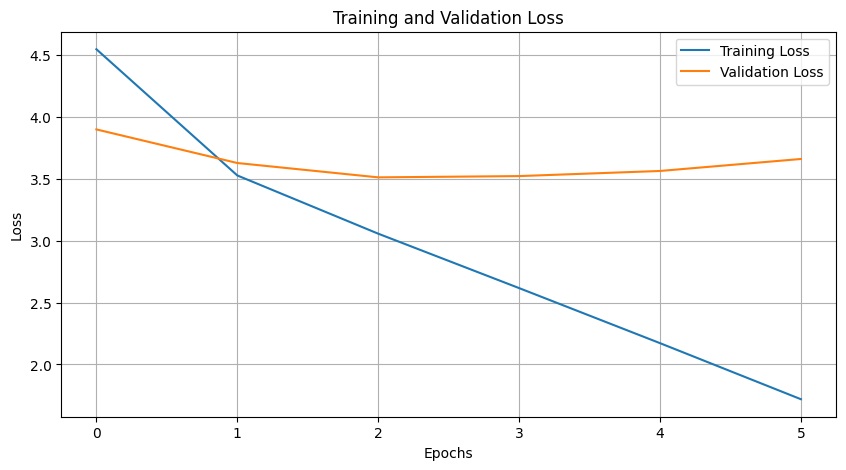

In [20]:
import matplotlib.pyplot as plt

# Plotting the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), train_losses, label='Training Loss')
plt.plot(range(epochs), valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [18]:
train_samples = [(train_dataset.loc[i,'questions'],train_dataset.loc[i,'answers']) for i in range(len(train_dataset))]
train_samples = train_samples[:1000]

In [19]:
# Load the best model state
model.load_state_dict(torch.load('./kaggle_checkpoint/best_model_scaledDotProd_100k.pt'))
# model.load_state_dict(torch.load('./kaggle_checkpoint/best_model.pt'))
model.eval()

correct_train = 0
total_train = 0

with torch.no_grad():
    for (src,tgt) in train_samples:
        input_ids = bert_tokenizer.encode(f"<bos>{src}<eos>").ids
        input_ids = torch.tensor(input_ids,dtype=torch.long).unsqueeze(0).to('cuda')

        bos = bert_tokenizer.token_to_id('<bos>')
            
        tgt_out = model.generate(input_ids,bos=bos,deterministic=True)
        tgt_out = bert_tokenizer.decode(tgt_out.numpy())
        # print(f'\nQuestion: {src} \nAnswer: {tgt} \nModelAnswer: {tgt_out}\n')

        tgt = tgt.lower()
        
        # Check if the predicted and actual sequences match
        if tgt_out == tgt:  # Adjust comparison logic as needed
            correct_train += 1
        total_train += 1

# Calculate accuracy
train_accuracy = correct_train / total_train
print(f'Training set accuracy of the best model: {train_accuracy:.4f}')


/tmp/ipykernel_2610113/3918231758.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./kaggle_checkpoint/best_model_scaledDotProd_100k.pt'

Training set accuracy of the best model: 0.0380
